In [ ]:
pip install gymnasium

In [ ]:
# Install PyTorch Geometric
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00


In [ ]:
# Cell 1: Imports, environment detection, and reproducibility seeds

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch_geometric
from torch_geometric.data import Data, DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import torch_geometric.transforms as T

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve

import os
import random
import warnings
import json
import pickle
from collections import defaultdict, deque
import time
from datetime import datetime
import gymnasium as gym
from typing import List, Dict, Tuple, Optional

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Device detection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device detected: {device}")

if device.type == 'cuda':
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set global random seeds for reproducibility
RANDOM_SEED = 42

def set_seed(seed):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(RANDOM_SEED)
print(f"All random seeds set to: {RANDOM_SEED}")

# Verify PyTorch Geometric installation
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

print("Environment setup complete. Ready for dataset loading.")

Device detected: cpu
All random seeds set to: 42
PyTorch version: 2.8.0+cu126
PyTorch Geometric version: 2.6.1
NetworkX version: 3.5
NumPy version: 2.0.2
Pandas version: 2.2.2
Environment setup complete. Ready for dataset loading.


In [ ]:
# Cell 2: Dataset paths, existence validation, and preview

# Define dataset paths
PATHS = {
    'netflix': '/content/drive/MyDrive/Netflix_1.csv',
    'zoom1': '/content/drive/MyDrive/Zoom_1.csv',
    'zoom2': '/content/drive/MyDrive/Zoom_2.csv',
    'zoom3': '/content/drive/MyDrive/Zoom_3.csv'
}

# Validate file existence and get file sizes
def validate_datasets(paths_dict):
    """Validate dataset existence and return file information"""
    valid_datasets = {}

    for name, path in paths_dict.items():
        if os.path.exists(path):
            file_size_bytes = os.path.getsize(path)
            file_size_mb = file_size_bytes / (1024 * 1024)
            valid_datasets[name] = {
                'path': path,
                'size_bytes': file_size_bytes,
                'size_mb': file_size_mb,
                'exists': True
            }
            print(f"{name.upper()} dataset found: {path}")
            print(f"  File size: {file_size_mb:.2f} MB ({file_size_bytes:,} bytes)")
        else:
            print(f"WARNING: {name.upper()} dataset not found: {path}")
            valid_datasets[name] = {
                'path': path,
                'exists': False
            }

    return valid_datasets

# Validate all datasets
dataset_info = validate_datasets(PATHS)
print(f"\nDataset validation complete. Found {sum(1 for d in dataset_info.values() if d['exists'])} out of {len(PATHS)} datasets.")

# Load and preview datasets
def load_and_preview_dataset(dataset_name, dataset_info, preview_rows=5):
    """Load dataset and show preview"""
    if not dataset_info['exists']:
        print(f"\nSkipping {dataset_name.upper()} - file not found")
        return None

    try:
        print(f"\n{'='*50}")
        print(f"DATASET: {dataset_name.upper()}")
        print(f"{'='*50}")

        # Load dataset
        df = pd.read_csv(dataset_info['path'])

        # Basic information
        print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
        print(f"Columns: {list(df.columns)}")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Data types
        print(f"\nData types:")
        for col, dtype in df.dtypes.items():
            print(f"  {col}: {dtype}")

        # Preview top rows
        print(f"\nFirst {preview_rows} rows:")
        print(df.head(preview_rows))

        # Basic statistics for numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"\nNumeric columns summary:")
            print(df[numeric_cols].describe())

        return df

    except Exception as e:
        print(f"Error loading {dataset_name}: {str(e)}")
        return None

# Load and preview all available datasets
datasets = {}
for name, info in dataset_info.items():
    if info['exists']:
        datasets[name] = load_and_preview_dataset(name, info)

# Summary of loaded datasets
print(f"\n{'='*60}")
print("DATASET LOADING SUMMARY")
print(f"{'='*60}")

total_rows = 0
total_size_mb = 0

for name, df in datasets.items():
    if df is not None:
        rows = len(df)
        size_mb = dataset_info[name]['size_mb']
        total_rows += rows
        total_size_mb += size_mb
        print(f"{name.upper():15} | {rows:>10,} rows | {size_mb:>8.2f} MB")

print(f"{'Total':15} | {total_rows:>10,} rows | {total_size_mb:>8.2f} MB")

# Store dataset references for later use
print(f"\nDatasets loaded and ready for processing:")
for name in datasets.keys():
    if datasets[name] is not None:
        print(f"  - {name}: datasets['{name}']")

NETFLIX dataset found: /content/drive/MyDrive/Netflix_1.csv
  File size: 704.59 MB (738,811,242 bytes)
ZOOM1 dataset found: /content/drive/MyDrive/Zoom_1.csv
  File size: 628.04 MB (658,548,992 bytes)
ZOOM2 dataset found: /content/drive/MyDrive/Zoom_2.csv
  File size: 605.38 MB (634,783,480 bytes)
ZOOM3 dataset found: /content/drive/MyDrive/Zoom_3.csv
  File size: 1969.46 MB (2,065,129,403 bytes)

Dataset validation complete. Found 4 out of 4 datasets.

DATASET: NETFLIX


In [ ]:
# Cell 3: Data schema validation and standardization

def analyze_dataset_schema(df, dataset_name):
    """Analyze and report dataset schema"""
    print(f"\n{'='*60}")
    print(f"SCHEMA ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*60}")

    # Column analysis
    print("Available columns:")
    for i, col in enumerate(df.columns):
        print(f"  {i+1}. {col} ({df[col].dtype})")

    # Identify potential standard columns
    columns = [col.lower() for col in df.columns]

    # Time column detection
    time_candidates = [col for col in df.columns if any(keyword in col.lower()
                      for keyword in ['time', 'timestamp', 'date', 'ts'])]

    # Source/Destination detection
    source_candidates = [col for col in df.columns if any(keyword in col.lower()
                        for keyword in ['source', 'src', 'from', 'sender'])]
    dest_candidates = [col for col in df.columns if any(keyword in col.lower()
                      for keyword in ['destination', 'dest', 'dst', 'to', 'receiver'])]

    # Length/Size detection
    length_candidates = [col for col in df.columns if any(keyword in col.lower()
                        for keyword in ['length', 'size', 'bytes', 'packets', 'volume'])]

    # Label detection
    label_candidates = [col for col in df.columns if any(keyword in col.lower()
                       for keyword in ['label', 'class', 'category', 'type'])]

    print(f"\nColumn mapping candidates:")
    print(f"  Time: {time_candidates}")
    print(f"  Source: {source_candidates}")
    print(f"  Destination: {dest_candidates}")
    print(f"  Length: {length_candidates}")
    print(f"  Label: {label_candidates}")

    return {
        'time_candidates': time_candidates,
        'source_candidates': source_candidates,
        'dest_candidates': dest_candidates,
        'length_candidates': length_candidates,
        'label_candidates': label_candidates
    }

def standardize_dataset_schema(df, dataset_name, schema_mapping=None):
    """Standardize dataset to common schema: Time, Source, Destination, Length, Label"""
    print(f"\nStandardizing schema for {dataset_name.upper()}...")

    df_std = df.copy()

    # Auto-detect or use provided mapping
    if schema_mapping is None:
        candidates = analyze_dataset_schema(df, dataset_name)

        # Auto-select best candidates
        time_col = candidates['time_candidates'][0] if candidates['time_candidates'] else None
        source_col = candidates['source_candidates'][0] if candidates['source_candidates'] else None
        dest_col = candidates['dest_candidates'][0] if candidates['dest_candidates'] else None
        length_col = candidates['length_candidates'][0] if candidates['length_candidates'] else None
        label_col = candidates['label_candidates'][0] if candidates['label_candidates'] else None

    else:
        time_col = schema_mapping.get('time')
        source_col = schema_mapping.get('source')
        dest_col = schema_mapping.get('destination')
        length_col = schema_mapping.get('length')
        label_col = schema_mapping.get('label')

    # Create standardized dataframe
    std_df = pd.DataFrame()

    # Map columns to standard names
    if time_col and time_col in df.columns:
        std_df['Time'] = df[time_col]
        print(f"  Time: {time_col} -> Time")

    if source_col and source_col in df.columns:
        std_df['Source'] = df[source_col]
        print(f"  Source: {source_col} -> Source")

    if dest_col and dest_col in df.columns:
        std_df['Destination'] = df[dest_col]
        print(f"  Destination: {dest_col} -> Destination")

    if length_col and length_col in df.columns:
        std_df['Length'] = df[length_col]
        print(f"  Length: {length_col} -> Length")

    if label_col and label_col in df.columns:
        std_df['Label'] = df[label_col]
        print(f"  Label: {label_col} -> Label")
    else:
        print(f"  Label: Not found - will be derived later")

    return std_df

def validate_standardized_dataset(df, dataset_name):
    """Validate standardized dataset and report statistics"""
    print(f"\n{'='*60}")
    print(f"VALIDATION REPORT: {dataset_name.upper()}")
    print(f"{'='*60}")

    required_cols = ['Time', 'Source', 'Destination', 'Length']
    optional_cols = ['Label']

    # Check required columns
    missing_required = [col for col in required_cols if col not in df.columns]
    if missing_required:
        print(f"ERROR: Missing required columns: {missing_required}")
        return False

    print("Required columns present: Time, Source, Destination, Length")

    # Check optional columns
    has_label = 'Label' in df.columns
    print(f"Optional Label column: {'Present' if has_label else 'Missing'}")

    # Missing values analysis
    print(f"\nMissing values:")
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"  {col}: {missing_count:,} ({missing_pct:.2f}%)")

    # Time range analysis
    if 'Time' in df.columns:
        print(f"\nTime range analysis:")
        try:
            # Try to parse as datetime
            time_series = pd.to_datetime(df['Time'], errors='coerce')
            if time_series.notna().sum() > 0:
                min_time = time_series.min()
                max_time = time_series.max()
                duration = max_time - min_time
                print(f"  Start time: {min_time}")
                print(f"  End time: {max_time}")
                print(f"  Duration: {duration}")
            else:
                print(f"  Time format: Numeric/Timestamp")
                print(f"  Min value: {df['Time'].min()}")
                print(f"  Max value: {df['Time'].max()}")
        except:
            print(f"  Time format: {df['Time'].dtype}")
            print(f"  Min value: {df['Time'].min()}")
            print(f"  Max value: {df['Time'].max()}")

    # Node analysis
    if 'Source' in df.columns and 'Destination' in df.columns:
        unique_sources = df['Source'].nunique()
        unique_destinations = df['Destination'].nunique()
        all_nodes = set(df['Source'].unique()) | set(df['Destination'].unique())
        total_unique_nodes = len(all_nodes)

        print(f"\nNode analysis:")
        print(f"  Unique sources: {unique_sources:,}")
        print(f"  Unique destinations: {unique_destinations:,}")
        print(f"  Total unique nodes: {total_unique_nodes:,}")
        print(f"  Total flows: {len(df):,}")

    # Length statistics
    if 'Length' in df.columns:
        print(f"\nLength statistics:")
        print(f"  Data type: {df['Length'].dtype}")
        print(f"  Min: {df['Length'].min()}")
        print(f"  Max: {df['Length'].max()}")
        print(f"  Mean: {df['Length'].mean():.2f}")
        print(f"  Median: {df['Length'].median():.2f}")
        print(f"  Std: {df['Length'].std():.2f}")

    return True

# Process all loaded datasets
standardized_datasets = {}
schema_reports = {}

for dataset_name, df in datasets.items():
    if df is not None:
        # Analyze schema
        schema_info = analyze_dataset_schema(df, dataset_name)
        schema_reports[dataset_name] = schema_info

        # Standardize schema
        std_df = standardize_dataset_schema(df, dataset_name)

        # Validate standardized dataset
        is_valid = validate_standardized_dataset(std_df, dataset_name)

        if is_valid:
            standardized_datasets[dataset_name] = std_df
            print(f"SUCCESS: {dataset_name.upper()} standardized and validated")
        else:
            print(f"ERROR: {dataset_name.upper()} failed validation")

print(f"\n{'='*60}")
print("SCHEMA STANDARDIZATION SUMMARY")
print(f"{'='*60}")
print(f"Successfully standardized: {len(standardized_datasets)} datasets")
for name in standardized_datasets.keys():
    shape = standardized_datasets[name].shape
    print(f"  {name.upper()}: {shape[0]:,} rows x {shape[1]} columns")

In [ ]:
# Cell 4: Data Cleaning and Preprocessing

import numpy as np
import pandas as pd
from datetime import datetime
import re

def clean_time_column(time_series, dataset_name):
    """Convert time column to numerical timestamps"""
    print(f"  Cleaning Time column for {dataset_name}...")

    # Handle different time formats
    if time_series.dtype == 'object':
        # Try parsing as datetime first
        try:
            parsed_time = pd.to_datetime(time_series, errors='coerce')
            if parsed_time.notna().sum() > len(time_series) * 0.8:  # 80% success rate
                # Convert to Unix timestamp
                cleaned_time = parsed_time.astype('int64') // 10**9  # Convert to seconds
                print(f"    Converted datetime strings to Unix timestamps")
                return cleaned_time
        except:
            pass

    # If already numeric, keep as is
    if pd.api.types.is_numeric_dtype(time_series):
        print(f"    Time already numeric, keeping as is")
        return time_series

    # Last resort: use row index as time
    print(f"    WARNING: Using row index as time proxy")
    return pd.Series(range(len(time_series)), index=time_series.index)

def standardize_ip_addresses(ip_series, dataset_name, column_name):
    """Standardize IP addresses and handle various formats"""
    print(f"  Cleaning {column_name} column for {dataset_name}...")

    cleaned_ips = ip_series.copy()

    # Remove port numbers if present (e.g., 192.168.1.1:80 -> 192.168.1.1)
    if cleaned_ips.dtype == 'object':
        # Remove ports
        cleaned_ips = cleaned_ips.astype(str).str.replace(r':\d+$', '', regex=True)

        # Remove any brackets (IPv6)
        cleaned_ips = cleaned_ips.str.replace('[', '').str.replace(']', '')

        # Handle 'nan' strings
        cleaned_ips = cleaned_ips.replace(['nan', 'None', 'null', ''], np.nan)

    # Convert to categorical for memory efficiency
    cleaned_ips = pd.Categorical(cleaned_ips)
    # Corrected: Access categories for nunique
    print(f"    Standardized {column_name}: {cleaned_ips.categories.nunique()} unique values")

    return cleaned_ips

def normalize_length_column(length_series, dataset_name, method='log1p'):
    """Normalize Length column using specified method"""
    print(f"  Normalizing Length column for {dataset_name} using {method}...")

    # Ensure numeric
    if not pd.api.types.is_numeric_dtype(length_series):
        length_series = pd.to_numeric(length_series, errors='coerce')

    # Remove negative values
    length_series = length_series.clip(lower=0)

    if method == 'log1p':
        normalized = np.log1p(length_series)
        print(f"    Applied log1p transformation")
    elif method == 'zscore':
        mean_val = length_series.mean()
        std_val = length_series.std()
        if std_val > 0:
            normalized = (length_series - mean_val) / std_val
            print(f"    Applied z-score normalization (mean={mean_val:.2f}, std={std_val:.2f})")
        else:
            normalized = length_series
            print(f"    WARNING: Zero std deviation, keeping original values")
    else:
        normalized = length_series
        print(f"    No normalization applied")

    return normalized

def clean_and_preprocess_dataset(df, dataset_name):
    """Main cleaning and preprocessing function"""
    print(f"\n{'='*60}")
    print(f"CLEANING & PREPROCESSING: {dataset_name.upper()}")
    print(f"{'='*60}")

    df_clean = df.copy()
    initial_rows = len(df_clean)

    # 1. Clean Time column
    if 'Time' in df_clean.columns:
        df_clean['Time'] = clean_time_column(df_clean['Time'], dataset_name)

    # 2. Standardize Source/Destination IP addresses
    if 'Source' in df_clean.columns:
        df_clean['Source'] = standardize_ip_addresses(df_clean['Source'], dataset_name, 'Source')

    if 'Destination' in df_clean.columns:
        df_clean['Destination'] = standardize_ip_addresses(df_clean['Destination'], dataset_name, 'Destination')

    # 3. Drop corrupted rows
    print(f"  Removing corrupted rows...")

    # Remove rows with missing Source or Destination
    before_drop = len(df_clean)
    if 'Source' in df_clean.columns and 'Destination' in df_clean.columns:
        df_clean = df_clean.dropna(subset=['Source', 'Destination'])

    # Convert Source and Destination back to object type for comparison
    df_clean['Source'] = df_clean['Source'].astype('object')
    df_clean['Destination'] = df_clean['Destination'].astype('object')

    # Remove rows where Source == Destination (self-loops, often erroneous)
    if 'Source' in df_clean.columns and 'Destination' in df_clean.columns:
        df_clean = df_clean[df_clean['Source'] != df_clean['Destination']]


    after_drop = len(df_clean)
    dropped_rows = before_drop - after_drop

    print(f"    Dropped {dropped_rows:,} corrupted rows ({100*dropped_rows/before_drop:.2f}%)")

    # 4. Normalize Length column
    if 'Length' in df_clean.columns:
        df_clean['Length_normalized'] = normalize_length_column(df_clean['Length'], dataset_name, method='log1p')

    # 5. Final validation
    final_rows = len(df_clean)
    print(f"\nCleaning summary:")
    print(f"  Initial rows: {initial_rows:,}")
    print(f"  Final rows: {final_rows:,}")
    print(f"  Rows removed: {initial_rows - final_rows:,} ({100*(initial_rows-final_rows)/initial_rows:.2f}%)")
    print(f"  Data quality: {'GOOD' if final_rows > initial_rows * 0.9 else 'MODERATE' if final_rows > initial_rows * 0.7 else 'POOR'}")

    return df_clean

# Process all standardized datasets
cleaned_datasets = {}

for dataset_name, df in standardized_datasets.items():
    cleaned_df = clean_and_preprocess_dataset(df, dataset_name)
    cleaned_datasets[dataset_name] = cleaned_df

print(f"\n{'='*60}")
print("DATA CLEANING SUMMARY")
print(f"{'='*60}")
print(f"Successfully cleaned: {len(cleaned_datasets)} datasets")

In [ ]:
# Cell 5: Bottleneck labeling policy (FERN-inspired) - ORIGINAL

import numpy as np
import pandas as pd
from collections import defaultdict

BOTTLENECK_THRESHOLD_PERCENTILE = 85  # Top 15% of nodes by traffic
DEGREE_PERCENTILE = 70  # Minimum connections set to 70th percentile of node degrees

def compute_node_bottleneck_labels_simplified(df, dataset_name, threshold_percentile=BOTTLENECK_THRESHOLD_PERCENTILE, degree_percentile=DEGREE_PERCENTILE):
    """
    Compute bottleneck labels for nodes based on traffic and connectivity.

    Bottleneck definition:
    1. Node has traffic volume >= threshold_percentile
    2. Node has degree >= degree_percentile of all nodes
    3. Combines both in-traffic and out-traffic
    """
    print(f"\nApplying bottleneck labeling to {dataset_name.upper()}...")

    # Get original length values if available
    length_col = 'Length_Original' if 'Length_Original' in df.columns else 'Length'

    # Calculate in-traffic (traffic flowing TO the node)
    in_traffic = df.groupby('Destination')[length_col].sum()

    # Calculate out-traffic (traffic flowing FROM the node)
    out_traffic = df.groupby('Source')[length_col].sum()

    # Calculate node degree (number of unique connections)
    in_degree = df.groupby('Destination').size()
    out_degree = df.groupby('Source').size()

    # Get all unique nodes
    all_nodes = set(df['Source'].unique()) | set(df['Destination'].unique())

    # Combine traffic and degree info
    node_stats = []
    for node in all_nodes:
        total_traffic = in_traffic.get(node, 0) + out_traffic.get(node, 0)
        # Compute degree as number of unique connections (avoid double-counting)
        in_count = in_degree.get(node, 0)
        out_count = out_degree.get(node, 0)
        total_degree = in_count + out_count  # Sum in and out degrees

        node_stats.append({
            'node': node,
            'total_traffic': total_traffic,
            'in_traffic': in_traffic.get(node, 0),
            'out_traffic': out_traffic.get(node, 0),
            'total_degree': total_degree,
            'in_degree': in_count,
            'out_degree': out_count
        })

    # Convert to DataFrame
    node_df = pd.DataFrame(node_stats)

    # Calculate thresholds
    traffic_threshold = np.percentile(node_df['total_traffic'].dropna(), threshold_percentile)
    degrees = node_df['total_degree'].dropna()
    min_connections = max(3, int(np.percentile(degrees, degree_percentile)) if len(degrees) > 0 else 3)

    # Define bottlenecks based on criteria
    node_df['is_bottleneck'] = (
        (node_df['total_traffic'] >= traffic_threshold) &
        (node_df['total_degree'] >= min_connections)
    ).astype(int)

    # Create node to label mapping
    node_label_map = dict(zip(node_df['node'], node_df['is_bottleneck']))

    # Debug logging
    print(f"Bottleneck labeling policy for {dataset_name}:")
    print(f"  Traffic threshold (>= {threshold_percentile}th percentile): {traffic_threshold:.2f}")
    print(f"  Degree threshold (>= {degree_percentile}th percentile): {min_connections}")
    print(f"  Degree distribution: min={degrees.min() if len(degrees) > 0 else 0}, "
          f"max={degrees.max() if len(degrees) > 0 else 0}, "
          f"mean={degrees.mean() if len(degrees) > 0 else 0:.1f}")
    print(f"  Total nodes: {len(all_nodes)}")
    print(f"  Bottleneck nodes: {node_df['is_bottleneck'].sum()}")
    print(f"  Bottleneck percentage: {100 * node_df['is_bottleneck'].mean():.1f}%")

    if node_df['is_bottleneck'].sum() > 0:
        print(f"  Bottleneck node details:")
        bottleneck_nodes = node_df[node_df['is_bottleneck'] == 1][['node', 'total_traffic', 'total_degree']].sort_values('total_traffic', ascending=False)
        for _, row in bottleneck_nodes.iterrows():
            print(f"    {row['node']}: traffic={row['total_traffic']:.1f}, degree={row['total_degree']}")

    # Show top nodes by traffic
    print(f"\nTop 10 nodes by traffic:")
    top_nodes = node_df.nlargest(10, 'total_traffic')
    for _, row in top_nodes.iterrows():
        status = "BOTTLENECK" if row['is_bottleneck'] else "normal"
        print(f"  {row['node']}: traffic={row['total_traffic']:.1f}, degree={row['total_degree']}, {status}")

    return node_label_map, node_df

def apply_bottleneck_labeling_policy_simplified(df, dataset_name, threshold_percentile=85, degree_percentile=70):
    """Apply simplified bottleneck labeling policy matching Cell 5 approach"""
    print(f"\n{'='*60}")
    print(f"BOTTLENECK LABELING: {dataset_name.upper()}")
    print(f"{'='*60}")

    # Check if dataset already has labels
    if 'Label' in df.columns and df['Label'].notna().sum() > 0:
        print("Dataset already contains labels - using existing labels")

        # Convert labels to binary bottleneck labels
        unique_labels = df['Label'].unique()
        print(f"Existing labels: {unique_labels}")

        # Assume bottleneck if label contains 'bottleneck', 'congestion', 'attack', etc.
        bottleneck_keywords = ['bottleneck', 'congestion', 'attack', 'anomaly', 'malicious', '1']

        def is_bottleneck_label(label):
            if pd.isna(label):
                return False
            label_str = str(label).lower()
            return any(keyword in label_str for keyword in bottleneck_keywords) or str(label) == '1'

        # Apply to both source and destination nodes
        node_labels = {}

        # Label nodes based on traffic they participate in
        for _, row in df.iterrows():
            source = row['Source']
            dest = row['Destination']
            is_bottleneck = is_bottleneck_label(row['Label'])

            if source not in node_labels:
                node_labels[source] = False
            if dest not in node_labels:
                node_labels[dest] = False

            if is_bottleneck:
                node_labels[source] = True
                node_labels[dest] = True

        # Convert boolean to int for consistency
        node_labels = {node: int(is_bottleneck) for node, is_bottleneck in node_labels.items()}

        return node_labels

    print("No existing labels found - deriving bottleneck labels using simplified heuristics")

    # Use simplified approach from Cell 5
    node_labels, node_stats = compute_node_bottleneck_labels_simplified(
        df, dataset_name, threshold_percentile, degree_percentile
    )

    return node_labels

# Apply bottleneck labeling to all cleaned datasets
bottleneck_labels_simplified = {}

for dataset_name, df in cleaned_datasets.items():
    labels = apply_bottleneck_labeling_policy_simplified(df, dataset_name, threshold_percentile=85, degree_percentile=70)
    bottleneck_labels_simplified[dataset_name] = labels

print(f"\n{'='*60}")
print("BOTTLENECK LABELING SUMMARY")
print(f"{'='*60}")

for dataset_name in bottleneck_labels_simplified.keys():
    labels = bottleneck_labels_simplified[dataset_name]
    total_nodes = len(labels)
    bottleneck_nodes = sum(labels.values())
    bottleneck_rate = (bottleneck_nodes / total_nodes) * 100

    print(f"{dataset_name.upper():15} | {total_nodes:>8,} nodes | {bottleneck_nodes:>8,} bottlenecks | {bottleneck_rate:>6.2f}%")

# Print rationale
print(f"\nLabel policy rationale:")
print(f"1. Traffic-based: Nodes handling >= {BOTTLENECK_THRESHOLD_PERCENTILE}th percentile traffic are high-load")
print(f"2. Connectivity-based: Nodes with >= {DEGREE_PERCENTILE}th percentile connections are critical junction points")
print(f"3. Combined criteria: Both conditions must be met to avoid false positives")
print(f"4. Adaptive degree threshold (min 3) ensures robustness across network sizes")

print(f"\nBottleneck labels stored in: bottleneck_labels_simplified['dataset_name']")

In [ ]:
# Cell 6: Bottleneck statistics - FIXED

import pandas as pd
import numpy as np

def analyze_bottleneck_statistics(cleaned_datasets, bottleneck_labels_simplified, chunk_size=1000000):
    """
    Analyze bottleneck statistics with low memory usage.
    Validates class balance and provides loss weighting.
    Aligns with FERN-inspired labeling from Cell 5.
    Fixed to create balanced flow classification.
    """
    print(f"{'='*70}")
    print("BOTTLENECK STATISTICS ANALYSIS")
    print(f"{'='*70}")

    stats_summary = []

    for dataset_name, df in cleaned_datasets.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print(f"{'-'*50}")

        # Get node labels from Cell 5
        node_labels = bottleneck_labels_simplified[dataset_name]
        total_nodes = len(node_labels)
        bottleneck_nodes = sum(node_labels.values())
        bottleneck_node_pct = 100 * bottleneck_nodes / total_nodes if total_nodes > 0 else 0

        # Get bottleneck nodes set for vectorized lookup
        bottleneck_nodes_set = set(node for node, label in node_labels.items() if label == 1)

        # Flow statistics: FIXED - Use flow-level labeling based on traffic characteristics
        # Instead of just checking if source/dest is bottleneck node, label flows based on traffic patterns
        total_flows = len(df)

        # Get traffic statistics for flow labeling
        length_col = 'Length_Original' if 'Length_Original' in df.columns else 'Length'
        traffic_threshold = np.percentile(df[length_col], 75)  # Use 75th percentile for flow-level labeling

        bottleneck_flows = 0
        bottleneck_traffic = 0
        total_traffic = 0

        # Process in chunks to reduce memory usage
        for start in range(0, total_flows, chunk_size):
            chunk = df[start:start + chunk_size]

            # FIXED: Label flows as bottleneck based on BOTH node involvement AND traffic volume
            # This creates more balanced classification
            node_involved = (chunk['Source'].isin(bottleneck_nodes_set) |
                           chunk['Destination'].isin(bottleneck_nodes_set))
            high_traffic = chunk[length_col] >= traffic_threshold

            # Flow is bottleneck if it involves bottleneck nodes AND has high traffic
            is_bottleneck = node_involved & high_traffic

            bottleneck_flows += is_bottleneck.sum()
            bottleneck_traffic += chunk[is_bottleneck][length_col].sum()
            total_traffic += chunk[length_col].sum()

        bottleneck_flow_pct = 100 * bottleneck_flows / total_flows if total_flows > 0 else 0
        normal_flows = total_flows - bottleneck_flows
        normal_flow_pct = 100 - bottleneck_flow_pct
        bottleneck_traffic_pct = 100 * bottleneck_traffic / total_traffic if total_traffic > 0 else 0

        # Class balance metrics
        class_ratio = bottleneck_flows / normal_flows if normal_flows > 0 else float('inf')
        imbalance_severity = "SEVERE" if bottleneck_flow_pct < 10 else "MODERATE" if bottleneck_flow_pct < 25 else "MILD"

        # Loss weighting (inverse frequency) - FIXED
        weight_normal = 1.0
        weight_bottleneck = normal_flows / bottleneck_flows if bottleneck_flows > 0 else 1.0

        print(f"NETWORK TOPOLOGY:")
        print(f"  Total nodes: {total_nodes:,}")
        print(f"  Bottleneck nodes: {bottleneck_nodes:,} ({bottleneck_node_pct:.1f}%)")
        print(f"  Normal nodes: {total_nodes - bottleneck_nodes:,} ({100 - bottleneck_node_pct:.1f}%)")

        print(f"\nFLOW DISTRIBUTION:")
        print(f"  Total flows: {total_flows:,}")
        print(f"  Bottleneck flows: {bottleneck_flows:,} ({bottleneck_flow_pct:.1f}%)")
        print(f"  Normal flows: {normal_flows:,} ({normal_flow_pct:.1f}%)")

        # FIXED: Better ratio display
        if normal_flows > 0 and bottleneck_flows > 0:
            ratio_display = f"1:{normal_flows//bottleneck_flows}" if bottleneck_flows <= normal_flows else f"{bottleneck_flows//normal_flows}:1"
        elif bottleneck_flows == 0:
            ratio_display = "0:1"
        else:
            ratio_display = "1:0"

        print(f"  Class ratio (bottleneck:normal): {ratio_display}")

        print(f"\nTRAFFIC ANALYSIS:")
        print(f"  Traffic via bottlenecks: {bottleneck_traffic_pct:.1f}%")
        print(f"  Imbalance severity: {imbalance_severity}")

        print(f"\nTRAINING WEIGHTS RECOMMENDATION:")
        print(f"  Normal class weight: {weight_normal:.2f}")
        print(f"  Bottleneck class weight: {weight_bottleneck:.2f}")

        # Insights
        if bottleneck_node_pct < 5:
            print(f"\nINSIGHTS:")
            print(f"  - Few bottleneck nodes ({bottleneck_node_pct:.1f}%) suggest centralized topology")
            print(f"  - Bottlenecks are critical infrastructure")

        if bottleneck_flow_pct > 30:
            print(f"\nWARNINGS:")
            print(f"  - High bottleneck flow percentage may indicate network stress")

        # Debug information to verify bottleneck node identification
        if bottleneck_flows == 0:
            print(f"\nDEBUG INFO:")
            print(f"  Bottleneck nodes found: {list(bottleneck_nodes_set)}")
            # Check if any flows actually involve these nodes
            sample_sources = df['Source'].unique()[:5]
            sample_dests = df['Destination'].unique()[:5]
            print(f"  Sample sources: {list(sample_sources)}")
            print(f"  Sample destinations: {list(sample_dests)}")

            # Check intersection
            source_bottlenecks = set(df['Source'].unique()) & bottleneck_nodes_set
            dest_bottlenecks = set(df['Destination'].unique()) & bottleneck_nodes_set
            print(f"  Sources that are bottlenecks: {list(source_bottlenecks)}")
            print(f"  Destinations that are bottlenecks: {list(dest_bottlenecks)}")

        stats_summary.append({
            'dataset': dataset_name,
            'total_nodes': total_nodes,
            'bottleneck_nodes': bottleneck_nodes,
            'bottleneck_node_pct': bottleneck_node_pct,
            'total_flows': total_flows,
            'bottleneck_flows': bottleneck_flows,
            'bottleneck_flow_pct': bottleneck_flow_pct,
            'class_ratio': class_ratio,
            'weight_normal': weight_normal,
            'weight_bottleneck': weight_bottleneck,
            'imbalance_severity': imbalance_severity
        })

    # Summary table
    print(f"\n{'='*70}")
    print("SUMMARY TABLE")
    print(f"{'='*70}")

    summary_df = pd.DataFrame(stats_summary)

    print(f"{'Dataset':<15} {'Nodes':<8} {'B.Nodes':<8} {'B.Node%':<8} {'Flows':<10} {'B.Flow%':<8} {'Weight':<8}")
    print(f"{'-'*70}")

    for _, row in summary_df.iterrows():
        print(f"{row['dataset']:<15} "
              f"{row['total_nodes']:<8,} "
              f"{row['bottleneck_nodes']:<8} "
              f"{row['bottleneck_node_pct']:<8.1f} "
              f"{row['total_flows']:<10,} "
              f"{row['bottleneck_flow_pct']:<8.1f} "
              f"{row['weight_bottleneck']:<8.1f}")

    # Class balance validation
    print(f"\nCLASS BALANCE VALIDATION:")
    target_ranges = {
        'netflix': (13, 17),  # 15% ± 2%
        'zoom1': (18, 22),    # 20% ± 2%
        'zoom2': (18, 22),    # 20% ± 2%
        'zoom3': (23, 27)     # 25% ± 2%
    }

    for _, row in summary_df.iterrows():
        target_range = target_ranges.get(row['dataset'].lower(), None)
        status = "PASS" if target_range and target_range[0] <= row['bottleneck_node_pct'] <= target_range[1] else "FAIL"
        print(f"  {row['dataset']}: {row['bottleneck_node_pct']:.1f}% (target: {target_range[0]}-{target_range[1] if target_range else 'N/A'}) {status}")

    print(f"\nFERN TRAINING CONSIDERATIONS:")
    print(f"  • Use class weights to handle imbalance")
    print(f"  • Bottleneck nodes are critical infrastructure")
    print(f"  • Flow labels derived for link prediction")
    print(f"  • Use stratified sampling for train/val splits")

    print(f"\nFLOW LABELING METHODOLOGY:")
    print(f"  • Bottleneck flow: Involves bottleneck node AND has high traffic volume")
    print(f"  • Uses 75th percentile traffic threshold for flow classification")
    print(f"  • Creates balanced classification suitable for ML training")

    return summary_df

# Run the analysis
statistics_summary = analyze_bottleneck_statistics(cleaned_datasets, bottleneck_labels_simplified)

In [ ]:
# Cell 7: Temporal Snapshot Generation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch_geometric
from torch_geometric.data import Data, DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import torch_geometric.transforms as T

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve

import os
import random
import warnings
import json
import pickle
from collections import defaultdict, deque
import time
from datetime import datetime
import gymnasium as gym
from typing import List, Dict, Tuple, Optional
import psutil
import gc

warnings.filterwarnings('ignore')

def create_snapshots(cleaned_datasets, window_size=60, overlap=0.5, time_col="Time", chunk_size=1_000_000):
    """
    Create temporal graph snapshots from cleaned datasets.
    Instead of storing full DataFrames, stores index ranges for memory efficiency.
    """
    print("="*70)
    print("TEMPORAL SNAPSHOT GENERATION (CELL 7)")
    print("="*70)

    snapshots_info_dict = {}

    for dataset_name, df in cleaned_datasets.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        # Ensure time is sorted
        df = df.sort_values(by=time_col).reset_index(drop=True)

        # Convert to numeric if needed
        if not pd.api.types.is_numeric_dtype(df[time_col]):
            try:
                df[time_col] = pd.to_datetime(df[time_col]).astype("int64") // 1_000_000_000
                print(f"  Converted {time_col} to Unix timestamps (seconds)")
            except Exception as e:
                print(f"  Warning: Could not convert {time_col} to numeric timestamp: {e}")
                pass
        else:
            print(f"  {time_col} column is already numeric.")

        min_time = df[time_col].min()
        max_time = df[time_col].max()
        duration = max_time - min_time

        step = int(window_size * (1 - overlap))
        if step <= 0:
            step = 1
            print(f"  Warning: Overlap too high, setting step size to 1 sec.")

        print(f"  Time range: {min_time} -> {max_time} ({duration} sec total)")
        print(f"  Window size: {window_size} sec, Step size: {step} sec (overlap {overlap*100:.0f}%)")
        print(f"  Chunk size for processing: {chunk_size:,} rows")

        snapshots_info = []
        snapshot_id = 0
        start = min_time

        process = psutil.Process(os.getpid())

        while start < max_time:
            end = start + window_size

            start_idx_window = df[time_col].searchsorted(start, side='left')
            end_idx_window = df[time_col].searchsorted(end, side='left')

            if end_idx_window > start_idx_window:
                snapshots_info.append((snapshot_id, start, end, (start_idx_window, end_idx_window)))
                snapshot_id += 1

            start += step

            current_mem = process.memory_info().rss / (1024 * 1024)
            print(f"  Processed up to time {start} (Snapshot {snapshot_id-1}). Current memory: {current_mem:.2f} MB", end='\r')

        snapshots_info_dict[dataset_name] = snapshots_info
        print(f"\n  Generated {len(snapshots_info)} snapshots info")

        if len(snapshots_info) > 0:
            avg_flows = int(np.mean([info[3][1] - info[3][0] for info in snapshots_info]))
            print(f"  Avg flows per snapshot (based on index ranges): {avg_flows:,}")
        else:
            print(f"  No snapshots info generated for {dataset_name}. Check window size, overlap, and data time range.")

    print("\nSnapshotting strategy complete. Snapshot info stored (not full DataFrames).")
    print(f"Final memory usage: {process.memory_info().rss / (1024 * 1024):.2f} MB")
    return snapshots_info_dict

# Run snapshot generation
if 'cleaned_datasets' in locals():
    print("\nUsing default window_size=60 and overlap=0.5 for snapshot creation strategy (storing index ranges).")
    snapshots_info = create_snapshots(cleaned_datasets, window_size=60, overlap=0.5, chunk_size=1_000_000)
else:
    print("\nSkipping temporal snapshot generation strategy: 'cleaned_datasets' not found.")
    print("Please ensure Cell 4 has been executed successfully.")

print("\nSnapshot index ranges stored in 'snapshots_info'.")

In [ ]:
# Cell 8: Build Graph Snapshots

import networkx as nx
import pandas as pd
import numpy as np
import psutil
import gc
from collections import defaultdict
import time

def build_graph_snapshots(cleaned_datasets, snapshots_info_dict, bottleneck_labels_simplified):
    """
    Build graph snapshots from temporal snapshot information.
    For each dataset, create ordered snapshots with:
    - Nodes = IPs
    - Edges = traffic within window
    - Weights = aggregated Length
    Save (snapshot_id, G) for each dataset.
    """
    print("="*70)
    print("BUILD GRAPH SNAPSHOTS (CELL 8)")
    print("="*70)

    graph_snapshots_dict = {}
    process = psutil.Process()

    for dataset_name, df in cleaned_datasets.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        if dataset_name not in snapshots_info_dict:
            print(f"  Warning: No snapshot info found for {dataset_name}")
            continue

        snapshots_info = snapshots_info_dict[dataset_name]
        bottleneck_labels = bottleneck_labels_simplified[dataset_name]

        print(f"  Processing {len(snapshots_info)} snapshots")
        print(f"  Total flows in dataset: {len(df):,}")

        # Determine length column
        length_col = 'Length_Original' if 'Length_Original' in df.columns else 'Length'

        graph_snapshots = []

        for i, (snapshot_id, start_time, end_time, (start_idx, end_idx)) in enumerate(snapshots_info):
            # Extract flows for this time window
            window_df = df.iloc[start_idx:end_idx].copy()

            if len(window_df) == 0:
                print(f"  Snapshot {snapshot_id}: No flows in window")
                continue

            # Create directed graph
            G = nx.DiGraph()

            # Add all nodes (IPs) with bottleneck labels
            all_nodes = set(window_df['Source'].unique()) | set(window_df['Destination'].unique())

            for node in all_nodes:
                is_bottleneck = bottleneck_labels.get(node, 0)
                G.add_node(node, bottleneck=is_bottleneck)

            # Aggregate edges by (source, destination) pairs
            edge_aggregation = defaultdict(lambda: {'weight': 0, 'flow_count': 0})

            for _, row in window_df.iterrows():
                src, dst = row['Source'], row['Destination']
                weight = row[length_col]

                edge_aggregation[(src, dst)]['weight'] += weight
                edge_aggregation[(src, dst)]['flow_count'] += 1

            # Add edges to graph
            for (src, dst), attrs in edge_aggregation.items():
                G.add_edge(src, dst,
                          weight=attrs['weight'],
                          flow_count=attrs['flow_count'])

            # Graph statistics
            num_nodes = G.number_of_nodes()
            num_edges = G.number_of_edges()
            total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
            bottleneck_nodes = sum(1 for _, data in G.nodes(data=True) if data['bottleneck'] == 1)

            # Store snapshot
            graph_snapshots.append((snapshot_id, G))

            # Progress update
            if (i + 1) % 10 == 0 or i == len(snapshots_info) - 1:
                current_mem = process.memory_info().rss / (1024 * 1024)
                print(f"  Snapshot {snapshot_id}: {num_nodes} nodes, {num_edges} edges, "
                      f"{bottleneck_nodes} bottlenecks, weight={total_weight:,.0f} "
                      f"(Progress: {i+1}/{len(snapshots_info)}, Mem: {current_mem:.1f}MB)")

        graph_snapshots_dict[dataset_name] = graph_snapshots

        # Dataset summary
        total_snapshots = len(graph_snapshots)
        if total_snapshots > 0:
            avg_nodes = np.mean([G.number_of_nodes() for _, G in graph_snapshots])
            avg_edges = np.mean([G.number_of_edges() for _, G in graph_snapshots])
            print(f"\n  DATASET SUMMARY:")
            print(f"    Total snapshots created: {total_snapshots}")
            print(f"    Average nodes per snapshot: {avg_nodes:.1f}")
            print(f"    Average edges per snapshot: {avg_edges:.1f}")

        # Garbage collection
        gc.collect()

    # Overall summary
    print(f"\n{'='*70}")
    print("GRAPH SNAPSHOTS SUMMARY")
    print(f"{'='*70}")

    total_graphs = 0
    for dataset_name, snapshots in graph_snapshots_dict.items():
        count = len(snapshots)
        total_graphs += count
        print(f"  {dataset_name.upper()}: {count:,} graph snapshots")

    print(f"\nTOTAL GRAPH SNAPSHOTS: {total_graphs:,}")
    print(f"Final memory usage: {process.memory_info().rss / (1024 * 1024):.1f} MB")

    return graph_snapshots_dict

def analyze_graph_snapshots(graph_snapshots_dict, sample_size=5):
    """
    Analyze a sample of graph snapshots to understand structure.
    """
    print(f"\n{'='*70}")
    print("GRAPH SNAPSHOTS ANALYSIS")
    print(f"{'='*70}")

    for dataset_name, snapshots in graph_snapshots_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        if len(snapshots) == 0:
            print("  No snapshots to analyze")
            continue

        # Sample snapshots for analysis
        sample_indices = np.linspace(0, len(snapshots)-1, min(sample_size, len(snapshots)), dtype=int)

        print(f"  Analyzing {len(sample_indices)} sample snapshots:")
        print(f"  {'Snapshot':<10} {'Nodes':<8} {'Edges':<8} {'Density':<8} {'Bottlenecks':<12} {'Avg Weight':<12}")
        print(f"  {'-'*65}")

        for idx in sample_indices:
            snapshot_id, G = snapshots[idx]

            num_nodes = G.number_of_nodes()
            num_edges = G.number_of_edges()
            density = nx.density(G) if num_nodes > 1 else 0
            bottlenecks = sum(1 for _, data in G.nodes(data=True) if data.get('bottleneck', 0) == 1)

            if num_edges > 0:
                avg_weight = np.mean([data['weight'] for _, _, data in G.edges(data=True)])
            else:
                avg_weight = 0

            print(f"  {snapshot_id:<10} {num_nodes:<8} {num_edges:<8} {density:<8.3f} "
                  f"{bottlenecks:<12} {avg_weight:<12,.0f}")

        # Overall statistics
        all_nodes = [G.number_of_nodes() for _, G in snapshots]
        all_edges = [G.number_of_edges() for _, G in snapshots]
        all_densities = [nx.density(G) if G.number_of_nodes() > 1 else 0 for _, G in snapshots]

        print(f"\n  STATISTICS ACROSS ALL SNAPSHOTS:")
        print(f"    Nodes - Min: {min(all_nodes)}, Max: {max(all_nodes)}, Avg: {np.mean(all_nodes):.1f}")
        print(f"    Edges - Min: {min(all_edges)}, Max: {max(all_edges)}, Avg: {np.mean(all_edges):.1f}")
        print(f"    Density - Min: {min(all_densities):.3f}, Max: {max(all_densities):.3f}, Avg: {np.mean(all_densities):.3f}")

# Run graph snapshot creation
if 'cleaned_datasets' in locals() and 'snapshots_info' in locals() and 'bottleneck_labels_simplified' in locals():
    print("Building graph snapshots from temporal data...")
    graph_snapshots = build_graph_snapshots(cleaned_datasets, snapshots_info, bottleneck_labels_simplified)

    # Analyze the created snapshots
    analyze_graph_snapshots(graph_snapshots, sample_size=5)

    print(f"\nGraph snapshots stored in 'graph_snapshots' variable.")
    print("Each entry: {dataset_name: [(snapshot_id, NetworkX_Graph), ...]}")

else:
    missing_vars = []
    if 'cleaned_datasets' not in locals():
        missing_vars.append('cleaned_datasets')
    if 'snapshots_info' not in locals():
        missing_vars.append('snapshots_info')
    if 'bottleneck_labels_simplified' not in locals():
        missing_vars.append('bottleneck_labels_simplified')

    print(f"Skipping graph snapshot creation. Missing variables: {', '.join(missing_vars)}")
    print("Please ensure previous cells have been executed successfully.")

In [ ]:
# Cell 9: Node Features

import networkx as nx
import pandas as pd
import numpy as np
import psutil
import gc
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def compute_node_features(graph_snapshots_dict):
    """
    Compute per-node features per snapshot:
    - in/out degree
    - in/out traffic volume
    - centrality metrics
    - clustering coefficient
    Normalize features across snapshots for FERN alignment.
    """
    print("="*70)
    print("NODE FEATURES COMPUTATION (CELL 9)")
    print("="*70)

    node_features_dict = {}
    process = psutil.Process()

    for dataset_name, snapshots in graph_snapshots_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        if len(snapshots) == 0:
            print("  No snapshots to process")
            continue

        print(f"  Computing features for {len(snapshots)} snapshots")

        # Collect all features across snapshots
        all_features = []
        snapshot_node_mapping = []  # Track which nodes belong to which snapshot

        for i, (snapshot_id, G) in enumerate(snapshots):
            if G.number_of_nodes() == 0:
                continue

            # Initialize feature dictionary for this snapshot
            snapshot_features = {}
            nodes = list(G.nodes())

            # Basic degree features
            in_degrees = dict(G.in_degree())
            out_degrees = dict(G.out_degree())

            # Traffic volume features
            in_traffic = defaultdict(float)
            out_traffic = defaultdict(float)

            for src, dst, data in G.edges(data=True):
                weight = data.get('weight', 0)
                out_traffic[src] += weight
                in_traffic[dst] += weight

            # Centrality metrics (with error handling for disconnected graphs)
            try:
                # Convert to undirected for clustering coefficient
                G_undirected = G.to_undirected()
                clustering = nx.clustering(G_undirected)
            except:
                clustering = {node: 0.0 for node in nodes}

            try:
                # Betweenness centrality (sample for large graphs)
                if len(nodes) > 100:
                    betweenness = nx.betweenness_centrality(G, k=min(100, len(nodes)))
                else:
                    betweenness = nx.betweenness_centrality(G)
            except:
                betweenness = {node: 0.0 for node in nodes}

            try:
                closeness = nx.closeness_centrality(G)
            except:
                closeness = {node: 0.0 for node in nodes}

            try:
                eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
            except:
                eigenvector = {node: 0.0 for node in nodes}

            # Compile features for each node
            for node in nodes:
                node_features = {
                    'snapshot_id': snapshot_id,
                    'node_id': node,
                    'in_degree': in_degrees.get(node, 0),
                    'out_degree': out_degrees.get(node, 0),
                    'total_degree': in_degrees.get(node, 0) + out_degrees.get(node, 0),
                    'in_traffic': in_traffic.get(node, 0.0),
                    'out_traffic': out_traffic.get(node, 0.0),
                    'total_traffic': in_traffic.get(node, 0.0) + out_traffic.get(node, 0.0),
                    'clustering_coeff': clustering.get(node, 0.0),
                    'betweenness_centrality': betweenness.get(node, 0.0),
                    'closeness_centrality': closeness.get(node, 0.0),
                    'eigenvector_centrality': eigenvector.get(node, 0.0),
                    'bottleneck_label': G.nodes[node].get('bottleneck', 0)
                }

                all_features.append(node_features)
                snapshot_node_mapping.append((snapshot_id, node))

            # Progress update
            if (i + 1) % 20 == 0 or i == len(snapshots) - 1:
                current_mem = process.memory_info().rss / (1024 * 1024)
                print(f"    Progress: {i+1}/{len(snapshots)} snapshots processed "
                      f"(Mem: {current_mem:.1f}MB)", end='\r')

        print(f"\n  Computed features for {len(all_features)} node instances")

        # Convert to DataFrame for easier normalization
        features_df = pd.DataFrame(all_features)

        if len(features_df) == 0:
            print("  Warning: No features computed")
            continue

        # Feature columns to normalize (exclude IDs and labels)
        feature_cols = [col for col in features_df.columns
                       if col not in ['snapshot_id', 'node_id', 'bottleneck_label']]

        print(f"  Feature columns: {feature_cols}")

        # Normalize features using StandardScaler
        scaler = StandardScaler()
        features_df[feature_cols] = scaler.fit_transform(features_df[feature_cols])

        # Store normalized features
        node_features_dict[dataset_name] = {
            'features_df': features_df,
            'scaler': scaler,
            'feature_columns': feature_cols,
            'snapshot_node_mapping': snapshot_node_mapping
        }

        # Summary statistics
        print(f"\n  FEATURE SUMMARY:")
        print(f"    Total node instances: {len(features_df):,}")
        print(f"    Unique nodes: {features_df['node_id'].nunique():,}")
        print(f"    Snapshots covered: {features_df['snapshot_id'].nunique():,}")
        print(f"    Features per node: {len(feature_cols)}")
        print(f"    Bottleneck nodes: {features_df['bottleneck_label'].sum():,}")

        gc.collect()

    print(f"\n{'='*70}")
    print("NODE FEATURES SUMMARY")
    print(f"{'='*70}")

    total_instances = 0
    for dataset_name, data in node_features_dict.items():
        count = len(data['features_df'])
        total_instances += count
        print(f"  {dataset_name.upper()}: {count:,} node feature instances")

    print(f"\nTOTAL NODE FEATURE INSTANCES: {total_instances:,}")
    print(f"Final memory usage: {process.memory_info().rss / (1024 * 1024):.1f} MB")

    return node_features_dict

def analyze_node_features(node_features_dict, sample_dataset=None):
    """
    Analyze computed node features with detailed statistics.
    """
    print(f"\n{'='*70}")
    print("NODE FEATURES ANALYSIS")
    print(f"{'='*70}")

    if sample_dataset:
        datasets_to_analyze = [sample_dataset] if sample_dataset in node_features_dict else []
    else:
        datasets_to_analyze = list(node_features_dict.keys())

    for dataset_name in datasets_to_analyze:
        data = node_features_dict[dataset_name]
        features_df = data['features_df']
        feature_cols = data['feature_columns']

        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        # Basic statistics
        print(f"BASIC STATISTICS:")
        print(f"  Node instances: {len(features_df):,}")
        print(f"  Unique nodes: {features_df['node_id'].nunique():,}")
        print(f"  Snapshots: {features_df['snapshot_id'].nunique():,}")
        print(f"  Features per node: {len(feature_cols)}")

        # Feature statistics (before normalization effects)
        print(f"\nFEATURE DISTRIBUTIONS (normalized):")
        print(f"  {'Feature':<25} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
        print(f"  {'-'*65}")

        for col in feature_cols[:8]:  # Show first 8 features
            stats = features_df[col].describe()
            print(f"  {col:<25} {stats['mean']:<10.3f} {stats['std']:<10.3f} "
                  f"{stats['min']:<10.3f} {stats['max']:<10.3f}")

        # Bottleneck analysis
        bottleneck_stats = features_df.groupby('bottleneck_label')[feature_cols].mean()
        print(f"\nBOTTLENECK vs NORMAL NODE FEATURES (mean values):")
        print(f"  {'Feature':<25} {'Normal':<12} {'Bottleneck':<12} {'Difference':<12}")
        print(f"  {'-'*65}")

        for col in feature_cols[:6]:  # Show key features
            normal_mean = bottleneck_stats.loc[0, col] if 0 in bottleneck_stats.index else 0
            bottleneck_mean = bottleneck_stats.loc[1, col] if 1 in bottleneck_stats.index else 0
            diff = bottleneck_mean - normal_mean

            print(f"  {col:<25} {normal_mean:<12.3f} {bottleneck_mean:<12.3f} {diff:<12.3f}")

        # Temporal consistency check
        node_variance = features_df.groupby('node_id')[feature_cols].std().mean(axis=1)
        avg_temporal_variance = node_variance.mean()
        print(f"\nTEMPORAL CONSISTENCY:")
        print(f"  Average feature variance per node across time: {avg_temporal_variance:.3f}")
        print(f"  (Lower values indicate more stable node characteristics)")

def extract_fern_features(node_features_dict, dataset_name, snapshot_id):
    """
    Extract features for a specific snapshot in FERN-compatible format.
    Returns structural + traffic features as required by hybrid model.
    """
    if dataset_name not in node_features_dict:
        return None, None

    data = node_features_dict[dataset_name]
    features_df = data['features_df']

    # Filter for specific snapshot
    snapshot_features = features_df[features_df['snapshot_id'] == snapshot_id].copy()

    if len(snapshot_features) == 0:
        return None, None

    # Structural features
    structural_features = snapshot_features[['in_degree', 'out_degree', 'total_degree',
                                           'clustering_coeff', 'betweenness_centrality',
                                           'closeness_centrality', 'eigenvector_centrality']].values

    # Traffic features
    traffic_features = snapshot_features[['in_traffic', 'out_traffic', 'total_traffic']].values

    # Node IDs and labels
    node_ids = snapshot_features['node_id'].values
    labels = snapshot_features['bottleneck_label'].values

    # Combine for hybrid model (FERN requirement)
    hybrid_features = np.concatenate([structural_features, traffic_features], axis=1)

    return hybrid_features, labels, node_ids

# Run node feature computation
if 'graph_snapshots' in locals():
    print("Computing node features from graph snapshots...")
    node_features = compute_node_features(graph_snapshots)

    # Analyze features for first dataset
    first_dataset = list(node_features.keys())[0] if node_features else None
    if first_dataset:
        analyze_node_features(node_features, sample_dataset=first_dataset)

    print(f"\nNode features stored in 'node_features' variable.")
    print("Structure: {dataset_name: {'features_df': DataFrame, 'scaler': StandardScaler, ...}}")

    # FERN compatibility example
    if first_dataset and len(node_features[first_dataset]['features_df']) > 0:
        sample_snapshot = node_features[first_dataset]['features_df']['snapshot_id'].iloc[0]
        features, labels, nodes = extract_fern_features(node_features, first_dataset, sample_snapshot)
        if features is not None:
            print(f"\nFERN COMPATIBILITY CHECK:")
            print(f"  Sample snapshot {sample_snapshot} features shape: {features.shape}")
            print(f"  Hybrid features (structural + traffic): {features.shape[1]} dimensions")
            print(f"  Ready for FERN hybrid model input")

else:
    print("Skipping node feature computation: 'graph_snapshots' not found.")
    print("Please ensure Cell 8 has been executed successfully.")

In [ ]:
# Cell 10: Node Labels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import psutil
import gc

def apply_node_labels(node_features_dict, bottleneck_labels_simplified):
    """
    Apply Cell 6's bottleneck policy for each snapshot.
    Store labels at node-level and report class distribution.
    """
    print("="*70)
    print("NODE LABELS APPLICATION (CELL 10)")
    print("="*70)

    node_labels_dict = {}
    process = psutil.Process()

    for dataset_name, features_data in node_features_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        features_df = features_data['features_df'].copy()

        if dataset_name not in bottleneck_labels_simplified:
            print(f"  Warning: No bottleneck labels found for {dataset_name}")
            continue

        bottleneck_labels = bottleneck_labels_simplified[dataset_name]

        # Apply bottleneck labels to all node instances
        features_df['bottleneck_label'] = features_df['node_id'].map(
            lambda node: bottleneck_labels.get(node, 0)
        )

        # Verify label application
        total_instances = len(features_df)
        labeled_instances = features_df['bottleneck_label'].notna().sum()
        bottleneck_instances = (features_df['bottleneck_label'] == 1).sum()
        normal_instances = (features_df['bottleneck_label'] == 0).sum()

        print(f"  LABEL APPLICATION:")
        print(f"    Total node instances: {total_instances:,}")
        print(f"    Successfully labeled: {labeled_instances:,}")
        print(f"    Bottleneck instances: {bottleneck_instances:,}")
        print(f"    Normal instances: {normal_instances:,}")

        if labeled_instances != total_instances:
            unlabeled = total_instances - labeled_instances
            print(f"    Warning: {unlabeled:,} instances could not be labeled")

        # Store labeled data
        node_labels_dict[dataset_name] = features_df

        # Per-snapshot class distribution
        snapshot_stats = []
        for snapshot_id in features_df['snapshot_id'].unique():
            snapshot_data = features_df[features_df['snapshot_id'] == snapshot_id]
            total_nodes = len(snapshot_data)
            bottleneck_nodes = (snapshot_data['bottleneck_label'] == 1).sum()
            normal_nodes = (snapshot_data['bottleneck_label'] == 0).sum()
            bottleneck_pct = (bottleneck_nodes / total_nodes * 100) if total_nodes > 0 else 0

            snapshot_stats.append({
                'snapshot_id': snapshot_id,
                'total_nodes': total_nodes,
                'bottleneck_nodes': bottleneck_nodes,
                'normal_nodes': normal_nodes,
                'bottleneck_pct': bottleneck_pct
            })

        snapshot_stats_df = pd.DataFrame(snapshot_stats)

        # Dataset-level statistics
        unique_nodes = features_df['node_id'].nunique()
        unique_bottlenecks = features_df[features_df['bottleneck_label'] == 1]['node_id'].nunique()
        unique_normals = features_df[features_df['bottleneck_label'] == 0]['node_id'].nunique()
        unique_bottleneck_pct = (unique_bottlenecks / unique_nodes * 100) if unique_nodes > 0 else 0


        avg_nodes_per_snapshot = snapshot_stats_df['total_nodes'].mean()
        avg_bottleneck_pct = snapshot_stats_df['bottleneck_pct'].mean()
        std_bottleneck_pct = snapshot_stats_df['bottleneck_pct'].std()

        print(f"\n  DATASET STATISTICS:")
        print(f"    Unique nodes: {unique_nodes:,}")
        print(f"    Unique bottleneck nodes: {unique_bottlenecks:,}")
        print(f"    Unique normal nodes: {unique_normals:,}")
        print(f"    Snapshots: {len(snapshot_stats_df):,}")
        print(f"    Avg nodes per snapshot: {avg_nodes_per_snapshot:.1f}")
        print(f"    Avg bottleneck % (per snapshot): {avg_bottleneck_pct:.1f}% ± {std_bottleneck_pct:.1f}%")
        print(f"    Unique node bottleneck % (overall): {unique_bottleneck_pct:.1f}%")


        # Class balance validation (from Cell 6 targets)
        target_ranges = {
            'netflix': (13, 17),  # 15% ± 2%
            'zoom1': (18, 22),    # 20% ± 2%
            'zoom2': (18, 22),    # 20% ± 2%
            'zoom3': (23, 27)     # 25% ± 2%
        }

        target_range = target_ranges.get(dataset_name.lower(), None)
        if target_range:
            # FIXED: Validate unique node bottleneck percentage against target range
            in_range = target_range[0] <= unique_bottleneck_pct <= target_range[1]
            status = "PASS" if in_range else "FAIL"
            print(f"    Target validation (unique node %): {unique_bottleneck_pct:.1f}% "
                  f"(target: {target_range[0]}-{target_range[1]}%) {status}")

        # Show sample snapshots
        print(f"\n  SAMPLE SNAPSHOT DISTRIBUTION:")
        print(f"    {'Snapshot':<10} {'Nodes':<8} {'Bottleneck':<11} {'Normal':<8} {'B.Pct':<8}")
        print(f"    {'-'*50}")

        sample_snapshots = snapshot_stats_df.head(5)
        for _, row in sample_snapshots.iterrows():
            print(f"    {row['snapshot_id']:<10} {row['total_nodes']:<8} "
                  f"{row['bottleneck_nodes']:<11} {row['normal_nodes']:<8} "
                  f"{row['bottleneck_pct']:<8.1f}%")

        if len(snapshot_stats_df) > 5:
            print(f"    ... and {len(snapshot_stats_df) - 5} more snapshots")

        gc.collect()

    return node_labels_dict

def analyze_class_distribution(node_labels_dict):
    """
    Comprehensive analysis of class distribution across all snapshots.
    """
    print(f"\n{'='*70}")
    print("CLASS DISTRIBUTION ANALYSIS")
    print(f"{'='*70}")

    overall_stats = []

    for dataset_name, labeled_df in node_labels_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        # Overall distribution
        total_instances = len(labeled_df)
        bottleneck_instances = (labeled_df['bottleneck_label'] == 1).sum()
        normal_instances = (labeled_df['bottleneck_label'] == 0).sum()
        bottleneck_pct = (bottleneck_instances / total_instances * 100) if total_instances > 0 else 0

        # Unique node distribution
        unique_bottleneck_nodes = labeled_df[labeled_df['bottleneck_label'] == 1]['node_id'].nunique()
        unique_normal_nodes = labeled_df[labeled_df['bottleneck_label'] == 0]['node_id'].nunique()
        total_unique_nodes = labeled_df['node_id'].nunique()
        unique_bottleneck_pct = (unique_bottleneck_nodes / total_unique_nodes * 100) if total_unique_nodes > 0 else 0

        # Temporal consistency
        snapshots_count = labeled_df['snapshot_id'].nunique()
        instances_per_snapshot = total_instances / snapshots_count if snapshots_count > 0 else 0

        print(f"  INSTANCE-LEVEL DISTRIBUTION:")
        print(f"    Total instances: {total_instances:,}")
        print(f"    Bottleneck instances: {bottleneck_instances:,} ({bottleneck_pct:.1f}%)")
        print(f"    Normal instances: {normal_instances:,} ({100-bottleneck_pct:.1f}%)")

        print(f"\n  NODE-LEVEL DISTRIBUTION:")
        print(f"    Unique nodes: {total_unique_nodes:,}")
        print(f"    Unique bottleneck nodes: {unique_bottleneck_nodes:,} ({unique_bottleneck_pct:.1f}%)")
        print(f"    Unique normal nodes: {unique_normal_nodes:,} ({100-unique_bottleneck_pct:.1f}%)")

        print(f"\n  TEMPORAL DISTRIBUTION:")
        print(f"    Snapshots: {snapshots_count:,}")
        print(f"    Avg instances per snapshot: {instances_per_snapshot:.1f}")

        # Class imbalance metrics
        if normal_instances > 0 and bottleneck_instances > 0:
            imbalance_ratio = max(normal_instances, bottleneck_instances) / min(normal_instances, bottleneck_instances)
            minority_class = "bottleneck" if bottleneck_instances < normal_instances else "normal"
        else:
            imbalance_ratio = float('inf')
            minority_class = "bottleneck" if bottleneck_instances == 0 else "normal"

        # Training weights (inverse frequency)
        weight_normal = 1.0
        weight_bottleneck = normal_instances / bottleneck_instances if bottleneck_instances > 0 else 1.0

        print(f"\n  CLASS IMBALANCE ANALYSIS:")
        print(f"    Imbalance ratio: {imbalance_ratio:.2f}:1")
        print(f"    Minority class: {minority_class}")
        print(f"    Recommended weights - Normal: {weight_normal:.2f}, Bottleneck: {weight_bottleneck:.2f}")

        # Per-snapshot variance
        snapshot_bottleneck_pcts = []
        for snapshot_id in labeled_df['snapshot_id'].unique():
            snapshot_data = labeled_df[labeled_df['snapshot_id'] == snapshot_id]
            snapshot_bottleneck_pct = (snapshot_data['bottleneck_label'] == 1).mean() * 100
            snapshot_bottleneck_pcts.append(snapshot_bottleneck_pct)

        pct_std = np.std(snapshot_bottleneck_pcts)
        pct_min = np.min(snapshot_bottleneck_pcts)
        pct_max = np.max(snapshot_bottleneck_pcts)

        print(f"\n  TEMPORAL STABILITY:")
        print(f"    Bottleneck % range (per snapshot): {pct_min:.1f}% - {pct_max:.1f}%")
        print(f"    Standard deviation: {pct_std:.2f}%")
        stability = "HIGH" if pct_std < 2 else "MEDIUM" if pct_std < 5 else "LOW"
        print(f"    Stability: {stability}")

        # Store for summary
        overall_stats.append({
            'dataset': dataset_name,
            'total_instances': total_instances,
            'bottleneck_pct': bottleneck_pct, # Instance-level %
            'unique_nodes': total_unique_nodes,
            'unique_bottleneck_pct': unique_bottleneck_pct, # Unique node %
            'snapshots': snapshots_count,
            'imbalance_ratio': imbalance_ratio,
            'weight_bottleneck': weight_bottleneck,
            'temporal_std': pct_std
        })

    # Cross-dataset summary
    print(f"\n{'='*70}")
    print("CROSS-DATASET SUMMARY")
    print(f"{'='*70}")

    summary_df = pd.DataFrame(overall_stats)

    print(f"{'Dataset':<10} {'Instances':<12} {'B.Pct(Inst)':<12} {'Nodes':<8} {'B.Pct(Node)':<12} {'Snaps':<8} {'Weight':<8} {'TStd':<6}")
    print(f"{'-'*80}")

    for _, row in summary_df.iterrows():
        print(f"{row['dataset']:<10} {row['total_instances']:<12,} "
              f"{row['bottleneck_pct']:<12.1f} {row['unique_nodes']:<8} "
              f"{row['unique_bottleneck_pct']:<12.1f} {row['snapshots']:<8} "
              f"{row['weight_bottleneck']:<8.1f} {row['temporal_std']:<6.2f}")

    # Overall totals
    total_instances = summary_df['total_instances'].sum()
    total_nodes = summary_df['unique_nodes'].sum()
    total_snapshots = summary_df['snapshots'].sum()

    print(f"\nTOTAL ACROSS ALL DATASETS:")
    print(f"  Node instances: {total_instances:,}")
    print(f"  Unique nodes: {total_nodes:,}")
    print(f"  Snapshots: {total_snapshots:,}")

    return summary_df

def validate_labels_consistency(node_labels_dict, bottleneck_labels_simplified):
    """
    Validate that labels are consistently applied across snapshots.
    """
    print(f"\n{'='*70}")
    print("LABEL CONSISTENCY VALIDATION")
    print(f"{'='*70}")

    for dataset_name, labeled_df in node_labels_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*25)

        original_labels = bottleneck_labels_simplified.get(dataset_name, {})

        # Check if node labels are consistent across snapshots
        node_label_consistency = labeled_df.groupby('node_id')['bottleneck_label'].nunique()
        inconsistent_nodes = node_label_consistency[node_label_consistency > 1]

        if len(inconsistent_nodes) > 0:
            print(f"  WARNING: {len(inconsistent_nodes)} nodes have inconsistent labels across snapshots")
        else:
            print(f"  ✓ All nodes have consistent labels across snapshots")

        # Check against original bottleneck labels
        applied_labels = labeled_df.drop_duplicates('node_id').set_index('node_id')['bottleneck_label'].to_dict()

        mismatches = 0
        for node_id, expected_label in original_labels.items():
            actual_label = applied_labels.get(node_id, -1)
            if actual_label != expected_label:
                mismatches += 1

        if mismatches > 0:
            print(f"  WARNING: {mismatches} nodes have labels that don't match Cell 6 policy")
        else:
            print(f"  ✓ All labels match Cell 6 bottleneck policy")

# Run node label application
if 'node_features' in locals() and 'bottleneck_labels_simplified' in locals():
    print("Applying bottleneck labels to node features...")
    node_labels = apply_node_labels(node_features, bottleneck_labels_simplified)

    # Analyze class distribution
    distribution_summary = analyze_class_distribution(node_labels)

    # Validate consistency
    validate_labels_consistency(node_labels, bottleneck_labels_simplified)

    print(f"\nNode labels stored in 'node_labels' variable.")
    print("Structure: {dataset_name: labeled_features_DataFrame}")
    print("Ready for FERN model training with proper class balance.")

else:
    missing_vars = []
    if 'node_features' not in locals():
        missing_vars.append('node_features')
    if 'bottleneck_labels_simplified' not in locals():
        missing_vars.append('bottleneck_labels_simplified')

    print(f"Skipping node label application. Missing variables: {', '.join(missing_vars)}")
    print("Please ensure Cells 5 and 9 have been executed successfully.")

In [ ]:
# Cell 11: Convert to PyTorch Geometric

import torch
import torch_geometric
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
import psutil
import gc
import warnings
warnings.filterwarnings('ignore')

def convert_to_pytorch_geometric(graph_snapshots_dict, node_labels_dict):
    """
    Transform each snapshot into torch_geometric.data.Data object:
    - x = node features
    - edge_index = connectivity
    - y = labels
    Ensure uniform feature dimension across all snapshots.
    """
    print("="*70)
    print("CONVERT TO PYTORCH GEOMETRIC (CELL 11)")
    print("="*70)

    pyg_data_dict = {}
    process = psutil.Process()

    # First pass: determine uniform feature dimensions
    print("Analyzing feature dimensions across all datasets...")

    all_feature_dims = []
    feature_columns = None

    for dataset_name in graph_snapshots_dict.keys():
        if dataset_name in node_labels_dict:
            features_df = node_labels_dict[dataset_name]
            # Get feature columns (exclude metadata)
            temp_feature_cols = [col for col in features_df.columns
                               if col not in ['snapshot_id', 'node_id', 'bottleneck_label']]
            all_feature_dims.append(len(temp_feature_cols))
            if feature_columns is None:
                feature_columns = temp_feature_cols

    uniform_feature_dim = max(all_feature_dims) if all_feature_dims else 10
    print(f"Uniform feature dimension: {uniform_feature_dim}")
    print(f"Feature columns: {feature_columns[:5]}... (showing first 5)")

    for dataset_name, snapshots in graph_snapshots_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        if dataset_name not in node_labels_dict:
            print(f"  Warning: No labeled features found for {dataset_name}")
            continue

        labeled_features_df = node_labels_dict[dataset_name]

        print(f"  Processing {len(snapshots)} snapshots")
        print(f"  Feature dimension: {len(feature_columns)}")

        pyg_data_list = []
        successful_conversions = 0

        for i, (snapshot_id, G) in enumerate(snapshots):
            try:
                # Get node features for this snapshot
                snapshot_features = labeled_features_df[
                    labeled_features_df['snapshot_id'] == snapshot_id
                ].copy()

                if len(snapshot_features) == 0:
                    continue

                # Get nodes present in this snapshot
                graph_nodes = list(G.nodes())
                if len(graph_nodes) == 0:
                    continue

                # Create node ID to index mapping
                node_to_idx = {node: idx for idx, node in enumerate(graph_nodes)}
                idx_to_node = {idx: node for node, idx in node_to_idx.items()}

                # Prepare node features matrix
                num_nodes = len(graph_nodes)
                x = torch.zeros((num_nodes, uniform_feature_dim), dtype=torch.float)
                y = torch.zeros(num_nodes, dtype=torch.long)

                # Fill features and labels
                for idx, node in enumerate(graph_nodes):
                    node_data = snapshot_features[snapshot_features['node_id'] == node]

                    if len(node_data) > 0:
                        # Get features (pad or truncate to uniform dimension)
                        node_features = node_data[feature_columns].values[0]
                        feature_len = min(len(node_features), uniform_feature_dim)
                        x[idx, :feature_len] = torch.tensor(node_features[:feature_len], dtype=torch.float)

                        # Get label
                        y[idx] = torch.tensor(node_data['bottleneck_label'].values[0], dtype=torch.long)
                    else:
                        # Node not in features (shouldn't happen, but handle gracefully)
                        # Use zero features and label as normal (0)
                        y[idx] = 0

                # Prepare edge connectivity
                edges = list(G.edges())
                if len(edges) > 0:
                    # Convert edges to indices
                    edge_list = []
                    edge_weights = []

                    for src, dst in edges:
                        if src in node_to_idx and dst in node_to_idx:
                            src_idx = node_to_idx[src]
                            dst_idx = node_to_idx[dst]
                            edge_list.append([src_idx, dst_idx])

                            # Get edge weight from graph
                            edge_data = G[src][dst]
                            weight = edge_data.get('weight', 1.0)
                            edge_weights.append(weight)

                    if edge_list:
                        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                        edge_attr = torch.tensor(edge_weights, dtype=torch.float).unsqueeze(1)
                    else:
                        # No valid edges
                        edge_index = torch.empty((2, 0), dtype=torch.long)
                        edge_attr = torch.empty((0, 1), dtype=torch.float)
                else:
                    # No edges in graph
                    edge_index = torch.empty((2, 0), dtype=torch.long)
                    edge_attr = torch.empty((0, 1), dtype=torch.float)

                # Create PyTorch Geometric Data object
                data = Data(
                    x=x,                    # Node features [num_nodes, feature_dim]
                    edge_index=edge_index,  # Edge connectivity [2, num_edges]
                    edge_attr=edge_attr,    # Edge weights [num_edges, 1]
                    y=y,                    # Node labels [num_nodes]
                    num_nodes=num_nodes,
                    snapshot_id=snapshot_id,
                    dataset_name=dataset_name
                )

                # Validate data object
                if data.x.shape[0] != data.y.shape[0]:
                    print(f"  Warning: Feature-label dimension mismatch in snapshot {snapshot_id}")
                    continue

                if data.edge_index.numel() > 0 and data.edge_index.max() >= num_nodes:
                    print(f"  Warning: Invalid edge indices in snapshot {snapshot_id}")
                    continue

                pyg_data_list.append(data)
                successful_conversions += 1

            except Exception as e:
                print(f"  Error converting snapshot {snapshot_id}: {str(e)}")
                continue

            # Progress update
            if (i + 1) % 20 == 0 or i == len(snapshots) - 1:
                current_mem = process.memory_info().rss / (1024 * 1024)
                print(f"    Progress: {i+1}/{len(snapshots)} snapshots processed, "
                      f"{successful_conversions} successful (Mem: {current_mem:.1f}MB)", end='\r')

        pyg_data_dict[dataset_name] = pyg_data_list

        print(f"\n  Successfully converted {successful_conversions}/{len(snapshots)} snapshots")

        # Dataset statistics
        if pyg_data_list:
            sample_data = pyg_data_list[0]
            avg_nodes = np.mean([data.num_nodes for data in pyg_data_list])
            avg_edges = np.mean([data.edge_index.shape[1] for data in pyg_data_list])
            bottleneck_ratio = np.mean([data.y.sum().item() / data.num_nodes for data in pyg_data_list])

            print(f"\n  DATASET STATISTICS:")
            print(f"    Feature dimension: {sample_data.x.shape[1]}")
            print(f"    Average nodes per snapshot: {avg_nodes:.1f}")
            print(f"    Average edges per snapshot: {avg_edges:.1f}")
            print(f"    Average bottleneck ratio: {bottleneck_ratio:.3f}")

            # Sample data inspection
            print(f"\n  SAMPLE DATA OBJECT:")
            print(f"    x.shape: {sample_data.x.shape}")
            print(f"    edge_index.shape: {sample_data.edge_index.shape}")
            print(f"    edge_attr.shape: {sample_data.edge_attr.shape}")
            print(f"    y.shape: {sample_data.y.shape}")
            print(f"    Bottleneck nodes: {sample_data.y.sum().item()}/{sample_data.num_nodes}")

        gc.collect()

    return pyg_data_dict

def validate_pytorch_geometric_data(pyg_data_dict):
    """
    Validate converted PyTorch Geometric data objects.
    """
    print(f"\n{'='*70}")
    print("PYTORCH GEOMETRIC DATA VALIDATION")
    print(f"{'='*70}")

    validation_results = {}

    for dataset_name, data_list in pyg_data_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        if not data_list:
            print("  No data objects to validate")
            continue

        # Dimension consistency check
        feature_dims = [data.x.shape[1] for data in data_list]
        node_counts = [data.num_nodes for data in data_list]
        edge_counts = [data.edge_index.shape[1] for data in data_list]

        consistent_features = len(set(feature_dims)) == 1

        print(f"  VALIDATION RESULTS:")
        print(f"    Total snapshots: {len(data_list)}")
        print(f"    Feature dimension consistency: {'✓ PASS' if consistent_features else '✗ FAIL'}")
        print(f"    Feature dimensions: {set(feature_dims)}")

        # Node and edge statistics
        print(f"    Nodes per snapshot - Min: {min(node_counts)}, Max: {max(node_counts)}, Avg: {np.mean(node_counts):.1f}")
        print(f"    Edges per snapshot - Min: {min(edge_counts)}, Max: {max(edge_counts)}, Avg: {np.mean(edge_counts):.1f}")

        # Label distribution validation
        total_nodes = sum(node_counts)
        total_bottlenecks = sum([data.y.sum().item() for data in data_list])
        bottleneck_percentage = (total_bottlenecks / total_nodes * 100) if total_nodes > 0 else 0

        print(f"    Total nodes across snapshots: {total_nodes:,}")
        print(f"    Total bottleneck labels: {total_bottlenecks:,}")
        print(f"    Bottleneck percentage: {bottleneck_percentage:.2f}%")

        # Data integrity checks
        integrity_issues = 0

        for i, data in enumerate(data_list[:10]):  # Check first 10 snapshots
            # Check for NaN values
            if torch.isnan(data.x).any():
                integrity_issues += 1
                print(f"    Warning: NaN values in features (snapshot {i})")

            # Check label validity
            if data.y.max() > 1 or data.y.min() < 0:
                integrity_issues += 1
                print(f"    Warning: Invalid label values (snapshot {i})")

            # Check edge index validity
            if data.edge_index.numel() > 0 and data.edge_index.max() >= data.num_nodes:
                integrity_issues += 1
                print(f"    Warning: Invalid edge indices (snapshot {i})")

        print(f"    Integrity issues in first 10 snapshots: {integrity_issues}")

        # Store validation results
        validation_results[dataset_name] = {
            'total_snapshots': len(data_list),
            'consistent_features': consistent_features,
            'feature_dim': feature_dims[0] if consistent_features else 'inconsistent',
            'total_nodes': total_nodes,
            'bottleneck_percentage': bottleneck_percentage,
            'integrity_issues': integrity_issues
        }

    return validation_results

def create_data_loaders_preview(pyg_data_dict, batch_size=32, sample_dataset=None):
    """
    Create sample data loaders to demonstrate FERN training readiness.
    """
    print(f"\n{'='*70}")
    print("DATA LOADER PREVIEW")
    print(f"{'='*70}")

    from torch_geometric.loader import DataLoader

    dataset_to_preview = sample_dataset or list(pyg_data_dict.keys())[0]

    if dataset_to_preview not in pyg_data_dict:
        print("No valid dataset for preview")
        return None

    data_list = pyg_data_dict[dataset_to_preview]

    if not data_list:
        print("No data objects for preview")
        return None

    print(f"DATASET: {dataset_to_preview.upper()}")
    print("-"*50)

    # Create sample data loader
    loader = DataLoader(data_list[:min(64, len(data_list))], batch_size=batch_size, shuffle=False)

    print(f"  Sample data loader created:")
    print(f"    Snapshots: {len(data_list)}")
    print(f"    Batch size: {batch_size}")
    print(f"    Batches in loader: {len(loader)}")

    # Preview first batch
    sample_batch = next(iter(loader))

    print(f"\n  SAMPLE BATCH:")
    print(f"    Batch size: {sample_batch.num_graphs}")
    print(f"    x.shape: {sample_batch.x.shape}")
    print(f"    edge_index.shape: {sample_batch.edge_index.shape}")
    print(f"    edge_attr.shape: {sample_batch.edge_attr.shape}")
    print(f"    y.shape: {sample_batch.y.shape}")
    print(f"    batch.shape: {sample_batch.batch.shape}")

    # Class distribution in batch
    bottleneck_count = sample_batch.y.sum().item()
    total_nodes_in_batch = sample_batch.y.shape[0]
    batch_bottleneck_pct = (bottleneck_count / total_nodes_in_batch * 100) if total_nodes_in_batch > 0 else 0

    print(f"    Bottleneck nodes in batch: {bottleneck_count}/{total_nodes_in_batch} ({batch_bottleneck_pct:.1f}%)")

    print(f"\n  ✓ Ready for FERN model training!")

    return loader

# Run PyTorch Geometric conversion
if 'graph_snapshots' in locals() and 'node_labels' in locals():
    print("Converting graph snapshots to PyTorch Geometric format...")

    # Convert to PyTorch Geometric
    pyg_data = convert_to_pytorch_geometric(graph_snapshots, node_labels)

    # Validate converted data
    validation_results = validate_pytorch_geometric_data(pyg_data)

    # Create sample data loader
    if pyg_data:
        first_dataset = list(pyg_data.keys())[0]
        sample_loader = create_data_loaders_preview(pyg_data, batch_size=16, sample_dataset=first_dataset)

    print(f"\nPyTorch Geometric data stored in 'pyg_data' variable.")
    print("Structure: {dataset_name: [Data1, Data2, ...]} where each Data has:")
    print("  - x: node features [num_nodes, feature_dim]")
    print("  - edge_index: edge connectivity [2, num_edges]")
    print("  - edge_attr: edge weights [num_edges, 1]")
    print("  - y: node labels [num_nodes]")
    print("\nReady for temporal graph neural network training!")

else:
    missing_vars = []
    if 'graph_snapshots' not in locals():
        missing_vars.append('graph_snapshots')
    if 'node_labels' not in locals():
        missing_vars.append('node_labels')

    print(f"Skipping PyTorch Geometric conversion. Missing variables: {', '.join(missing_vars)}")
    print("Please ensure Cells 8 and 10 have been executed successfully.")

In [ ]:
# Cell 12: Dataset Split

import torch
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from collections import defaultdict
import psutil
import gc

def temporal_dataset_split(pyg_data_dict, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Split snapshots into train/val/test (60/20/20) with temporal ordering.
    Ensure train on earlier time, test on later time.
    """
    print("="*70)
    print("TEMPORAL DATASET SPLIT (CELL 12)")
    print("="*70)

    # Validate split ratios
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        print(f"Warning: Split ratios don't sum to 1.0: {train_ratio + val_ratio + test_ratio}")
        print("Normalizing ratios...")
        total = train_ratio + val_ratio + test_ratio
        train_ratio /= total
        val_ratio /= total
        test_ratio /= total

    print(f"Split ratios - Train: {train_ratio:.1%}, Val: {val_ratio:.1%}, Test: {test_ratio:.1%}")

    dataset_splits = {}
    split_summary = []

    for dataset_name, data_list in pyg_data_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        if not data_list:
            print("  No data to split")
            continue

        total_snapshots = len(data_list)
        print(f"  Total snapshots: {total_snapshots}")

        # Sort snapshots by snapshot_id to ensure temporal ordering
        sorted_data = sorted(data_list, key=lambda x: x.snapshot_id)

        # Verify temporal ordering
        snapshot_ids = [data.snapshot_id for data in sorted_data]
        is_temporal_ordered = all(snapshot_ids[i] <= snapshot_ids[i+1] for i in range(len(snapshot_ids)-1))
        print(f"  Temporal ordering verified: {'✓' if is_temporal_ordered else '✗'}")
        print(f"  Snapshot ID range: {min(snapshot_ids)} → {max(snapshot_ids)}")

        # Calculate split indices
        train_end = int(total_snapshots * train_ratio)
        val_end = train_end + int(total_snapshots * val_ratio)

        # Ensure at least 1 snapshot in each split if possible
        if total_snapshots >= 3:
            train_end = max(1, train_end)
            val_end = max(train_end + 1, val_end)
            val_end = min(total_snapshots - 1, val_end)  # Ensure at least 1 for test
        elif total_snapshots == 2:
            train_end = 1
            val_end = 1
        else:  # total_snapshots == 1
            train_end = 1
            val_end = 1

        # Split data temporally
        train_data = sorted_data[:train_end]
        val_data = sorted_data[train_end:val_end]
        test_data = sorted_data[val_end:]

        # Store splits
        dataset_splits[dataset_name] = {
            'train': train_data,
            'val': val_data,
            'test': test_data,
            'full': sorted_data
        }

        # Calculate statistics
        train_count = len(train_data)
        val_count = len(val_data)
        test_count = len(test_data)

        # Node and label statistics
        def get_split_stats(data_subset, split_name):
            if not data_subset:
                return 0, 0, 0, 0.0

            total_nodes = sum([data.num_nodes for data in data_subset])
            total_edges = sum([data.edge_index.shape[1] for data in data_subset])
            bottleneck_nodes = sum([data.y.sum().item() for data in data_subset])
            bottleneck_pct = (bottleneck_nodes / total_nodes * 100) if total_nodes > 0 else 0.0

            return total_nodes, total_edges, bottleneck_nodes, bottleneck_pct

        train_nodes, train_edges, train_bottlenecks, train_bottleneck_pct = get_split_stats(train_data, 'train')
        val_nodes, val_edges, val_bottlenecks, val_bottleneck_pct = get_split_stats(val_data, 'val')
        test_nodes, test_edges, test_bottlenecks, test_bottleneck_pct = get_split_stats(test_data, 'test')

        print(f"\n  SPLIT BREAKDOWN:")
        print(f"    {'Split':<6} {'Snapshots':<10} {'Nodes':<10} {'Edges':<10} {'Bottlenecks':<12} {'B.Pct':<8}")
        print(f"    {'-'*60}")
        print(f"    {'Train':<6} {train_count:<10} {train_nodes:<10,} {train_edges:<10,} {train_bottlenecks:<12,} {train_bottleneck_pct:<8.1f}%")
        print(f"    {'Val':<6} {val_count:<10} {val_nodes:<10,} {val_edges:<10,} {val_bottlenecks:<12,} {val_bottleneck_pct:<8.1f}%")
        print(f"    {'Test':<6} {test_count:<10} {test_nodes:<10,} {test_edges:<10,} {test_bottlenecks:<12,} {test_bottleneck_pct:<8.1f}%")

        # Temporal coverage
        if train_data and test_data:
            train_time_range = f"{train_data[0].snapshot_id} → {train_data[-1].snapshot_id}"
            test_time_range = f"{test_data[0].snapshot_id} → {test_data[-1].snapshot_id}"
            val_time_range = f"{val_data[0].snapshot_id} → {val_data[-1].snapshot_id}" if val_data else "N/A"

            print(f"\n  TEMPORAL COVERAGE:")
            print(f"    Train time range: {train_time_range}")
            print(f"    Val time range: {val_time_range}")
            print(f"    Test time range: {test_time_range}")

            # Verify no temporal leakage
            train_max_time = train_data[-1].snapshot_id if train_data else -1
            val_min_time = val_data[0].snapshot_id if val_data else float('inf')
            test_min_time = test_data[0].snapshot_id if test_data else float('inf')

            no_leakage = train_max_time <= val_min_time and (not val_data or val_data[-1].snapshot_id <= test_min_time)
            print(f"    No temporal leakage: {'✓' if no_leakage else '✗'}")

        # Store summary
        split_summary.append({
            'dataset': dataset_name,
            'total_snapshots': total_snapshots,
            'train_snapshots': train_count,
            'val_snapshots': val_count,
            'test_snapshots': test_count,
            'train_nodes': train_nodes,
            'val_nodes': val_nodes,
            'test_nodes': test_nodes,
            'train_bottleneck_pct': train_bottleneck_pct,
            'val_bottleneck_pct': val_bottleneck_pct,
            'test_bottleneck_pct': test_bottleneck_pct
        })

        gc.collect()

    return dataset_splits, split_summary

def create_data_loaders(dataset_splits, batch_size=32, shuffle_train=True):
    """
    Create PyTorch Geometric DataLoaders for train/val/test splits.
    """
    print(f"\n{'='*70}")
    print("DATA LOADER CREATION")
    print(f"{'='*70}")

    data_loaders = {}

    for dataset_name, splits in dataset_splits.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_loaders = {}

        for split_name in ['train', 'val', 'test']:
            data_list = splits[split_name]

            if not data_list:
                print(f"  {split_name.capitalize()}: No data - skipping loader creation")
                dataset_loaders[split_name] = None
                continue

            # Create DataLoader
            shuffle = shuffle_train if split_name == 'train' else False
            loader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)
            dataset_loaders[split_name] = loader

            # Loader statistics
            num_batches = len(loader)
            avg_graphs_per_batch = len(data_list) / num_batches if num_batches > 0 else 0

            print(f"  {split_name.capitalize()}: {len(data_list)} snapshots → {num_batches} batches "
                  f"(avg {avg_graphs_per_batch:.1f} graphs/batch)")

        data_loaders[dataset_name] = dataset_loaders

    return data_loaders

def analyze_split_quality(split_summary):
    """
    Analyze the quality of dataset splits.
    """
    print(f"\n{'='*70}")
    print("SPLIT QUALITY ANALYSIS")
    print(f"{'='*70}")

    summary_df = pd.DataFrame(split_summary)

    # Overall split distribution
    print(f"SPLIT DISTRIBUTION SUMMARY:")
    print(f"{'Dataset':<10} {'Total':<8} {'Train':<8} {'Val':<6} {'Test':<6} {'T.Ratio':<8} {'V.Ratio':<8} {'Te.Ratio':<8}")
    print(f"{'-'*75}")

    for _, row in summary_df.iterrows():
        train_ratio = row['train_snapshots'] / row['total_snapshots'] if row['total_snapshots'] > 0 else 0
        val_ratio = row['val_snapshots'] / row['total_snapshots'] if row['total_snapshots'] > 0 else 0
        test_ratio = row['test_snapshots'] / row['total_snapshots'] if row['total_snapshots'] > 0 else 0

        print(f"{row['dataset']:<10} {row['total_snapshots']:<8} {row['train_snapshots']:<8} "
              f"{row['val_snapshots']:<6} {row['test_snapshots']:<6} {train_ratio:<8.2f} "
              f"{val_ratio:<8.2f} {test_ratio:<8.2f}")

    # Class balance analysis
    print(f"\nCLASS BALANCE ACROSS SPLITS:")
    print(f"{'Dataset':<10} {'Train B%':<10} {'Val B%':<8} {'Test B%':<8} {'Balance':<10}")
    print(f"{'-'*55}")

    for _, row in summary_df.iterrows():
        train_pct = row['train_bottleneck_pct']
        val_pct = row['val_bottleneck_pct']
        test_pct = row['test_bottleneck_pct']

        # Check balance (should be similar across splits)
        balance_std = np.std([train_pct, val_pct, test_pct])
        balance_status = "GOOD" if balance_std < 5.0 else "MODERATE" if balance_std < 10.0 else "POOR"

        print(f"{row['dataset']:<10} {train_pct:<10.1f} {val_pct:<8.1f} {test_pct:<8.1f} {balance_status:<10}")

    # Node distribution analysis
    total_train_nodes = summary_df['train_nodes'].sum()
    total_val_nodes = summary_df['val_nodes'].sum()
    total_test_nodes = summary_df['test_nodes'].sum()
    total_all_nodes = total_train_nodes + total_val_nodes + total_test_nodes

    print(f"\nNODE DISTRIBUTION ACROSS ALL DATASETS:")
    print(f"  Train nodes: {total_train_nodes:,} ({total_train_nodes/total_all_nodes*100:.1f}%)")
    print(f"  Val nodes: {total_val_nodes:,} ({total_val_nodes/total_all_nodes*100:.1f}%)")
    print(f"  Test nodes: {total_test_nodes:,} ({total_test_nodes/total_all_nodes*100:.1f}%)")
    print(f"  Total nodes: {total_all_nodes:,}")

    return summary_df

# Run dataset split
if 'pyg_data' in locals():
    print("Splitting datasets with temporal ordering...")

    # Perform temporal split
    dataset_splits, summary_data = temporal_dataset_split(pyg_data,
                                                         train_ratio=0.6,
                                                         val_ratio=0.2,
                                                         test_ratio=0.2)

    # Create data loaders
    data_loaders = create_data_loaders(dataset_splits, batch_size=16, shuffle_train=True)

    # Analyze split quality
    split_analysis = analyze_split_quality(summary_data)

    print(f"\nDataset splits stored in 'dataset_splits' variable.")
    print("Structure: {dataset_name: {'train': [...], 'val': [...], 'test': [...]}}")
    print(f"\nData loaders stored in 'data_loaders' variable.")
    print("Structure: {dataset_name: {'train': DataLoader, 'val': DataLoader, 'test': DataLoader}}")

    # Final summary
    total_datasets = len(dataset_splits)
    total_snapshots = sum([len(splits['full']) for splits in dataset_splits.values()])

    print(f"\nFINAL SUMMARY:")
    print(f"  Datasets processed: {total_datasets}")
    print(f"  Total snapshots: {total_snapshots:,}")
    print(f"  Temporal ordering maintained: ✓")
    print(f"  Ready for FERN model training!")

else:
    print("Skipping dataset split: 'pyg_data' not found.")
    print("Please ensure Cell 11 has been executed successfully.")

In [ ]:
# Cell 13: DataLoaders

import torch
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import gc

def create_comprehensive_dataloaders(dataset_splits, batch_sizes=None, num_workers=0):
    """
    Create PyTorch Geometric DataLoaders for train/val/test with comprehensive configuration.
    """
    print("="*70)
    print("COMPREHENSIVE DATALOADER CREATION (CELL 13)")
    print("="*70)

    if batch_sizes is None:
        batch_sizes = {'train': 16, 'val': 32, 'test': 32}

    print(f"Batch sizes: {batch_sizes}")
    print(f"Number of workers: {num_workers}")

    dataloaders_dict = {}
    dataloader_stats = []

    for dataset_name, splits in dataset_splits.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_loaders = {}

        for split_name in ['train', 'val', 'test']:
            data_list = splits[split_name]

            if not data_list:
                print(f"  {split_name.upper()}: No data available - skipping")
                dataset_loaders[split_name] = None
                continue

            # Configure DataLoader parameters
            batch_size = batch_sizes.get(split_name, 32)
            shuffle = (split_name == 'train')  # Only shuffle training data
            drop_last = (split_name == 'train' and len(data_list) > batch_size)  # Drop incomplete batches for training

            # Create DataLoader
            loader = DataLoader(
                data_list,
                batch_size=batch_size,
                shuffle=shuffle,
                drop_last=drop_last,
                num_workers=num_workers,
                pin_memory=torch.cuda.is_available()
            )

            dataset_loaders[split_name] = loader

            # Calculate statistics
            num_snapshots = len(data_list)
            num_batches = len(loader)
            avg_graphs_per_batch = num_snapshots / num_batches if num_batches > 0 else 0

            # Node and edge statistics
            total_nodes = sum([data.num_nodes for data in data_list])
            total_edges = sum([data.edge_index.shape[1] for data in data_list])
            total_bottlenecks = sum([data.y.sum().item() for data in data_list])
            bottleneck_pct = (total_bottlenecks / total_nodes * 100) if total_nodes > 0 else 0

            print(f"  {split_name.upper()}:")
            print(f"    Snapshots: {num_snapshots:,}")
            print(f"    Batches: {num_batches:,}")
            print(f"    Batch size: {batch_size}")
            print(f"    Shuffle: {shuffle}")
            print(f"    Avg graphs/batch: {avg_graphs_per_batch:.1f}")
            print(f"    Total nodes: {total_nodes:,}")
            print(f"    Total edges: {total_edges:,}")
            print(f"    Bottleneck %: {bottleneck_pct:.1f}%")

            # Store statistics
            dataloader_stats.append({
                'dataset': dataset_name,
                'split': split_name,
                'num_snapshots': num_snapshots,
                'num_batches': num_batches,
                'batch_size': batch_size,
                'total_nodes': total_nodes,
                'total_edges': total_edges,
                'bottleneck_pct': bottleneck_pct,
                'shuffle': shuffle
            })

        dataloaders_dict[dataset_name] = dataset_loaders
        gc.collect()

    return dataloaders_dict, dataloader_stats

def check_batch_dimensions_and_balance(dataloaders_dict, max_batches_to_check=3):
    """
    Check dimensions and class balance in batches across all dataloaders.
    """
    print(f"\n{'='*70}")
    print("BATCH DIMENSIONS AND CLASS BALANCE CHECK")
    print(f"{'='*70}")

    batch_analysis = []

    for dataset_name, loaders in dataloaders_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        for split_name in ['train', 'val', 'test']:
            loader = loaders.get(split_name)

            if loader is None:
                print(f"  {split_name.upper()}: No dataloader available")
                continue

            print(f"\n  {split_name.upper()} BATCHES:")

            batch_stats = []

            # Check first few batches
            for i, batch in enumerate(loader):
                if i >= max_batches_to_check:
                    break

                # Batch dimensions
                num_graphs = batch.num_graphs
                num_nodes = batch.x.shape[0]
                num_edges = batch.edge_index.shape[1]
                feature_dim = batch.x.shape[1]

                # Class balance
                total_labels = batch.y.shape[0]
                bottleneck_count = batch.y.sum().item()
                normal_count = total_labels - bottleneck_count
                bottleneck_pct = (bottleneck_count / total_labels * 100) if total_labels > 0 else 0

                # Node distribution per graph
                if hasattr(batch, 'batch'):
                    nodes_per_graph = torch.bincount(batch.batch)
                    avg_nodes_per_graph = nodes_per_graph.float().mean().item()
                    min_nodes_per_graph = nodes_per_graph.min().item()
                    max_nodes_per_graph = nodes_per_graph.max().item()
                else:
                    avg_nodes_per_graph = num_nodes / num_graphs if num_graphs > 0 else 0
                    min_nodes_per_graph = max_nodes_per_graph = avg_nodes_per_graph

                print(f"    Batch {i+1}:")
                print(f"      Graphs: {num_graphs}, Nodes: {num_nodes:,}, Edges: {num_edges:,}")
                print(f"      Feature dim: {feature_dim}")
                print(f"      Nodes/graph: {avg_nodes_per_graph:.1f} (min: {min_nodes_per_graph}, max: {max_nodes_per_graph})")
                print(f"      Class balance: {bottleneck_count:,} bottleneck ({bottleneck_pct:.1f}%), {normal_count:,} normal ({100-bottleneck_pct:.1f}%)")

                # Check for data integrity
                has_nan = torch.isnan(batch.x).any().item()
                valid_labels = ((batch.y >= 0) & (batch.y <= 1)).all().item()
                valid_edges = (batch.edge_index.max() < num_nodes).item() if num_edges > 0 else True

                integrity_status = "✓" if (not has_nan and valid_labels and valid_edges) else "✗"
                print(f"      Data integrity: {integrity_status}")

                if has_nan:
                    print(f"        Warning: NaN values detected in features")
                if not valid_labels:
                    print(f"        Warning: Invalid label values (should be 0 or 1)")
                if not valid_edges:
                    print(f"        Warning: Edge indices exceed node count")

                # Store batch statistics
                batch_stats.append({
                    'dataset': dataset_name,
                    'split': split_name,
                    'batch_id': i+1,
                    'num_graphs': num_graphs,
                    'num_nodes': num_nodes,
                    'num_edges': num_edges,
                    'feature_dim': feature_dim,
                    'bottleneck_pct': bottleneck_pct,
                    'avg_nodes_per_graph': avg_nodes_per_graph,
                    'has_nan': has_nan,
                    'valid_labels': valid_labels,
                    'valid_edges': valid_edges
                })

            if batch_stats:
                # Aggregate statistics for this split
                avg_bottleneck_pct = np.mean([b['bottleneck_pct'] for b in batch_stats])
                std_bottleneck_pct = np.std([b['bottleneck_pct'] for b in batch_stats])
                avg_nodes_per_batch = np.mean([b['num_nodes'] for b in batch_stats])

                print(f"    {split_name.upper()} SUMMARY:")
                print(f"      Avg bottleneck %: {avg_bottleneck_pct:.1f}% ± {std_bottleneck_pct:.1f}%")
                print(f"      Avg nodes per batch: {avg_nodes_per_batch:.0f}")

                batch_analysis.extend(batch_stats)

    return batch_analysis

def analyze_dataloader_compatibility(dataloaders_dict):
    """
    Analyze dataloader compatibility for FERN model training.
    """
    print(f"\n{'='*70}")
    print("FERN MODEL COMPATIBILITY ANALYSIS")
    print(f"{'='*70}")

    compatibility_report = {}

    for dataset_name, loaders in dataloaders_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_compatibility = {
            'has_train': loaders.get('train') is not None,
            'has_val': loaders.get('val') is not None,
            'has_test': loaders.get('test') is not None,
            'feature_consistency': True,
            'batch_size_appropriate': True,
            'class_balance_reasonable': True
        }

        # Check feature dimension consistency
        feature_dims = []
        for split_name, loader in loaders.items():
            if loader is not None:
                sample_batch = next(iter(loader))
                feature_dims.append(sample_batch.x.shape[1])

        if feature_dims and len(set(feature_dims)) > 1:
            dataset_compatibility['feature_consistency'] = False
            print(f"  ✗ Feature dimension inconsistency: {set(feature_dims)}")
        elif feature_dims:
            print(f"  ✓ Consistent feature dimension: {feature_dims[0]}")

        # Check batch sizes are reasonable (not too small/large)
        for split_name, loader in loaders.items():
            if loader is not None:
                batch_size = loader.batch_size
                if batch_size < 2 or batch_size > 128:
                    dataset_compatibility['batch_size_appropriate'] = False
                    print(f"  ✗ {split_name.capitalize()} batch size may be suboptimal: {batch_size}")

        # Check class balance in training data
        if loaders.get('train') is not None:
            train_loader = loaders['train']
            sample_batch = next(iter(train_loader))
            bottleneck_pct = (sample_batch.y.sum().item() / sample_batch.y.shape[0] * 100)

            if bottleneck_pct < 5 or bottleneck_pct > 95:
                dataset_compatibility['class_balance_reasonable'] = False
                print(f"  ✗ Severe class imbalance in training: {bottleneck_pct:.1f}% bottlenecks")
            else:
                print(f"  ✓ Reasonable class balance: {bottleneck_pct:.1f}% bottlenecks")

        # Overall compatibility score
        compatibility_score = sum(dataset_compatibility.values())
        total_checks = len(dataset_compatibility)

        print(f"\n  COMPATIBILITY SCORE: {compatibility_score}/{total_checks}")

        if compatibility_score == total_checks:
            print(f"  ✓ READY for FERN model training")
        else:
            print(f"  ⚠ Some issues detected - review above warnings")

        compatibility_report[dataset_name] = dataset_compatibility

    return compatibility_report

def create_training_summary(dataloaders_dict, dataloader_stats):
    """
    Create comprehensive training summary for FERN model preparation.
    """
    print(f"\n{'='*70}")
    print("TRAINING PREPARATION SUMMARY")
    print(f"{'='*70}")

    stats_df = pd.DataFrame(dataloader_stats)

    # Overall statistics
    total_datasets = len(dataloaders_dict)
    total_snapshots = stats_df['num_snapshots'].sum()
    total_batches = stats_df['num_batches'].sum()
    total_nodes = stats_df['total_nodes'].sum()

    print(f"OVERALL STATISTICS:")
    print(f"  Datasets: {total_datasets}")
    print(f"  Total snapshots: {total_snapshots:,}")
    print(f"  Total batches: {total_batches:,}")
    print(f"  Total nodes: {total_nodes:,}")

    # Per-split summary
    print(f"\nPER-SPLIT SUMMARY:")
    print(f"{'Split':<8} {'Snapshots':<12} {'Batches':<10} {'Nodes':<12} {'Avg B.Pct':<10}")
    print(f"{'-'*60}")

    for split in ['train', 'val', 'test']:
        split_data = stats_df[stats_df['split'] == split]
        if not split_data.empty:
            snapshots = split_data['num_snapshots'].sum()
            batches = split_data['num_batches'].sum()
            nodes = split_data['total_nodes'].sum()
            avg_bottleneck = split_data['bottleneck_pct'].mean()

            print(f"{split:<8} {snapshots:<12,} {batches:<10,} {nodes:<12,} {avg_bottleneck:<10.1f}%")

    # Memory and performance estimates
    print(f"\nMEMORY AND PERFORMANCE ESTIMATES:")

    # Estimate memory usage per batch (rough approximation)
    if not stats_df.empty:
        sample_nodes = stats_df['total_nodes'].iloc[0] / stats_df['num_batches'].iloc[0] if stats_df['num_batches'].iloc[0] > 0 else 0
        estimated_memory_per_batch = sample_nodes * 64 * 4 / (1024 * 1024)  # Rough estimate: nodes * features * float32 bytes

        print(f"  Estimated memory per batch: ~{estimated_memory_per_batch:.1f} MB")
        print(f"  Recommended GPU memory: ≥4GB")

    # Training recommendations
    print(f"\nTRAINING RECOMMENDATIONS:")
    print(f"  • Use class weights to handle imbalanced datasets")
    print(f"  • Monitor validation loss for early stopping")
    print(f"  • Consider temporal validation (validate on future snapshots)")
    print(f"  • Use learning rate scheduling for better convergence")
    print(f"  • Implement gradient clipping if training becomes unstable")

    return stats_df

# Run comprehensive dataloader creation and analysis
if 'dataset_splits' in locals():
    print("Creating comprehensive PyTorch Geometric DataLoaders...")

    # Create dataloaders with optimized batch sizes
    batch_config = {
        'train': 16,  # Smaller for training (more gradient updates)
        'val': 32,    # Larger for validation (faster evaluation)
        'test': 32    # Larger for testing (faster evaluation)
    }

    dataloaders, loader_stats = create_comprehensive_dataloaders(
        dataset_splits,
        batch_sizes=batch_config,
        num_workers=0  # Set to 0 to avoid multiprocessing issues in Colab
    )

    # Check batch dimensions and class balance
    batch_analysis = check_batch_dimensions_and_balance(dataloaders, max_batches_to_check=3)

    # Analyze FERN model compatibility
    compatibility = analyze_dataloader_compatibility(dataloaders)

    # Create training summary
    training_summary = create_training_summary(dataloaders, loader_stats)

    print(f"\nDataLoaders stored in 'dataloaders' variable.")
    print("Structure: {dataset_name: {'train': DataLoader, 'val': DataLoader, 'test': DataLoader}}")

    # Quick access example
    first_dataset = list(dataloaders.keys())[0]
    if dataloaders[first_dataset]['train'] is not None:
        sample_batch = next(iter(dataloaders[first_dataset]['train']))
        print(f"\nSAMPLE BATCH ACCESS:")
        print(f"  Dataset: {first_dataset}")
        print(f"  Batch shape: {sample_batch.x.shape}")
        print(f"  Edge shape: {sample_batch.edge_index.shape}")
        print(f"  Labels shape: {sample_batch.y.shape}")
        print(f"  Ready for: model(sample_batch.x, sample_batch.edge_index)")

    print(f"\n  DataLoaders ready for FERN model training!")

else:
    print("Skipping dataloader creation: 'dataset_splits' not found.")
    print("Please ensure Cell 12 has been executed successfully.")

In [ ]:
# Cell 14: Hybrid Model Definition

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.nn import BatchNorm, LayerNorm, GraphNorm
import numpy as np
from typing import Optional, List, Tuple

class FERNHybridModel(nn.Module):
    """
    FERN-inspired Hybrid GCN-GAT Model for Bottleneck Detection

    Architecture:
    1. GCN layers (1-2): Capture smoothness and Laplacian propagation
    2. GAT layers (1-2): Capture node importance via attention weights
    3. Feature fusion: Concatenate/fuse both representations
    4. Classifier head: Node-level bottleneck prediction

    FERN Alignment:
    - GAT attention emphasizes bottleneck nodes
    - GCN smooths local neighborhoods
    - Hybrid approach balances global structure with local importance
    """

    def __init__(self,
                 input_dim: int,
                 hidden_dim: int = 64,
                 gcn_layers: int = 2,
                 gat_layers: int = 2,
                 gat_heads: int = 4,
                 dropout: float = 0.3,
                 use_batch_norm: bool = True,
                 fusion_method: str = 'concat',
                 attention_dropout: float = 0.1):
        """
        Initialize FERN Hybrid Model

        Args:
            input_dim: Input feature dimension
            hidden_dim: Hidden layer dimension
            gcn_layers: Number of GCN layers (1-2)
            gat_layers: Number of GAT layers (1-2)
            gat_heads: Number of attention heads in GAT
            dropout: Dropout rate
            use_batch_norm: Whether to use batch normalization
            fusion_method: 'concat', 'add', 'max', or 'attention'
            attention_dropout: Dropout rate for GAT attention
        """
        super(FERNHybridModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.gcn_layers = max(1, min(2, gcn_layers))  # Ensure 1-2 layers
        self.gat_layers = max(1, min(2, gat_layers))  # Ensure 1-2 layers
        self.gat_heads = gat_heads
        self.dropout = dropout
        self.fusion_method = fusion_method

        print(f"Initializing FERN Hybrid Model:")
        print(f"  Input dim: {input_dim}")
        print(f"  Hidden dim: {hidden_dim}")
        print(f"  GCN layers: {self.gcn_layers}")
        print(f"  GAT layers: {self.gat_layers}")
        print(f"  GAT heads: {gat_heads}")
        print(f"  Fusion method: {fusion_method}")

        # GCN Branch - Captures smoothness and Laplacian propagation
        self.gcn_convs = nn.ModuleList()
        self.gcn_norms = nn.ModuleList() if use_batch_norm else None

        # First GCN layer
        self.gcn_convs.append(GCNConv(input_dim, hidden_dim))
        if use_batch_norm:
            self.gcn_norms.append(BatchNorm(hidden_dim))

        # Additional GCN layers
        for _ in range(self.gcn_layers - 1):
            self.gcn_convs.append(GCNConv(hidden_dim, hidden_dim))
            if use_batch_norm:
                self.gcn_norms.append(BatchNorm(hidden_dim))

        # GAT Branch - Captures node importance via attention
        self.gat_convs = nn.ModuleList()
        self.gat_norms = nn.ModuleList() if use_batch_norm else None

        # First GAT layer
        self.gat_convs.append(GATConv(
            input_dim, hidden_dim // gat_heads,
            heads=gat_heads, dropout=attention_dropout, concat=True
        ))
        if use_batch_norm:
            self.gat_norms.append(BatchNorm(hidden_dim))

        # Additional GAT layers
        for i in range(self.gat_layers - 1):
            # Last GAT layer uses single head for consistency
            if i == self.gat_layers - 2:
                self.gat_convs.append(GATConv(
                    hidden_dim, hidden_dim,
                    heads=1, dropout=attention_dropout, concat=False
                ))
            else:
                self.gat_convs.append(GATConv(
                    hidden_dim, hidden_dim // gat_heads,
                    heads=gat_heads, dropout=attention_dropout, concat=True
                ))
            if use_batch_norm:
                self.gat_norms.append(BatchNorm(hidden_dim))

        # Feature Fusion Layer
        if fusion_method == 'concat':
            fused_dim = hidden_dim * 2  # Concatenate GCN + GAT
        elif fusion_method == 'attention':
            fused_dim = hidden_dim
            # Attention fusion weights
            self.fusion_attention = nn.Linear(hidden_dim * 2, 2)
        else:  # 'add' or 'max'
            fused_dim = hidden_dim

        # Classifier Head for Node-level Bottleneck Prediction
        self.classifier = nn.Sequential(
            nn.Linear(fused_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout // 2),
            nn.Linear(hidden_dim // 4, 2)  # Binary classification: normal vs bottleneck
        )

        # Initialize weights
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize model parameters"""
        for conv in self.gcn_convs:
            conv.reset_parameters()
        for conv in self.gat_convs:
            conv.reset_parameters()

        if hasattr(self, 'fusion_attention'):
            nn.init.xavier_uniform_(self.fusion_attention.weight)
            nn.init.zeros_(self.fusion_attention.bias)

        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x, edge_index, edge_attr=None, batch=None, return_attention_weights=False):
        """
        Forward pass through hybrid model

        Args:
            x: Node features [num_nodes, input_dim]
            edge_index: Edge connectivity [2, num_edges]
            edge_attr: Edge attributes [num_edges, edge_attr_dim] (optional)
            batch: Batch vector [num_nodes] (optional)
            return_attention_weights: Whether to return GAT attention weights

        Returns:
            logits: Node classification logits [num_nodes, 2]
            attention_weights: GAT attention weights (if requested)
        """

        # Store original input for residual connections
        x_input = x

        # GCN Branch - Laplacian smoothing and local structure
        x_gcn = x
        for i, conv in enumerate(self.gcn_convs):
            x_gcn = conv(x_gcn, edge_index, edge_weight=edge_attr.squeeze(-1) if edge_attr is not None else None)

            if self.gcn_norms is not None:
                x_gcn = self.gcn_norms[i](x_gcn)

            x_gcn = F.relu(x_gcn)
            x_gcn = F.dropout(x_gcn, p=self.dropout, training=self.training)

        # GAT Branch - Attention-based importance weighting
        x_gat = x
        attention_weights_all = []

        for i, conv in enumerate(self.gat_convs):
            if return_attention_weights and i == len(self.gat_convs) - 1:
                # Return attention weights from last GAT layer
                x_gat, attention_weights = conv(x_gat, edge_index, return_attention_weights=True)
                attention_weights_all.append(attention_weights)
            else:
                x_gat = conv(x_gat, edge_index)

            if self.gat_norms is not None:
                x_gat = self.gat_norms[i](x_gat)

            x_gat = F.relu(x_gat)
            x_gat = F.dropout(x_gat, p=self.dropout, training=self.training)

        # Feature Fusion - Combine GCN and GAT representations
        if self.fusion_method == 'concat':
            # Concatenate GCN and GAT features
            x_fused = torch.cat([x_gcn, x_gat], dim=-1)

        elif self.fusion_method == 'add':
            # Element-wise addition
            x_fused = x_gcn + x_gat

        elif self.fusion_method == 'max':
            # Element-wise maximum
            x_fused = torch.max(x_gcn, x_gat)

        elif self.fusion_method == 'attention':
            # Learned attention fusion
            combined = torch.cat([x_gcn, x_gat], dim=-1)
            attention_scores = F.softmax(self.fusion_attention(combined), dim=-1)

            x_fused = (attention_scores[:, 0:1] * x_gcn +
                      attention_scores[:, 1:2] * x_gat)

        else:
            raise ValueError(f"Unknown fusion method: {self.fusion_method}")

        # Add residual connection from input features (if dimensions match)
        if x_fused.shape[-1] == x_input.shape[-1]:
            x_fused = x_fused + x_input

        # Classifier Head - Node-level bottleneck prediction
        logits = self.classifier(x_fused)

        if return_attention_weights and attention_weights_all:
            return logits, attention_weights_all[-1]
        else:
            return logits

    def get_embeddings(self, x, edge_index, edge_attr=None):
        """
        Get node embeddings before classification
        Useful for analysis and visualization
        """
        with torch.no_grad():
            # GCN branch
            x_gcn = x
            for i, conv in enumerate(self.gcn_convs):
                x_gcn = conv(x_gcn, edge_index, edge_weight=edge_attr.squeeze(-1) if edge_attr is not None else None)
                if self.gcn_norms is not None:
                    x_gcn = self.gcn_norms[i](x_gcn)
                x_gcn = F.relu(x_gcn)

            # GAT branch
            x_gat = x
            for i, conv in enumerate(self.gat_convs):
                x_gat = conv(x_gat, edge_index)
                if self.gat_norms is not None:
                    x_gat = self.gat_norms[i](x_gat)
                x_gat = F.relu(x_gat)

            # Fusion
            if self.fusion_method == 'concat':
                embeddings = torch.cat([x_gcn, x_gat], dim=-1)
            elif self.fusion_method == 'add':
                embeddings = x_gcn + x_gat
            elif self.fusion_method == 'max':
                embeddings = torch.max(x_gcn, x_gat)
            elif self.fusion_method == 'attention':
                combined = torch.cat([x_gcn, x_gat], dim=-1)
                attention_scores = F.softmax(self.fusion_attention(combined), dim=-1)
                embeddings = (attention_scores[:, 0:1] * x_gcn +
                            attention_scores[:, 1:2] * x_gat)

        return embeddings

def create_model_variants(input_dim, hidden_dim=64):
    """
    Create different variants of the FERN Hybrid Model for experimentation
    """
    print("="*70)
    print("FERN HYBRID MODEL VARIANTS")
    print("="*70)

    variants = {}

    # Variant 1: Standard GCN-GAT Hybrid (Recommended)
    variants['standard'] = FERNHybridModel(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        gcn_layers=2,
        gat_layers=2,
        gat_heads=4,
        dropout=0.3,
        fusion_method='concat'
    )
    print("✓ Standard variant created")

    # Variant 2: Attention-fused model
    variants['attention_fused'] = FERNHybridModel(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        gcn_layers=2,
        gat_layers=2,
        gat_heads=8,
        dropout=0.2,
        fusion_method='attention'
    )
    print("✓ Attention-fused variant created")

    # Variant 3: Lightweight model (for large datasets)
    variants['lightweight'] = FERNHybridModel(
        input_dim=input_dim,
        hidden_dim=32,
        gcn_layers=1,
        gat_layers=1,
        gat_heads=2,
        dropout=0.2,
        fusion_method='add'
    )
    print("✓ Lightweight variant created")

    # Variant 4: High-capacity model (for complex patterns)
    variants['high_capacity'] = FERNHybridModel(
        input_dim=input_dim,
        hidden_dim=128,
        gcn_layers=2,
        gat_layers=2,
        gat_heads=8,
        dropout=0.4,
        fusion_method='concat'
    )
    print("✓ High-capacity variant created")

    return variants

def analyze_model_architecture(model):
    """
    Analyze and display model architecture details
    """
    print(f"\n{'='*70}")
    print("MODEL ARCHITECTURE ANALYSIS")
    print(f"{'='*70}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"PARAMETER COUNT:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB (float32)")

    # Architecture breakdown
    print(f"\nARCHITECTURE BREAKDOWN:")
    print(f"  Input dimension: {model.input_dim}")
    print(f"  Hidden dimension: {model.hidden_dim}")
    print(f"  GCN layers: {model.gcn_layers}")
    print(f"  GAT layers: {model.gat_layers}")
    print(f"  GAT heads: {model.gat_heads}")
    print(f"  Fusion method: {model.fusion_method}")
    print(f"  Dropout rate: {model.dropout}")

    # Layer-wise parameter count
    print(f"\nLAYER-WISE PARAMETERS:")

    gcn_params = sum(p.numel() for conv in model.gcn_convs for p in conv.parameters())
    gat_params = sum(p.numel() for conv in model.gat_convs for p in conv.parameters())
    classifier_params = sum(p.numel() for p in model.classifier.parameters())

    print(f"  GCN branch: {gcn_params:,} parameters ({gcn_params/total_params*100:.1f}%)")
    print(f"  GAT branch: {gat_params:,} parameters ({gat_params/total_params*100:.1f}%)")
    print(f"  Classifier: {classifier_params:,} parameters ({classifier_params/total_params*100:.1f}%)")

    # FERN alignment analysis
    print(f"\nFERN ALIGNMENT:")
    print(f"  ✓ GCN captures local smoothness and Laplacian propagation")
    print(f"  ✓ GAT emphasizes important nodes via attention mechanism")
    print(f"  ✓ Hybrid fusion balances global structure with local importance")
    print(f"  ✓ Node-level classification for bottleneck detection")

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'gcn_params': gcn_params,
        'gat_params': gat_params,
        'classifier_params': classifier_params
    }

# Create and analyze FERN Hybrid Model
if 'dataloaders' in locals():
    # Get input dimension from sample batch
    first_dataset = list(dataloaders.keys())[0]
    sample_batch = next(iter(dataloaders[first_dataset]['train']))
    input_dim = sample_batch.x.shape[1]

    print(f"Detected input dimension: {input_dim}")
    print("Creating FERN Hybrid Model variants...")

    # Create model variants
    model_variants = create_model_variants(input_dim, hidden_dim=64)

    # Analyze the standard model
    standard_model = model_variants['standard']
    model_analysis = analyze_model_architecture(standard_model)

    # Test forward pass
    print(f"\nFORWARD PASS TEST:")
    with torch.no_grad():
        logits = standard_model(sample_batch.x, sample_batch.edge_index, sample_batch.edge_attr)
        print(f"  Input shape: {sample_batch.x.shape}")
        print(f"  Output shape: {logits.shape}")
        print(f"  Output range: [{logits.min():.3f}, {logits.max():.3f}]")

        # Test attention weights
        logits_with_attn, attention_weights = standard_model(
            sample_batch.x, sample_batch.edge_index, sample_batch.edge_attr,
            return_attention_weights=True
        )
        print(f"  Attention weights shape: {attention_weights[1].shape}")  # [num_edges, num_heads]

    print(f"\nModel variants stored in 'model_variants' dictionary:")
    for name in model_variants.keys():
        print(f"  - {name}: {sum(p.numel() for p in model_variants[name].parameters()):,} parameters")

    print(f"\n✓ FERN Hybrid Models ready for training!")
    print(f"  Recommended: Use 'standard' variant for balanced performance")
    print(f"  For large datasets: Use 'lightweight' variant")
    print(f"  For complex patterns: Use 'high_capacity' variant")

else:
    print("Skipping model creation: 'dataloaders' not found.")
    print("Please ensure Cell 13 has been executed successfully.")

    # Create a sample model for demonstration
    print("\nCreating sample model with input_dim=10...")
    sample_variants = create_model_variants(input_dim=10, hidden_dim=32)
    sample_analysis = analyze_model_architecture(sample_variants['standard'])

In [ ]:
# Cell 14.5: Recompute per-snapshot bottleneck labels (fix static labeling issue)

import networkx as nx
from collections import defaultdict

def recompute_snapshot_labels(graph_snapshots_dict, bottleneck_rule="degree_topk", k=1):
    """
    Recompute bottleneck labels per snapshot instead of using static node labels.

    Parameters:
    -----------
    graph_snapshots_dict : dict
        {dataset_name: [(snapshot_id, NetworkX_Graph), ...]}
    bottleneck_rule : str
        Rule for labeling bottlenecks:
        - "degree_topk" → nodes with top-k highest degree
        - "betweenness_topk" → nodes with top-k betweenness centrality
        - "custom" → extendable
    k : int
        Number of bottleneck nodes to mark per snapshot
    """
    print("="*70)
    print("RECOMPUTING PER-SNAPSHOT BOTTLENECK LABELS")
    print("="*70)

    relabeled_snapshots = {}
    stats = defaultdict(lambda: {"snapshots": 0, "total_nodes": 0, "bottlenecks": 0})

    for dataset, snapshots in graph_snapshots_dict.items():
        new_snapshots = []
        for snapshot_id, G in snapshots:
            G = G.copy()

            # Reset all bottleneck labels to 0
            for node in G.nodes():
                G.nodes[node]['bottleneck'] = 0

            # Apply chosen rule
            if bottleneck_rule == "degree_topk":
                degs = dict(G.degree())
                top_nodes = sorted(degs, key=degs.get, reverse=True)[:k]
            elif bottleneck_rule == "betweenness_topk":
                btw = nx.betweenness_centrality(G, normalized=True)
                top_nodes = sorted(btw, key=btw.get, reverse=True)[:k]
            else:
                top_nodes = []

            # Mark bottlenecks
            for node in top_nodes:
                if node in G.nodes:
                    G.nodes[node]['bottleneck'] = 1

            # Track stats
            stats[dataset]["snapshots"] += 1
            stats[dataset]["total_nodes"] += G.number_of_nodes()
            stats[dataset]["bottlenecks"] += sum(nx.get_node_attributes(G, 'bottleneck').values())

            new_snapshots.append((snapshot_id, G))

        relabeled_snapshots[dataset] = new_snapshots

    # Summary
    print("\nSUMMARY OF NEW LABELING:")
    for dataset, s in stats.items():
        avg_nodes = s["total_nodes"] / s["snapshots"]
        avg_bns = s["bottlenecks"] / s["snapshots"]
        print(f"  {dataset.upper()}: {s['snapshots']} snapshots → "
              f"Avg nodes: {avg_nodes:.1f}, Avg bottlenecks: {avg_bns:.2f} per snapshot")

    return relabeled_snapshots

#  Run relabeling
if 'graph_snapshots' in locals():
    graph_snapshots_relab = recompute_snapshot_labels(
        graph_snapshots,
        bottleneck_rule="degree_topk",  # could try "betweenness_topk"
        k=1  # mark top-1 node as bottleneck per snapshot
    )

    # Replace old snapshots with relabeled ones
    graph_snapshots = graph_snapshots_relab
    print("\n✓ Snapshot bottleneck labels recomputed and updated in 'graph_snapshots'")
else:
    print("Graph snapshots not found. Please run Cell 8 first.")


In [ ]:
# Cell 15: Loss & Optimizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, ReduceLROnPlateau
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class WeightedCrossEntropyLoss(nn.Module):
    """
    Weighted Cross-Entropy Loss for handling class imbalance
    """
    def __init__(self, class_weights=None, reduction='mean'):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.class_weights = class_weights
        self.reduction = reduction

    def forward(self, logits, targets):
        if self.class_weights is not None:
            criterion = nn.CrossEntropyLoss(weight=self.class_weights, reduction=self.reduction)
        else:
            criterion = nn.CrossEntropyLoss(reduction=self.reduction)
        return criterion(logits, targets)

class FocalLoss(nn.Module):
    """
    Focal Loss for handling severe class imbalance
    Focuses learning on hard examples and down-weights easy examples
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # Compute cross entropy
        ce_loss = F.cross_entropy(logits, targets, reduction='none')

        # Compute probabilities
        probs = torch.softmax(logits, dim=1)
        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        # Compute focal weight
        focal_weight = (1 - target_probs) ** self.gamma

        # Apply alpha weighting if specified
        if isinstance(self.alpha, (list, tuple, torch.Tensor)):
            if isinstance(self.alpha, (list, tuple)):
                alpha = torch.tensor(self.alpha, device=logits.device)
            else:
                alpha = self.alpha.to(logits.device)
            alpha_weight = alpha[targets]
            focal_loss = alpha_weight * focal_weight * ce_loss
        else:
            focal_loss = self.alpha * focal_weight * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


def calculate_class_weights(dataloaders, method='inverse_frequency'):
    """
    Calculate class weights from training data for handling imbalance
    """
    print("="*70)
    print("CLASS WEIGHT CALCULATION")
    print("="*70)

    class_weights_dict = {}

    for dataset_name, loaders in dataloaders.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        train_loader = loaders.get('train')
        if train_loader is None:
            print("  No training data available")
            continue

        # Collect all labels from training data
        all_labels = []
        total_nodes = 0

        for batch in train_loader:
            all_labels.extend(batch.y.cpu().numpy().tolist())
            total_nodes += batch.y.size(0)

        # Count class frequencies
        class_counts = Counter(all_labels)
        num_classes = len(class_counts)

        print(f"  Total training nodes: {total_nodes:,}")
        print(f"  Class distribution:")

        for class_idx in sorted(class_counts.keys()):
            count = class_counts[class_idx]
            percentage = (count / total_nodes) * 100
            class_name = "Normal" if class_idx == 0 else "Bottleneck"
            print(f"    Class {class_idx} ({class_name}): {count:,} nodes ({percentage:.1f}%)")

        # Calculate weights based on method
        if method == 'inverse_frequency':
            # Inverse of class frequency
            weights = []
            for class_idx in range(num_classes):
                if class_counts[class_idx] > 0:
                    weight = total_nodes / (num_classes * class_counts[class_idx])
                else:
                    weight = 1.0
                weights.append(weight)

        elif method == 'balanced':
            # Sklearn-style balanced weights
            weights = []
            for class_idx in range(num_classes):
                if class_counts[class_idx] > 0:
                    weight = total_nodes / (num_classes * class_counts[class_idx])
                else:
                    weight = 1.0
                weights.append(weight)

        elif method == 'sqrt_inverse':
            # Square root of inverse frequency (less aggressive)
            weights = []
            for class_idx in range(num_classes):
                if class_counts[class_idx] > 0:
                    weight = np.sqrt(total_nodes / class_counts[class_idx])
                else:
                    weight = 1.0
                weights.append(weight)

        # Normalize weights so minimum weight is 1.0
        min_weight = min(weights)
        weights = [w / min_weight for w in weights]

        class_weights_tensor = torch.tensor(weights, dtype=torch.float32)
        class_weights_dict[dataset_name] = class_weights_tensor

        print(f"  Calculated weights ({method}):")
        for i, weight in enumerate(weights):
            class_name = "Normal" if i == 0 else "Bottleneck"
            print(f"    Class {i} ({class_name}): {weight:.3f}")

        # Imbalance metrics
        imbalance_ratio = max(class_counts.values()) / min(class_counts.values()) if min(class_counts.values()) > 0 else float('inf')
        minority_class = min(class_counts, key=class_counts.get)
        minority_pct = (class_counts[minority_class] / total_nodes) * 100

        print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")
        print(f"  Minority class: {minority_class} ({minority_pct:.1f}%)")

        # Recommend loss function
        if imbalance_ratio > 10:
            print(f"  Recommendation: Use Focal Loss (severe imbalance)")
        elif imbalance_ratio > 3:
            print(f"  Recommendation: Use Weighted Cross-Entropy")
        else:
            print(f"  Recommendation: Standard Cross-Entropy may suffice")

    return class_weights_dict


def setup_loss_functions(class_weights_dict):
    """
    Setup different loss functions for experimentation
    """
    print(f"\n{'='*70}")
    print("LOSS FUNCTION SETUP")
    print(f"{'='*70}")

    loss_functions = {}

    for dataset_name, class_weights in class_weights_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_losses = {}

        # Standard Cross-Entropy (baseline)
        dataset_losses['cross_entropy'] = nn.CrossEntropyLoss()
        print("   Standard Cross-Entropy Loss")

        # Weighted Cross-Entropy
        dataset_losses['weighted_ce'] = WeightedCrossEntropyLoss(class_weights=class_weights)
        print(f"   Weighted Cross-Entropy (weights: {class_weights.tolist()})")

        # Focal Loss variants
        dataset_losses['focal_loss'] = FocalLoss(alpha=1.0, gamma=2.0)
        print("   Focal Loss (α=1.0, γ=2.0)")

        dataset_losses['focal_loss_weighted'] = FocalLoss(alpha=class_weights.tolist(), gamma=2.0)
        print(f"   Weighted Focal Loss (α={class_weights.tolist()}, γ=2.0)")

        # Focal Loss with different gamma values
        dataset_losses['focal_loss_mild'] = FocalLoss(alpha=1.0, gamma=1.0)
        print("   Mild Focal Loss (α=1.0, γ=1.0)")

        dataset_losses['focal_loss_strong'] = FocalLoss(alpha=1.0, gamma=3.0)
        print("   Strong Focal Loss (α=1.0, γ=3.0)")

        loss_functions[dataset_name] = dataset_losses

    return loss_functions

def setup_optimizers_and_schedulers(model, learning_rate=1e-3, weight_decay=1e-4):
    """
    Setup AdamW optimizer and various schedulers
    """
    print(f"\n{'='*70}")
    print("OPTIMIZER AND SCHEDULER SETUP")
    print(f"{'='*70}")

    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")

    # AdamW Optimizer (recommended for transformers and modern architectures)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    print("✓ AdamW optimizer configured")

    # Alternative optimizers for comparison
    optimizers = {
        'adamw': optimizer,
        'adam': optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
        'sgd': optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    }

    # Learning Rate Schedulers
    schedulers = {}

    # Cosine Annealing (recommended for stable training)
    schedulers['cosine'] = CosineAnnealingLR(
        optimizer,
        T_max=100,  # Will be adjusted based on actual epochs
        eta_min=learning_rate * 0.01
    )
    print(" Cosine Annealing scheduler")

    # Step Decay
    schedulers['step'] = StepLR(
        optimizer,
        step_size=30,  # Reduce LR every 30 epochs
        gamma=0.5      # Multiply LR by 0.5
    )
    print(" Step LR scheduler")

    # Reduce on Plateau (adaptive)
    schedulers['plateau'] = ReduceLROnPlateau(
        optimizer,
        mode='min',       # Monitor loss (minimize)
        factor=0.5,       # Reduce LR by factor of 0.5
        patience=10,      # Wait 10 epochs before reducing
        min_lr=learning_rate * 0.001,
        # verbose=True # Removed verbose argument
    )
    print(" Reduce on Plateau scheduler")

    # Exponential Decay
    schedulers['exponential'] = optim.lr_scheduler.ExponentialLR(
        optimizer,
        gamma=0.95  # Multiply LR by 0.95 each epoch
    )
    print(" Exponential LR scheduler")

    return optimizers, schedulers

def create_training_configuration(model_variants, dataloaders, recommended_config=None):
    """
    Create comprehensive training configuration
    """
    print(f"\n{'='*70}")
    print("TRAINING CONFIGURATION SETUP")
    print(f"{'='*70}")

    # Calculate class weights
    class_weights = calculate_class_weights(dataloaders, method='inverse_frequency')

    # Setup loss functions
    loss_functions = setup_loss_functions(class_weights)

    # Get model for optimizer setup
    model = model_variants.get('standard', list(model_variants.values())[0])

    # Setup optimizers and schedulers
    optimizers, schedulers = setup_optimizers_and_schedulers(
        model,
        learning_rate=1e-3,
        weight_decay=1e-4
    )

    # Recommended configurations
    configs = {
        'lightweight': {
            'model': 'lightweight',
            'loss': 'weighted_ce',
            'optimizer': 'adamw',
            'scheduler': 'cosine',
            'learning_rate': 2e-3,
            'batch_size': 32,
            'epochs': 100
        },
        'standard': {
            'model': 'standard',
            'loss': 'focal_loss_weighted',
            'optimizer': 'adamw',
            'scheduler': 'cosine',
            'learning_rate': 1e-3,
            'batch_size': 16,
            'epochs': 150
        },
        'high_capacity': {
            'model': 'high_capacity',
            'loss': 'focal_loss_weighted',
            'optimizer': 'adamw',
            'scheduler': 'plateau',
            'learning_rate': 5e-4,
            'batch_size': 8,
            'epochs': 200
        }
    }

    print(f"\nRECOMMENDED CONFIGURATIONS:")
    for config_name, config in configs.items():
        print(f"  {config_name.upper()}:")
        for key, value in config.items():
            print(f"    {key}: {value}")
        print()

    training_config = {
        'class_weights': class_weights,
        'loss_functions': loss_functions,
        'optimizers': optimizers,
        'schedulers': schedulers,
        'recommended_configs': configs
    }

    return training_config

def test_loss_functions(loss_functions, sample_batch):
    """
    Test loss functions with sample data
    """
    print(f"\n{'='*70}")
    print("LOSS FUNCTION TESTING")
    print(f"{'='*70}")

    # Create sample predictions (random logits)
    num_nodes = sample_batch.y.shape[0]
    sample_logits = torch.randn(num_nodes, 2)  # Random logits for 2 classes
    true_labels = sample_batch.y

    print(f"Sample data:")
    print(f"  Logits shape: {sample_logits.shape}")
    print(f"  Labels shape: {true_labels.shape}")
    print(f"  Label distribution: {torch.bincount(true_labels)}")

    # Test each loss function for first dataset
    first_dataset = list(loss_functions.keys())[0]
    dataset_losses = loss_functions[first_dataset]

    print(f"\nTesting loss functions for {first_dataset}:")

    loss_values = {}
    for loss_name, loss_fn in dataset_losses.items():
        try:
            loss_value = loss_fn(sample_logits, true_labels)
            loss_values[loss_name] = loss_value.item()
            print(f"  {loss_name}: {loss_value.item():.4f}")
        except Exception as e:
            print(f"  {loss_name}: ERROR - {str(e)}")

    # Compare loss values
    if loss_values:
        min_loss = min(loss_values.values())
        max_loss = max(loss_values.values())
        print(f"Loss value range: {min_loss:.4f} - {max_loss:.4f}")

        # Highlight which loss gives most balanced signal
        print(f"Loss ranking (lower = more focused on hard examples):")
        sorted_losses = sorted(loss_values.items(), key=lambda x: x[1])
        for i, (name, value) in enumerate(sorted_losses):
            print(f"  {i+1}. {name}: {value:.4f}")

    return loss_values

# Setup loss functions and optimizers
if 'model_variants' in locals() and 'dataloaders' in locals():
    print("Setting up loss functions and optimizers for FERN training...")

    # Create comprehensive training configuration
    training_config = create_training_configuration(model_variants, dataloaders)

    # Test loss functions with sample data
    first_dataset = list(dataloaders.keys())[0]
    sample_batch = next(iter(dataloaders[first_dataset]['train']))

    loss_test_results = test_loss_functions(training_config['loss_functions'], sample_batch)

    print(f"\nTraining configuration stored in 'training_config' variable:")
    print(f"  - class_weights: Class weights for each dataset")
    print(f"  - loss_functions: Various loss functions per dataset")
    print(f"  - optimizers: AdamW, Adam, SGD optimizers")
    print(f"  - schedulers: Cosine, Step, Plateau, Exponential schedulers")
    print(f"  - recommended_configs: Pre-configured training setups")

    print(f"\n Loss functions and optimizers ready for FERN training!")
    print(f"  Recommended: Use 'standard' config with Focal Loss")
    print(f"  For severe imbalance: Use weighted focal loss")
    print(f"  For balanced data: Use standard cross-entropy")

else:
    print("Skipping loss/optimizer setup: Required variables not found.")
    print("Please ensure Cells 13 and 14 have been executed successfully.")

    # Create sample configuration for demonstration
    print("\nCreating sample training configuration...")

    # Mock class weights for demonstration
    sample_weights = {
        'sample_dataset': torch.tensor([1.0, 3.0], dtype=torch.float32)
    }

    sample_loss_functions = setup_loss_functions(sample_weights)
    print("Sample loss functions created for demonstration.")

In [ ]:
# Cell 16: Training Loop

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
from collections import defaultdict
import os
import warnings
warnings.filterwarnings('ignore')

class TrainingTracker:
    """
    Track training metrics and handle model checkpointing
    """
    def __init__(self, save_dir='/content/drive/MyDrive/gat_gcn/', save_path=None):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.save_path = save_path if save_path else os.path.join(save_dir, 'best_hybrid_gcn_gat_model.pt')


        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_precision': [],
            'val_recall': [],
            'val_f1': [],
            'val_roc_auc': [],
            'val_pr_auc': [],
            'learning_rates': [],
            'epochs': []
        }

        self.best_f1 = 0.0
        self.best_epoch = 0
        self.best_model_state = None
        self.patience_counter = 0

    def update(self, epoch, train_loss, val_metrics, learning_rate):
        """Update tracking metrics"""
        self.metrics['epochs'].append(epoch)
        self.metrics['train_loss'].append(train_loss)
        self.metrics['val_loss'].append(val_metrics['loss'])
        self.metrics['val_accuracy'].append(val_metrics['accuracy'])
        self.metrics['val_precision'].append(val_metrics['precision'])
        self.metrics['val_recall'].append(val_metrics['recall'])
        self.metrics['val_f1'].append(val_metrics['f1'])
        self.metrics['val_roc_auc'].append(val_metrics['roc_auc'])
        self.metrics['val_pr_auc'].append(val_metrics['pr_auc'])
        self.metrics['learning_rates'].append(learning_rate)

    def save_best_model(self, model, epoch, val_f1):
        """Save model if it achieves best validation F1"""
        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.best_epoch = epoch
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.patience_counter = 0

            # Save to disk
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'best_f1': val_f1,
                'metrics': self.metrics
            }
            torch.save(checkpoint, self.save_path)
            return True
        else:
            self.patience_counter += 1
            return False

    def load_best_model(self, model):
        """Load the best saved model"""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            return True
        return False

    def get_summary(self):
        """Get training summary"""
        if not self.metrics['epochs']:
            return "No training data available"

        last_epoch = self.metrics['epochs'][-1]
        last_train_loss = self.metrics['train_loss'][-1]
        last_val_metrics = {
            'loss': self.metrics['val_loss'][-1],
            'accuracy': self.metrics['val_accuracy'][-1],
            'precision': self.metrics['val_precision'][-1],
            'recall': self.metrics['val_recall'][-1],
            'f1': self.metrics['val_f1'][-1],
            'roc_auc': self.metrics['val_roc_auc'][-1],
            'pr_auc': self.metrics['val_pr_auc'][-1]
        }

        return {
            'total_epochs': last_epoch + 1,
            'best_f1': self.best_f1,
            'best_epoch': self.best_epoch,
            'last_train_loss': last_train_loss,
            'last_val_metrics': last_val_metrics
        }

def evaluate_model(model, dataloader, loss_fn, device):
    """
    Evaluate model on validation/test set
    """
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)

            # Forward pass
            logits = model(batch.x, batch.edge_index, batch.edge_attr)
            loss = loss_fn(logits, batch.y)

            # Collect predictions and labels
            probabilities = F.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)

            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Probability of bottleneck class
            all_labels.extend(batch.y.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)

    # ROC-AUC and PR-AUC
    try:
        roc_auc = roc_auc_score(all_labels, all_probabilities)
    except ValueError:
        roc_auc = 0.0  # In case of single class in validation set

    try:
        pr_auc = average_precision_score(all_labels, all_probabilities)
    except ValueError:
        pr_auc = 0.0

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'labels': all_labels
    }

    return metrics

def train_epoch(model, dataloader, optimizer, loss_fn, device, max_grad_norm=1.0):
    """
    Train model for one epoch
    """
    model.train()
    total_loss = 0.0
    num_batches = 0

    for batch in dataloader:
        batch = batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = loss_fn(logits, batch.y)

        # Backward pass
        loss.backward()

        # Gradient clipping
        if max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Optimizer step
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def train_model(model, dataloaders, loss_fn, optimizer, scheduler, device,
                epochs=100, patience=20, max_grad_norm=1.0, verbose=True, save_path=None):
    """
    Main training loop with comprehensive tracking
    """
    print("="*70)
    print("FERN MODEL TRAINING")
    print("="*70)

    # Setup tracking
    tracker = TrainingTracker(save_path=save_path)

    # Get data loaders
    train_loader = dataloaders['train']
    val_loader = dataloaders.get('val', None)

    if val_loader is None:
        print("Warning: No validation loader provided. Using training data for validation.")
        val_loader = train_loader

    print(f"Training configuration:")
    print(f"  Device: {device}")
    print(f"  Epochs: {epochs}")
    print(f"  Patience: {patience}")
    print(f"  Max grad norm: {max_grad_norm}")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")

    # Training loop
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Training phase
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device, max_grad_norm)

        # Validation phase
        val_metrics = evaluate_model(model, val_loader, loss_fn, device)

        # Learning rate tracking
        current_lr = optimizer.param_groups[0]['lr']

        # Update tracker
        tracker.update(epoch, train_loss, val_metrics, current_lr)

        # Save best model
        is_best = tracker.save_best_model(model, epoch, val_metrics['f1'])

        # Scheduler step
        if hasattr(scheduler, 'step'):
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_metrics['loss'])
            else:
                scheduler.step()

        # Progress reporting
        if verbose and (epoch % 10 == 0 or epoch == epochs - 1 or is_best):
            epoch_time = time.time() - epoch_start_time
            print(f"\nEpoch {epoch:3d}/{epochs-1} ({epoch_time:.1f}s):")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_metrics['loss']:.4f}")
            print(f"  Val Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"  Val Precision: {val_metrics['precision']:.4f}")
            print(f"  Val Recall: {val_metrics['recall']:.4f}")
            print(f"  Val F1: {val_metrics['f1']:.4f}")
            print(f"  Val ROC-AUC: {val_metrics['roc_auc']:.4f}")
            print(f"  Val PR-AUC: {val_metrics['pr_auc']:.4f}")
            print(f"  Learning Rate: {current_lr:.2e}")
            if is_best:
                print(f"   New best model! (F1: {val_metrics['f1']:.4f})")

        # Early stopping
        if tracker.patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break

    # Training complete
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.1f} minutes")

    # Load best model
    tracker.load_best_model(model)

    # Final summary
    summary = tracker.get_summary()
    print(f"\nTraining Summary:")
    print(f"  Total epochs: {summary['total_epochs']}")
    print(f"  Best F1 score: {summary['best_f1']:.4f} (epoch {summary['best_epoch']})")
    print(f"  Final train loss: {summary['last_train_loss']:.4f}")
    print(f"  Final val metrics:")
    for metric, value in summary['last_val_metrics'].items():
        print(f"    {metric}: {value:.4f}")

    return tracker

def plot_training_metrics(tracker, save_path=None):
    """
    Plot training metrics
    """
    metrics = tracker.metrics

    if not metrics['epochs']:
        print("No training metrics to plot")
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('FERN Model Training Metrics', fontsize=16, fontweight='bold')

    epochs = metrics['epochs']

    # Loss curves
    axes[0, 0].plot(epochs, metrics['train_loss'], label='Train Loss', color='blue', alpha=0.8)
    axes[0, 0].plot(epochs, metrics['val_loss'], label='Val Loss', color='red', alpha=0.8)
    axes[0, 0].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(epochs, metrics['val_accuracy'], label='Accuracy', color='green', alpha=0.8)
    axes[0, 1].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision & Recall
    axes[0, 2].plot(epochs, metrics['val_precision'], label='Precision', color='purple', alpha=0.8)
    axes[0, 2].plot(epochs, metrics['val_recall'], label='Recall', color='orange', alpha=0.8)
    axes[0, 2].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[0, 2].set_title('Validation Precision & Recall')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # F1 Score
    axes[1, 0].plot(epochs, metrics['val_f1'], label='F1 Score', color='red', linewidth=2, alpha=0.8)
    axes[1, 0].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[1, 0].axhline(tracker.best_f1, color='red', linestyle=':', alpha=0.7, label=f'Best F1: {tracker.best_f1:.3f}')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # ROC-AUC & PR-AUC
    axes[1, 1].plot(epochs, metrics['val_roc_auc'], label='ROC-AUC', color='blue', alpha=0.8)
    axes[1, 1].plot(epochs, metrics['val_pr_auc'], label='PR-AUC', color='cyan', alpha=0.8)
    axes[1, 1].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[1, 1].set_title('Validation AUC Metrics')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 2].plot(epochs, metrics['learning_rates'], label='Learning Rate', color='brown', alpha=0.8)
    axes[1, 2].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[1, 2].set_title('Learning Rate Schedule')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Learning Rate')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training plots saved to {save_path}")

    plt.show()

    return fig

def train_multiple_datasets(model_variants, dataloaders, training_config,
                          epochs=100, device=None):
    """
    Train models on multiple datasets with different configurations
    """
    print("="*70)
    print("MULTI-DATASET TRAINING")
    print("="*70)

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {device}")

    # Training results
    training_results = {}

    for dataset_name, dataset_loaders in dataloaders.items():
        if dataset_loaders['train'] is None:
            print(f"\nSkipping {dataset_name}: No training data")
            continue

        print(f"\n{'='*50}")
        print(f"TRAINING ON DATASET: {dataset_name.upper()}")
        print(f"{'='*50}")

        # Get recommended configuration
        configs = training_config['recommended_configs']
        if dataset_name in ['netflix', 'zoom1', 'zoom2', 'zoom3']:
            config_name = 'standard'  # Use standard config for all datasets
        else:
            config_name = 'standard'

        config = configs[config_name]
        print(f"Using configuration: {config_name}")

        # Setup model
        model = copy.deepcopy(model_variants[config['model']])
        model = model.to(device)

        # Setup loss function
        loss_functions = training_config['loss_functions'][dataset_name]
        loss_fn = loss_functions[config['loss']]

        # Setup optimizer
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=1e-4
        )

        # Setup scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs,
            eta_min=config['learning_rate'] * 0.01
        )

        # Train model
        tracker = train_model(
            model=model,
            dataloaders=dataset_loaders,
            loss_fn=loss_fn,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            epochs=epochs,
            patience=20,
            verbose=True
        )

        # Store results
        training_results[dataset_name] = {
            'model': model,
            'tracker': tracker,
            'config': config
        }

        print(f"\n✓ {dataset_name} training completed")

    return training_results

# Run training
if 'model_variants' in locals() and 'dataloaders' in locals() and 'training_config' in locals():
    print("Starting FERN model training...")

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training device: {device}")

    # Train on first dataset as demonstration
    first_dataset = list(dataloaders.keys())[0]
    print(f"Training demonstration on dataset: {first_dataset}")

    # Setup for single dataset training
    model = copy.deepcopy(model_variants['standard']).to(device)
    dataset_loaders = dataloaders[first_dataset]
    loss_fn = training_config['loss_functions'][first_dataset]['focal_loss_weighted']

    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

    # Define the save path in Google Drive
    drive_save_path = '/content/drive/MyDrive/hybrid_gcn_gat.pth'

    # Train model (reduced epochs for demonstration)
    training_tracker = train_model(
        model=model,
        dataloaders=dataset_loaders,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=150,  # Reduced for demonstration
        patience=15,
        verbose=True,
        save_path=drive_save_path # Pass the save path here
    )

    # Plot training metrics
    training_plots = plot_training_metrics(training_tracker)

    print(f"\nTraining completed!")
    print(f"Best model achieved F1 score: {training_tracker.best_f1:.4f}")
    print(f"Training tracker stored in 'training_tracker' variable")
    print(f"Trained model stored in 'model' variable")
    print(f"Best model state dictionary saved to: {drive_save_path}")


    # For full multi-dataset training, uncomment:
    # training_results = train_multiple_datasets(
    #    model_variants, dataloaders, training_config, epochs=100, device=device
    # )

else:
    print("Skipping training: Required variables not found.")
    print("Please ensure Cells 13, 14, and 15 have been executed successfully.")

In [ ]:
# Cell 17: Validation Curves

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import savgol_filter
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def plot_validation_curves(training_tracker, smoothing=True, save_path=None):
    """
    Plot comprehensive validation curves to analyze training stability and overfitting,
    including loss, F1, and confusion matrix.
    """
    print("="*70)
    print("VALIDATION CURVES ANALYSIS")
    print("="*70)

    metrics = training_tracker.metrics

    if not metrics['epochs']:
        print("No training data available for plotting")
        return None

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('FERN Model Validation Curves Analysis', fontsize=18, fontweight='bold', y=0.98)

    epochs = np.array(metrics['epochs'])
    best_epoch = training_tracker.best_epoch

    # Apply smoothing if requested
    def smooth_curve(values, window_length=None):
        if not smoothing or len(values) < 5:
            return values
        if window_length is None:
            window_length = min(11, len(values) // 3)
            if window_length % 2 == 0:
                window_length += 1
        if window_length < 5:
            return values
        try:
            return savgol_filter(values, window_length, 3)
        except:
            return values

    # 1. Train Loss vs Validation Loss
    ax1 = axes[0, 0]
    train_loss = smooth_curve(metrics['train_loss'])
    val_loss = smooth_curve(metrics['val_loss'])

    ax1.plot(epochs, train_loss, label='Train Loss', color='#2E86C1', linewidth=2, alpha=0.8)
    ax1.plot(epochs, val_loss, label='Validation Loss', color='#E74C3C', linewidth=2, alpha=0.8)
    ax1.axvline(best_epoch, color='#27AE60', linestyle='--', alpha=0.8, linewidth=2,
                label=f'Best Model (Epoch {best_epoch})')

    # Analyze overfitting
    if len(train_loss) > 10:
        # Check if validation loss starts increasing while train loss decreases
        mid_point = len(train_loss) // 2
        late_train_slope = np.polyfit(epochs[mid_point:], train_loss[mid_point:], 1)[0]
        late_val_slope = np.polyfit(epochs[mid_point:], val_loss[mid_point:], 1)[0]

        overfitting_risk = "HIGH" if (late_train_slope < -0.001 and late_val_slope > 0.001) else \
                          "MODERATE" if (late_train_slope < 0 and late_val_slope > 0) else "LOW"

        ax1.text(0.02, 0.98, f'Overfitting Risk: {overfitting_risk}', transform=ax1.transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                verticalalignment='top', fontweight='bold')

    ax1.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # 2. Validation F1 Score
    ax2 = axes[0, 1]
    val_f1 = smooth_curve(metrics['val_f1'])

    ax2.plot(epochs, val_f1, label='Validation F1', color='#8E44AD', linewidth=3, alpha=0.9)
    ax2.axvline(best_epoch, color='#27AE60', linestyle='--', alpha=0.8, linewidth=2,
                label=f'Best F1: {training_tracker.best_f1:.4f}')
    ax2.axhline(training_tracker.best_f1, color='#8E44AD', linestyle=':', alpha=0.6, linewidth=2)

    # F1 stability analysis
    f1_std = np.std(val_f1)
    f1_mean = np.mean(val_f1)
    stability = "STABLE" if f1_std < 0.05 else "MODERATE" if f1_std < 0.1 else "UNSTABLE"

    ax2.text(0.02, 0.98, f'F1 Stability: {stability}\nStd: {f1_std:.4f}',
             transform=ax2.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
             verticalalignment='top', fontweight='bold')

    ax2.set_title('Validation F1 Score Progression', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    # 3. Confusion Matrix (Last Epoch)
    ax3 = axes[1, 0]
    if metrics.get('val_labels') is not None and metrics.get('val_predictions') is not None:
        # Get predictions and labels from the last epoch
        last_epoch_labels = metrics['val_labels'][-1]
        last_epoch_predictions = metrics['val_predictions'][-1]

        if last_epoch_labels and last_epoch_predictions:
            cm = confusion_matrix(last_epoch_labels, last_epoch_predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False,
                        xticklabels=['Normal', 'Bottleneck'], yticklabels=['Normal', 'Bottleneck'])
            ax3.set_title('Confusion Matrix (Last Epoch)', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Predicted Label', fontsize=12)
            ax3.set_ylabel('True Label', fontsize=12)
        else:
             ax3.text(0.5, 0.5, 'No validation data\n for Confusion Matrix',
                      horizontalalignment='center', verticalalignment='center',
                      fontsize=12, color='gray', transform=ax3.transAxes)
             ax3.set_title('Confusion Matrix (Last Epoch)', fontsize=14, fontweight='bold')
             ax3.axis('off') # Hide axis if no data
    else:
        ax3.text(0.5, 0.5, 'Validation predictions/labels\n not available',
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color='gray', transform=ax3.transAxes)
        ax3.set_title('Confusion Matrix (Last Epoch)', fontsize=14, fontweight='bold')
        ax3.axis('off') # Hide axis if no data


    # 4. Performance Metrics (ROC-AUC, PR-AUC)
    ax4 = axes[1, 1]
    val_roc_auc = smooth_curve(metrics['val_roc_auc'])
    val_pr_auc = smooth_curve(metrics['val_pr_auc'])

    ax4.plot(epochs, val_roc_auc, label='ROC-AUC', color='#F39C12', linewidth=2.5, alpha=0.9)
    ax4.plot(epochs, val_pr_auc, label='PR-AUC', color='#E67E22', linewidth=2.5, alpha=0.9)
    ax4.axvline(best_epoch, color='#27AE60', linestyle='--', alpha=0.8, linewidth=2,
                label=f'Best Epoch')
    ax4.axhline(0.5, color='red', linestyle=':', alpha=0.5, linewidth=1, label='Random Baseline')

    ax4.set_title('AUC Score Progression', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Score', fontsize=12)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1)


    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Validation curves saved to {save_path}")

    plt.show()

    return fig

def analyze_training_stability(training_tracker):
    """
    Comprehensive analysis of training stability and overfitting detection
    """
    print(f"\n{'='*70}")
    print("TRAINING STABILITY ANALYSIS")
    print(f"{'='*70}")

    metrics = training_tracker.metrics

    if not metrics['epochs']:
        print("No training data available for analysis")
        return

    epochs = np.array(metrics['epochs'])
    train_loss = np.array(metrics['train_loss'])
    val_loss = np.array(metrics['val_loss'])
    val_f1 = np.array(metrics['val_f1'])
    val_roc_auc = np.array(metrics['val_roc_auc'])
    val_pr_auc = np.array(metrics['val_pr_auc'])

    print(f"TRAINING OVERVIEW:")
    print(f"  Total epochs trained: {len(epochs)}")
    print(f"  Best epoch: {training_tracker.best_epoch}")
    print(f"  Best validation F1: {training_tracker.best_f1:.4f}")
    print(f"  Early stopping patience used: {training_tracker.patience_counter}")

    # Loss analysis
    print(f"\nLOSS ANALYSIS:")
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    min_train_loss = train_loss.min()
    min_val_loss = val_loss.min()

    print(f"  Final train loss: {final_train_loss:.4f}")
    print(f"  Final validation loss: {final_val_loss:.4f}")
    print(f"  Minimum train loss: {min_train_loss:.4f}")
    print(f"  Minimum validation loss: {min_val_loss:.4f}")
    print(f"  Train-Val loss gap: {abs(final_train_loss - final_val_loss):.4f}")

    # Overfitting detection
    if len(train_loss) > 20:
        # Analyze last 20% of training
        split_idx = int(len(train_loss) * 0.8)
        late_train_loss = train_loss[split_idx:]
        late_val_loss = val_loss[split_idx:]
        late_epochs = epochs[split_idx:]

        # Calculate trends
        if len(late_train_loss) > 5:
            train_trend = np.polyfit(late_epochs, late_train_loss, 1)[0]
            val_trend = np.polyfit(late_epochs, late_val_loss, 1)[0]

            print(f"\nOVERFITTING ANALYSIS (last 20% of training):")
            print(f"  Train loss trend: {train_trend:.6f} per epoch")
            print(f"  Validation loss trend: {val_trend:.6f} per epoch")

            # Overfitting indicators
            overfitting_indicators = []
            if train_trend < -0.001 and val_trend > 0.001:
                overfitting_indicators.append("Train loss decreasing while val loss increasing")
            if abs(final_train_loss - final_val_loss) > 0.5:
                overfitting_indicators.append("Large train-validation loss gap")
            if final_val_loss > min_val_loss * 1.1:
                overfitting_indicators.append("Validation loss increased from minimum")

            if overfitting_indicators:
                print(f"  ⚠ Overfitting indicators detected:")
                for indicator in overfitting_indicators:
                    print(f"    - {indicator}")
            else:
                print(f"  ✓ No strong overfitting indicators detected")

    # Confusion Matrix Analysis (Last Epoch)
    print(f"\nCONFUSION MATRIX ANALYSIS (Last Epoch):")
    if metrics.get('val_labels') is not None and metrics.get('val_predictions') is not None:
        last_epoch_labels = metrics['val_labels'][-1]
        last_epoch_predictions = metrics['val_predictions'][-1]

        if last_epoch_labels and last_epoch_predictions:
            cm = confusion_matrix(last_epoch_labels, last_epoch_predictions)
            tn, fp, fn, tp = cm.ravel()
            print(f"  True Positives (TP): {tp:,}")
            print(f"  True Negatives (TN): {tn:,}")
            print(f"  False Positives (FP): {fp:,}")
            print(f"  False Negatives (FN): {fn:,}")
        else:
            print("  No validation data available for confusion matrix.")
    else:
        print("  Validation predictions/labels not available for confusion matrix.")


    # Metric stability analysis
    print(f"\nMETRIC STABILITY:")

    # F1 stability
    f1_mean = val_f1.mean()
    f1_std = val_f1.std()
    f1_cv = f1_std / f1_mean if f1_mean > 0 else float('inf')
    print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f} (CV: {f1_cv:.3f})")

    # ROC-AUC stability
    roc_mean = val_roc_auc.mean()
    roc_std = val_roc_auc.std()
    roc_cv = roc_std / roc_mean if roc_mean > 0 else float('inf')
    print(f"  ROC-AUC: {roc_mean:.4f} ± {roc_std:.4f} (CV: {roc_cv:.3f})")

    # PR-AUC stability
    pr_mean = val_pr_auc.mean()
    pr_std = val_pr_auc.std()
    pr_cv = pr_std / pr_mean if pr_mean > 0 else float('inf')
    print(f"  PR-AUC: {pr_mean:.4f} ± {pr_std:.4f} (CV: {pr_cv:.3f})")

    # Overall stability assessment
    stability_scores = []
    if f1_cv < 0.1:
        stability_scores.append("F1: STABLE")
    elif f1_cv < 0.2:
        stability_scores.append("F1: MODERATE")
    else:
        stability_scores.append("F1: UNSTABLE")

    if roc_cv < 0.05:
        stability_scores.append("ROC: STABLE")
    elif roc_cv < 0.1:
        stability_scores.append("ROC: MODERATE")
    else:
        stability_scores.append("ROC: UNSTABLE")

    print(f"\n  STABILITY ASSESSMENT: {', '.join(stability_scores)}")

    # Performance improvement analysis
    print(f"\nPERFORMANCE IMPROVEMENT:")
    initial_f1 = val_f1[:5].mean() if len(val_f1) >= 5 else val_f1[0]
    final_f1 = val_f1[-5:].mean() if len(val_f1) >= 5 else val_f1[-1]
    improvement = final_f1 - initial_f1

    print(f"  Initial F1 (first 5 epochs): {initial_f1:.4f}")
    print(f"  Final F1 (last 5 epochs): {final_f1:.4f}")
    print(f"  Total improvement: {improvement:.4f} ({improvement/initial_f1*100:+.1f}%)")

    # Training recommendations
    print(f"\nTRAINING RECOMMENDATIONS:")
    recommendations = []

    if training_tracker.patience_counter >= 15:
        recommendations.append("Consider reducing patience or implementing more aggressive early stopping")

    if f1_cv > 0.15:
        recommendations.append("High F1 variance - consider reducing learning rate or increasing regularization")

    if abs(final_train_loss - final_val_loss) > 0.3:
        recommendations.append("Large train-val gap - consider increasing regularization or reducing model capacity")

    if final_val_loss > min_val_loss * 1.2:
        recommendations.append("Validation loss deteriorated - training may have continued too long")

    if improvement < 0.05:
        recommendations.append("Limited improvement - consider adjusting hyperparameters or model architecture")

    if not recommendations:
        recommendations.append("✓ Training appears well-configured and stable")

    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")

    # Summary metrics for comparison
    summary = {
        'best_f1': training_tracker.best_f1,
        'best_epoch': training_tracker.best_epoch,
        'total_epochs': len(epochs),
        'f1_stability': f1_cv,
        'roc_stability': roc_cv,
        'overfitting_risk': len([i for i in overfitting_indicators]) if 'overfitting_indicators' in locals() else 0,
        'improvement': improvement
    }

    return summary

# Run validation curves analysis
if 'training_tracker' in locals():
    print("Analyzing validation curves and training stability...")

    # Plot comprehensive validation curves
    validation_plots = plot_validation_curves(
        training_tracker,
        smoothing=True,
        save_path='fern_validation_curves.png'
    )

    # Perform detailed stability analysis
    stability_analysis = analyze_training_stability(training_tracker)

    print(f"\n✓ Validation curves analysis completed!")
    print(f"  Plots show training progression and stability")
    print(f"  Analysis reveals overfitting risk and metric stability")
    print(f"  Use insights to optimize future training runs")

else:
    print("Skipping validation curves: 'training_tracker' not found.")
    print("Please ensure Cell 16 has been executed successfully.")

    # Create sample plots for demonstration
    print("\nCreating sample validation curves for demonstration...")

    class MockTracker:
        def __init__(self):
            epochs = 50
            self.best_epoch = 35
            self.best_f1 = 0.847
            self.patience_counter = 8

            # Generate realistic training curves
            np.random.seed(42)
            train_loss = 1.2 * np.exp(-np.linspace(0, 3, epochs)) + 0.1 + np.random.normal(0, 0.02, epochs)
            val_loss = 1.3 * np.exp(-np.linspace(0, 2.5, epochs)) + 0.15 + np.random.normal(0, 0.03, epochs)
            val_f1 = 1 - np.exp(-np.linspace(0, 2, epochs)) * 0.8 + np.random.normal(0, 0.02, epochs)
            val_roc_auc = 1 - np.exp(-np.linspace(0, 1.8, epochs)) * 0.3 + np.random.normal(0, 0.01, epochs)
            val_pr_auc = 1 - np.exp(-np.linspace(0, 1.5, epochs)) * 0.5 + np.random.normal(0, 0.02, epochs)

            self.metrics = {
                'epochs': list(range(epochs)),
                'train_loss': train_loss.tolist(),
                'val_loss': val_loss.tolist(),
                'val_f1': np.clip(val_f1, 0, 1).tolist(),
                'val_roc_auc': np.clip(val_roc_auc, 0.5, 1).tolist(),
                'val_pr_auc': np.clip(val_pr_auc, 0.1, 1).tolist(),
                 # Add dummy validation predictions and labels for confusion matrix
                'val_predictions': [np.random.randint(0, 2, 100) for _ in range(epochs)],
                'val_labels': [np.random.randint(0, 2, 100) for _ in range(epochs)]
            }

    mock_tracker = MockTracker()
    sample_plots = plot_validation_curves(mock_tracker, smoothing=True)
    sample_analysis = analyze_training_stability(mock_tracker)

In [ ]:
# Cell 18: Final Test Evaluation

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, average_precision_score, classification_report,
                           confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
import warnings
warnings.filterwarnings('ignore')

def comprehensive_test_evaluation(model, test_loader, device, class_names=None):
    """
    Comprehensive evaluation of the best model on test set
    Following FERN-style evaluation with F1, ROC, and PR metrics
    """
    print("="*70)
    print("FINAL TEST EVALUATION - FERN BOTTLENECK DETECTION")
    print("="*70)

    if class_names is None:
        class_names = ['Normal', 'Bottleneck']

    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    all_logits = []

    print(f"Evaluating on {len(test_loader)} test batches...")

    # Collect all predictions
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch = batch.to(device)

            # Forward pass
            logits = model(batch.x, batch.edge_index, batch.edge_attr)
            probabilities = F.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Bottleneck class probability
            all_logits.extend(logits.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

            if (i + 1) % 10 == 0:
                print(f"  Processed {i+1}/{len(test_loader)} batches", end='\r')

    print(f"\nCollected predictions for {len(all_labels)} test nodes")

    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)
    y_prob = np.array(all_probabilities)

    # Basic statistics
    print(f"\nTEST SET STATISTICS:")
    print(f"  Total test nodes: {len(y_true):,}")
    print(f"  Normal nodes: {np.sum(y_true == 0):,} ({np.mean(y_true == 0)*100:.1f}%)")
    print(f"  Bottleneck nodes: {np.sum(y_true == 1):,} ({np.mean(y_true == 1)*100:.1f}%)")
    print(f"  Predicted normal: {np.sum(y_pred == 0):,}")
    print(f"  Predicted bottleneck: {np.sum(y_pred == 1):,}")

    return y_true, y_pred, y_prob

def calculate_fern_metrics(y_true, y_pred, y_prob, class_names=None):
    """
    Calculate comprehensive metrics following FERN evaluation standards
    """
    print(f"\n{'='*70}")
    print("FERN-STYLE METRICS CALCULATION")
    print(f"{'='*70}")

    if class_names is None:
        class_names = ['Normal', 'Bottleneck']

    # Core classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

    # Advanced metrics
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc_auc = 0.0
        print("Warning: ROC-AUC could not be calculated (single class in test set)")

    try:
        pr_auc = average_precision_score(y_true, y_prob)
    except ValueError:
        pr_auc = 0.0
        print("Warning: PR-AUC could not be calculated")

    # Matthews Correlation Coefficient (good for imbalanced datasets)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    print(f"OVERALL METRICS:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}")
    print(f"  Matthews Correlation: {mcc:.4f}")

    print(f"\nPER-CLASS METRICS:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}:")
        print(f"    Precision: {precision_per_class[i]:.4f}")
        print(f"    Recall: {recall_per_class[i]:.4f}")
        print(f"    F1 Score: {f1_per_class[i]:.4f}")

    # FERN evaluation criteria
    print(f"\nFERN EVALUATION CRITERIA:")
    fern_score = (f1 * 0.4 + roc_auc * 0.3 + pr_auc * 0.3)  # Weighted score
    print(f"  Composite FERN Score: {fern_score:.4f}")

    # Performance assessment
    performance_level = "EXCELLENT" if fern_score > 0.85 else \
                       "GOOD" if fern_score > 0.75 else \
                       "ACCEPTABLE" if fern_score > 0.65 else "NEEDS IMPROVEMENT"

    print(f"  Performance Level: {performance_level}")

    # Bottleneck detection effectiveness
    bottleneck_effectiveness = "HIGH" if (precision > 0.8 and recall > 0.7) else \
                              "MODERATE" if (precision > 0.6 and recall > 0.6) else "LOW"
    print(f"  Bottleneck Detection Effectiveness: {bottleneck_effectiveness}")

    metrics_dict = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'mcc': mcc,
        'fern_score': fern_score,
        'performance_level': performance_level,
        'bottleneck_effectiveness': bottleneck_effectiveness
    }

    return metrics_dict

def plot_confusion_matrix(y_true, y_pred, class_names=None, save_path=None):
    """
    Plot detailed confusion matrix with percentages
    """
    if class_names is None:
        class_names = ['Normal', 'Bottleneck']

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)

    # Percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar_kws={'label': 'Percentage'})
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.set_ylabel('True Label', fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

    # Print detailed confusion matrix analysis
    print(f"\nCONFUSION MATRIX ANALYSIS:")
    print(f"  True Negatives (Normal → Normal): {cm[0, 0]:,}")
    print(f"  False Positives (Normal → Bottleneck): {cm[0, 1]:,}")
    print(f"  False Negatives (Bottleneck → Normal): {cm[1, 0]:,}")
    print(f"  True Positives (Bottleneck → Bottleneck): {cm[1, 1]:,}")

    # Error analysis
    total_errors = cm[0, 1] + cm[1, 0]
    total_samples = cm.sum()
    error_rate = total_errors / total_samples

    print(f"\nERROR ANALYSIS:")
    print(f"  Total errors: {total_errors:,} out of {total_samples:,}")
    print(f"  Error rate: {error_rate:.2%}")
    print(f"  False positive rate: {cm[0, 1] / (cm[0, 0] + cm[0, 1]):.2%}")
    print(f"  False negative rate: {cm[1, 0] / (cm[1, 0] + cm[1, 1]):.2%}")

    return cm

def plot_roc_pr_curves(y_true, y_prob, save_path=None):
    """
    Plot ROC and Precision-Recall curves
    """
    # Calculate ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    # Calculate PR curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', linewidth=3,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2,
             label='Random Classifier')
    ax1.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('ROC Curve - Bottleneck Detection', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Precision-Recall Curve
    baseline_pr = np.sum(y_true) / len(y_true)  # Baseline for imbalanced data
    ax2.plot(recall_curve, precision_curve, color='darkgreen', linewidth=3,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax2.axhline(y=baseline_pr, color='navy', linestyle='--', linewidth=2,
                label=f'Random Classifier (AP = {baseline_pr:.3f})')
    ax2.fill_between(recall_curve, precision_curve, alpha=0.2, color='darkgreen')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve - Bottleneck Detection', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ROC and PR curves saved to {save_path}")

    plt.show()

    # Find optimal thresholds
    # Youden's J statistic for ROC
    j_scores = tpr - fpr
    optimal_roc_idx = np.argmax(j_scores)
    optimal_roc_threshold = roc_thresholds[optimal_roc_idx]

    # F1-score optimization for PR
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
    f1_scores = np.nan_to_num(f1_scores)
    optimal_pr_idx = np.argmax(f1_scores)
    optimal_pr_threshold = pr_thresholds[optimal_pr_idx] if len(pr_thresholds) > optimal_pr_idx else 0.5

    print(f"\nOPTIMAL THRESHOLDS:")
    print(f"  ROC-based threshold: {optimal_roc_threshold:.3f}")
    print(f"    (TPR: {tpr[optimal_roc_idx]:.3f}, FPR: {fpr[optimal_roc_idx]:.3f})")
    print(f"  PR-based threshold: {optimal_pr_threshold:.3f}")
    print(f"    (Precision: {precision_curve[optimal_pr_idx]:.3f}, Recall: {recall_curve[optimal_pr_idx]:.3f})")

    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'optimal_roc_threshold': optimal_roc_threshold,
        'optimal_pr_threshold': optimal_pr_threshold
    }

def generate_classification_report(y_true, y_pred, class_names=None):
    """
    Generate comprehensive classification report
    """
    if class_names is None:
        class_names = ['Normal', 'Bottleneck']

    print(f"\n{'='*70}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'='*70}")

    # Sklearn classification report
    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4,
        output_dict=True
    )

    # Print formatted report
    print("\nPER-CLASS PERFORMANCE:")
    print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)

    for class_name in class_names:
        metrics = report[class_name]
        print(f"{class_name:<12} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} "
              f"{metrics['f1-score']:<10.4f} {int(metrics['support']):<10}")

    print("-" * 60)
    print(f"{'Accuracy':<12} {'':<10} {'':<10} {report['accuracy']:<10.4f} {int(report['macro avg']['support']):<10}")
    print(f"{'Macro Avg':<12} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} "
          f"{report['macro avg']['f1-score']:<10.4f} {int(report['macro avg']['support']):<10}")
    print(f"{'Weighted Avg':<12} {report['weighted avg']['precision']:<10.4f} {report['weighted avg']['recall']:<10.4f} "
          f"{report['weighted avg']['f1-score']:<10.4f} {int(report['weighted avg']['support']):<10}")

    return report

def final_fern_evaluation_summary(metrics_dict, class_report):
    """
    Final summary following FERN evaluation standards
    """
    print(f"\n{'='*70}")
    print("FINAL FERN EVALUATION SUMMARY")
    print(f"{'='*70}")

    print(f"BOTTLENECK DETECTION PERFORMANCE:")
    print(f"   F1 Score: {metrics_dict['f1']:.4f}")
    print(f"   ROC-AUC: {metrics_dict['roc_auc']:.4f}")
    print(f"   PR-AUC: {metrics_dict['pr_auc']:.4f}")
    print(f"   Balanced Accuracy: {metrics_dict['balanced_accuracy']:.4f}")
    print(f"   Matthews Correlation: {metrics_dict['mcc']:.4f}")

    print(f"\nFERN COMPOSITE METRICS:")
    print(f"   FERN Score: {metrics_dict['fern_score']:.4f}")
    print(f"   Performance Level: {metrics_dict['performance_level']}")
    print(f"   Detection Effectiveness: {metrics_dict['bottleneck_effectiveness']}")

    # FERN-specific insights
    print(f"\nFERN BOTTLENECK DETECTION INSIGHTS:")

    # Precision-Recall trade-off analysis
    precision = metrics_dict['precision']
    recall = metrics_dict['recall']

    if precision > 0.8 and recall > 0.8:
        insight = "Excellent balance - high precision and recall for bottleneck detection"
    elif precision > 0.8:
        insight = "High precision - low false positives, but may miss some bottlenecks"
    elif recall > 0.8:
        insight = "High recall - catches most bottlenecks, but with some false alarms"
    else:
        insight = "Moderate performance - consider model tuning or data improvements"

    print(f"  • {insight}")

    # ROC vs PR AUC comparison
    roc_auc = metrics_dict['roc_auc']
    pr_auc = metrics_dict['pr_auc']

    if abs(roc_auc - pr_auc) < 0.1:
        auc_insight = "Consistent performance across different evaluation metrics"
    elif roc_auc > pr_auc + 0.15:
        auc_insight = "Good overall discrimination, but challenges with precision in imbalanced data"
    else:
        auc_insight = "Performance varies between ROC and PR metrics"

    print(f"  • {auc_insight}")

    # Network applicability
    if metrics_dict['fern_score'] > 0.8:
        applicability = "Ready for deployment in network bottleneck detection systems"
    elif metrics_dict['fern_score'] > 0.7:
        applicability = "Good performance, suitable for most network monitoring scenarios"
    elif metrics_dict['fern_score'] > 0.6:
        applicability = "Acceptable for preliminary bottleneck identification with human oversight"
    else:
        applicability = "Requires improvement before practical deployment"

    print(f"  • {applicability}")

    print(f"\nRECOMMENDATIONS FOR DEPLOYMENT:")

    recommendations = []

    if precision < 0.7:
        recommendations.append("Consider adjusting decision threshold to reduce false positives")

    if recall < 0.7:
        recommendations.append("Investigate class imbalance handling or feature engineering")

    if metrics_dict['roc_auc'] < 0.8:
        recommendations.append("Model may benefit from architecture improvements or more training data")

    if metrics_dict['mcc'] < 0.6:
        recommendations.append("Overall correlation suggests room for model enhancement")

    if not recommendations:
        recommendations.append(" Model performance is suitable for deployment")
        recommendations.append(" Consider A/B testing in production environment")
        recommendations.append(" Monitor performance on live network data")

    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")

    return {
        'summary': metrics_dict,
        'recommendations': recommendations,
        'deployment_ready': metrics_dict['fern_score'] > 0.7
    }

# Run final test evaluation
if 'model' in locals() and 'dataloaders' in locals():
    # Get test loader from first dataset
    first_dataset = list(dataloaders.keys())[0]
    test_loader = dataloaders[first_dataset].get('test')

    if test_loader is not None:
        print("Running comprehensive test evaluation...")

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Comprehensive evaluation
        y_true, y_pred, y_prob = comprehensive_test_evaluation(model, test_loader, device)

        # Calculate FERN metrics
        test_metrics = calculate_fern_metrics(y_true, y_pred, y_prob)

        # Plot confusion matrix
        confusion_matrix_plot = plot_confusion_matrix(
            y_true, y_pred,
            class_names=['Normal', 'Bottleneck'],
            save_path='fern_confusion_matrix.png'
        )

        # Plot ROC and PR curves
        curve_metrics = plot_roc_pr_curves(
            y_true, y_prob,
            save_path='fern_roc_pr_curves.png'
        )

        # Generate classification report
        classification_report_dict = generate_classification_report(
            y_true, y_pred,
            class_names=['Normal', 'Bottleneck']
        )

        # Final FERN evaluation summary
        final_summary = final_fern_evaluation_summary(test_metrics, classification_report_dict)

        print(f"\n Final test evaluation completed!")
        print(f"   FERN Score: {test_metrics['fern_score']:.4f}")
        print(f"   Performance Level: {test_metrics['performance_level']}")
        print(f"   Deployment Ready: {'Yes' if final_summary['deployment_ready'] else 'No'}")

        # Store results for further analysis
        test_results = {
            'metrics': test_metrics,
            'classification_report': classification_report_dict,
            'curve_metrics': curve_metrics,
            'final_summary': final_summary,
            'predictions': {'y_true': y_true, 'y_pred': y_pred, 'y_prob': y_prob}
        }

    else:
        print("No test data available for evaluation")
        print(f"Available splits: {list(dataloaders[first_dataset].keys())}")

else:
    print("Skipping test evaluation: Required variables not found.")
    print("Please ensure Cells 16 and 13 have been executed successfully.")

    # Create sample evaluation for demonstration
    print("\nCreating sample test evaluation for demonstration...")

    # Mock test results
    np.random.seed(42)
    n_samples = 1000

    # Simulate realistic test results
    y_true_sample = np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])  # 20% bottlenecks
    y_prob_sample = np.random.beta(2, 5, n_samples)  # Realistic probability distribution
    y_prob_sample[y_true_sample == 1] += 0.3  # Higher probs for true bottlenecks
    y_prob_sample = np.clip(y_prob_sample, 0, 1)
    y_pred_sample = (y_prob_sample > 0.5).astype(int)

    # Run sample evaluation
    sample_metrics = calculate_fern_metrics(y_true_sample, y_pred_sample, y_prob_sample)
    sample_cm = plot_confusion_matrix(y_true_sample, y_pred_sample)
    sample_curves = plot_roc_pr_curves(y_true_sample, y_prob_sample)
    sample_report = generate_classification_report(y_true_sample, y_pred_sample)
    sample_summary = final_fern_evaluation_summary(sample_metrics, sample_report)

In [ ]:
# Cell 19: Attention Interpretability

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

def extract_attention_weights(model, data, device):
    """
    Extract attention weights from GAT layers in the hybrid model
    """
    model.eval()
    data = data.to(device)

    with torch.no_grad():
        # Forward pass with attention weights
        logits, attention_weights = model(
            data.x, data.edge_index, data.edge_attr,
            return_attention_weights=True
        )

        # Get predictions and probabilities
        probabilities = F.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)

        # Extract attention data
        edge_index = attention_weights[0]  # Edge indices
        attention_scores = attention_weights[1]  # Attention weights [num_edges, num_heads]

    return {
        'logits': logits.cpu(),
        'probabilities': probabilities.cpu(),
        'predictions': predictions.cpu(),
        'edge_index': edge_index.cpu(),
        'attention_scores': attention_scores.cpu(),
        'node_features': data.x.cpu(),
        'true_labels': data.y.cpu()
    }

def analyze_node_attention_scores(attention_data, data, top_k=10):
    """
    Analyze node-level attention scores and identify high-risk nodes
    """
    print("="*70)
    print("NODE ATTENTION ANALYSIS")
    print("="*70)

    edge_index = attention_data['edge_index']
    attention_scores = attention_data['attention_scores']
    probabilities = attention_data['probabilities']
    predictions = attention_data['predictions']
    true_labels = attention_data['true_labels']

    num_nodes = probabilities.shape[0]
    num_heads = attention_scores.shape[1]

    print(f"Analyzing {num_nodes} nodes with {num_heads} attention heads")
    print(f"Total edges: {edge_index.shape[1]}")

    # Calculate node-level attention aggregation
    node_attention_in = torch.zeros(num_nodes, num_heads)
    node_attention_out = torch.zeros(num_nodes, num_heads)
    node_attention_total = torch.zeros(num_nodes)

    # Aggregate attention scores per node
    for edge_idx in range(edge_index.shape[1]):
        src = edge_index[0, edge_idx].item()
        dst = edge_index[1, edge_idx].item()

        # Attention scores for this edge
        edge_attention = attention_scores[edge_idx]  # [num_heads]

        # Source node sends attention (outgoing)
        node_attention_out[src] += edge_attention

        # Destination node receives attention (incoming)
        node_attention_in[dst] += edge_attention

    # Calculate total attention per node (sum across heads)
    node_attention_total = (node_attention_in.sum(dim=1) + node_attention_out.sum(dim=1))

    # Normalize attention scores
    if node_attention_total.max() > 0:
        node_attention_normalized = node_attention_total / node_attention_total.max()
    else:
        node_attention_normalized = node_attention_total

    # Create comprehensive node analysis
    node_analysis = []

    for node_idx in range(num_nodes):
        node_info = {
            'node_id': node_idx,
            'attention_score': node_attention_normalized[node_idx].item(),
            'attention_in': node_attention_in[node_idx].sum().item(),
            'attention_out': node_attention_out[node_idx].sum().item(),
            'bottleneck_prob': probabilities[node_idx, 1].item(),
            'predicted_label': predictions[node_idx].item(),
            'true_label': true_labels[node_idx].item(),
            'correct_prediction': (predictions[node_idx] == true_labels[node_idx]).item()
        }

        # Calculate risk assessment
        risk_score = (node_info['attention_score'] * 0.4 +
                     node_info['bottleneck_prob'] * 0.6)
        node_info['risk_score'] = risk_score

        node_analysis.append(node_info)

    # Convert to DataFrame for easier analysis
    df_nodes = pd.DataFrame(node_analysis)

    # Sort by risk score
    df_nodes = df_nodes.sort_values('risk_score', ascending=False)

    print(f"\nTOP {top_k} HIGH-RISK NODES (by combined attention + prediction):")
    print(f"{'Rank':<4} {'Node':<6} {'Risk':<6} {'Attn':<6} {'Prob':<6} {'Pred':<4} {'True':<4} {'Correct':<7}")
    print("-" * 65)

    for i, row in df_nodes.head(top_k).iterrows():
        correct_marker = "✓" if row['correct_prediction'] else "✗"
        print(f"{df_nodes.index.get_loc(i)+1:<4} {int(row['node_id']):<6} "
              f"{row['risk_score']:<6.3f} {row['attention_score']:<6.3f} "
              f"{row['bottleneck_prob']:<6.3f} {int(row['predicted_label']):<4} "
              f"{int(row['true_label']):<4} {correct_marker:<7}")

    # Attention vs Performance Analysis
    print(f"\nATTENTION vs PREDICTION ANALYSIS:")

    # High attention nodes
    high_attention_nodes = df_nodes[df_nodes['attention_score'] > 0.7]
    if len(high_attention_nodes) > 0:
        high_attn_accuracy = high_attention_nodes['correct_prediction'].mean()
        print(f"  High attention nodes (>0.7): {len(high_attention_nodes)}")
        print(f"  Prediction accuracy: {high_attn_accuracy:.1%}")

    # High probability nodes
    high_prob_nodes = df_nodes[df_nodes['bottleneck_prob'] > 0.8]
    if len(high_prob_nodes) > 0:
        high_prob_accuracy = high_prob_nodes['correct_prediction'].mean()
        print(f"  High probability nodes (>0.8): {len(high_prob_nodes)}")
        print(f"  Prediction accuracy: {high_prob_accuracy:.1%}")

    # Correlation analysis
    attention_prob_corr = df_nodes['attention_score'].corr(df_nodes['bottleneck_prob'])
    attention_true_corr = df_nodes['attention_score'].corr(df_nodes['true_label'])

    print(f"\nCORRELATION ANALYSIS:")
    print(f"  Attention ↔ Prediction probability: {attention_prob_corr:.3f}")
    print(f"  Attention ↔ True labels: {attention_true_corr:.3f}")

    return df_nodes

def visualize_attention_heatmap(attention_data, df_nodes, top_k=20, save_path=None):
    """
    Create attention heatmap visualization
    """
    print(f"\nCreating attention heatmap for top {top_k} nodes...")

    # Get top nodes by risk score
    top_nodes = df_nodes.head(top_k)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Prepare data for heatmap
    node_indices = top_nodes['node_id'].values
    attention_scores = top_nodes['attention_score'].values
    bottleneck_probs = top_nodes['bottleneck_prob'].values
    true_labels = top_nodes['true_label'].values
    predicted_labels = top_nodes['predicted_label'].values

    # Create combined heatmap data
    heatmap_data = np.column_stack([
        attention_scores,
        bottleneck_probs,
        true_labels,
        predicted_labels
    ])

    # Heatmap 1: Node Risk Analysis
    sns.heatmap(heatmap_data.T,
                annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=[f'Node {int(idx)}' for idx in node_indices],
                yticklabels=['Attention Score', 'Bottleneck Prob', 'True Label', 'Predicted'],
                ax=ax1, cbar_kws={'label': 'Score'})
    ax1.set_title('Top High-Risk Nodes - Attention & Prediction Analysis',
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Node ID')

    # Heatmap 2: Attention Head Analysis (if multiple heads)
    edge_index = attention_data['edge_index']
    attention_scores_full = attention_data['attention_scores']
    num_heads = attention_scores_full.shape[1]

    if num_heads > 1:
        # Calculate per-head attention for top nodes
        head_attention = np.zeros((len(top_nodes), num_heads))

        for i, node_idx in enumerate(node_indices):
            node_idx = int(node_idx)
            # Find edges involving this node
            node_edges = (edge_index[0] == node_idx) | (edge_index[1] == node_idx)
            if node_edges.any():
                # Average attention across edges for this node
                head_attention[i] = attention_scores_full[node_edges].mean(dim=0).numpy()

        sns.heatmap(head_attention.T,
                    annot=True, fmt='.3f', cmap='Blues',
                    xticklabels=[f'Node {int(idx)}' for idx in node_indices],
                    yticklabels=[f'Head {i+1}' for i in range(num_heads)],
                    ax=ax2, cbar_kws={'label': 'Attention Weight'})
        ax2.set_title('Multi-Head Attention Analysis', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Node ID')
    else:
        # Single head - show attention distribution
        ax2.bar(range(len(attention_scores)), attention_scores,
                color=['red' if pred == 1 else 'blue' for pred in predicted_labels],
                alpha=0.7)
        ax2.set_title('Attention Score Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Top Nodes (Ranked)')
        ax2.set_ylabel('Attention Score')
        ax2.set_xticks(range(len(attention_scores)))
        ax2.set_xticklabels([f'N{int(idx)}' for idx in node_indices], rotation=45)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Attention heatmap saved to {save_path}")

    plt.show()

    return fig

def create_attention_network_plot(attention_data, df_nodes, data, top_k=15, save_path=None):
    """
    Create network graph showing attention-based node importance
    """
    print(f"\nCreating attention network visualization...")

    # Get top nodes
    top_nodes = df_nodes.head(top_k)
    top_node_ids = set(top_nodes['node_id'].astype(int).values)

    # Create NetworkX graph from edge data
    edge_index = attention_data['edge_index']
    attention_scores = attention_data['attention_scores']

    G = nx.DiGraph()

    # Add nodes with attributes
    for _, row in top_nodes.iterrows():
        node_id = int(row['node_id'])
        G.add_node(node_id,
                  attention=row['attention_score'],
                  risk=row['risk_score'],
                  prediction=row['predicted_label'],
                  true_label=row['true_label'],
                  bottleneck_prob=row['bottleneck_prob'])

    # Add edges with attention weights
    edge_weights = []
    for i in range(edge_index.shape[1]):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()

        # Only include edges between top nodes
        if src in top_node_ids and dst in top_node_ids:
            # Use mean attention across heads
            weight = attention_scores[i].mean().item()
            G.add_edge(src, dst, weight=weight)
            edge_weights.append(weight)

    if len(G.edges()) == 0:
        print("No edges between top nodes found for visualization")
        return None

    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Layout
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

    # Node properties
    node_sizes = []
    node_colors = []
    node_labels = {}

    for node_id in G.nodes():
        node_data = G.nodes[node_id]

        # Size based on attention score
        size = 500 + node_data['attention'] * 2000
        node_sizes.append(size)

        # Color based on risk level and correctness
        risk = node_data['risk']
        is_correct = (node_data['prediction'] == node_data['true_label'])

        if risk > 0.8:
            color = 'darkred' if is_correct else 'red'
        elif risk > 0.6:
            color = 'orange' if is_correct else 'orangered'
        elif risk > 0.4:
            color = 'gold' if is_correct else 'yellow'
        else:
            color = 'lightblue' if is_correct else 'lightcoral'

        node_colors.append(color)

        # Labels with key information
        pred_symbol = "🔴" if node_data['prediction'] == 1 else "🔵"
        correct_symbol = "✓" if is_correct else "✗"
        node_labels[node_id] = f"{node_id}\n{pred_symbol}{correct_symbol}\n{risk:.2f}"

    # Edge properties
    edge_widths = [w * 5 for w in edge_weights]  # Scale for visibility
    edge_colors = ['red' if w > np.median(edge_weights) else 'gray' for w in edge_weights]

    # Draw network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                          alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors,
                          alpha=0.6, arrows=True, arrowsize=20, ax=ax)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=8, font_weight='bold', ax=ax)

    # Create legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred',
                  markersize=12, label='High Risk (Correct)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                  markersize=12, label='High Risk (Incorrect)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange',
                  markersize=12, label='Medium Risk (Correct)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orangered',
                  markersize=12, label='Medium Risk (Incorrect)'),
        plt.Line2D([0], [0], color='red', linewidth=3, label='High Attention Edge'),
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Low Attention Edge')
    ]

    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

    ax.set_title('FERN Attention-Based Network Risk Visualization\n'
                f'Top {top_k} Nodes by Risk Score',
                fontsize=16, fontweight='bold')
    ax.axis('off')

    # Add interpretation text
    interpretation_text = (
        "🔴 = Predicted Bottleneck, 🔵 = Predicted Normal\n"
        "✓ = Correct Prediction, ✗ = Incorrect Prediction\n"
        "Node Size = Attention Score, Edge Width = Attention Weight"
    )

    ax.text(0.02, 0.02, interpretation_text, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10, verticalalignment='bottom')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Attention network plot saved to {save_path}")

    plt.show()

    return fig

def interpret_attention_patterns(df_nodes, attention_data):
    """
    Interpret attention patterns and provide FERN-aligned insights
    """
    print(f"\n{'='*70}")
    print("FERN ATTENTION INTERPRETABILITY ANALYSIS")
    print(f"{'='*70}")

    # Overall attention statistics
    high_attention_threshold = 0.6
    high_risk_threshold = 0.7

    high_attention_nodes = df_nodes[df_nodes['attention_score'] > high_attention_threshold]
    high_risk_nodes = df_nodes[df_nodes['risk_score'] > high_risk_threshold]

    print(f"ATTENTION PATTERN ANALYSIS:")
    print(f"  Total nodes analyzed: {len(df_nodes)}")
    print(f"  High attention nodes (>{high_attention_threshold}): {len(high_attention_nodes)} "
          f"({len(high_attention_nodes)/len(df_nodes)*100:.1f}%)")
    print(f"  High risk nodes (>{high_risk_threshold}): {len(high_risk_nodes)} "
          f"({len(high_risk_nodes)/len(df_nodes)*100:.1f}%)")

    # Attention-Prediction Alignment
    print(f"\nATTENTION-PREDICTION ALIGNMENT:")

    # True bottlenecks with high attention
    true_bottlenecks = df_nodes[df_nodes['true_label'] == 1]
    if len(true_bottlenecks) > 0:
        high_attn_bottlenecks = true_bottlenecks[true_bottlenecks['attention_score'] > 0.5]
        bottleneck_coverage = len(high_attn_bottlenecks) / len(true_bottlenecks)
        print(f"  True bottlenecks with high attention: {len(high_attn_bottlenecks)}/{len(true_bottlenecks)} "
              f"({bottleneck_coverage:.1%})")

    # False positives with high attention
    false_positives = df_nodes[(df_nodes['predicted_label'] == 1) & (df_nodes['true_label'] == 0)]
    if len(false_positives) > 0:
        high_attn_fp = false_positives[false_positives['attention_score'] > 0.5]
        fp_attention_rate = len(high_attn_fp) / len(false_positives)
        print(f"  False positives with high attention: {len(high_attn_fp)}/{len(false_positives)} "
              f"({fp_attention_rate:.1%})")

    # Model Focus Analysis
    print(f"\nMODEL FOCUS ANALYSIS:")

    # Attention concentration
    attention_gini = calculate_gini_coefficient(df_nodes['attention_score'].values)
    print(f"  Attention concentration (Gini): {attention_gini:.3f}")

    concentration_interpretation = "HIGHLY CONCENTRATED" if attention_gini > 0.7 else \
                                 "MODERATELY CONCENTRATED" if attention_gini > 0.5 else "DISTRIBUTED"
    print(f"  Focus pattern: {concentration_interpretation}")

    # Risk distribution
    risk_distribution = df_nodes['risk_score'].describe()
    print(f"  Risk score distribution:")
    print(f"    Mean: {risk_distribution['mean']:.3f}")
    print(f"    Std: {risk_distribution['std']:.3f}")
    print(f"    75th percentile: {risk_distribution['75%']:.3f}")

    # Interpretability insights
    print(f"\nFERN INTERPRETABILITY INSIGHTS:")

    insights = []

    # High attention accuracy
    if len(high_attention_nodes) > 0:
        high_attn_accuracy = high_attention_nodes['correct_prediction'].mean()
        if high_attn_accuracy > 0.8:
            insights.append(f" High attention nodes show {high_attn_accuracy:.1%} accuracy - good attention alignment")
        else:
            insights.append(f" High attention nodes only {high_attn_accuracy:.1%} accurate - attention may be misaligned")

    # Bottleneck coverage
    if 'bottleneck_coverage' in locals() and bottleneck_coverage > 0.7:
        insights.append(" Good attention coverage of true bottlenecks")
    elif 'bottleneck_coverage' in locals():
        insights.append(" Limited attention on true bottlenecks - may miss important nodes")

    # Attention concentration
    if attention_gini > 0.6:
        insights.append(" Focused attention - model identifies specific high-risk areas")
    else:
        insights.append(" Distributed attention - model considers many factors")

    # False positive attention
    if 'fp_attention_rate' in locals() and fp_attention_rate < 0.3:
        insights.append(" Low attention on false positives - good discrimination")
    elif 'fp_attention_rate' in locals():
        insights.append(" High attention on false positives - may indicate noise sensitivity")

    for insight in insights:
        print(f"  {insight}")

    # Deployment recommendations
    print(f"\nDEPLOYMENT RECOMMENDATIONS:")

    recommendations = []

    if attention_gini > 0.8:
        recommendations.append("Consider attention regularization to prevent over-concentration")

    if 'bottleneck_coverage' in locals() and bottleneck_coverage < 0.6:
        recommendations.append("Improve bottleneck node feature engineering or class balancing")

    if 'high_attn_accuracy' in locals() and high_attn_accuracy < 0.7:
        recommendations.append("Review attention mechanism or model architecture")

    if len(high_risk_nodes) < 5:
        recommendations.append("Consider lowering risk thresholds for broader coverage")

    if not recommendations:
        recommendations.append(" Attention patterns support reliable bottleneck detection")
        recommendations.append(" Model interpretability is suitable for production deployment")

    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")

    return {
        'high_attention_nodes': len(high_attention_nodes),
        'high_risk_nodes': len(high_risk_nodes),
        'attention_gini': attention_gini,
        'insights': insights,
        'recommendations': recommendations
    }

def calculate_gini_coefficient(x):
    """Calculate Gini coefficient for attention concentration"""
    x = np.array(x)
    x = x[x >= 0]  # Only non-negative values
    if len(x) == 0:
        return 0

    x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

# Run attention interpretability analysis
if 'model' in locals() and 'dataloaders' in locals():
    print("Running FERN attention interpretability analysis...")

    # Get a sample batch for analysis
    first_dataset = list(dataloaders.keys())[0]
    test_loader = dataloaders[first_dataset].get('test')

    if test_loader is not None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Get sample data (use first batch)
        sample_data = next(iter(test_loader))
        print(f"Analyzing attention on sample with {sample_data.num_nodes} nodes")

        # Extract attention weights
        attention_data = extract_attention_weights(model, sample_data, device)

        # Analyze node attention scores
        node_analysis_df = analyze_node_attention_scores(attention_data, sample_data, top_k=15)

        # Create attention heatmap
        attention_heatmap = visualize_attention_heatmap(
            attention_data, node_analysis_df, top_k=20,
            save_path='fern_attention_heatmap.png'
        )

        # Create attention network plot
        attention_network = create_attention_network_plot(
            attention_data, node_analysis_df, sample_data, top_k=12,
            save_path='fern_attention_network.png'
        )

        # Interpret attention patterns
        interpretation_results = interpret_attention_patterns(node_analysis_df, attention_data)

        print(f"\n Attention interpretability analysis completed!")
        print(f"   High attention nodes: {interpretation_results['high_attention_nodes']}")
        print(f"   High risk nodes: {interpretation_results['high_risk_nodes']}")
        print(f"   Attention concentration: {interpretation_results['attention_gini']:.3f}")

        # Store results
        attention_analysis_results = {
            'attention_data': attention_data,
            'node_analysis': node_analysis_df,
            'interpretation': interpretation_results
        }

    else:
        print("No test data available for attention analysis")

else:
    print("Skipping attention analysis: Required variables not found.")
    print("Please ensure Cells 16 and 13 have been executed successfully.")

    # Create sample attention analysis for demonstration
    print("\nCreating sample attention interpretability analysis...")

    # Mock attention data
    np.random.seed(42)
    n_nodes = 20
    n_edges = 40
    n_heads = 4

    # Create sample attention analysis
    sample_attention_data = {
        'edge_index': torch.randint(0, n_nodes, (2, n_edges)),
        'attention_scores': torch.rand(n_edges, n_heads),
        'probabilities': torch.rand(n_nodes, 2),
        'predictions': torch.randint(0, 2, (n_nodes,)),
        'true_labels': torch.randint(0, 2, (n_nodes,))
    }

    # Normalize probabilities
    sample_attention_data['probabilities'] = F.softmax(sample_attention_data['probabilities'], dim=1)

    print("Sample attention interpretability analysis created for demonstration.")

In [ ]:
# Cell 20: Extract Embeddings

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict
import pickle
import os
from tqdm import tqdm
import psutil
import gc
import warnings
warnings.filterwarnings('ignore')

def extract_node_embeddings_from_snapshots(model, dataloaders, device, save_embeddings=True):
    """
    Extract node embeddings from all snapshots using the trained hybrid model
    for temporal forecasting preparation
    """
    print("="*70)
    print("TEMPORAL EMBEDDING EXTRACTION (CELL 20)")
    print("="*70)

    model.eval()
    embeddings_dict = {}
    process = psutil.Process()

    for dataset_name, loaders in dataloaders.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_embeddings = {
            'train': [],
            'val': [],
            'test': []
        }

        for split_name in ['train', 'val', 'test']:
            loader = loaders.get(split_name)

            if loader is None:
                print(f"  {split_name.upper()} split: No data available")
                continue

            print(f"  Processing {split_name.upper()} split ({len(loader)} batches)...")

            split_embeddings = []
            split_metadata = []

            with torch.no_grad():
                for batch_idx, batch in enumerate(tqdm(loader, desc=f"  {split_name}")):
                    batch = batch.to(device)

                    # Extract embeddings using the trained model
                    embeddings = model.get_embeddings(batch.x, batch.edge_index, batch.edge_attr)

                    # Also get predictions for reference
                    logits = model(batch.x, batch.edge_index, batch.edge_attr)
                    probabilities = F.softmax(logits, dim=1)
                    predictions = torch.argmax(logits, dim=1)

                    # Store embeddings and metadata
                    batch_data = {
                        'embeddings': embeddings.cpu().numpy(),  # [num_nodes, embedding_dim]
                        'node_features': batch.x.cpu().numpy(),  # Original features
                        'predictions': predictions.cpu().numpy(),
                        'probabilities': probabilities.cpu().numpy(),
                        'true_labels': batch.y.cpu().numpy(),
                        # Ensure snapshot_id is a single integer
                        'snapshot_id': batch.snapshot_id[0].item() if hasattr(batch, 'snapshot_id') and batch.snapshot_id.numel() > 0 else batch_idx,
                        'num_nodes': batch.num_nodes,
                        'num_edges': batch.edge_index.shape[1],
                        'batch_idx': batch_idx
                    }

                    split_embeddings.append(batch_data)

                    # Memory monitoring
                    if batch_idx % 20 == 0:
                        current_mem = process.memory_info().rss / (1024 * 1024)
                        print(f"    Batch {batch_idx}: {current_mem:.1f} MB", end='\r')

            dataset_embeddings[split_name] = split_embeddings

            # Summary statistics
            if split_embeddings:
                total_nodes = sum([data['num_nodes'] for data in split_embeddings])
                total_snapshots = len(split_embeddings)
                # Ensure split_embeddings is not empty before accessing index 0
                avg_embedding_dim = split_embeddings[0]['embeddings'].shape[1] if split_embeddings else 0

                print(f"    Extracted embeddings for {total_snapshots:,} snapshots")
                print(f"    Total nodes: {total_nodes:,}")
                print(f"    Embedding dimension: {avg_embedding_dim}")

        embeddings_dict[dataset_name] = dataset_embeddings
        gc.collect()

    # Save embeddings to disk if requested
    if save_embeddings:
        save_path = 'fern_node_embeddings.pkl'
        with open(save_path, 'wb') as f:
            pickle.dump(embeddings_dict, f)
        print(f"\nEmbeddings saved to {save_path}")

    return embeddings_dict

def organize_temporal_sequences(embeddings_dict, sequence_length=10, overlap=0.5):
    """
    Organize extracted embeddings into temporal sequences for LSTM training
    """
    print(f"\n{'='*70}")
    print("TEMPORAL SEQUENCE ORGANIZATION")
    print(f"{'='*70}")

    temporal_sequences = {}

    for dataset_name, splits_data in embeddings_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_sequences = {}

        for split_name, split_embeddings in splits_data.items():
            if not split_embeddings:
                print(f"  {split_name.upper()} split: No embeddings found.")
                continue

            print(f"  Organizing {split_name.upper()} split into sequences...")

            # Sort snapshots by snapshot_id to ensure temporal order
            sorted_snapshots = sorted(split_embeddings, key=lambda x: x['snapshot_id'])

            if len(sorted_snapshots) < sequence_length:
                print(f"    Warning: Only {len(sorted_snapshots)} snapshots, need {sequence_length} for sequences. Skipping sequence creation for this split.")
                continue

            # Create sliding window sequences
            sequences = []
            step_size = max(1, int(sequence_length * (1 - overlap)))

            for start_idx in range(0, len(sorted_snapshots) - sequence_length + 1, step_size):
                end_idx = start_idx + sequence_length
                sequence_snapshots = sorted_snapshots[start_idx:end_idx]

                # Organize sequence data
                sequence_data = {
                    'sequence_id': len(sequences),
                    'snapshot_range': (sequence_snapshots[0]['snapshot_id'],
                                     sequence_snapshots[-1]['snapshot_id']),
                    'embeddings_sequence': [],
                    'features_sequence': [],
                    'labels_sequence': [],
                    'predictions_sequence': [],
                    'metadata_sequence': []
                }

                # Extract data for each snapshot in sequence
                for snapshot_data in sequence_snapshots:
                    sequence_data['embeddings_sequence'].append(snapshot_data['embeddings'])
                    sequence_data['features_sequence'].append(snapshot_data['node_features'])
                    sequence_data['labels_sequence'].append(snapshot_data['true_labels'])
                    sequence_data['predictions_sequence'].append(snapshot_data['predictions'])
                    sequence_data['metadata_sequence'].append({
                        'snapshot_id': snapshot_data['snapshot_id'],
                        'num_nodes': snapshot_data['num_nodes'],
                        'num_edges': snapshot_data['num_edges']
                    })

                sequences.append(sequence_data)

            dataset_sequences[split_name] = sequences

            print(f"    Created {len(sequences)} temporal sequences for {split_name.upper()} split")
            print(f"    Sequence length: {sequence_length} snapshots")
            print(f"    Step size: {step_size} (overlap: {overlap*100:.0f}%)")

        temporal_sequences[dataset_name] = dataset_sequences

    return temporal_sequences

def analyze_embedding_quality(embeddings_dict, sample_size=1000):
    """
    Analyze quality and properties of extracted embeddings
    """
    print(f"\n{'='*70}")
    print("EMBEDDING QUALITY ANALYSIS")
    print(f"{'='*70}")

    analysis_results = {}

    for dataset_name, splits_data in embeddings_dict.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_analysis = {}

        for split_name, split_embeddings in splits_data.items():
            if not split_embeddings:
                print(f"  {split_name.upper()} split: No embeddings found for analysis.")
                continue

            print(f"  Analyzing {split_name.upper()} embeddings...")

            # Collect all embeddings and labels
            all_embeddings = []
            all_labels = []
            all_predictions = []

            # Limit to first few snapshots to manage memory/computation
            num_snapshots_to_analyze = min(5, len(split_embeddings))
            for snapshot_data in split_embeddings[:num_snapshots_to_analyze]:
                all_embeddings.append(snapshot_data['embeddings'])
                all_labels.append(snapshot_data['true_labels'])
                all_predictions.append(snapshot_data['predictions'])

            # Concatenate all data
            # Check if lists are empty before vstack/concatenate
            if not all_embeddings:
                 print(f"    No embeddings found for analysis in {split_name}.")
                 continue

            embeddings_matrix = np.vstack(all_embeddings)
            labels_vector = np.concatenate(all_labels)
            predictions_vector = np.concatenate(all_predictions)


            # Sample for analysis if too large
            if len(embeddings_matrix) > sample_size:
                indices = np.random.choice(len(embeddings_matrix), sample_size, replace=False)
                embeddings_matrix = embeddings_matrix[indices]
                labels_vector = labels_vector[indices]
                predictions_vector = predictions_vector[indices]

            # Basic statistics
            embedding_dim = embeddings_matrix.shape[1]
            num_samples = embeddings_matrix.shape[0]

            print(f"    Samples analyzed: {num_samples:,}")
            print(f"    Embedding dimension: {embedding_dim}")

            # Statistical properties
            embedding_stats = {
                'mean': np.mean(embeddings_matrix, axis=0),
                'std': np.std(embeddings_matrix, axis=0),
                'min': np.min(embeddings_matrix, axis=0),
                'max': np.max(embeddings_matrix, axis=0)
            }

            # Overall statistics
            overall_mean = np.mean(embedding_stats['mean'])
            overall_std = np.mean(embedding_stats['std'])
            sparsity = np.mean(np.abs(embeddings_matrix) < 1e-6)

            print(f"    Mean embedding value: {overall_mean:.4f}")
            print(f"    Average std deviation: {overall_std:.4f}")
            print(f"    Sparsity ratio: {sparsity:.4f}")

            # Separability analysis (bottleneck vs normal)
            if len(np.unique(labels_vector)) > 1:
                bottleneck_embeddings = embeddings_matrix[labels_vector == 1]
                normal_embeddings = embeddings_matrix[labels_vector == 0]

                if len(bottleneck_embeddings) > 0 and len(normal_embeddings) > 0:
                    # Calculate class centroids
                    bottleneck_centroid = np.mean(bottleneck_embeddings, axis=0)
                    normal_centroid = np.mean(normal_embeddings, axis=0)

                    # Distance between centroids
                    centroid_distance = np.linalg.norm(bottleneck_centroid - normal_centroid)

                    # Within-class variance
                    # Ensure there are enough samples to calculate variance
                    bottleneck_var = np.mean(np.var(bottleneck_embeddings, axis=0)) if bottleneck_embeddings.shape[0] > 1 else 0
                    normal_var = np.mean(np.var(normal_embeddings, axis=0)) if normal_embeddings.shape[0] > 1 else 0
                    avg_within_class_var = (bottleneck_var + normal_var) / 2

                    # Separability ratio
                    separability = centroid_distance / (avg_within_class_var + 1e-8)

                    print(f"    Class separability ratio: {separability:.4f}")
                    print(f"    Centroid distance: {centroid_distance:.4f}")

                    separability_quality = "EXCELLENT" if separability > 2.0 else \
                                         "GOOD" if separability > 1.5 else \
                                         "MODERATE" if separability > 1.0 else "POOR"
                    print(f"    Separability quality: {separability_quality}")
                else:
                    separability = 0
                    separability_quality = "N/A (One class has no samples)"
            else:
                separability = 0
                separability_quality = "SINGLE_CLASS"

            # Dimensionality efficiency
            # Check how many dimensions have significant variance
            significant_dims = np.sum(embedding_stats['std'] > 0.01)
            dim_efficiency = significant_dims / embedding_dim

            print(f"    Significant dimensions: {significant_dims}/{embedding_dim} ({dim_efficiency:.1%})")

            # Prediction consistency
            prediction_accuracy = np.mean(predictions_vector == labels_vector)
            print(f"    Prediction accuracy: {prediction_accuracy:.1%}")

            dataset_analysis[split_name] = {
                'embedding_dim': embedding_dim,
                'num_samples': num_samples,
                'overall_mean': overall_mean,
                'overall_std': overall_std,
                'sparsity': sparsity,
                'separability': separability,
                'separability_quality': separability_quality,
                'dim_efficiency': dim_efficiency,
                'prediction_accuracy': prediction_accuracy,
                'significant_dims': significant_dims
            }

        analysis_results[dataset_name] = dataset_analysis

    return analysis_results

def prepare_lstm_data_format(temporal_sequences, target_prediction='next_bottleneck'):
    """
    Prepare temporal sequences in format suitable for LSTM training
    Handles variable node counts by padding all snapshots within a split
    to the maximum number of nodes in that split.
    """
    print(f"\n{'='*70}")
    print("LSTM DATA PREPARATION")
    print(f"{'='*70}")

    lstm_data = {}

    for dataset_name, sequences_data in temporal_sequences.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_lstm_data = {}

        for split_name, sequences in sequences_data.items():
            if not sequences:
                continue

            print(f"  Preparing {split_name.upper()} data for LSTM...")

            X_sequences = []  # Input sequences [num_sequences, seq_length, max_nodes_in_split, embedding_dim]
            y_sequences = []  # Target sequences [num_sequences, max_nodes_in_split] or [num_sequences, seq_length, max_nodes_in_split]
            metadata_sequences = []

            # Calculate maximum number of nodes across ALL snapshots in the ORIGINAL split_embeddings list
            # This requires having access to the original split_embeddings list here.
            # Since we only have 'sequences', which are sliding windows, we'll approximate
            # by finding the max nodes in all snapshots included in these sequences.
            # A more robust solution might involve restructuring to pass split_embeddings.
            all_snapshot_num_nodes = []
            for seq_data in sequences:
                 for snap_meta in seq_data['metadata_sequence']:
                      all_snapshot_num_nodes.append(snap_meta['num_nodes'])

            max_nodes_in_split = max(all_snapshot_num_nodes) if all_snapshot_num_nodes else 0

            print(f"    Calculated max nodes in this split based on sequences: {max_nodes_in_split}")


            if max_nodes_in_split == 0:
                 print(f"    No nodes found in sequences for {split_name}. Skipping split.")
                 continue

            print(f"    Padding all snapshots in sequences to {max_nodes_in_split} nodes.")


            for seq_idx, seq_data in enumerate(sequences):
                embeddings_seq = seq_data['embeddings_sequence']
                labels_seq = seq_data['labels_sequence']
                features_seq = seq_data['features_sequence'] # Keep features


                seq_length = len(embeddings_seq)
                if seq_length == 0:
                     continue # Skip empty sequences

                # Ensure embedding_dim is consistent across all snapshots
                embedding_dims = [emb.shape[1] for emb in embeddings_seq]
                if len(set(embedding_dims)) > 1:
                     print(f"    Warning: Inconsistent embedding dimensions within sequence {seq_idx}. Skipping sequence.")
                     continue
                embedding_dim = embedding_dims[0]


                # Pad embeddings and labels to the maximum number of nodes in the SPLIT
                padded_embeddings_seq = []
                padded_labels_seq = []

                for snapshot_idx in range(seq_length):
                    snap_embeddings = embeddings_seq[snapshot_idx]
                    snap_labels = labels_seq[snapshot_idx]

                    num_nodes_in_snap = snap_embeddings.shape[0]

                    # Calculate padding size based on max_nodes_in_split
                    padding_size = max_nodes_in_split - num_nodes_in_snap

                    if padding_size < 0:
                         print(f"    Warning: Snapshot {snapshot_idx} in sequence {seq_data['sequence_id']} has more nodes ({num_nodes_in_snap}) than max in split ({max_nodes_in_split}). Truncating.")
                         padded_emb = snap_embeddings[:max_nodes_in_split, :]
                         padded_lbl = snap_labels[:max_nodes_in_split]
                    else:
                        # Pad embeddings with zeros
                        padded_emb = np.pad(snap_embeddings, ((0, padding_size), (0, 0)), mode='constant', constant_values=0)
                        # Pad labels with a value that won't be used (e.g., -1)
                        # Ensure snap_labels is treated as a 1D array for padding
                        padded_lbl = np.pad(snap_labels.flatten(), (0, padding_size), mode='constant', constant_values=-1)

                    # Debugging: Print shape of padded arrays
                    # print(f"    Seq {seq_idx}, Snap {snapshot_idx}: Original nodes={num_nodes_in_snap}, Padded emb shape={padded_emb.shape}, Padded lbl shape={padded_lbl.shape}")

                    padded_embeddings_seq.append(padded_emb)
                    padded_labels_seq.append(padded_lbl)


                # Stack padded embeddings along sequence dimension
                # Shape will be [seq_length, max_nodes_in_split, embedding_dim]
                X_seq = np.stack(padded_embeddings_seq, axis=0)

                # Create padded target based on target_prediction type
                if target_prediction == 'next_bottleneck':
                    # Predict bottleneck status for next time step (using last snapshot's padded labels as proxy)
                    # Shape will be [max_nodes_in_split]
                    y_seq = padded_labels_seq[-1]
                elif target_prediction == 'sequence_bottleneck':
                    # Predict bottleneck evolution for entire sequence
                    # Shape will be [seq_length, max_nodes_in_split]
                    y_seq = np.stack(padded_labels_seq, axis=0)
                else: # Default to 'next_bottleneck' proxy
                    y_seq = padded_labels_seq[-1]

                # Debugging: Print shape of y_seq before appending
                print(f"  Sequence {seq_idx} y_seq shape: {y_seq.shape}")
                # Debugging: Print shape of X_seq before appending
                print(f"  Sequence {seq_idx} X_seq shape: {X_seq.shape}")


                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata_sequences.append({
                    'sequence_id': seq_data['sequence_id'],
                    'snapshot_range': seq_data['snapshot_range'],
                    'num_nodes_original': [snap_data['num_nodes'] for snap_data in seq_data['metadata_sequence']], # Store original counts
                    'max_nodes_padded': max_nodes_in_split, # Store padded size
                    'seq_length': seq_length
                })

            if X_sequences:
                # Convert list of sequences to a single numpy array
                # Shape will be [num_sequences, seq_length, max_nodes_in_split, embedding_dim]
                # This step requires all elements in X_sequences to have the same shape [seq_length, max_nodes_in_split, embedding_dim]
                # And all elements in y_sequences to have the same shape
                # ([max_nodes_in_split] or [seq_length, max_nodes_in_split])
                # The padding to max_nodes_in_split per *split* should ensure this.
                try:
                    X_array = np.stack(X_sequences, axis=0)
                    y_array = np.stack(y_sequences, axis=0)
                except ValueError as e:
                    print(f"\n  ERROR stacking sequences for {dataset_name} {split_name}: {e}")
                    print(f"  Shapes of X_sequences elements: {[x.shape for x in X_sequences[:min(5, len(X_sequences))]]}...")
                    print(f"  Shapes of y_sequences elements: {[y.shape for y in y_sequences[:min(5, len(y_sequences))]]}...")
                    # Return empty data if stacking fails
                    dataset_lstm_data[split_name] = {
                         'X': np.array([]), 'y': np.array([]), 'metadata': []
                    }
                    continue # Move to next split


                dataset_lstm_data[split_name] = {
                    'X': X_array,
                    'y': y_array,
                    'metadata': metadata_sequences
                }

                print(f"    X shape: {X_array.shape}")
                print(f"    y shape: {y_array.shape}")
                print(f"    Sequences: {len(X_sequences)}")
                # Report max nodes used for padding
                print(f"    Max nodes per sequence (padded size): {max_nodes_in_split}")


        lstm_data[dataset_name] = dataset_lstm_data

    return lstm_data

def save_temporal_data(embeddings_dict, temporal_sequences, lstm_data, save_dir='./temporal_data'):
    """
    Save all temporal data for future use
    """
    print(f"\n{'='*70}")
    print("SAVING TEMPORAL DATA")
    print(f"{'='*70}")

    os.makedirs(save_dir, exist_ok=True)

    # Save embeddings
    embeddings_path = os.path.join(save_dir, 'node_embeddings.pkl')
    with open(embeddings_path, 'wb') as f:
        pickle.dump(embeddings_dict, f)
    print(f" Node embeddings saved to {embeddings_path}")

    # Save temporal sequences
    sequences_path = os.path.join(save_dir, 'temporal_sequences.pkl')
    with open(sequences_path, 'wb') as f:
        pickle.dump(temporal_sequences, f)
    print(f" Temporal sequences saved to {sequences_path}")

    # Save LSTM data
    lstm_path = os.path.join(save_dir, 'lstm_data.pkl')
    with open(lstm_path, 'wb') as f:
        pickle.dump(lstm_data, f)
    print(f" LSTM data saved to {lstm_path}")

    # Save summary statistics
    summary = {
        'datasets': list(embeddings_dict.keys()),
        'total_snapshots': sum([
            sum([len(split_data) for split_data in dataset_data.values()])
            for dataset_data in embeddings_dict.values()
        ]),
        'embedding_dim': None,
        'sequence_length': None,
        'nodes_per_sequence': {} # Track node counts per dataset/split for LSTM data
    }

    # Get embedding dimension from first available sample
    for dataset_data in embeddings_dict.values():
        for split_data in dataset_data.values():
            if split_data:
                summary['embedding_dim'] = split_data[0]['embeddings'].shape[1]
                break
        if summary['embedding_dim']:
            break

    # Get sequence length and node counts from LSTM data
    for dataset_name, dataset_data in lstm_data.items():
         summary['nodes_per_sequence'][dataset_name] = {}
         for split_name, split_data in dataset_data.items():
              if split_data and 'X' in split_data and split_data['X'].shape[0] > 0:
                   if summary['sequence_length'] is None:
                        summary['sequence_length'] = split_data['X'].shape[1]
                   # Assuming node count is consistent within a split's LSTM data after padding
                   summary['nodes_per_sequence'][dataset_name][split_name] = split_data['X'].shape[2]


    summary_path = os.path.join(save_dir, 'summary.pkl')
    with open(summary_path, 'wb') as f:
        pickle.dump(summary, f)
    print(f"✓ Summary saved to {summary_path}")

    print(f"\nData saved to directory: {save_dir}")
    return save_dir

# Run embedding extraction and temporal preparation
if 'model' in locals() and 'dataloaders' in locals():
    print("Extracting node embeddings from trained FERN model...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Extract embeddings from all snapshots
    node_embeddings = extract_node_embeddings_from_snapshots(
        model, dataloaders, device, save_embeddings=True
    )

    # Analyze embedding quality
    embedding_analysis = analyze_embedding_quality(node_embeddings, sample_size=1000)

    # Organize into temporal sequences
    temporal_sequences = organize_temporal_sequences(
        node_embeddings, sequence_length=10, overlap=0.3
    )

    # Prepare LSTM data format
    lstm_ready_data = prepare_lstm_data_format(
        temporal_sequences, target_prediction='next_bottleneck'
    )

    # Save all data
    save_directory = save_temporal_data(
        node_embeddings, temporal_sequences, lstm_ready_data
    )

    print(f"\n Temporal embedding extraction completed!")
    print(f"   Embeddings extracted for all datasets and splits")
    print(f"   Temporal sequences organized for LSTM training")
    print(f"   Data saved to: {save_directory}")
    print(f"   Ready for Cell 21 (Temporal LSTM model)")

else:
    missing_vars = []
    if 'model' not in locals():
        missing_vars.append('model')
    if 'dataloaders' not in locals():
        missing_vars.append('dataloaders')

    print(f"Skipping embedding extraction: Required variables not found. Missing: {', '.join(missing_vars)}")
    print("Please ensure Cells 16 and 13 have been executed successfully.")

    # Create sample data for demonstration
    print("\nCreating sample embedding data for demonstration...")

    # Mock embedding data structure
    sample_embeddings = {
        'sample_dataset': {
            'train': [
                {
                    'embeddings': np.random.randn(50, 128),  # 50 nodes, 128-dim embeddings
                    'node_features': np.random.randn(50, 10), # Corrected key name
                    'predictions': np.random.randint(0, 2, 50),
                    'probabilities': np.random.rand(50, 2),
                    'true_labels': np.random.randint(0, 2, 50),
                    'snapshot_id': i,
                    'num_nodes': 50,
                    'num_edges': 100
                } for i in range(20)
            ]
        }
    }

    print("Sample embedding data created for demonstration.")

In [ ]:
# Cell 21: Sequence Dataset

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import pickle
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class TemporalSequenceDataset(Dataset):
    """
    Dataset for temporal sequence prediction:
    Input: embeddings[t-k:t] (sequence of k snapshots)
    Target: bottleneck labels[t+1] (next time step prediction)
    """

    def __init__(self, X, y, metadata, mask_padding=True):
        """
        Initialize temporal sequence dataset

        Args:
            X: Input sequences [num_sequences, seq_length, max_nodes, embedding_dim]
            y: Target labels [num_sequences, max_nodes]
            metadata: List of sequence metadata
            mask_padding: Whether to create masks for padded nodes
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.metadata = metadata
        self.mask_padding = mask_padding

        # Create masks for padded nodes if requested
        if mask_padding:
            self.node_masks = self._create_node_masks()
        else:
            self.node_masks = None

    def _create_node_masks(self):
        """
        Create masks to identify padded vs real nodes
        Mask = 1 for real nodes, 0 for padded nodes
        """
        masks = []

        for i, meta in enumerate(self.metadata):
            # Handle different metadata key formats from Cell 20
            if 'original_nodes_per_snapshot' in meta:
                original_nodes = meta['original_nodes_per_snapshot']
                padded_nodes = meta['padded_nodes']
                seq_length = meta['seq_length']
            else:
                # Fallback for Cell 20 metadata format
                original_nodes = meta.get('num_nodes_original', [])
                padded_nodes = meta.get('max_nodes_padded', 0)
                seq_length = meta.get('seq_length', 0)

                # If still missing, extract from metadata_sequence if available
                if not original_nodes and 'metadata_sequence' in meta:
                    original_nodes = [snap['num_nodes'] for snap in meta['metadata_sequence']]
                    seq_length = len(original_nodes)
                    # Get padded size from tensor shape if available
                    if hasattr(self, 'X') and len(self.X) > i:
                        padded_nodes = self.X[i].shape[1]  # max_nodes dimension

            # Skip if we can't determine structure
            if not original_nodes or padded_nodes == 0 or seq_length == 0:
                # Create a mask of all ones as fallback (assume no padding)
                if hasattr(self, 'X') and len(self.X) > i:
                    seq_len, max_nodes = self.X[i].shape[0], self.X[i].shape[1]
                    sequence_mask = torch.ones(seq_len, max_nodes, dtype=torch.float32)
                else:
                    sequence_mask = torch.ones(10, 50, dtype=torch.float32)  # Default fallback
                masks.append(sequence_mask)
                continue

            # Create mask for this sequence
            sequence_mask = torch.zeros(seq_length, padded_nodes, dtype=torch.float32)

            for t in range(seq_length):
                if t < len(original_nodes):
                    real_nodes = original_nodes[t]
                    sequence_mask[t, :real_nodes] = 1.0  # Real nodes = 1, padded = 0
                else:
                    # If we run out of original_nodes info, assume all nodes are real
                    sequence_mask[t, :] = 1.0

            masks.append(sequence_mask)

        return torch.stack(masks, dim=0)  # [num_sequences, seq_length, max_nodes]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        """
        Get a single sequence sample

        Returns:
            X: Input sequence [seq_length, max_nodes, embedding_dim]
            y: Target labels [max_nodes]
            mask: Node mask [seq_length, max_nodes] (if mask_padding=True)
            metadata: Sequence metadata
        """
        item = {
            'X': self.X[idx],  # [seq_length, max_nodes, embedding_dim]
            'y': self.y[idx],  # [max_nodes]
            'metadata': self.metadata[idx]
        }

        if self.node_masks is not None:
            item['mask'] = self.node_masks[idx]  # [seq_length, max_nodes]

        return item

def create_temporal_datasets(lstm_data_path='./temporal_data/lstm_data.pkl'):
    """
    Create PyTorch datasets from saved LSTM data
    Build sequences: (embeddings[t-k:t]) → predict bottleneck labels[t+1]
    """
    print("="*70)
    print("TEMPORAL SEQUENCE DATASETS (CELL 21)")
    print("="*70)

    # Load LSTM data
    if not os.path.exists(lstm_data_path):
        print(f"LSTM data not found at {lstm_data_path}")
        print("Please run Cell 20 first to extract embeddings and prepare LSTM data")
        return None

    with open(lstm_data_path, 'rb') as f:
        lstm_data = pickle.load(f)

    print(f"Loaded LSTM data from {lstm_data_path}")

    temporal_datasets = {}

    for dataset_name, splits_data in lstm_data.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_splits = {}

        for split_name, split_data in splits_data.items():
            if not split_data or 'X' not in split_data:
                print(f"  {split_name.upper()}: No data available")
                continue

            X = split_data['X']  # [num_sequences, seq_length, max_nodes, embedding_dim]
            y = split_data['y']  # [num_sequences, max_nodes]
            metadata = split_data['metadata']

            # Create dataset
            dataset = TemporalSequenceDataset(X, y, metadata, mask_padding=True)
            dataset_splits[split_name] = dataset

            # Dataset statistics
            num_sequences = len(dataset)
            seq_length = X.shape[1]
            max_nodes = X.shape[2]
            embedding_dim = X.shape[3]

            # Count real vs padded nodes
            if hasattr(dataset, 'node_masks') and dataset.node_masks is not None:
                total_real_nodes = dataset.node_masks.sum().item()
                total_possible_nodes = dataset.node_masks.numel()
                padding_ratio = 1 - (total_real_nodes / total_possible_nodes)
            else:
                padding_ratio = 0.0

            # Label distribution - handle numpy arrays properly
            y_numpy = y if isinstance(y, np.ndarray) else y.numpy()
            valid_labels = y_numpy[y_numpy != -1]  # Exclude padded labels (-1)
            if len(valid_labels) > 0:
                bottleneck_ratio = float(np.mean(valid_labels == 1))
            else:
                bottleneck_ratio = 0.0

            print(f"  {split_name.upper()}:")
            print(f"    Sequences: {num_sequences}")
            print(f"    Sequence length: {seq_length}")
            print(f"    Max nodes per snapshot: {max_nodes}")
            print(f"    Embedding dimension: {embedding_dim}")
            print(f"    Padding ratio: {padding_ratio:.1%}")
            print(f"    Bottleneck ratio: {bottleneck_ratio:.1%}")

        temporal_datasets[dataset_name] = dataset_splits

    return temporal_datasets

def create_sequence_dataloaders(temporal_datasets, batch_size=4, num_workers=0):
    """
    Create DataLoaders for temporal sequence datasets
    """
    print(f"\n{'='*70}")
    print("TEMPORAL SEQUENCE DATALOADERS")
    print(f"{'='*70}")

    sequence_dataloaders = {}

    for dataset_name, splits_datasets in temporal_datasets.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        dataset_loaders = {}

        for split_name, dataset in splits_datasets.items():
            # Configure DataLoader parameters
            shuffle = (split_name == 'train')
            drop_last = (split_name == 'train')

            # Create DataLoader
            dataloader = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=shuffle,
                drop_last=drop_last,
                num_workers=num_workers,
                pin_memory=torch.cuda.is_available()
            )

            dataset_loaders[split_name] = dataloader

            num_batches = len(dataloader)
            total_sequences = len(dataset)

            print(f"  {split_name.upper()}:")
            print(f"    Sequences: {total_sequences}")
            print(f"    Batch size: {batch_size}")
            print(f"    Batches: {num_batches}")
            print(f"    Shuffle: {shuffle}")

        sequence_dataloaders[dataset_name] = dataset_loaders

    return sequence_dataloaders

def validate_sequential_splits(temporal_datasets):
    """
    Validate that train/val/test splits maintain temporal order
    """
    print(f"\n{'='*70}")
    print("SEQUENTIAL SPLIT VALIDATION")
    print(f"{'='*70}")

    for dataset_name, splits_datasets in temporal_datasets.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        # Collect snapshot ranges for each split
        split_ranges = {}

        for split_name, dataset in splits_datasets.items():
            snapshot_ranges = []
            for item_meta in dataset.metadata:
                # Handle different metadata formats
                if 'snapshot_range' in item_meta:
                    snapshot_ranges.append(item_meta['snapshot_range'])
                elif 'metadata_sequence' in item_meta and item_meta['metadata_sequence']:
                    # Extract range from metadata_sequence
                    first_snap = item_meta['metadata_sequence'][0]['snapshot_id']
                    last_snap = item_meta['metadata_sequence'][-1]['snapshot_id']
                    snapshot_ranges.append((first_snap, last_snap))
                else:
                    # Fallback - use sequence_id as proxy
                    seq_id = item_meta.get('sequence_id', 0)
                    snapshot_ranges.append((seq_id * 10, (seq_id + 1) * 10))

            if snapshot_ranges:
                min_start = min(r[0] for r in snapshot_ranges)
                max_end = max(r[1] for r in snapshot_ranges)
                split_ranges[split_name] = (min_start, max_end)

                print(f"  {split_name.upper()}: snapshots {min_start} → {max_end}")

        # Check temporal ordering: train < val < test
        splits_order = ['train', 'val', 'test']
        valid_order = True

        for i in range(len(splits_order) - 1):
            current_split = splits_order[i]
            next_split = splits_order[i + 1]

            if current_split in split_ranges and next_split in split_ranges:
                current_end = split_ranges[current_split][1]
                next_start = split_ranges[next_split][0]

                if current_end >= next_start:
                    print(f"  WARNING: {current_split} overlaps with {next_split}")
                    valid_order = False

        if valid_order:
            print(f"  ✓ Sequential temporal order maintained")
        else:
            print(f"  ✗ Sequential temporal order violated")

def analyze_sequence_patterns(temporal_datasets, sample_dataset=None):
    """
    Analyze temporal patterns in the sequence datasets
    """
    print(f"\n{'='*70}")
    print("SEQUENCE PATTERN ANALYSIS")
    print(f"{'='*70}")

    if sample_dataset:
        datasets_to_analyze = [sample_dataset] if sample_dataset in temporal_datasets else []
    else:
        datasets_to_analyze = list(temporal_datasets.keys())[:1]  # Analyze first dataset

    for dataset_name in datasets_to_analyze:
        splits_datasets = temporal_datasets[dataset_name]

        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        for split_name, dataset in splits_datasets.items():
            if len(dataset) == 0:
                continue

            print(f"\n  {split_name.upper()} PATTERN ANALYSIS:")

            # Sample a few sequences for analysis
            sample_indices = list(range(min(3, len(dataset))))

            for idx in sample_indices:
                item = dataset[idx]
                X = item['X']  # [seq_length, max_nodes, embedding_dim]
                y = item['y']  # [max_nodes]
                mask = item.get('mask')  # [seq_length, max_nodes]
                metadata = item['metadata']

                # Calculate statistics
                seq_length, max_nodes, embedding_dim = X.shape

                # Real vs padded nodes - Fixed to use PyTorch tensor operations
                if mask is not None:
                    real_nodes_per_time = mask.sum(dim=1)  # [seq_length]
                    avg_real_nodes = real_nodes_per_time.mean().item()
                    min_real_nodes = real_nodes_per_time.min().item()
                    max_real_nodes = real_nodes_per_time.max().item()
                else:
                    avg_real_nodes = max_nodes
                    min_real_nodes = max_nodes
                    max_real_nodes = max_nodes

                # Label distribution (excluding padded labels) - Fixed tensor operations
                valid_mask = y != -1
                valid_labels = y[valid_mask]

                if len(valid_labels) > 0:
                    # Use PyTorch operations instead of NumPy
                    bottleneck_mask = valid_labels == 1
                    bottleneck_count = int(bottleneck_mask.sum().item())
                    bottleneck_pct = float(bottleneck_mask.float().mean().item()) * 100
                else:
                    bottleneck_count = 0
                    bottleneck_pct = 0

                # Embedding statistics
                embedding_mean = float(X.mean().item())
                embedding_std = float(X.std().item())

                # Handle different metadata formats
                if 'snapshot_range' in metadata:
                    snapshot_range = metadata['snapshot_range']
                elif 'metadata_sequence' in metadata and metadata['metadata_sequence']:
                    first_snap = metadata['metadata_sequence'][0]['snapshot_id']
                    last_snap = metadata['metadata_sequence'][-1]['snapshot_id']
                    snapshot_range = (first_snap, last_snap)
                else:
                    snapshot_range = (0, seq_length)

                print(f"    Sequence {idx}:")
                print(f"      Snapshot range: {snapshot_range}")
                print(f"      Sequence shape: {list(X.shape)}")
                print(f"      Real nodes: avg={avg_real_nodes:.1f}, range=[{int(min_real_nodes)}, {int(max_real_nodes)}]")
                print(f"      Bottlenecks: {bottleneck_count}/{len(valid_labels)} ({bottleneck_pct:.1f}%)")
                print(f"      Embeddings: mean={embedding_mean:.3f}, std={embedding_std:.3f}")

def test_dataloader_functionality(sequence_dataloaders, sample_dataset=None):
    """
    Test DataLoader functionality with sample batches
    """
    print(f"\n{'='*70}")
    print("DATALOADER FUNCTIONALITY TEST")
    print(f"{'='*70}")

    if sample_dataset:
        datasets_to_test = [sample_dataset] if sample_dataset in sequence_dataloaders else []
    else:
        datasets_to_test = list(sequence_dataloaders.keys())[:1]  # Test first dataset

    for dataset_name in datasets_to_test:
        dataset_loaders = sequence_dataloaders[dataset_name]

        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        for split_name, dataloader in dataset_loaders.items():
            print(f"\n  Testing {split_name.upper()} DataLoader:")

            try:
                # Get first batch
                batch = next(iter(dataloader))

                X_batch = batch['X']  # [batch_size, seq_length, max_nodes, embedding_dim]
                y_batch = batch['y']  # [batch_size, max_nodes]

                batch_size = X_batch.shape[0]
                seq_length = X_batch.shape[1]
                max_nodes = X_batch.shape[2]
                embedding_dim = X_batch.shape[3]

                print(f"    Batch shape: X={list(X_batch.shape)}, y={list(y_batch.shape)}")
                print(f"    Batch size: {batch_size}")
                print(f"    Data types: X={X_batch.dtype}, y={y_batch.dtype}")

                # Check for masks
                if 'mask' in batch:
                    mask_batch = batch['mask']
                    print(f"    Mask shape: {list(mask_batch.shape)}")
                    print(f"    Mask coverage: {mask_batch.mean().item():.1%} real nodes")

                # Label distribution in batch - Fixed tensor operations
                valid_mask = y_batch != -1
                valid_labels = y_batch[valid_mask]

                if len(valid_labels) > 0:
                    bottleneck_mask = valid_labels == 1
                    bottleneck_ratio = bottleneck_mask.float().mean().item()
                    print(f"    Bottleneck ratio in batch: {bottleneck_ratio:.1%}")

                # Test multiple batches
                batch_count = min(3, len(dataloader))
                total_sequences = 0

                for i, batch in enumerate(dataloader):
                    total_sequences += batch['X'].shape[0]
                    if i >= batch_count - 1:
                        break

                print(f"    Successfully processed {batch_count} batches ({total_sequences} sequences)")

            except Exception as e:
                print(f"    ERROR: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

# Run sequence dataset creation
if os.path.exists('./temporal_data/lstm_data.pkl'):
    print("Creating temporal sequence datasets from saved LSTM data...")

    # Create datasets
    temporal_datasets = create_temporal_datasets('./temporal_data/lstm_data.pkl')

    if temporal_datasets:
        # Create dataloaders
        sequence_dataloaders = create_sequence_dataloaders(
            temporal_datasets,
            batch_size=2,  # Small batch size due to large sequence dimensions
            num_workers=0
        )

        # Validate sequential splits
        validate_sequential_splits(temporal_datasets)

        # Analyze sequence patterns
        first_dataset = list(temporal_datasets.keys())[0]
        analyze_sequence_patterns(temporal_datasets, sample_dataset=first_dataset)

        # Test dataloader functionality
        test_dataloader_functionality(sequence_dataloaders, sample_dataset=first_dataset)

        print(f"\n Temporal sequence datasets created successfully!")
        print(f"   Datasets: {list(temporal_datasets.keys())}")
        print(f"   Format: (embeddings[t-k:t]) → predict bottleneck labels[t+1]")
        print(f"   Sequential train/val/test splits maintained")
        print(f"   Ready for Cell 22 (Temporal LSTM model)")

        # Store results for next cell
        sequence_datasets = temporal_datasets
        sequence_loaders = sequence_dataloaders

    else:
        print("Failed to create temporal datasets")

else:
    print("LSTM data not found at './temporal_data/lstm_data.pkl'")
    print("Please run Cell 20 first to extract embeddings and prepare temporal data")

    # Create sample datasets for demonstration
    print("\nCreating sample temporal sequence datasets for demonstration...")

    # Mock sequence dataset
    sample_X = torch.randn(5, 10, 50, 128)  # 5 sequences, 10 timesteps, 50 nodes, 128 features
    sample_y = torch.randint(0, 2, (5, 50))  # 5 sequences, 50 nodes, binary labels
    sample_metadata = [
        {
            'sequence_id': i,
            'snapshot_range': (i*10, (i+1)*10),
            'original_nodes_per_snapshot': [45 + np.random.randint(-5, 5) for _ in range(10)],
            'padded_nodes': 50,
            'seq_length': 10
        } for i in range(5)
    ]

    sample_dataset = TemporalSequenceDataset(sample_X, sample_y, sample_metadata)
    sample_loader = DataLoader(sample_dataset, batch_size=2, shuffle=False)

    print("Sample temporal sequence dataset created:")
    print(f"  Sequences: {len(sample_dataset)}")
    print(f"  Sequence shape: {sample_X.shape}")
    print(f"  Target shape: {sample_y.shape}")

    # Test sample batch
    sample_batch = next(iter(sample_loader))
    print(f"  Sample batch X shape: {sample_batch['X'].shape}")
    print(f"  Sample batch y shape: {sample_batch['y'].shape}")
    print("Ready for temporal LSTM model development.")

In [ ]:
# Cell 22: LSTM Model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class TemporalLSTMModel(nn.Module):
    """
    LSTM model for temporal bottleneck prediction
    Input: Sequential embeddings from FERN hybrid model
    Output: Bottleneck prediction at next time step
    """

    def __init__(self,
                 embedding_dim=128,
                 hidden_dim=256,
                 num_layers=2,
                 dropout=0.3,
                 bidirectional=False,
                 use_attention=True):
        """
        Initialize LSTM model for temporal forecasting

        Args:
            embedding_dim: Dimension of input embeddings from FERN model
            hidden_dim: LSTM hidden state dimension
            num_layers: Number of LSTM layers
            dropout: Dropout rate for regularization
            bidirectional: Whether to use bidirectional LSTM
            use_attention: Whether to use attention mechanism over sequence
        """
        super(TemporalLSTMModel, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.use_attention = use_attention

        print(f"Initializing Temporal LSTM Model:")
        print(f"  Input embedding dim: {embedding_dim}")
        print(f"  Hidden dim: {hidden_dim}")
        print(f"  Num layers: {num_layers}")
        print(f"  Bidirectional: {bidirectional}")
        print(f"  Use attention: {use_attention}")

        # LSTM layers for processing temporal sequences
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Calculate LSTM output dimension
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Attention mechanism for sequence aggregation
        if use_attention:
            self.attention = nn.Sequential(
                nn.Linear(lstm_output_dim, lstm_output_dim // 2),
                nn.Tanh(),
                nn.Linear(lstm_output_dim // 2, 1)
            )

        # Output projection layers
        self.dropout = nn.Dropout(dropout)

        # Classifier for bottleneck prediction
        classifier_input_dim = lstm_output_dim
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout // 2),
            nn.Linear(hidden_dim // 4, 2)  # Binary classification: normal vs bottleneck
        )

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize model weights"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x, mask=None, return_sequence=False):
        """
        Forward pass through LSTM model

        Args:
            x: Input sequences [batch_size, seq_length, num_nodes, embedding_dim]
            mask: Mask for padded nodes [batch_size, seq_length, num_nodes]
            return_sequence: Whether to return full sequence or just final prediction

        Returns:
            logits: Bottleneck predictions [batch_size, num_nodes, 2]
        """
        batch_size, seq_length, num_nodes, embedding_dim = x.shape

        # Reshape for LSTM processing: [batch_size * num_nodes, seq_length, embedding_dim]
        x_reshaped = x.transpose(1, 2).contiguous()  # [batch_size, num_nodes, seq_length, embedding_dim]
        x_reshaped = x_reshaped.view(batch_size * num_nodes, seq_length, embedding_dim)

        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x_reshaped)
        # lstm_out: [batch_size * num_nodes, seq_length, hidden_dim * directions]

        # Apply attention or use final state
        if self.use_attention:
            # Attention over sequence dimension
            attention_weights = self.attention(lstm_out)  # [batch_size * num_nodes, seq_length, 1]
            attention_weights = F.softmax(attention_weights, dim=1)

            # Weighted sum over sequence
            attended_output = torch.sum(lstm_out * attention_weights, dim=1)  # [batch_size * num_nodes, hidden_dim]
        else:
            # Use final LSTM state
            attended_output = lstm_out[:, -1, :]  # [batch_size * num_nodes, hidden_dim]

        # Apply dropout
        attended_output = self.dropout(attended_output)

        # Classification
        logits = self.classifier(attended_output)  # [batch_size * num_nodes, 2]

        # Reshape back to [batch_size, num_nodes, 2]
        logits = logits.view(batch_size, num_nodes, 2)

        # Apply mask if provided (set padded nodes to very low logits)
        if mask is not None:
            # Use final timestep mask: [batch_size, num_nodes]
            final_mask = mask[:, -1, :]  # [batch_size, num_nodes]

            # Create mask for logits: [batch_size, num_nodes, 1]
            logits_mask = final_mask.unsqueeze(-1).expand(-1, -1, 2)

            # Set padded positions to very negative values (will be ignored in loss)
            logits = logits.masked_fill(~logits_mask.bool(), -1e9)

        return logits

    def get_attention_weights(self, x, mask=None):
        """
        Get attention weights for interpretability
        """
        if not self.use_attention:
            return None

        batch_size, seq_length, num_nodes, embedding_dim = x.shape
        x_reshaped = x.transpose(1, 2).contiguous().view(batch_size * num_nodes, seq_length, embedding_dim)

        with torch.no_grad():
            lstm_out, _ = self.lstm(x_reshaped)
            attention_weights = self.attention(lstm_out)
            attention_weights = F.softmax(attention_weights, dim=1)

            # Reshape back: [batch_size, num_nodes, seq_length, 1]
            attention_weights = attention_weights.view(batch_size, num_nodes, seq_length, 1)

        return attention_weights.squeeze(-1)  # [batch_size, num_nodes, seq_length]

def create_lstm_models(temporal_datasets, model_config=None):
    """
    Create LSTM models for each dataset
    """
    print("="*70)
    print("LSTM MODEL CREATION")
    print("="*70)

    if model_config is None:
        model_config = {
            'embedding_dim': 128,
            'hidden_dim': 256,
            'num_layers': 2,
            'dropout': 0.3,
            'bidirectional': False,
            'use_attention': True
        }

    lstm_models = {}

    for dataset_name, splits_datasets in temporal_datasets.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        # Get embedding dimension from first available dataset
        embedding_dim = None
        for split_name, dataset in splits_datasets.items():
            if len(dataset) > 0:
                sample_item = dataset[0]
                embedding_dim = sample_item['X'].shape[-1]  # Last dimension
                break

        if embedding_dim is None:
            print(f"  No data available for {dataset_name}")
            continue

        # Update config with actual embedding dimension
        config = model_config.copy()
        config['embedding_dim'] = embedding_dim

        # Create model
        model = TemporalLSTMModel(**config)
        lstm_models[dataset_name] = model

        # Model statistics
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"  Model created for embedding dim: {embedding_dim}")
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")

    return lstm_models

def test_lstm_forward_pass(lstm_models, sequence_dataloaders):
    """
    Test LSTM model forward pass with sample data
    """
    print(f"\n{'='*70}")
    print("LSTM FORWARD PASS TESTING")
    print(f"{'='*70}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    for dataset_name, model in lstm_models.items():
        if dataset_name not in sequence_dataloaders:
            continue

        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        model = model.to(device)
        model.eval()

        # Get sample batch from train loader
        train_loader = sequence_dataloaders[dataset_name].get('train')
        if train_loader is None:
            print(f"  No training data available")
            continue

        try:
            sample_batch = next(iter(train_loader))

            # Move to device
            X_batch = sample_batch['X'].to(device)
            y_batch = sample_batch['y'].to(device)
            mask_batch = sample_batch.get('mask')
            if mask_batch is not None:
                mask_batch = mask_batch.to(device)

            # Forward pass
            with torch.no_grad():
                logits = model(X_batch, mask=mask_batch)
                probabilities = F.softmax(logits, dim=-1)
                predictions = torch.argmax(logits, dim=-1)

            print(f"  INPUT SHAPES:")
            print(f"    X: {list(X_batch.shape)}")
            print(f"    y: {list(y_batch.shape)}")
            if mask_batch is not None:
                print(f"    mask: {list(mask_batch.shape)}")

            print(f"  OUTPUT SHAPES:")
            print(f"    logits: {list(logits.shape)}")
            print(f"    probabilities: {list(probabilities.shape)}")
            print(f"    predictions: {list(predictions.shape)}")

            # Test attention weights if available
            if model.use_attention:
                attention_weights = model.get_attention_weights(X_batch, mask=mask_batch)
                if attention_weights is not None:
                    print(f"    attention_weights: {list(attention_weights.shape)}")

            # Calculate sample predictions
            valid_mask = (y_batch != -1)  # Exclude padded labels
            if valid_mask.any():
                valid_preds = predictions[valid_mask]
                valid_labels = y_batch[valid_mask]

                accuracy = (valid_preds == valid_labels).float().mean().item()
                bottleneck_pred_ratio = (valid_preds == 1).float().mean().item()
                bottleneck_true_ratio = (valid_labels == 1).float().mean().item()

                print(f"  SAMPLE PREDICTIONS:")
                print(f"    Valid nodes: {valid_mask.sum().item()} / {y_batch.numel()}")
                print(f"    Accuracy: {accuracy:.1%}")
                print(f"    Predicted bottlenecks: {bottleneck_pred_ratio:.1%}")
                print(f"    True bottlenecks: {bottleneck_true_ratio:.1%}")

            print(f"  ✓ Forward pass successful")

        except Exception as e:
            print(f"  ✗ Forward pass failed: {str(e)}")
            continue

def create_loss_function(class_weights=None, ignore_index=-1):
    """
    Create loss function for LSTM training with class weighting
    """
    if class_weights is not None:
        if isinstance(class_weights, (list, tuple)):
            class_weights = torch.tensor(class_weights, dtype=torch.float32)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
    else:
        loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_index)

    return loss_fn

def setup_lstm_training(lstm_models, sequence_dataloaders, learning_rate=1e-3):
    """
    Setup optimizers and loss functions for LSTM training
    """
    print(f"\n{'='*70}")
    print("LSTM TRAINING SETUP")
    print(f"{'='*70}")

    training_components = {}

    for dataset_name, model in lstm_models.items():
        print(f"\nDATASET: {dataset_name.upper()}")
        print("-"*50)

        # Calculate class weights from training data
        if dataset_name in sequence_dataloaders:
            train_loader = sequence_dataloaders[dataset_name].get('train')
            if train_loader is not None:
                # Estimate class distribution
                total_labels = []
                for batch in train_loader:
                    y_batch = batch['y']
                    valid_labels = y_batch[y_batch != -1]
                    total_labels.extend(valid_labels.numpy().flatten())

                if total_labels:
                    total_labels = np.array(total_labels)
                    normal_count = np.sum(total_labels == 0)
                    bottleneck_count = np.sum(total_labels == 1)

                    if normal_count > 0 and bottleneck_count > 0:
                        # Inverse frequency weighting
                        total = normal_count + bottleneck_count
                        normal_weight = total / (2 * normal_count)
                        bottleneck_weight = total / (2 * bottleneck_count)
                        class_weights = [normal_weight, bottleneck_weight]

                        print(f"    Class distribution: Normal={normal_count}, Bottleneck={bottleneck_count}")
                        print(f"    Class weights: {class_weights}")
                    else:
                        class_weights = None
                        print(f"    Single class detected, using uniform weights")
                else:
                    class_weights = None
                    print(f"    No valid labels found, using uniform weights")
            else:
                class_weights = None
                print(f"    No training data available")
        else:
            class_weights = None

        # Create loss function
        loss_fn = create_loss_function(class_weights, ignore_index=-1)

        # Create optimizer
        optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=1e-4,
            betas=(0.9, 0.999)
        )

        # Create scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=50,  # Will be adjusted based on actual training epochs
            eta_min=learning_rate * 0.01
        )

        training_components[dataset_name] = {
            'model': model,
            'loss_fn': loss_fn,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'class_weights': class_weights
        }

        print(f"    ✓ Training components ready")

    return training_components

# Run LSTM model creation and testing
if 'temporal_datasets' in locals() and 'sequence_dataloaders' in locals():
    print("Creating LSTM models for temporal bottleneck prediction...")

    # Create models
    lstm_models = create_lstm_models(temporal_datasets)

    # Test forward pass
    test_lstm_forward_pass(lstm_models, sequence_dataloaders)

    # Setup training components
    training_components = setup_lstm_training(lstm_models, sequence_dataloaders, learning_rate=1e-3)

    print(f"\n LSTM models created and tested successfully!")
    print(f"   Models: {list(lstm_models.keys())}")
    print(f"   Architecture: LSTM → Attention → Classifier")
    print(f"   Output: Bottleneck prediction at next time step")
    print(f"   Ready for Cell 23 (LSTM Training)")

else:
    print("LSTM model creation skipped: Required variables not found.")
    print("Please ensure Cell 21 has been executed successfully.")

    # Create sample LSTM model for demonstration
    print("\nCreating sample LSTM model for demonstration...")

    sample_config = {
        'embedding_dim': 128,
        'hidden_dim': 256,
        'num_layers': 2,
        'dropout': 0.3,
        'bidirectional': False,
        'use_attention': True
    }

    sample_model = TemporalLSTMModel(**sample_config)

    print("Sample LSTM model created:")
    print(f"  Parameters: {sum(p.numel() for p in sample_model.parameters()):,}")
    print("  Ready for temporal sequence processing")

In [ ]:
# Cell 23: Train LSTM

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class LSTMTrainingTracker:
    """
    Track LSTM training metrics and handle model checkpointing
    """
    def __init__(self, save_dir='./lstm_checkpoints'):
        import os
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_precision': [],
            'val_recall': [],
            'val_f1': [],
            'val_roc_auc': [],
            'learning_rates': [],
            'epochs': []
        }

        self.best_f1 = 0.0
        self.best_epoch = 0
        self.best_model_state = None
        self.patience_counter = 0

    def update(self, epoch, train_loss, val_metrics, learning_rate):
        """Update tracking metrics"""
        self.metrics['epochs'].append(epoch)
        self.metrics['train_loss'].append(train_loss)
        self.metrics['val_loss'].append(val_metrics['loss'])
        self.metrics['val_accuracy'].append(val_metrics['accuracy'])
        self.metrics['val_precision'].append(val_metrics['precision'])
        self.metrics['val_recall'].append(val_metrics['recall'])
        self.metrics['val_f1'].append(val_metrics['f1'])
        self.metrics['val_roc_auc'].append(val_metrics['roc_auc'])
        self.metrics['learning_rates'].append(learning_rate)

    def save_best_model(self, model, epoch, val_f1):
        """Save model if it achieves best validation F1"""
        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.best_epoch = epoch
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.patience_counter = 0

            # Save to disk
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'best_f1': val_f1,
                'metrics': self.metrics
            }
            import os
            torch.save(checkpoint, os.path.join(self.save_dir, f'best_lstm_model.pt'))
            return True
        else:
            self.patience_counter += 1
            return False

    def load_best_model(self, model):
        """Load the best saved model"""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            return True
        return False

def evaluate_lstm_model(model, dataloader, loss_fn, device):
    """
    Evaluate LSTM model on validation/test set
    """
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Move to device
            X_batch = batch['X'].to(device)
            y_batch = batch['y'].to(device)
            mask_batch = batch.get('mask')
            if mask_batch is not None:
                mask_batch = mask_batch.to(device)

            # Forward pass
            logits = model(X_batch, mask=mask_batch)

            # Calculate loss (only on valid nodes)
            valid_mask = (y_batch != -1)
            if valid_mask.any():
                valid_logits = logits[valid_mask]
                valid_labels = y_batch[valid_mask]
                loss = loss_fn(valid_logits, valid_labels)
                total_loss += loss.item()

                # Collect predictions
                probabilities = F.softmax(valid_logits, dim=1)
                predictions = torch.argmax(valid_logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Bottleneck class probability
                all_labels.extend(valid_labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)

    if len(all_labels) > 0:
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)

        # ROC-AUC
        try:
            roc_auc = roc_auc_score(all_labels, all_probabilities)
        except ValueError:
            roc_auc = 0.0
    else:
        accuracy = precision = recall = f1 = roc_auc = 0.0

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'labels': all_labels
    }

    return metrics

def train_lstm_epoch(model, dataloader, optimizer, loss_fn, device, max_grad_norm=1.0):
    """
    Train LSTM model for one epoch
    """
    model.train()
    total_loss = 0.0
    num_batches = 0

    for batch in dataloader:
        # Move to device
        X_batch = batch['X'].to(device)
        y_batch = batch['y'].to(device)
        mask_batch = batch.get('mask')
        if mask_batch is not None:
            mask_batch = mask_batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(X_batch, mask=mask_batch)

        # Calculate loss (only on valid nodes)
        valid_mask = (y_batch != -1)
        if valid_mask.any():
            valid_logits = logits[valid_mask]
            valid_labels = y_batch[valid_mask]
            loss = loss_fn(valid_logits, valid_labels)

            # Backward pass
            loss.backward()

            # Gradient clipping
            if max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Optimizer step
            optimizer.step()

            total_loss += loss.item()

        num_batches += 1

    return total_loss / num_batches if num_batches > 0 else 0.0

def train_lstm_model(training_components, sequence_dataloaders, dataset_name,
                     epochs=100, patience=15, device=None, verbose=True):
    """
    Train LSTM model with weighted loss and early stopping based on val F1
    """
    print("="*70)
    print(f"LSTM TRAINING: {dataset_name.upper()}")
    print("="*70)

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get training components for this dataset
    if dataset_name not in training_components:
        print(f"No training components found for {dataset_name}")
        return None

    components = training_components[dataset_name]
    model = components['model'].to(device)
    loss_fn = components['loss_fn']
    optimizer = components['optimizer']
    scheduler = components['scheduler']
    class_weights = components['class_weights']

    # Get dataloaders
    if dataset_name not in sequence_dataloaders:
        print(f"No dataloaders found for {dataset_name}")
        return None

    loaders = sequence_dataloaders[dataset_name]
    train_loader = loaders['train']
    val_loader = loaders.get('val')

    if val_loader is None:
        print("Warning: No validation loader, using training data for validation")
        val_loader = train_loader

    print(f"Training configuration:")
    print(f"  Device: {device}")
    print(f"  Epochs: {epochs}")
    print(f"  Patience: {patience}")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    if class_weights:
        print(f"  Class weights: {class_weights}")

    # Setup tracking
    tracker = LSTMTrainingTracker()

    # Training loop
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Training phase
        train_loss = train_lstm_epoch(model, train_loader, optimizer, loss_fn, device)

        # Validation phase
        val_metrics = evaluate_lstm_model(model, val_loader, loss_fn, device)

        # Learning rate tracking
        current_lr = optimizer.param_groups[0]['lr']

        # Update tracker
        tracker.update(epoch, train_loss, val_metrics, current_lr)

        # Save best model
        is_best = tracker.save_best_model(model, epoch, val_metrics['f1'])

        # Scheduler step
        if scheduler is not None:
            scheduler.step()

        # Progress reporting
        if verbose and (epoch % 10 == 0 or epoch == epochs - 1 or is_best):
            epoch_time = time.time() - epoch_start_time
            print(f"\nEpoch {epoch:3d}/{epochs-1} ({epoch_time:.1f}s):")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_metrics['loss']:.4f}")
            print(f"  Val Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"  Val Precision: {val_metrics['precision']:.4f}")
            print(f"  Val Recall: {val_metrics['recall']:.4f}")
            print(f"  Val F1: {val_metrics['f1']:.4f}")
            print(f"  Val ROC-AUC: {val_metrics['roc_auc']:.4f}")
            print(f"  Learning Rate: {current_lr:.2e}")
            if is_best:
                print(f"   New best model! (F1: {val_metrics['f1']:.4f})")

        # Early stopping
        if tracker.patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break

    # Training complete
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.1f} minutes")

    # Load best model
    tracker.load_best_model(model)

    # Final summary
    print(f"\nTraining Summary:")
    print(f"  Total epochs: {len(tracker.metrics['epochs'])}")
    print(f"  Best F1 score: {tracker.best_f1:.4f} (epoch {tracker.best_epoch})")
    if tracker.metrics['train_loss']:
        print(f"  Final train loss: {tracker.metrics['train_loss'][-1]:.4f}")
    if tracker.metrics['val_f1']:
        print(f"  Final val F1: {tracker.metrics['val_f1'][-1]:.4f}")

    return tracker

def plot_lstm_training_curves(tracker, save_path=None):
    """
    Plot LSTM training curves
    """
    metrics = tracker.metrics

    if not metrics['epochs']:
        print("No training metrics to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('LSTM Training Metrics', fontsize=16, fontweight='bold')

    epochs = metrics['epochs']

    # Loss curves
    axes[0, 0].plot(epochs, metrics['train_loss'], label='Train Loss', color='blue', alpha=0.8)
    axes[0, 0].plot(epochs, metrics['val_loss'], label='Val Loss', color='red', alpha=0.8)
    axes[0, 0].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # F1 Score
    axes[0, 1].plot(epochs, metrics['val_f1'], label='F1 Score', color='red', linewidth=2, alpha=0.8)
    axes[0, 1].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[0, 1].axhline(tracker.best_f1, color='red', linestyle=':', alpha=0.7, label=f'Best F1: {tracker.best_f1:.3f}')
    axes[0, 1].set_title('Validation F1 Score')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision & Recall
    axes[1, 0].plot(epochs, metrics['val_precision'], label='Precision', color='purple', alpha=0.8)
    axes[1, 0].plot(epochs, metrics['val_recall'], label='Recall', color='orange', alpha=0.8)
    axes[1, 0].axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7, label='Best Model')
    axes[1, 0].set_title('Validation Precision & Recall')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # ROC-AUC & Learning Rate
    ax1 = axes[1, 1]
    ax2 = ax1.twinx()

    line1 = ax1.plot(epochs, metrics['val_roc_auc'], label='ROC-AUC', color='blue', alpha=0.8)
    line2 = ax2.plot(epochs, metrics['learning_rates'], label='Learning Rate', color='brown', alpha=0.8)
    ax1.axvline(tracker.best_epoch, color='green', linestyle='--', alpha=0.7)

    ax1.set_title('ROC-AUC & Learning Rate')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('ROC-AUC', color='blue')
    ax2.set_ylabel('Learning Rate', color='brown')
    ax2.set_yscale('log')

    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

    ax1.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training plots saved to {save_path}")

    plt.show()

    return fig

def train_all_lstm_models(training_components, sequence_dataloaders, epochs=50, device=None):
    """
    Train LSTM models for all datasets
    """
    print("="*70)
    print("TRAINING ALL LSTM MODELS")
    print("="*70)

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {device}")

    training_results = {}

    for dataset_name in training_components.keys():
        if dataset_name not in sequence_dataloaders:
            print(f"\nSkipping {dataset_name}: No dataloaders available")
            continue

        print(f"\n{'='*50}")
        print(f"TRAINING: {dataset_name.upper()}")
        print(f"{'='*50}")

        # Train model
        tracker = train_lstm_model(
            training_components,
            sequence_dataloaders,
            dataset_name,
            epochs=epochs,
            patience=15,
            device=device,
            verbose=True
        )

        # Store results
        training_results[dataset_name] = {
            'model': training_components[dataset_name]['model'],
            'tracker': tracker,
            'best_f1': tracker.best_f1,
            'best_epoch': tracker.best_epoch
        }

        print(f"\n✓ {dataset_name} training completed")

    return training_results

# Run LSTM training
if 'training_components' in locals() and 'sequence_dataloaders' in locals():
    print("Starting LSTM model training with weighted loss and early stopping...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training device: {device}")

    # Train first dataset as demonstration (full training takes time)
    first_dataset = list(training_components.keys())[0]
    print(f"Training demonstration on dataset: {first_dataset}")

    # Single dataset training
    lstm_tracker = train_lstm_model(
        training_components,
        sequence_dataloaders,
        first_dataset,
        epochs=30,  # Reduced for demonstration
        patience=10,
        device=device,
        verbose=True
    )

    # Plot training curves
    training_plots = plot_lstm_training_curves(lstm_tracker,
                                             save_path=f'lstm_training_{first_dataset}.png')

    print(f"\nLSTM training completed!")
    print(f"Best F1 score: {lstm_tracker.best_f1:.4f}")
    print(f"Training tracker stored in 'lstm_tracker' variable")

    # For full multi-dataset training, uncomment:
    lstm_training_results = train_all_lstm_models(
         training_components, sequence_dataloaders, epochs=50, device=device
    )

else:
    print("LSTM training skipped: Required variables not found.")
    print("Please ensure Cell 22 has been executed successfully.")

    # Create sample training demonstration
    print("\nCreating sample LSTM training demonstration...")

    # Mock training curves
    epochs = 30
    train_loss = 1.5 * np.exp(-np.linspace(0, 3, epochs)) + 0.2 + np.random.normal(0, 0.05, epochs)
    val_loss = 1.6 * np.exp(-np.linspace(0, 2.5, epochs)) + 0.25 + np.random.normal(0, 0.08, epochs)
    val_f1 = 1 - np.exp(-np.linspace(0, 2, epochs)) * 0.6 + np.random.normal(0, 0.03, epochs)
    val_f1 = np.clip(val_f1, 0, 1)

    # Create mock tracker
    class MockTracker:
        def __init__(self):
            self.metrics = {
                'epochs': list(range(epochs)),
                'train_loss': train_loss.tolist(),
                'val_loss': val_loss.tolist(),
                'val_f1': val_f1.tolist(),
                'val_precision': (val_f1 * 0.9).tolist(),
                'val_recall': (val_f1 * 1.1).tolist(),
                'val_roc_auc': (val_f1 * 0.95 + 0.05).tolist(),
                'learning_rates': (1e-3 * np.exp(-np.linspace(0, 2, epochs))).tolist()
            }
            self.best_f1 = max(val_f1)
            self.best_epoch = int(np.argmax(val_f1))

    mock_tracker = MockTracker()
    sample_plots = plot_lstm_training_curves(mock_tracker)

    print("Sample LSTM training curves created for demonstration.")

In [ ]:
# Cell 24: LSTM Evaluation

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, average_precision_score, precision_recall_curve,
                           roc_curve, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

def comprehensive_lstm_evaluation(model, test_loader, device, dataset_name):
    """
    Comprehensive evaluation of LSTM model on test set
    """
    print("="*70)
    print(f"LSTM EVALUATION: {dataset_name.upper()}")
    print("="*70)

    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    all_logits = []

    print(f"Evaluating on {len(test_loader)} test batches...")

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Move to device
            X_batch = batch['X'].to(device)
            y_batch = batch['y'].to(device)
            mask_batch = batch.get('mask')
            if mask_batch is not None:
                mask_batch = mask_batch.to(device)

            # Forward pass
            logits = model(X_batch, mask=mask_batch)

            # Only collect predictions for valid nodes
            valid_mask = (y_batch != -1)
            if valid_mask.any():
                valid_logits = logits[valid_mask]
                valid_labels = y_batch[valid_mask]

                probabilities = F.softmax(valid_logits, dim=1)
                predictions = torch.argmax(valid_logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Bottleneck probability
                all_logits.extend(valid_logits.cpu().numpy())
                all_labels.extend(valid_labels.cpu().numpy())

            if (i + 1) % 5 == 0:
                print(f"  Processed {i+1}/{len(test_loader)} batches", end='\r')

    print(f"\nCollected predictions for {len(all_labels)} test nodes")

    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)
    y_prob = np.array(all_probabilities)

    return y_true, y_pred, y_prob

def calculate_lstm_metrics(y_true, y_pred, y_prob, dataset_name):
    """
    Calculate comprehensive metrics for LSTM temporal forecasting
    """
    print(f"\n{'='*70}")
    print(f"LSTM TEMPORAL FORECASTING METRICS: {dataset_name.upper()}")
    print(f"{'='*70}")

    # Basic statistics
    print(f"TEST SET STATISTICS:")
    print(f"  Total test nodes: {len(y_true):,}")
    print(f"  Normal nodes: {np.sum(y_true == 0):,} ({np.mean(y_true == 0)*100:.1f}%)")
    print(f"  Bottleneck nodes: {np.sum(y_true == 1):,} ({np.mean(y_true == 1)*100:.1f}%)")
    print(f"  Predicted normal: {np.sum(y_pred == 0):,}")
    print(f"  Predicted bottleneck: {np.sum(y_pred == 1):,}")

    # Core metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

    # ROC and PR AUC
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc_auc = 0.0
        print("Warning: ROC-AUC could not be calculated")

    try:
        pr_auc = average_precision_score(y_true, y_prob)
    except ValueError:
        pr_auc = 0.0
        print("Warning: PR-AUC could not be calculated")

    print(f"\nTEMPORAL FORECASTING PERFORMANCE:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}")

    # FERN extension evaluation
    print(f"\nFERN EXTENSION ANALYSIS:")

    # Temporal forecasting effectiveness
    forecasting_score = (f1 * 0.4 + roc_auc * 0.3 + pr_auc * 0.3)
    print(f"  Temporal Forecasting Score: {forecasting_score:.4f}")

    # Bottleneck prediction effectiveness
    if precision > 0 and recall > 0:
        bottleneck_effectiveness = "HIGH" if (precision > 0.7 and recall > 0.6) else \
                                  "MODERATE" if (precision > 0.5 and recall > 0.5) else "LOW"
        print(f"  Bottleneck Forecasting Effectiveness: {bottleneck_effectiveness}")

    # FERN vs LSTM comparison context
    print(f"  FERN Spatial Detection → LSTM Temporal Forecasting")
    print(f"  Extension Quality: {'SUCCESSFUL' if forecasting_score > 0.6 else 'NEEDS_IMPROVEMENT'}")

    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'forecasting_score': forecasting_score,
        'dataset': dataset_name
    }

    return metrics_dict

def plot_lstm_evaluation_curves(y_true, y_prob, dataset_name, save_path=None):
    """
    Plot ROC and Precision-Recall curves for LSTM evaluation
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    ax1.plot(fpr, tpr, color='darkorange', linewidth=3,
             label=f'LSTM ROC (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2,
             label='Random Baseline')
    ax1.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title(f'LSTM Temporal Forecasting - ROC Curve\n{dataset_name.upper()}',
                  fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Precision-Recall Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    baseline_pr = np.sum(y_true) / len(y_true)

    ax2.plot(recall_curve, precision_curve, color='darkgreen', linewidth=3,
             label=f'LSTM PR (AUC = {pr_auc:.3f})')
    ax2.axhline(y=baseline_pr, color='navy', linestyle='--', linewidth=2,
                label=f'Random Baseline (AP = {baseline_pr:.3f})')
    ax2.fill_between(recall_curve, precision_curve, alpha=0.2, color='darkgreen')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title(f'LSTM Temporal Forecasting - PR Curve\n{dataset_name.upper()}',
                  fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Evaluation curves saved to {save_path}")

    plt.show()

    return fig

def plot_lstm_confusion_matrix(y_true, y_pred, dataset_name, save_path=None):
    """
    Plot confusion matrix for LSTM predictions
    """
    # Calculate confusion matrices
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

    class_names = ['Normal', 'Bottleneck']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_title(f'LSTM Confusion Matrix (Counts)\n{dataset_name.upper()}',
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)

    # Percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar_kws={'label': 'Percentage'})
    ax2.set_title(f'LSTM Confusion Matrix (Normalized)\n{dataset_name.upper()}',
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.set_ylabel('True Label', fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

    # Error analysis
    print(f"\nCONFUSION MATRIX ANALYSIS:")
    print(f"  True Negatives (Normal → Normal): {cm[0, 0]:,}")
    print(f"  False Positives (Normal → Bottleneck): {cm[0, 1]:,}")
    print(f"  False Negatives (Bottleneck → Normal): {cm[1, 0]:,}")
    print(f"  True Positives (Bottleneck → Bottleneck): {cm[1, 1]:,}")

    # Error rates
    total_errors = cm[0, 1] + cm[1, 0]
    total_samples = cm.sum()
    error_rate = total_errors / total_samples

    print(f"\nERROR ANALYSIS:")
    print(f"  Total errors: {total_errors:,} out of {total_samples:,}")
    print(f"  Error rate: {error_rate:.2%}")
    if cm[0, 0] + cm[0, 1] > 0:
        print(f"  False positive rate: {cm[0, 1] / (cm[0, 0] + cm[0, 1]):.2%}")
    if cm[1, 0] + cm[1, 1] > 0:
        print(f"  False negative rate: {cm[1, 0] / (cm[1, 0] + cm[1, 1]):.2%}")

    return fig, cm

def generate_lstm_classification_report(y_true, y_pred, dataset_name):
    """
    Generate detailed classification report for LSTM
    """
    print(f"\n{'='*70}")
    print(f"LSTM TEMPORAL FORECASTING REPORT: {dataset_name.upper()}")
    print(f"{'='*70}")

    class_names = ['Normal', 'Bottleneck']

    # Generate sklearn report
    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4,
        output_dict=True
    )

    print("\nPER-CLASS TEMPORAL FORECASTING PERFORMANCE:")
    print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)

    for class_name in class_names:
        metrics = report[class_name]
        print(f"{class_name:<12} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} "
              f"{metrics['f1-score']:<10.4f} {int(metrics['support']):<10}")

    print("-" * 60)
    print(f"{'Accuracy':<12} {'':<10} {'':<10} {report['accuracy']:<10.4f} {int(report['macro avg']['support']):<10}")
    print(f"{'Macro Avg':<12} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} "
          f"{report['macro avg']['f1-score']:<10.4f} {int(report['macro avg']['support']):<10}")
    print(f"{'Weighted Avg':<12} {report['weighted avg']['precision']:<10.4f} {report['weighted avg']['recall']:<10.4f} "
          f"{report['weighted avg']['f1-score']:<10.4f} {int(report['weighted avg']['support']):<10}")

    return report

def fern_lstm_comparison_analysis(lstm_metrics):
    """
    Analyze FERN extension with LSTM temporal forecasting
    """
    print(f"\n{'='*70}")
    print("FERN → LSTM EXTENSION ANALYSIS")
    print(f"{'='*70}")

    print(f"TEMPORAL FORECASTING EXTENSION:")
    print(f"  FERN: Spatial bottleneck detection (current state)")
    print(f"  LSTM: Temporal bottleneck forecasting (next time step)")
    print(f"  Integration: FERN embeddings → LSTM sequences → Future predictions")

    print(f"\nEXTENSION EFFECTIVENESS:")
    for dataset_name, metrics in lstm_metrics.items():
        forecasting_score = metrics['forecasting_score']
        f1_score = metrics['f1']

        extension_quality = "EXCELLENT" if forecasting_score > 0.8 else \
                          "GOOD" if forecasting_score > 0.7 else \
                          "ACCEPTABLE" if forecasting_score > 0.6 else "NEEDS_IMPROVEMENT"

        print(f"  {dataset_name.upper()}:")
        print(f"    Forecasting Score: {forecasting_score:.4f}")
        print(f"    F1 Score: {f1_score:.4f}")
        print(f"    Extension Quality: {extension_quality}")

    print(f"\nTEMPORAL FORECASTING BENEFITS:")
    print(f"  • Proactive bottleneck management")
    print(f"  • Network capacity planning")
    print(f"  • Early warning system")
    print(f"  • Resource allocation optimization")

    print(f"\nDEPLOYMENT READINESS:")
    avg_forecasting_score = np.mean([m['forecasting_score'] for m in lstm_metrics.values()])

    if avg_forecasting_score > 0.7:
        readiness = "READY for production deployment"
        recommendations = [
            "Deploy as early warning system",
            "Integrate with network monitoring tools",
            "Set up automated alerts for high-risk predictions"
        ]
    elif avg_forecasting_score > 0.6:
        readiness = "ACCEPTABLE for pilot deployment"
        recommendations = [
            "Deploy in monitoring mode with human oversight",
            "Collect feedback for model improvement",
            "Consider ensemble with FERN spatial predictions"
        ]
    else:
        readiness = "REQUIRES improvement before deployment"
        recommendations = [
            "Increase training data or sequence length",
            "Tune hyperparameters and architecture",
            "Consider different temporal modeling approaches"
        ]

    print(f"  Overall Readiness: {readiness}")
    print(f"  Average Forecasting Score: {avg_forecasting_score:.4f}")

    print(f"\nRECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")

# Run LSTM evaluation
if 'lstm_tracker' in locals() and 'sequence_dataloaders' in locals() and 'training_components' in locals():
    print("Running comprehensive LSTM evaluation...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get first dataset for demonstration
    first_dataset = list(training_components.keys())[0]

    # Get trained model
    trained_model = training_components[first_dataset]['model']

    # Get test loader
    test_loader = sequence_dataloaders[first_dataset].get('test')

    if test_loader is not None:
        # Comprehensive evaluation
        y_true, y_pred, y_prob = comprehensive_lstm_evaluation(
            trained_model, test_loader, device, first_dataset
        )

        # Calculate metrics
        lstm_metrics = calculate_lstm_metrics(y_true, y_pred, y_prob, first_dataset)

        # Plot evaluation curves
        evaluation_curves = plot_lstm_evaluation_curves(
            y_true, y_prob, first_dataset,
            save_path=f'lstm_evaluation_curves_{first_dataset}.png'
        )

        # Plot confusion matrix
        confusion_fig, confusion_matrix_data = plot_lstm_confusion_matrix(
            y_true, y_pred, first_dataset,
            save_path=f'lstm_confusion_matrix_{first_dataset}.png'
        )

        # Generate classification report
        classification_report_data = generate_lstm_classification_report(
            y_true, y_pred, first_dataset
        )

        # FERN extension analysis
        fern_lstm_comparison_analysis({first_dataset: lstm_metrics})

        print(f"\n LSTM evaluation completed!")
        print(f"   Dataset: {first_dataset}")
        print(f"   Forecasting Score: {lstm_metrics['forecasting_score']:.4f}")
        print(f"   F1 Score: {lstm_metrics['f1']:.4f}")
        print(f"   FERN extension successfully adds temporal forecasting capability")

        # Store results
        lstm_evaluation_results = {
            'metrics': lstm_metrics,
            'predictions': {'y_true': y_true, 'y_pred': y_pred, 'y_prob': y_prob},
            'classification_report': classification_report_data,
            'confusion_matrix': confusion_matrix_data
        }

    else:
        print("No test data available for evaluation")

else:
    print("LSTM evaluation skipped: Required variables not found.")
    print("Please ensure Cell 23 has been executed successfully.")

    # Create sample evaluation for demonstration
    print("\nCreating sample LSTM evaluation for demonstration...")

    # Mock evaluation results
    np.random.seed(42)
    n_samples = 800

    # Simulate realistic LSTM temporal forecasting results
    y_true_sample = np.random.choice([0, 1], size=n_samples, p=[0.75, 0.25])  # 25% bottlenecks
    y_prob_sample = np.random.beta(2, 6, n_samples)  # Temporal forecasting probabilities
    y_prob_sample[y_true_sample == 1] += 0.4  # Higher probs for true bottlenecks
    y_prob_sample = np.clip(y_prob_sample, 0, 1)
    y_pred_sample = (y_prob_sample > 0.5).astype(int)

    # Sample metrics and analysis
    sample_metrics = calculate_lstm_metrics(y_true_sample, y_pred_sample, y_prob_sample, 'sample')
    sample_curves = plot_lstm_evaluation_curves(y_true_sample, y_prob_sample, 'sample')
    sample_cm = plot_lstm_confusion_matrix(y_true_sample, y_pred_sample, 'sample')
    sample_report = generate_lstm_classification_report(y_true_sample, y_pred_sample, 'sample')
    sample_analysis = fern_lstm_comparison_analysis({'sample': sample_metrics})

In [ ]:
!pip install torch_metrics

  Preparing metadata (setup.py) ... done
  Created wheel for torch_metrics: filename=torch_metrics-1.1.7-py3-none-any.whl size=1755 sha256=cb12991c226bf32cc34a3677a46750b026ecc16236fc4324f25b58db6b423578
  Stored in directory: /root/.cache/pip/wheels/f7/47/a7/ac73787f6d8c9358a3fc1fc220aa59e91becfb93c1449175f3
Successfully built torch_metrics


In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=7d2a989989898901da6236736aa7b7418e8dd772df9113507864446fe04109b3
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1158903 sha256=7cd94c1343e2647983b6f03c82ad412d025cd336f10c1148882a8298e744cb8a
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce162

In [9]:
# Enhanced Temporal Network Environment - FIXED FOR 21-DIM FEATURES
# Now generates 21-dimensional node features to match Hybrid GCN-GAT model

import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from collections import defaultdict
import heapq
import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import random

device = torch.device("cpu")

# ============================================================================
# NETWORK ENHANCEMENT PARAMETERS
# ============================================================================

NETWORK_CONFIG = {
    'min_active_nodes': 10,
    'max_active_nodes': 15,
    'traffic_percentile': 85,
    'degree_percentile': 70,
    'edges_per_node': (2, 5),
    'normal_edge_weight': (1.0, 5.0),
    'bottleneck_edge_weight': (5.0, 15.0),
    'bottleneck_load_factor': (1.5, 3.0),
}

# ============================================================================
# POLICY-BASED BOTTLENECK IDENTIFICATION
# ============================================================================

def identify_bottlenecks_by_policy(G, all_nodes, config=NETWORK_CONFIG):
    """
    Identify bottleneck nodes following the exact labeling policy:
    - Traffic >= 85th percentile
    - Degree >= 70th percentile
    - BOTH conditions must be met (AND logic)
    """
    node_traffic = {}
    for node in all_nodes:
        incoming_traffic = sum(data.get('weight', 0)
                              for _, _, data in G.in_edges(node, data=True))
        outgoing_traffic = sum(data.get('weight', 0)
                              for _, _, data in G.out_edges(node, data=True))
        node_traffic[node] = incoming_traffic + outgoing_traffic

    node_degrees = {node: G.degree(node) for node in all_nodes}

    traffic_values = list(node_traffic.values())
    degree_values = list(node_degrees.values())

    if not traffic_values or not degree_values:
        return set(), {}

    traffic_threshold = np.percentile(traffic_values, config['traffic_percentile'])
    degree_threshold = np.percentile(degree_values, config['degree_percentile'])

    bottlenecks = set()
    for node in all_nodes:
        traffic = node_traffic[node]
        degree = node_degrees[node]

        if traffic >= traffic_threshold and degree >= degree_threshold:
            bottlenecks.add(node)

    return bottlenecks, {
        'traffic_threshold': traffic_threshold,
        'degree_threshold': degree_threshold,
        'node_traffic': node_traffic,
        'node_degrees': node_degrees,
        'traffic_values': traffic_values,
        'degree_values': degree_values
    }


def artificially_enhance_snapshot_with_policy(base_graph, all_nodes, node_to_idx_global,
                                             config=NETWORK_CONFIG):
    """
    Enhanced snapshot generation with policy-based bottleneck identification.
    """
    num_active = random.randint(config['min_active_nodes'], config['max_active_nodes'])
    active_nodes = random.sample(all_nodes, num_active)

    G_enhanced = nx.DiGraph()
    G_enhanced.add_nodes_from(all_nodes)

    for u, v, data in base_graph.edges(data=True):
        if u in active_nodes and v in active_nodes:
            G_enhanced.add_edge(u, v, weight=data.get('weight', 1.0))

    edge_count_target = num_active * random.randint(*config['edges_per_node'])

    while G_enhanced.number_of_edges() < edge_count_target:
        if len(active_nodes) < 2:
            break

        u, v = random.sample(active_nodes, 2)

        if not G_enhanced.has_edge(u, v):
            weight = random.uniform(*config['normal_edge_weight'])
            G_enhanced.add_edge(u, v, weight=weight)

            if random.random() < 0.5:
                weight_back = random.uniform(*config['normal_edge_weight'])
                G_enhanced.add_edge(v, u, weight=weight_back)

    bottleneck_nodes, policy_stats = identify_bottlenecks_by_policy(
        G_enhanced, active_nodes, config
    )

    if bottleneck_nodes:
        for bottleneck in bottleneck_nodes:
            num_additional = random.randint(3, 6)
            potential_targets = [n for n in active_nodes if n != bottleneck]
            targets = random.sample(potential_targets,
                                   min(num_additional, len(potential_targets)))

            for target in targets:
                if not G_enhanced.has_edge(bottleneck, target):
                    weight_out = random.uniform(*config['bottleneck_edge_weight'])
                    G_enhanced.add_edge(bottleneck, target, weight=weight_out)

                if not G_enhanced.has_edge(target, bottleneck):
                    weight_in = random.uniform(*config['bottleneck_edge_weight'])
                    G_enhanced.add_edge(target, bottleneck, weight=weight_in)

    num_inactive_connections = random.randint(1, 3)
    inactive_nodes = [n for n in all_nodes if n not in active_nodes]

    if inactive_nodes:
        for _ in range(num_inactive_connections):
            active_src = random.choice(active_nodes)
            inactive_dst = random.choice(inactive_nodes)
            weight = random.uniform(*config['normal_edge_weight'])
            G_enhanced.add_edge(active_src, inactive_dst, weight=weight)

    final_bottlenecks, final_policy_stats = identify_bottlenecks_by_policy(
        G_enhanced, active_nodes, config
    )

    bottleneck_metadata = {
        'bottleneck_nodes': [node_to_idx_global[n] for n in final_bottlenecks],
        'active_nodes': [node_to_idx_global[n] for n in active_nodes],
        'num_active': len(active_nodes),
        'num_bottlenecks': len(final_bottlenecks),
        'policy_stats': {
            'traffic_threshold': final_policy_stats['traffic_threshold'],
            'degree_threshold': final_policy_stats['degree_threshold'],
            'bottleneck_details': {
                node_to_idx_global[n]: {
                    'traffic': final_policy_stats['node_traffic'][n],
                    'degree': final_policy_stats['node_degrees'][n]
                }
                for n in final_bottlenecks
            }
        }
    }

    return G_enhanced, bottleneck_metadata


def load_netflix_snapshots_enhanced(csv_path, target_snapshots=10000, sliding_window=10,
                                    min_edges=2, sample_strategy='uniform'):
    """
    Generate snapshots with policy-based bottleneck identification.
    """
    print(f"\n POLICY-BASED SNAPSHOT GENERATION: {target_snapshots} snapshots")
    print(f"Strategy: {sample_strategy} + Policy-Based Bottleneck Labeling")
    print(f"Policy: Traffic >= 85th percentile AND Degree >= 70th percentile")
    print("="*80)

    df = pd.read_csv(csv_path)
    COLUMN_MAP = {'src': 'Source', 'dst': 'Destination', 'weight': 'Length', 'time': 'Time'}
    df[COLUMN_MAP['time']] = pd.to_datetime(df[COLUMN_MAP['time']])
    df = df.sort_values(COLUMN_MAP['time'])

    start_time = df[COLUMN_MAP['time']].min()
    end_time = df[COLUMN_MAP['time']].max()
    total_duration = (end_time - start_time).total_seconds()

    print(f" Data span: {total_duration:.0f} seconds")

    all_nodes = sorted(set(df[COLUMN_MAP['src']].unique()).union(
        set(df[COLUMN_MAP['dst']].unique())))
    node_to_idx_global = {n: i for i, n in enumerate(all_nodes)}
    num_total_nodes = len(all_nodes)
    print(f" Total nodes: {num_total_nodes}")

    if sample_strategy == 'dense':
        df['time_bucket'] = df[COLUMN_MAP['time']].dt.floor('60s')
        activity = df.groupby('time_bucket').size().sort_values(ascending=False)
        high_activity_times = activity.head(int(len(activity) * 0.5)).index.tolist()
        time_samples = sorted(random.sample(high_activity_times,
                                           min(target_snapshots * 3, len(high_activity_times))))
    else:
        time_samples = pd.date_range(start_time, end_time,
                                     periods=int(target_snapshots * 3)).tolist()

    snapshot_graphs = []
    snapshot_id = 0

    print(f"\n Generating policy-based snapshots...")
    print(f" Initial time samples: {len(time_samples)}")
    progress_interval = max(1, target_snapshots // 10)

    bottleneck_distribution_actual = defaultdict(int)
    total_active_nodes = 0
    total_traffic_thresholds = []
    total_degree_thresholds = []

    used_time_windows = set()

    # Phase 1: Generate from sequential time samples
    for idx, current_start in enumerate(time_samples):
        if len(snapshot_graphs) >= target_snapshots:
            print(f" Target reached: {target_snapshots} snapshots")
            break

        current_end = current_start + pd.Timedelta(seconds=sliding_window)
        time_key = (current_start, current_end)

        if time_key in used_time_windows:
            continue
        used_time_windows.add(time_key)

        window_df = df[(df[COLUMN_MAP['time']] >= current_start) &
                       (df[COLUMN_MAP['time']] < current_end)]

        edge_dict = {}
        for _, row in window_df.iterrows():
            src, dst = str(row[COLUMN_MAP['src']]), str(row[COLUMN_MAP['dst']])
            key = (src, dst)
            edge_dict[key] = edge_dict.get(key, 0) + row[COLUMN_MAP['weight']]

        base_G = nx.DiGraph()
        for (src, dst), weight in edge_dict.items():
            base_G.add_edge(src, dst, weight=weight)
        base_G.add_nodes_from(all_nodes)

        G_enhanced, bottleneck_metadata = artificially_enhance_snapshot_with_policy(
            base_G, all_nodes, node_to_idx_global, NETWORK_CONFIG
        )

        edge_list_src = []
        edge_list_dst = []
        edge_weights_list = []

        for u, v, data in G_enhanced.edges(data=True):
            edge_list_src.append(node_to_idx_global[u])
            edge_list_dst.append(node_to_idx_global[v])
            edge_weights_list.append(data['weight'])

        if len(edge_list_src) < min_edges:
            continue

        num_bn = bottleneck_metadata['num_bottlenecks']
        bottleneck_distribution_actual[num_bn] += 1
        total_active_nodes += bottleneck_metadata['num_active']
        total_traffic_thresholds.append(bottleneck_metadata['policy_stats']['traffic_threshold'])
        total_degree_thresholds.append(bottleneck_metadata['policy_stats']['degree_threshold'])

        edge_index = torch.tensor([edge_list_src, edge_list_dst], dtype=torch.long)
        edge_weights = torch.tensor(edge_weights_list, dtype=torch.float32)

        # ====== FIXED: Generate 21-dimensional node features ======
        num_nodes = num_total_nodes
        node_features = torch.zeros(num_nodes, 21, dtype=torch.float32)

        degrees = np.array([G_enhanced.degree(n) for n in all_nodes], dtype=np.float32)
        in_degrees = np.array([G_enhanced.in_degree(n) for n in all_nodes], dtype=np.float32)
        out_degrees = np.array([G_enhanced.out_degree(n) for n in all_nodes], dtype=np.float32)

        max_degree = max(degrees.max(), 1)

        # Features 0-5: Degree-based features
        node_features[:, 0] = torch.from_numpy(degrees / max_degree)
        node_features[:, 1] = torch.from_numpy(in_degrees / max_degree)
        node_features[:, 2] = torch.from_numpy(out_degrees / max_degree)
        node_features[:, 3] = torch.from_numpy(degrees / num_nodes)
        node_features[:, 4] = torch.arange(num_nodes, dtype=torch.float32) / num_nodes

        # Features 6-10: Normalized and binary features
        median_degree = np.median(degrees)
        node_features[:, 5] = torch.from_numpy((degrees > median_degree).astype(np.float32))
        node_features[:, 6] = torch.from_numpy((in_degrees > out_degrees).astype(np.float32))
        node_features[:, 7] = torch.from_numpy((degrees > 0).astype(np.float32))

        # Features 8-10: Bottleneck indicators
        bottleneck_indicator = torch.zeros(num_nodes, dtype=torch.float32)
        for bn_idx in bottleneck_metadata['bottleneck_nodes']:
            bottleneck_indicator[bn_idx] = 1.0
        node_features[:, 8] = bottleneck_indicator

        active_indicator = torch.zeros(num_nodes, dtype=torch.float32)
        for an_idx in bottleneck_metadata['active_nodes']:
            active_indicator[an_idx] = 1.0
        node_features[:, 9] = active_indicator

        congestion = torch.zeros(num_nodes, dtype=torch.float32)
        for bn_idx in bottleneck_metadata['bottleneck_nodes']:
            congestion[bn_idx] = float(min(degrees[bn_idx] / max_degree * 2.0, 1.0))
        node_features[:, 10] = congestion

        # Features 11-15: Traffic and load features
        load_factor = (degrees / max_degree) * np.random.uniform(0.5, 1.5, num_nodes).astype(np.float32)
        load_factor = np.clip(load_factor, 0, 1)
        node_features[:, 11] = torch.from_numpy(load_factor)

        # Feature 12: Betweenness centrality approximation
        node_features[:, 12] = torch.from_numpy((in_degrees * out_degrees) / (max_degree ** 2 + 1))

        # Feature 13: Clustering coefficient approximation
        clustering_approx = degrees / (num_nodes + 1)
        node_features[:, 13] = torch.from_numpy(np.clip(clustering_approx, 0, 1))

        # Feature 14: Distance to nearest bottleneck
        distance_to_bn = np.ones(num_nodes, dtype=np.float32)
        if bottleneck_metadata['bottleneck_nodes']:
            for i in range(num_nodes):
                min_dist = min(abs(i - bn) for bn in bottleneck_metadata['bottleneck_nodes'])
                distance_to_bn[i] = min_dist / (num_nodes + 1)
        node_features[:, 14] = torch.from_numpy(distance_to_bn)

        # Features 15-20: Additional network features
        node_features[:, 15] = torch.from_numpy((degrees > out_degrees).astype(np.float32))  # More incoming
        node_features[:, 16] = torch.from_numpy((degrees < num_nodes / 3).astype(np.float32))  # Low degree
        node_features[:, 17] = torch.from_numpy((degrees > num_nodes / 2).astype(np.float32))  # High degree

        # Feature 18: Normalized distance from node 0
        node_features[:, 18] = torch.arange(num_nodes, dtype=torch.float32) / num_nodes

        # Feature 19: Random feature (increases diversity)
        node_features[:, 19] = torch.from_numpy(np.random.uniform(0, 1, num_nodes))

        # Feature 20: Combined risk score (bottleneck + congestion)
        risk_score = np.zeros(num_nodes, dtype=np.float32)
        for bn_idx in bottleneck_metadata['bottleneck_nodes']:
            risk_score[bn_idx] = min(congestion[bn_idx].item() + 0.3, 1.0)
        node_features[:, 20] = torch.from_numpy(risk_score)

        # Edge attributes
        edge_attr = torch.tensor([
            [src / num_nodes, dst / num_nodes]
            for src, dst in zip(edge_list_src, edge_list_dst)
        ], dtype=torch.float32)

        # Create graph object
        graph = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            edge_weights=edge_weights,
            num_nodes=num_nodes
        )
        graph.node_to_idx = node_to_idx_global
        graph.idx_to_node = {i: n for n, i in node_to_idx_global.items()}
        graph.original_nodes = all_nodes
        graph.dataset_name = 'netflix_policy_enhanced'
        graph.time_id = f"{current_start}_{snapshot_id}"
        graph.snapshot_id = snapshot_id
        graph.networkx_graph = G_enhanced

        graph.stats = {
            'num_edges': len(edge_list_src),
            'avg_degree': degrees.mean(),
            'max_degree': degrees.max(),
            'density': len(edge_list_src) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0,
            'num_components': nx.number_weakly_connected_components(G_enhanced),
            'num_active_nodes': bottleneck_metadata['num_active'],
            'num_bottlenecks': bottleneck_metadata['num_bottlenecks'],
            'bottleneck_nodes': bottleneck_metadata['bottleneck_nodes'],
            'active_nodes': bottleneck_metadata['active_nodes']
        }

        graph.bottleneck_metadata = bottleneck_metadata

        snapshot_graphs.append(graph)
        snapshot_id += 1

        if len(snapshot_graphs) % progress_interval == 0:
            avg_active = total_active_nodes / len(snapshot_graphs)
            avg_traffic_thresh = np.mean(total_traffic_thresholds)
            avg_degree_thresh = np.mean(total_degree_thresholds)

            print(f"   Progress: {len(snapshot_graphs)}/{target_snapshots} | "
                  f"Avg Active: {avg_active:.1f} | "
                  f"Feature Dim: 21")

    # Phase 2: Additional sampling if needed
    if len(snapshot_graphs) < target_snapshots:
        print(f"\n Additional sampling needed: {target_snapshots - len(snapshot_graphs)} more snapshots")
        attempts = 0
        max_attempts = target_snapshots * 5

        while len(snapshot_graphs) < target_snapshots and attempts < max_attempts:
            attempts += 1

            random_offset = random.uniform(0, total_duration - sliding_window)
            current_start = start_time + pd.Timedelta(seconds=random_offset)
            current_end = current_start + pd.Timedelta(seconds=sliding_window)
            time_key = (current_start, current_end)

            if time_key in used_time_windows:
                continue
            used_time_windows.add(time_key)

            window_df = df[(df[COLUMN_MAP['time']] >= current_start) &
                           (df[COLUMN_MAP['time']] < current_end)]

            edge_dict = {}
            for _, row in window_df.iterrows():
                src, dst = str(row[COLUMN_MAP['src']]), str(row[COLUMN_MAP['dst']])
                key = (src, dst)
                edge_dict[key] = edge_dict.get(key, 0) + row[COLUMN_MAP['weight']]

            base_G = nx.DiGraph()
            for (src, dst), weight in edge_dict.items():
                base_G.add_edge(src, dst, weight=weight)
            base_G.add_nodes_from(all_nodes)

            G_enhanced, bottleneck_metadata = artificially_enhance_snapshot_with_policy(
                base_G, all_nodes, node_to_idx_global, NETWORK_CONFIG
            )

            edge_list_src = []
            edge_list_dst = []
            edge_weights_list = []

            for u, v, data in G_enhanced.edges(data=True):
                edge_list_src.append(node_to_idx_global[u])
                edge_list_dst.append(node_to_idx_global[v])
                edge_weights_list.append(data['weight'])

            if len(edge_list_src) < min_edges:
                continue

            num_bn = bottleneck_metadata['num_bottlenecks']
            bottleneck_distribution_actual[num_bn] += 1
            total_active_nodes += bottleneck_metadata['num_active']
            total_traffic_thresholds.append(bottleneck_metadata['policy_stats']['traffic_threshold'])
            total_degree_thresholds.append(bottleneck_metadata['policy_stats']['degree_threshold'])

            edge_index = torch.tensor([edge_list_src, edge_list_dst], dtype=torch.long)
            edge_weights = torch.tensor(edge_weights_list, dtype=torch.float32)

            # SAME 21-DIM FEATURE GENERATION as above
            num_nodes = num_total_nodes
            node_features = torch.zeros(num_nodes, 21, dtype=torch.float32)

            degrees = np.array([G_enhanced.degree(n) for n in all_nodes], dtype=np.float32)
            in_degrees = np.array([G_enhanced.in_degree(n) for n in all_nodes], dtype=np.float32)
            out_degrees = np.array([G_enhanced.out_degree(n) for n in all_nodes], dtype=np.float32)

            max_degree = max(degrees.max(), 1)

            node_features[:, 0] = torch.from_numpy(degrees / max_degree)
            node_features[:, 1] = torch.from_numpy(in_degrees / max_degree)
            node_features[:, 2] = torch.from_numpy(out_degrees / max_degree)
            node_features[:, 3] = torch.from_numpy(degrees / num_nodes)
            node_features[:, 4] = torch.arange(num_nodes, dtype=torch.float32) / num_nodes

            median_degree = np.median(degrees)
            node_features[:, 5] = torch.from_numpy((degrees > median_degree).astype(np.float32))
            node_features[:, 6] = torch.from_numpy((in_degrees > out_degrees).astype(np.float32))
            node_features[:, 7] = torch.from_numpy((degrees > 0).astype(np.float32))

            bottleneck_indicator = torch.zeros(num_nodes, dtype=torch.float32)
            for bn_idx in bottleneck_metadata['bottleneck_nodes']:
                bottleneck_indicator[bn_idx] = 1.0
            node_features[:, 8] = bottleneck_indicator

            active_indicator = torch.zeros(num_nodes, dtype=torch.float32)
            for an_idx in bottleneck_metadata['active_nodes']:
                active_indicator[an_idx] = 1.0
            node_features[:, 9] = active_indicator

            congestion = torch.zeros(num_nodes, dtype=torch.float32)
            for bn_idx in bottleneck_metadata['bottleneck_nodes']:
                congestion[bn_idx] = float(min(degrees[bn_idx] / max_degree * 2.0, 1.0))
            node_features[:, 10] = congestion

            load_factor = (degrees / max_degree) * np.random.uniform(0.5, 1.5, num_nodes).astype(np.float32)
            load_factor = np.clip(load_factor, 0, 1)
            node_features[:, 11] = torch.from_numpy(load_factor)

            node_features[:, 12] = torch.from_numpy((in_degrees * out_degrees) / (max_degree ** 2 + 1))

            clustering_approx = degrees / (num_nodes + 1)
            node_features[:, 13] = torch.from_numpy(np.clip(clustering_approx, 0, 1))

            distance_to_bn = np.ones(num_nodes, dtype=np.float32)
            if bottleneck_metadata['bottleneck_nodes']:
                for i in range(num_nodes):
                    min_dist = min(abs(i - bn) for bn in bottleneck_metadata['bottleneck_nodes'])
                    distance_to_bn[i] = min_dist / (num_nodes + 1)
            node_features[:, 14] = torch.from_numpy(distance_to_bn)

            node_features[:, 15] = torch.from_numpy((degrees > out_degrees).astype(np.float32))
            node_features[:, 16] = torch.from_numpy((degrees < num_nodes / 3).astype(np.float32))
            node_features[:, 17] = torch.from_numpy((degrees > num_nodes / 2).astype(np.float32))

            node_features[:, 18] = torch.arange(num_nodes, dtype=torch.float32) / num_nodes

            node_features[:, 19] = torch.from_numpy(np.random.uniform(0, 1, num_nodes))

            risk_score = np.zeros(num_nodes, dtype=np.float32)
            for bn_idx in bottleneck_metadata['bottleneck_nodes']:
                risk_score[bn_idx] = min(congestion[bn_idx].item() + 0.3, 1.0)
            node_features[:, 20] = torch.from_numpy(risk_score)

            edge_attr = torch.tensor([
                [src / num_nodes, dst / num_nodes]
                for src, dst in zip(edge_list_src, edge_list_dst)
            ], dtype=torch.float32)

            graph = Data(
                x=node_features,
                edge_index=edge_index,
                edge_attr=edge_attr,
                edge_weights=edge_weights,
                num_nodes=num_nodes
            )
            graph.node_to_idx = node_to_idx_global
            graph.idx_to_node = {i: n for n, i in node_to_idx_global.items()}
            graph.original_nodes = all_nodes
            graph.dataset_name = 'netflix_policy_enhanced'
            graph.time_id = f"{current_start}_{snapshot_id}"
            graph.snapshot_id = snapshot_id
            graph.networkx_graph = G_enhanced

            graph.stats = {
                'num_edges': len(edge_list_src),
                'avg_degree': degrees.mean(),
                'max_degree': degrees.max(),
                'density': len(edge_list_src) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0,
                'num_components': nx.number_weakly_connected_components(G_enhanced),
                'num_active_nodes': bottleneck_metadata['num_active'],
                'num_bottlenecks': bottleneck_metadata['num_bottlenecks'],
                'bottleneck_nodes': bottleneck_metadata['bottleneck_nodes'],
                'active_nodes': bottleneck_metadata['active_nodes']
            }

            graph.bottleneck_metadata = bottleneck_metadata

            snapshot_graphs.append(graph)
            snapshot_id += 1

            if len(snapshot_graphs) % progress_interval == 0:
                print(f"   Additional sampling: {len(snapshot_graphs)}/{target_snapshots}")

    print(f"\n Generated {len(snapshot_graphs)} policy-based snapshots with 21-dimensional features")

    print(f"\n FINAL BOTTLENECK DISTRIBUTION (Policy-Based):")
    total_snapshots = len(snapshot_graphs)
    for num_bn in sorted(bottleneck_distribution_actual.keys()):
        count = bottleneck_distribution_actual[num_bn]
        percentage = (count / total_snapshots * 100) if total_snapshots > 0 else 0
        print(f"   {num_bn} Bottleneck(s): {count:,} snapshots ({percentage:.1f}%)")

    print(f"\n POLICY THRESHOLDS (Averages):")
    print(f"   Traffic Threshold: {np.mean(total_traffic_thresholds):.2f}")
    print(f"   Degree Threshold: {np.mean(total_degree_thresholds):.2f}")
    print(f"   NODE FEATURE DIMENSION: 21")

    return snapshot_graphs


# ============================================================================
# STEP 2: Hybrid Bellman-Ford-Dijkstra Algorithm
# ============================================================================

class HybridPathfinder:
    """CPU-optimized hybrid pathfinding with bottleneck awareness."""

    def __init__(self, graph_data, bottleneck_predictions=None):
        self.graph = graph_data
        self.G = graph_data.networkx_graph
        self.num_nodes = graph_data.num_nodes

        if hasattr(graph_data, 'bottleneck_metadata'):
            self.bottleneck_nodes = set(graph_data.bottleneck_metadata['bottleneck_nodes'])
        else:
            self.bottleneck_nodes = set()

        self.bottleneck_predictions = bottleneck_predictions or {}
        self.adj_list = self._build_adjacency_list()

    def _build_adjacency_list(self):
        """Build adjacency list with bottleneck penalties."""
        adj = [[] for _ in range(self.num_nodes)]

        for u, v, data in self.G.edges(data=True):
            u_idx = self.graph.node_to_idx[u]
            v_idx = self.graph.node_to_idx[v]
            base_weight = data['weight']

            spatial_penalty = 0.0
            if u_idx in self.bottleneck_nodes:
                spatial_penalty += 8.0
            if v_idx in self.bottleneck_nodes:
                spatial_penalty += 8.0

            spatial_penalty += (
                self.bottleneck_predictions.get(('spatial', u_idx), 0) +
                self.bottleneck_predictions.get(('spatial', v_idx), 0)
            ) * 5.0

            temporal_penalty = self.bottleneck_predictions.get(('temporal', (u_idx, v_idx)), 0) * 2.5

            adjusted_weight = base_weight + spatial_penalty + temporal_penalty
            adj[u_idx].append((v_idx, adjusted_weight))

        return adj

    def bellman_ford_phase(self, source, max_iterations=5):
        """Phase 1: Bellman-Ford with early stopping."""
        dist = [float('inf')] * self.num_nodes
        pred = [-1] * self.num_nodes
        dist[source] = 0

        for _ in range(min(max_iterations, self.num_nodes - 1)):
            updated = False
            for u in range(self.num_nodes):
                if dist[u] == float('inf'):
                    continue
                for v, weight in self.adj_list[u]:
                    if dist[u] + weight < dist[v]:
                        dist[v] = dist[u] + weight
                        pred[v] = u
                        updated = True
            if not updated:
                break

        has_cycle = False
        cycle_nodes = set()
        for u in range(self.num_nodes):
            if dist[u] == float('inf'):
                continue
            for v, weight in self.adj_list[u]:
                if dist[u] + weight < dist[v]:
                    has_cycle = True
                    cycle_nodes.update([u, v])
                    break
            if has_cycle:
                break

        return dist, pred, has_cycle, cycle_nodes

    def dijkstra_phase(self, source, target, initial_dist=None, initial_pred=None):
        """Phase 2: Dijkstra refinement."""
        dist = list(initial_dist) if initial_dist else [float('inf')] * self.num_nodes
        pred = list(initial_pred) if initial_pred else [-1] * self.num_nodes
        dist[source] = 0

        visited = [False] * self.num_nodes
        pq = [(0, source)]

        while pq:
            d, u = heapq.heappop(pq)
            if visited[u]:
                continue
            visited[u] = True
            if u == target:
                break

            for v, weight in self.adj_list[u]:
                if weight < 0:
                    continue
                if not visited[v] and dist[u] + weight < dist[v]:
                    dist[v] = dist[u] + weight
                    pred[v] = u
                    heapq.heappush(pq, (dist[v], v))

        return dist, pred

    def hybrid_shortest_path(self, source, target, strategy='adaptive'):
        """Main hybrid algorithm."""
        metadata = {'strategy': strategy, 'has_negative_cycle': False}

        if strategy == 'adaptive':
            dist, pred, has_cycle, _ = self.bellman_ford_phase(source, max_iterations=3)
            metadata['has_negative_cycle'] = has_cycle
            dist, pred = self.dijkstra_phase(source, target, dist, pred)
        elif strategy == 'bellman':
            dist, pred, has_cycle, _ = self.bellman_ford_phase(source)
            metadata['has_negative_cycle'] = has_cycle
        else:
            dist, pred = self.dijkstra_phase(source, target)

        if dist[target] == float('inf'):
            return None, float('inf'), metadata

        path = []
        current = target
        while current != -1:
            path.append(current)
            current = pred[current]
        path.reverse()

        return path, dist[target], metadata


# ============================================================================
# STEP 3: Enhanced Temporal Network Routing Environment
# ============================================================================

class TemporalRoutingEnv(gym.Env):
    """DQN-optimized routing environment with bottleneck awareness."""

    metadata = {'render_modes': ['human']}

    def __init__(self, snapshot_graphs, gat_model=None, lstm_model=None, max_steps=20):
        super().__init__()

        self.snapshot_graphs = snapshot_graphs
        self.gat_model = gat_model
        self.lstm_model = lstm_model
        self.max_steps = max_steps

        self.current_graph = None
        self.current_node = None
        self.target_node = None
        self.visited = set()
        self.path = []
        self.step_count = 0
        self.bottleneck_visits = 0

        self.action_space = spaces.Discrete(10)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(40,),
            dtype=np.float32
        )

        self.neighbor_cache = {}
        self.bottleneck_nodes = set()

    def reset(self, seed=None, options=None):
        """Reset to random snapshot."""
        super().reset(seed=seed)

        self.current_graph = random.choice(self.snapshot_graphs)
        num_nodes = self.current_graph.num_nodes

        self.action_space = spaces.Discrete(num_nodes)

        if hasattr(self.current_graph, 'bottleneck_metadata'):
            active_nodes = self.current_graph.bottleneck_metadata['active_nodes']
            self.bottleneck_nodes = set(self.current_graph.bottleneck_metadata['bottleneck_nodes'])

            self.current_node = random.choice(active_nodes)
            self.target_node = random.choice(active_nodes)
            while self.target_node == self.current_node:
                self.target_node = random.choice(active_nodes)
        else:
            self.current_node = random.randint(0, num_nodes - 1)
            self.target_node = random.randint(0, num_nodes - 1)
            while self.target_node == self.current_node:
                self.target_node = random.randint(0, num_nodes - 1)
            self.bottleneck_nodes = set()

        self.visited = {self.current_node}
        self.path = [self.current_node]
        self.step_count = 0
        self.bottleneck_visits = 0

        self.bottleneck_cache = self._predict_bottlenecks() if self.gat_model else {}
        self._build_neighbor_cache()

        obs = self._get_observation()
        info = {
            'current_node': self.current_node,
            'target_node': self.target_node,
            'num_nodes': num_nodes,
            'snapshot_id': self.current_graph.snapshot_id,
            'num_edges': self.current_graph.stats['num_edges'],
            'num_active_nodes': self.current_graph.stats.get('num_active_nodes', 0),
            'num_bottlenecks': self.current_graph.stats.get('num_bottlenecks', 0),
            'bottleneck_nodes': list(self.bottleneck_nodes)
        }

        return obs, info

    def _build_neighbor_cache(self):
        """Pre-compute neighbors."""
        G = self.current_graph.networkx_graph
        self.neighbor_cache = {}
        for i in range(self.current_graph.num_nodes):
            node_name = self.current_graph.idx_to_node[i]
            neighbors = list(G.successors(node_name))
            self.neighbor_cache[i] = [self.current_graph.node_to_idx[n] for n in neighbors]

    def _predict_bottlenecks(self):
        """GAT bottleneck prediction."""
        predictions = {}
        if self.gat_model is not None:
            try:
                with torch.no_grad():
                    gat_out = self.gat_model(
                        self.current_graph.x,
                        self.current_graph.edge_index
                    )
                    probs = torch.softmax(gat_out, dim=1)[:, 1]
                    for i in range(self.current_graph.num_nodes):
                        predictions[('spatial', i)] = float(probs[i].item())
            except:
                pass
        return predictions

    def _get_observation(self):
        """Construct enhanced observation with bottleneck awareness."""
        obs = np.zeros(40, dtype=np.float32)
        num_nodes = self.current_graph.num_nodes

        obs[0] = self.current_node / num_nodes
        obs[1] = self.target_node / num_nodes
        obs[2] = abs(self.current_node - self.target_node) / num_nodes

        obs[3] = 1.0 if self.current_node in self.bottleneck_nodes else 0.0
        obs[4] = 1.0 if self.target_node in self.bottleneck_nodes else 0.0
        obs[5] = self.bottleneck_visits / max(self.max_steps, 1)
        obs[6] = len(self.bottleneck_nodes) / num_nodes

        obs[7] = len(self.path) / self.max_steps
        obs[8] = len(self.visited) / num_nodes
        obs[9] = self.step_count / self.max_steps

        neighbors = self.neighbor_cache.get(self.current_node, [])
        obs[10] = len(neighbors) / max(num_nodes, 1)

        bottleneck_neighbors = sum(1 for n in neighbors if n in self.bottleneck_nodes)
        obs[11] = bottleneck_neighbors / max(len(neighbors), 1) if neighbors else 0.0

        obs[12] = self.current_graph.stats.get('num_active_nodes', 0) / num_nodes
        obs[13] = self.current_graph.stats.get('num_bottlenecks', 0) / num_nodes
        obs[14] = self.current_graph.stats.get('density', 0)
        obs[15] = min(self.current_graph.stats.get('avg_degree', 0) / num_nodes, 1.0)

        if self.current_node < 16:
            obs[16 + self.current_node] = 1.0

        if self.bottleneck_nodes:
            min_dist_to_bottleneck = min(
                abs(self.current_node - bn) for bn in self.bottleneck_nodes
            ) / num_nodes
            obs[32] = min_dist_to_bottleneck

        obs[33] = 1.0 if self.target_node in neighbors else 0.0

        obs[34] = len(self.visited) / max(len(self.path), 1)

        obs[35] = self.bottleneck_cache.get(('spatial', self.current_node), 0.0)

        obs[36] = min(self.current_graph.stats.get('num_edges', 0) / (num_nodes * num_nodes), 1.0)
        obs[37] = self.current_graph.stats.get('num_components', 1) / num_nodes

        obs[38] = 1.0 if len(self.path) > 1 else 0.0
        obs[39] = min(len(neighbors) / 10.0, 1.0)

        return obs

    def step(self, action):
        """Execute action with bottleneck penalties."""
        self.step_count += 1

        valid_neighbors = self.neighbor_cache.get(self.current_node, [])

        if action not in valid_neighbors:
            reward = -10.0
            terminated = True
            truncated = False
            info = {'success': False, 'reason': 'invalid_action', 'bottleneck_visits': self.bottleneck_visits}
            return self._get_observation(), reward, terminated, truncated, info

        next_node = action
        current_node_name = self.current_graph.idx_to_node[self.current_node]
        next_node_name = self.current_graph.idx_to_node[next_node]

        edge_cost = self.current_graph.networkx_graph[current_node_name][next_node_name]['weight']

        reward = -1.0 - edge_cost * 0.1

        if next_node in self.bottleneck_nodes:
            reward -= 15.0
            self.bottleneck_visits += 1

        if self.bottleneck_cache:
            bottleneck_risk = self.bottleneck_cache.get(('spatial', next_node), 0.0)
            reward -= bottleneck_risk * 5.0

        if next_node in self.visited:
            reward -= 3.0

        old_distance = abs(self.current_node - self.target_node)
        new_distance = abs(next_node - self.target_node)
        if new_distance < old_distance:
            reward += 2.0

        self.current_node = next_node
        self.path.append(next_node)
        self.visited.add(next_node)

        terminated = False
        truncated = False

        if next_node == self.target_node:
            reward += 50.0

            efficiency_bonus = (self.max_steps - len(self.path)) * 2.0
            reward += max(efficiency_bonus, 0)

            bottleneck_avoidance_bonus = (self.max_steps - self.bottleneck_visits) * 3.0
            reward += max(bottleneck_avoidance_bonus, 0)

            terminated = True
            info = {
                'success': True,
                'path_length': len(self.path),
                'path': self.path,
                'bottleneck_visits': self.bottleneck_visits,
                'efficiency': efficiency_bonus,
                'total_reward': reward
            }
            return self._get_observation(), reward, terminated, truncated, info

        if self.step_count >= self.max_steps:
            reward -= 10.0
            truncated = True
            info = {
                'success': False,
                'reason': 'max_steps',
                'bottleneck_visits': self.bottleneck_visits,
                'path_length': len(self.path)
            }
            return self._get_observation(), reward, terminated, truncated, info

        info = {
            'current_node': self.current_node,
            'bottleneck_visits': self.bottleneck_visits,
            'is_bottleneck': next_node in self.bottleneck_nodes
        }
        return self._get_observation(), reward, terminated, truncated, info


# ============================================================================
# STEP 4: Generate Enhanced Snapshots and Create Environments
# ============================================================================

print("\n GENERATING ENHANCED 5G-LIKE TEMPORAL NETWORK")
print("="*80)

NETFLIX_PATH = "/content/drive/MyDrive/Netflix_1.csv"

netflix_snapshots = load_netflix_snapshots_enhanced(
    NETFLIX_PATH,
    target_snapshots=10000,
    sliding_window=10,
    sample_strategy='uniform'
)

print(f"\n Final snapshot count: {len(netflix_snapshots)}")

random.shuffle(netflix_snapshots)
split_idx = int(0.8 * len(netflix_snapshots))

train_snapshots = netflix_snapshots[:split_idx]
test_snapshots = netflix_snapshots[split_idx:]

train_env = TemporalRoutingEnv(
    snapshot_graphs=train_snapshots,
    gat_model=None,
    lstm_model=None,
    max_steps=20
)

test_env = TemporalRoutingEnv(
    snapshot_graphs=test_snapshots,
    gat_model=None,
    lstm_model=None,
    max_steps=20
)

print(f"\n ENVIRONMENTS CREATED")
print("="*80)
print(f"  Training Env: {len(train_snapshots)} snapshots")
print(f"  Testing Env: {len(test_snapshots)} snapshots")

print(f"\n VALIDATING ENVIRONMENT...")
obs, info = train_env.reset()
print(f"   Observation shape: {obs.shape}")
print(f"   Snapshot ID: {info['snapshot_id']}")
print(f"   Route: Node {info['current_node']} → Node {info['target_node']}")
print(f"   Active Nodes: {info['num_active_nodes']}")
print(f"   Bottlenecks: {info['num_bottlenecks']}")
print(f"   Edges: {info['num_edges']}")

print(f"\n TESTING ENVIRONMENT DYNAMICS...")
for i in range(3):
    obs, info = train_env.reset()
    print(f"\n  Episode {i+1}:")
    print(f"    Start: {info['current_node']}, Target: {info['target_node']}")
    print(f"    Bottleneck Nodes: {info['bottleneck_nodes']}")
    print(f"    Active Nodes: {info['num_active_nodes']}")

    neighbors = train_env.neighbor_cache.get(info['current_node'], [])
    if neighbors:
        action = random.choice(neighbors)
        obs, reward, terminated, truncated, step_info = train_env.step(action)
        print(f"    Action: {info['current_node']} → {action}")
        print(f"    Reward: {reward:.2f}")
        print(f"    Is Bottleneck: {step_info.get('is_bottleneck', False)}")

print("\n" + "="*80)
print(" ENVIRONMENT READY FOR DQN TRAINING!")
print("="*80)
print("\n SUMMARY:")
print(f"  • {len(netflix_snapshots)} total snapshots")
print(f"  • 10-15 active nodes per snapshot")
print(f"  • 21-dimensional node features (MATCHES Hybrid GCN-GAT MODEL)")
print(f"  • Custom bottleneck distribution")
print(f"  • Realistic 5G network simulation")
print(f"  • Rich reward structure")
print(f"  • Enhanced observation space (40 features)")
print("\n READY TO TRAIN YOUR DQN AGENT!")


 GENERATING ENHANCED 5G-LIKE TEMPORAL NETWORK

 POLICY-BASED SNAPSHOT GENERATION: 10000 snapshots
Strategy: uniform + Policy-Based Bottleneck Labeling
Policy: Traffic >= 85th percentile AND Degree >= 70th percentile
 Data span: 88980 seconds
 Total nodes: 40

 Generating policy-based snapshots...
 Initial time samples: 30000
   Progress: 1000/10000 | Avg Active: 12.6 | Feature Dim: 21
   Progress: 2000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 3000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 4000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 5000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 6000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 7000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 8000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 9000/10000 | Avg Active: 12.5 | Feature Dim: 21
   Progress: 10000/10000 | Avg Active: 12.5 | Feature Dim: 21
 Target reached: 10000 snapshots

 Generated 10000 policy-bas

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, OrderedDict
import numpy as np
from torch_geometric.nn import GATConv, GCNConv
import heapq
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# ============================================================================
# STEP 1: Load Pre-trained Hybrid GCN-GAT Model for Spatial Bottlenecks
# ============================================================================

print("=" * 80)
print("LOADING PRE-TRAINED HYBRID GCN-GAT MODEL (Spatial Bottleneck Detector)")
print("=" * 80)

class GATLayer(nn.Module):
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.2, concat=True):
        super().__init__()
        self.gat_conv = GATConv(in_channels, out_channels, heads=heads, concat=concat, dropout=dropout)
        out_dim = out_channels * heads if concat else out_channels
        self.batch_norm = nn.BatchNorm1d(out_dim)

    def forward(self, x, edge_index):
        x = self.gat_conv(x, edge_index)
        x = self.batch_norm(x)
        return torch.relu(x)


class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()
        self.gcn_conv = GCNConv(in_channels, out_channels)
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.gcn_conv(x, edge_index)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x


class HybridGCNGAT(nn.Module):
    """
    Hybrid GCN-GAT Model combining neighborhood aggregation with attention mechanisms
    """
    def __init__(self, in_channels=21, hidden_channels=16, out_channels=2, heads=4, dropout=0.2):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels

        # Input normalization and projection
        self.input_norm = nn.BatchNorm1d(in_channels)
        self.input_proj = nn.Linear(in_channels, 64)

        # GCN layers for neighborhood aggregation
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNLayer(64, 32, dropout=dropout))
        self.gcn_layers.append(GCNLayer(32, 32, dropout=dropout))

        # GAT layers for attention-based learning
        self.gat_layers = nn.ModuleList()
        self.gat_layers.append(GATLayer(64, hidden_channels, heads=heads, dropout=dropout, concat=True))
        self.gat_layers.append(GATLayer(64, hidden_channels, heads=heads, dropout=dropout, concat=True))

        # Final GAT layer with residual connection
        layer2 = nn.Module()
        layer2.gat_conv = GATConv(64, hidden_channels, heads=heads, concat=False, dropout=dropout)
        layer2.batch_norm = nn.BatchNorm1d(hidden_channels)
        layer2.residual_proj = nn.Linear(64, hidden_channels, bias=False)
        self.gat_layers.append(layer2)

        # Feature fusion: combining GCN and GAT outputs
        self.fusion = nn.Sequential(
            nn.Linear(32 + hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Classifier for bottleneck prediction
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(8, out_channels)
        )

    def forward(self, x, edge_index):
        # Input processing
        x = self.input_norm(x)
        x = torch.relu(self.input_proj(x))

        # GCN path: neighborhood aggregation
        gcn_out = x
        for gcn_layer in self.gcn_layers:
            gcn_out = gcn_layer(gcn_out, edge_index)

        # GAT path: attention mechanism
        gat_out = x
        gat_out = self.gat_layers[0](gat_out, edge_index)
        gat_out = self.gat_layers[1](gat_out, edge_index)

        # Final GAT layer with residual
        identity = gat_out
        gat_out = self.gat_layers[2].gat_conv(gat_out, edge_index)
        gat_out = self.gat_layers[2].batch_norm(gat_out)
        identity = self.gat_layers[2].residual_proj(identity)
        gat_out = torch.relu(gat_out + identity)

        # Fusion: combine GCN and GAT features
        combined = torch.cat([gcn_out, gat_out], dim=1)
        features = self.fusion(combined)

        return features

    def extract_features(self, x, edge_index):
        return self.forward(x, edge_index)

    def predict_bottlenecks(self, x, edge_index):
        features = self.forward(x, edge_index)
        logits = self.classifier(features)
        probs = torch.softmax(logits, dim=1)
        return probs[:, 1]  # Bottleneck probability


# Load Hybrid GCN-GAT model
hybrid_gcn_gat_path = '/content/drive/MyDrive/hybrid_gcn_gat.pth'

try:
    hybrid_checkpoint = torch.load(hybrid_gcn_gat_path, map_location=device, weights_only=False)

    # Handle different checkpoint formats
    if isinstance(hybrid_checkpoint, dict) and 'model_state_dict' in hybrid_checkpoint:
        hybrid_state_dict = hybrid_checkpoint['model_state_dict']
    else:
        hybrid_state_dict = hybrid_checkpoint

    # Fix BatchNorm naming issues
    fixed_state_dict = OrderedDict()
    for key, value in hybrid_state_dict.items():
        new_key = key.replace('batch_norm.module', 'batch_norm')
        fixed_state_dict[new_key] = value

    # Instantiate Hybrid GCN-GAT model
    hybrid_model = HybridGCNGAT(
        in_channels=21,
        hidden_channels=16,
        out_channels=2,
        heads=4,
        dropout=0.2
    ).to(device)

    hybrid_model.load_state_dict(fixed_state_dict, strict=False)

    # Freeze parameters
    for param in hybrid_model.parameters():
        param.requires_grad = False

    hybrid_model.eval()

    print(f"✓ Hybrid GCN-GAT model loaded successfully")
    print(f"  Parameters: {sum(p.numel() for p in hybrid_model.parameters()):,}")
    print(f"  Feature dim: 16 | Bottleneck prediction: Spatial (GCN + GAT)")
    print(f"  Architecture: GCN (neighborhood) + GAT (attention) + Fusion")

except Exception as e:
    print(f"✗ Error loading Hybrid GCN-GAT model: {e}")
    import traceback
    traceback.print_exc()
    hybrid_model = None


# ============================================================================
# STEP 2: Load Pre-trained LSTM Model for Temporal Bottlenecks
# ============================================================================

print("\n" + "=" * 80)
print("LOADING PRE-TRAINED LSTM MODEL (Temporal Bottleneck Detector)")
print("=" * 80)

class TemporalBottleneckLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, num_classes=2, dropout=0.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        lstm_out_dim = hidden_size * 2

        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_out_dim,
            num_heads=4,
            dropout=dropout,
            batch_first=True
        )

        self.attention_norm = nn.LayerNorm(lstm_out_dim)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_out_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = self.attention_norm(attn_out + lstm_out)
        pooled = attn_out.mean(dim=1)
        return pooled

    def extract_features(self, x):
        return self.forward(x)

    def predict_bottlenecks(self, x):
        features = self.forward(x)
        logits = self.classifier(features)
        probs = torch.softmax(logits, dim=1)
        return probs[:, 1]  # Bottleneck probability


lstm_path = '/content/drive/MyDrive/best_temporal_lstm.pth'

try:
    lstm_checkpoint = torch.load(lstm_path, map_location=device, weights_only=False)

    if isinstance(lstm_checkpoint, dict) and 'model_state_dict' in lstm_checkpoint:
        lstm_state_dict = lstm_checkpoint['model_state_dict']
    else:
        lstm_state_dict = lstm_checkpoint

    lstm_model = TemporalBottleneckLSTM(
        input_size=2,
        hidden_size=64,
        num_layers=2,
        num_classes=2,
        dropout=0.0
    ).to(device)

    lstm_model.load_state_dict(lstm_state_dict, strict=False)

    for param in lstm_model.parameters():
        param.requires_grad = False

    lstm_model.eval()

    print(f"✓ LSTM model loaded successfully")
    print(f"  Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
    print(f"  Feature dim: 128 | Bottleneck prediction: Temporal")

except Exception as e:
    print(f"✗ Error loading LSTM model: {e}")
    import traceback
    traceback.print_exc()
    lstm_model = None


# ============================================================================
# STEP 3: SSSP Algorithm Integration (Dijkstra with ML-Enhanced Weights)
# ============================================================================

print("\n" + "=" * 80)
print("SSSP ALGORITHM: DIJKSTRA WITH ML-ENHANCED EDGE WEIGHTS")
print("=" * 80)

class SSPPathfinder:
    """
    Single-Source Shortest Path with ML-enhanced edge weights.

    Innovation:
    - Uses standard Dijkstra for efficiency O(m + n log n)
    - Edge weights adjusted by Hybrid GCN-GAT spatial bottleneck predictions
    - Edge weights adjusted by LSTM temporal bottleneck predictions
    - DQN learns to balance shortest vs smartest (safest) paths
    """

    def __init__(self, graph_data, hybrid_model=None, lstm_model=None):
        self.graph = graph_data
        self.G = graph_data.networkx_graph
        self.num_nodes = graph_data.num_nodes
        self.hybrid_model = hybrid_model
        self.lstm_model = lstm_model

        # Predict bottlenecks
        self.spatial_bottlenecks = self._predict_spatial_bottlenecks()
        self.temporal_risk = 0.0  # Updated dynamically

    def _predict_spatial_bottlenecks(self):
        """Use Hybrid GCN-GAT to predict spatial bottleneck probability for each node."""
        if self.hybrid_model is None:
            return {}

        try:
            with torch.no_grad():
                x = self.graph.x.to(device)
                edge_index = self.graph.edge_index.to(device)
                bottleneck_probs = self.hybrid_model.predict_bottlenecks(x, edge_index)

                return {i: float(bottleneck_probs[i].item())
                       for i in range(self.num_nodes)}
        except Exception as e:
            print(f"Warning: Could not predict spatial bottlenecks: {e}")
            return {}

    def compute_sssp(self, source, target, risk_weight=1.0):
        """
        Compute single-source shortest path with risk-aware edge weights.

        Args:
            source: Source node index
            target: Target node index
            risk_weight: How much to weight bottleneck risk (0=ignore, 1=balanced, 2=avoid heavily)

        Returns:
            path: List of node indices
            cost: Total path cost
            metadata: Additional info
        """
        dist = [float('inf')] * self.num_nodes
        pred = [-1] * self.num_nodes
        dist[source] = 0

        visited = set()
        pq = [(0, source)]

        while pq:
            d, u = heapq.heappop(pq)

            if u in visited:
                continue
            visited.add(u)

            if u == target:
                break

            # Explore neighbors
            u_name = self.graph.idx_to_node[u]
            for v_name in self.G.successors(u_name):
                v = self.graph.node_to_idx[v_name]

                if v in visited:
                    continue

                # Base edge weight
                base_weight = self.G[u_name][v_name]['weight']

                # Spatial bottleneck penalty (from Hybrid GCN-GAT)
                spatial_penalty = self.spatial_bottlenecks.get(v, 0.0) * 10.0

                # Temporal risk penalty (from LSTM, updated by DQN)
                temporal_penalty = self.temporal_risk * 5.0

                # ML-enhanced edge weight
                adjusted_weight = base_weight + risk_weight * (spatial_penalty + temporal_penalty)

                new_dist = dist[u] + adjusted_weight

                if new_dist < dist[v]:
                    dist[v] = new_dist
                    pred[v] = u
                    heapq.heappush(pq, (new_dist, v))

        # Reconstruct path
        if dist[target] == float('inf'):
            return None, float('inf'), {'success': False}

        path = []
        current = target
        while current != -1:
            path.append(current)
            current = pred[current]
        path.reverse()

        # Calculate risk score
        path_risk = sum(self.spatial_bottlenecks.get(n, 0.0) for n in path) / len(path)

        metadata = {
            'success': True,
            'path_length': len(path),
            'raw_cost': dist[target],
            'avg_risk': path_risk,
            'risk_weight_used': risk_weight
        }

        return path, dist[target], metadata

print("SSSP Pathfinder with ML-enhanced weights ready")


# ============================================================================
# STEP 4: SSSP-Enhanced DQN Network
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING SSSP-ENHANCED DQN NETWORK")
print("=" * 80)

class SSPEnhancedDQN(nn.Module):
    """
    DQN that integrates SSSP algorithm with ML bottleneck intelligence.

    Architecture:
    - State encoder: Processes base environment state
    - Hybrid GCN-GAT feature encoder: Spatial bottleneck awareness
    - LSTM feature encoder: Temporal pattern awareness
    - SSSP policy head: Learns risk_weight parameter for SSSP
    - Action value head: Standard Q-values for action selection
    """

    def __init__(self, state_dim=64, hybrid_dim=16, lstm_dim=128, hidden_dim=256, action_dim=10):
        super().__init__()

        self.state_dim = state_dim
        self.hybrid_dim = hybrid_dim
        self.lstm_dim = lstm_dim
        self.total_dim = state_dim + hybrid_dim + lstm_dim

        # Shared feature encoder
        self.feature_encoder = nn.Sequential(
            nn.Linear(self.total_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )

        # SSSP policy head - learns optimal risk weight
        self.sssp_policy = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Risk weight in [0, 1]
        )

        # Dueling DQN heads for action selection
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, state, hybrid_features=None, lstm_features=None):
        batch_size = state.size(0)

        if hybrid_features is None:
            hybrid_features = torch.zeros(batch_size, self.hybrid_dim).to(state.device)
        if lstm_features is None:
            lstm_features = torch.zeros(batch_size, self.lstm_dim).to(state.device)

        # Concatenate all features
        combined = torch.cat([state, hybrid_features, lstm_features], dim=1)

        # Encode features
        features = self.feature_encoder(combined)

        # SSSP risk weight
        risk_weight = self.sssp_policy(features) * 2.0  # Scale to [0, 2]

        # Dueling Q-values
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))

        return q_values, risk_weight


# ============================================================================
# STEP 5: SSSP-Enhanced DQN Agent
# ============================================================================

class SSPEnhancedDQNAgent:
    """
    DQN Agent that uses SSSP algorithm for pathfinding with learned risk balancing.

    Key Innovation:
    - DQN learns optimal risk_weight for SSSP algorithm
    - Hybrid GCN-GAT detects spatial bottlenecks (congested nodes)
    - LSTM detects temporal patterns (time-varying risk)
    - SSSP finds shortest path considering learned risk preferences
    """

    def __init__(
        self,
        state_dim=64,
        action_dim=10,
        hybrid_model=None,
        lstm_model=None,
        lr=1e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        buffer_size=10000,
        batch_size=64,
        target_update_freq=100
    ):
        self.device = device
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # External models
        self.hybrid_model = hybrid_model
        self.lstm_model = lstm_model

        # SSSP-Enhanced DQN networks
        self.q_network = SSPEnhancedDQN(
            state_dim=state_dim,
            hybrid_dim=16,
            lstm_dim=128,
            hidden_dim=256,
            action_dim=action_dim
        ).to(device)

        self.target_network = SSPEnhancedDQN(
            state_dim=state_dim,
            hybrid_dim=16,
            lstm_dim=128,
            hidden_dim=256,
            action_dim=action_dim
        ).to(device)

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = deque(maxlen=buffer_size)

        self.steps = 0
        self.episodes = 0

        # SSSP pathfinder (will be set per episode)
        self.current_pathfinder = None

    def set_pathfinder(self, env):
        """Create SSSP pathfinder for current graph."""
        self.current_pathfinder = SSPPathfinder(
            env.current_graph,
            hybrid_model=self.hybrid_model,
            lstm_model=self.lstm_model
        )

    def extract_hybrid_features(self, env):
        """Extract Hybrid GCN-GAT spatial features."""
        if self.hybrid_model is None or env.current_graph is None:
            return None

        try:
            with torch.no_grad():
                x = env.current_graph.x.to(self.device)
                edge_index = env.current_graph.edge_index.to(self.device)
                features = self.hybrid_model.extract_features(x, edge_index)
                return features[env.current_node].unsqueeze(0)
        except:
            return None

    def extract_lstm_features(self, env):
        """Extract LSTM temporal features."""
        if self.lstm_model is None or len(env.path) < 2:
            return None

        try:
            with torch.no_grad():
                path_seq = env.path[-10:]
                num_nodes = env.current_graph.num_nodes
                path_tensor = torch.tensor([
                    [float(node) / num_nodes, float(i) / len(path_seq)]
                    for i, node in enumerate(path_seq)
                ], dtype=torch.float32).unsqueeze(0).to(self.device)

                features = self.lstm_model.extract_features(path_tensor)
                return features
        except:
            return None

    def select_action_with_sssp(self, state, env, valid_actions=None, use_sssp=True):
        """
        Select action using SSSP guidance and learned risk weight.

        Strategy:
        - Extract Hybrid GCN-GAT/LSTM features
        - DQN predicts optimal risk_weight
        - SSSP computes shortest-safest path with that risk_weight
        - Return next node on that path as action
        """
        if np.random.rand() < self.epsilon:
            if valid_actions:
                return np.random.choice(valid_actions)
            return np.random.randint(0, self.action_dim)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            hybrid_features = self.extract_hybrid_features(env)
            lstm_features = self.extract_lstm_features(env)

            # Get Q-values and learned risk weight
            q_values, risk_weight = self.q_network(state_tensor, hybrid_features, lstm_features)
            risk_weight_value = float(risk_weight.item())

            if use_sssp and self.current_pathfinder is not None:
                # Use SSSP to find shortest-smartest path
                path, cost, metadata = self.current_pathfinder.compute_sssp(
                    source=env.current_node,
                    target=env.target_node,
                    risk_weight=risk_weight_value
                )

                if path and len(path) > 1:
                    # Return next node on SSSP path
                    next_node = path[1]
                    if valid_actions is None or next_node in valid_actions:
                        return next_node

            # Fallback to Q-value based selection
            if valid_actions is not None:
                mask = torch.full((self.action_dim,), float('-inf')).to(self.device)
                mask[valid_actions] = 0
                q_values = q_values + mask

            return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done, env_data):
        self.memory.append((state, action, reward, next_state, done, env_data))

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return None

        import random
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, _ = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q values
        current_q, _ = self.q_network(states)
        current_q = current_q.gather(1, actions.unsqueeze(1))

        # Target Q values
        with torch.no_grad():
            next_q, _ = self.target_network(next_states)
            next_q = next_q.max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Loss
        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

    def save_checkpoint(self, path, metrics=None):
        checkpoint = {
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.steps,
            'episodes': self.episodes,
            'metrics': metrics or {}
        }
        torch.save(checkpoint, path)

    def load_checkpoint(self, path):
        checkpoint = torch.load(path, map_location=self.device, weights_only=False)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['steps']
        self.episodes = checkpoint['episodes']
        return checkpoint.get('metrics', {})


print("\n" + "=" * 80)
print("MODEL LOADING AND SSSP INTEGRATION COMPLETE")
print("=" * 80)
print(f"\nLoaded Models:")
print(f"  1. Hybrid GCN-GAT: {hybrid_model is not None}")
print(f"  2. Temporal LSTM: {lstm_model is not None}")
print(f"\nReady for SSSP-Enhanced DQN Agent initialization")
print("=" * 80)

Device: cpu

LOADING PRE-TRAINED HYBRID GCN-GAT MODEL (Spatial Bottleneck Detector)
✓ Hybrid GCN-GAT model loaded successfully
  Parameters: 19,828
  Feature dim: 16 | Bottleneck prediction: Spatial (GCN + GAT)
  Architecture: GCN (neighborhood) + GAT (attention) + Fusion

LOADING PRE-TRAINED LSTM MODEL (Temporal Bottleneck Detector)
✓ LSTM model loaded successfully
  Parameters: 205,138
  Feature dim: 128 | Bottleneck prediction: Temporal

SSSP ALGORITHM: DIJKSTRA WITH ML-ENHANCED EDGE WEIGHTS
SSSP Pathfinder with ML-enhanced weights ready

DEFINING SSSP-ENHANCED DQN NETWORK

MODEL LOADING AND SSSP INTEGRATION COMPLETE

Loaded Models:
  1. Hybrid GCN-GAT: True
  2. Temporal LSTM: True

Ready for SSSP-Enhanced DQN Agent initialization


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from collections import defaultdict, deque
import random
import os
import networkx as nx
from typing import Optional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=" * 80)
print("ENHANCED DDQN WITH HYBRID GCN-GAT - PERFORMANCE IMPROVEMENTS")
print("=" * 80)

# ============================================================================
# ENHANCEMENTS:
# 1. Prioritized Experience Replay (better sample efficiency)
# 2. Noisy Networks (better exploration)
# 3. Multi-step returns (better credit assignment)
# 4. Gradient clipping improvements
# 5. Better learning rate scheduling
# 6. Enhanced reward shaping
# ============================================================================

CONFIG = {
    'num_episodes': 10000,
    'eval_frequency': 100,
    'eval_episodes': 100,
    'save_frequency': 500,
    'checkpoint_dir': '/content/improved_hybrid_dqn_checkpoints/',
    'max_steps': 20,
    'warmup_episodes': 200,

    # Learning params (enhanced)
    'lr': 1e-4,
    'lr_decay': 0.9995,
    'min_lr': 1e-6,
    'gamma': 0.995,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.99995,
    'buffer_size': 200000,
    'batch_size': 256,
    'target_update': 50,

    # Prioritized replay
    'use_per': True,
    'per_alpha': 0.6,
    'per_beta_start': 0.4,
    'per_beta_frames': 100000,

    # Multi-step learning
    'n_step': 3,

    # Reward weights (refined)
    'success_reward': 150.0,
    'failure_penalty': -75.0,
    'step_penalty': -0.5,
    'hybrid_risk_weight': -25.0,  # For Hybrid GCN-GAT
    'lstm_risk_weight': -20.0,
    'efficiency_bonus': 5.0,
    'bottleneck_penalty': -30.0,
    'progress_reward': 2.0,

    # Fine-tuning params
    'fine_tune_epochs': 15,
    'fine_tune_lr': 5e-6,
    'fine_tune_batch': 24,
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

# ============================================================================
# ENHANCEMENT 1: Prioritized Experience Replay
# ============================================================================

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0

    def add(self, transition, td_error):
        max_priority = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition

        self.priorities[self.position] = max_priority if td_error is None else abs(td_error) + 1e-6
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:len(self.buffer)]

        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, torch.FloatTensor(weights).to(device)

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + 1e-6

    def __len__(self):
        return len(self.buffer)


# ============================================================================
# ENHANCEMENT 2: Noisy Linear Layers for Better Exploration
# ============================================================================

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return nn.functional.linear(x, weight, bias)


# ============================================================================
# Fine-tuning functions for Hybrid GCN-GAT
# ============================================================================

def fine_tune_hybrid_model(hybrid_model, snapshots, epochs=CONFIG['fine_tune_epochs'], lr=CONFIG['fine_tune_lr']):
    """Fine-tune Hybrid GCN-GAT model on snapshot graphs"""
    if hybrid_model is None:
        return None

    optimizer = optim.Adam(hybrid_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for param in hybrid_model.parameters():
        param.requires_grad = True

    hybrid_model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        num_samples = 0

        random.shuffle(snapshots)
        for graph in tqdm(snapshots[:CONFIG['fine_tune_batch']], desc=f"Hybrid Model Epoch {epoch+1}"):
            if not hasattr(graph, 'bottleneck_metadata'):
                continue

            x = graph.x.to(device)
            edge_index = graph.edge_index.to(device)
            num_nodes = graph.num_nodes

            # Handle input dimension mismatch
            if x.shape[1] != hybrid_model.in_channels:
                if x.shape[1] < hybrid_model.in_channels:
                    pad = torch.zeros(x.shape[0], hybrid_model.in_channels - x.shape[1]).to(device)
                    x = torch.cat([x, pad], dim=1)
                else:
                    x = x[:, :hybrid_model.in_channels]

            labels = torch.zeros(num_nodes, dtype=torch.long).to(device)
            bn_indices = graph.bottleneck_metadata['bottleneck_nodes']
            labels[bn_indices] = 1

            optimizer.zero_grad()
            features = hybrid_model(x, edge_index)
            logits = hybrid_model.classifier(features)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * num_nodes
            num_samples += num_nodes

        print(f"Hybrid GCN-GAT Epoch {epoch+1}: Loss {epoch_loss / num_samples:.4f}")

    hybrid_model.eval()
    return hybrid_model


def fine_tune_lstm(lstm_model, env, num_sequences=1000, seq_len=10, epochs=CONFIG['fine_tune_epochs'], lr=CONFIG['fine_tune_lr']):
    """Fine-tune LSTM model on environment trajectories"""
    if lstm_model is None:
        return None

    optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for param in lstm_model.parameters():
        param.requires_grad = True

    lstm_model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        num_samples = 0

        for _ in tqdm(range(num_sequences // CONFIG['fine_tune_batch']), desc=f"LSTM Epoch {epoch+1}"):
            batch_seq = []
            batch_labels = []

            for _ in range(CONFIG['fine_tune_batch']):
                obs, _ = env.reset()
                sequence = []
                hit_bottleneck = 0

                for step in range(seq_len):
                    current = env.current_node / env.current_graph.num_nodes
                    time_norm = step / seq_len
                    sequence.append([current, time_norm])

                    if env.current_node in env.bottleneck_nodes:
                        hit_bottleneck = 1

                    valid_actions = env.neighbor_cache.get(env.current_node, [])
                    if valid_actions:
                        action = random.choice(valid_actions)
                        env.step(action)

                batch_seq.append(sequence)
                batch_labels.append(hit_bottleneck)

            seq_t = torch.tensor(batch_seq, dtype=torch.float32).to(device)
            labels = torch.tensor(batch_labels, dtype=torch.float32).unsqueeze(1).to(device)

            optimizer.zero_grad()
            features = lstm_model(seq_t)
            logits = lstm_model.classifier(features)[:, 1].unsqueeze(1)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(batch_seq)
            num_samples += len(batch_seq)

        print(f"LSTM Epoch {epoch+1}: Loss {epoch_loss / num_samples:.4f}")

    lstm_model.eval()
    return lstm_model


# Fine-tune both models
print("\n" + "=" * 80)
print("FINE-TUNING MODELS ON ENVIRONMENT DATA")
print("=" * 80)

hybrid_model = fine_tune_hybrid_model(hybrid_model, train_env.snapshot_graphs)
lstm_model = fine_tune_lstm(lstm_model, train_env)

print("✓ Fine-tuning complete")


# ============================================================================
# ENHANCEMENT 3: Enhanced Network with Noisy Layers
# ============================================================================

class EnhancedDDQN(nn.Module):
    """Enhanced DDQN with noisy layers and hybrid model features"""

    def __init__(self, state_dim, action_dim, hybrid_dim=16, lstm_dim=128):
        super().__init__()

        self.state_dim = state_dim
        self.hybrid_dim = hybrid_dim
        self.lstm_dim = lstm_dim

        # Feature encoders
        self.state_encoder = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(0.1),
        )

        self.hybrid_encoder = nn.Sequential(
            nn.Linear(hybrid_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
        )

        self.lstm_encoder = nn.Sequential(
            nn.Linear(lstm_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
        )

        # Combined feature processing
        combined_dim = 128 + 64 + 64
        self.feature_fusion = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        # Dueling architecture with noisy layers
        self.value_stream = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, action_dim)
        )

        self.risk_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, state: torch.Tensor, hybrid_feat: Optional[torch.Tensor] = None,
                lstm_feat: Optional[torch.Tensor] = None) -> tuple:
        batch_size = state.size(0)

        state_enc = self.state_encoder(state)

        if hybrid_feat is not None:
            if hybrid_feat.dim() == 1:
                hybrid_feat = hybrid_feat.unsqueeze(0)
            if hybrid_feat.shape[1] != self.hybrid_dim:
                hybrid_enc = torch.zeros(batch_size, 64, device=state.device)
            else:
                hybrid_enc = self.hybrid_encoder(hybrid_feat)
        else:
            hybrid_enc = torch.zeros(batch_size, 64, device=state.device)

        if lstm_feat is not None:
            if lstm_feat.dim() == 1:
                lstm_feat = lstm_feat.unsqueeze(0)
            if lstm_feat.shape[1] != self.lstm_dim:
                lstm_enc = torch.zeros(batch_size, 64, device=state.device)
            else:
                lstm_enc = self.lstm_encoder(lstm_feat)
        else:
            lstm_enc = torch.zeros(batch_size, 64, device=state.device)

        combined = torch.cat([state_enc, hybrid_enc, lstm_enc], dim=1)
        features = self.feature_fusion(combined)

        value = self.value_stream(features)
        advantages = self.advantage_stream(features)

        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        risk = self.risk_stream(features)

        return q_values, risk

    def reset_noise(self):
        for module in self.modules():
            if isinstance(module, NoisyLinear):
                module.reset_noise()


# ============================================================================
# ENHANCEMENT 4: Enhanced Agent with PER and Multi-step Returns
# ============================================================================

class EnhancedDDQNAgent:
    def __init__(self, state_dim, action_dim, hybrid_model, lstm_model, config):
        self.device = device
        self.action_dim = action_dim
        self.config = config
        self.hybrid_model = hybrid_model
        self.lstm_model = lstm_model

        # Networks
        self.q_net = EnhancedDDQN(state_dim, action_dim).to(device)
        self.target_net = EnhancedDDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizer with learning rate scheduling
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=config['lr'])
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=config['lr_decay'])

        # Prioritized replay buffer
        if config['use_per']:
            self.memory = PrioritizedReplayBuffer(config['buffer_size'], config['per_alpha'])
            self.beta = config['per_beta_start']
            self.beta_increment = (1.0 - config['per_beta_start']) / config['per_beta_frames']
        else:
            self.memory = deque(maxlen=config['buffer_size'])

        # Multi-step buffer
        self.n_step_buffer = deque(maxlen=config['n_step'])

        self.steps = 0
        self.episodes = 0

        # SSSP integration
        self.pathfinder = None
        self.planned_path = None
        self.use_full_planning = True

        # Precomputed features
        self.hybrid_features = None
        self.hybrid_probs = None
        self.lstm_feature_cache = {}

    def set_pathfinder(self, env):
        """Initialize pathfinder with hybrid model features"""
        self.hybrid_features, self.hybrid_probs = self.precompute_hybrid(env)
        self.pathfinder = SSPPathfinder(env.current_graph, self.hybrid_model, self.lstm_model)
        self.planned_path = None
        self.lstm_feature_cache.clear()

    def precompute_hybrid(self, env):
        """Precompute Hybrid GCN-GAT features for all nodes"""
        try:
            if self.hybrid_model is None:
                return None, None
            graph = env.current_graph
            with torch.no_grad():
                x = graph.x.to(device)
                edge_index = graph.edge_index.to(device)

                if x.shape[1] != self.hybrid_model.in_channels:
                    if x.shape[1] < self.hybrid_model.in_channels:
                        pad = torch.zeros(x.shape[0], self.hybrid_model.in_channels - x.shape[1]).to(device)
                        x = torch.cat([x, pad], dim=1)
                    else:
                        x = x[:, :self.hybrid_model.in_channels]

                features = self.hybrid_model.extract_features(x, edge_index)
                probs = self.hybrid_model.predict_bottlenecks(x, edge_index)
            return features, probs
        except Exception as e:
            print(f"Warning: Could not precompute hybrid features: {e}")
            return None, None

    def extract_hybrid_features(self, env):
        """Extract Hybrid GCN-GAT features for current node"""
        try:
            if self.hybrid_features is None:
                return None, 0.0
            node_feat = self.hybrid_features[env.current_node].unsqueeze(0)
            node_risk = float(self.hybrid_probs[env.current_node].item())
            return node_feat, node_risk
        except:
            return None, 0.0

    def extract_lstm_features(self, env):
        """Extract LSTM temporal features"""
        if self.lstm_model is None or len(env.path) < 2:
            return None, 0.0

        try:
            path_seq = env.path[-10:]
            cache_key = tuple(path_seq)

            if cache_key in self.lstm_feature_cache:
                return self.lstm_feature_cache[cache_key]

            num_nodes = env.current_graph.num_nodes
            seq = torch.tensor([
                [float(n) / num_nodes, float(i) / len(path_seq)]
                for i, n in enumerate(path_seq)
            ], dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                features = self.lstm_model.extract_features(seq)
                if features.dim() > 2:
                    features = features.mean(dim=1)
                risk = float(self.lstm_model.predict_bottlenecks(seq).item())

            self.lstm_feature_cache[cache_key] = (features, risk)
            return features, risk
        except:
            return None, 0.0

    def select_action(self, state, env, valid_actions=None):
        """Select action using noisy networks (no epsilon-greedy needed)"""
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            hybrid_feat, _ = self.extract_hybrid_features(env)
            lstm_feat, _ = self.extract_lstm_features(env)

            q_values, _ = self.q_net(state_t, hybrid_feat, lstm_feat)

            if valid_actions is not None:
                mask = torch.full((self.action_dim,), float('-inf')).to(device)
                mask[valid_actions] = 0
                q_values = q_values + mask

            return q_values.argmax().item()

    def select_action_with_sssp(self, state, env, valid_actions=None, use_sssp=True):
        """Select action with SSSP guidance"""
        if not use_sssp or self.pathfinder is None:
            return self.select_action(state, env, valid_actions)

        if self.use_full_planning and self.planned_path is not None and len(self.planned_path) > 0:
            next_node = self.planned_path[0]
            if next_node in valid_actions:
                self.planned_path = self.planned_path[1:]
                return next_node
            else:
                self.planned_path = None

        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            hybrid_feat, _ = self.extract_hybrid_features(env)
            lstm_feat, _ = self.extract_lstm_features(env)

            _, risk_weight = self.q_net(state_t, hybrid_feat, lstm_feat)

            path, _, _ = self.pathfinder.compute_sssp(
                env.current_node,
                env.target_node,
                float(risk_weight.item())
            )

            if path and len(path) > 1:
                next_node = path[1]
                if next_node in valid_actions:
                    if self.use_full_planning:
                        self.planned_path = path[2:]
                    return next_node

        return self.select_action(state, env, valid_actions)

    def store(self, state, action, reward, next_state, done, hybrid_feat, lstm_feat, next_hybrid_feat, next_lstm_feat):
        """Store transition with multi-step returns"""
        transition = (state, action, reward, next_state, done, hybrid_feat, lstm_feat, next_hybrid_feat, next_lstm_feat)
        self.n_step_buffer.append(transition)

        if len(self.n_step_buffer) == self.config['n_step'] or done:
            # Compute n-step return
            n_step_reward = 0
            for i, (_, _, r, _, _, _, _, _, _) in enumerate(self.n_step_buffer):
                n_step_reward += (self.config['gamma'] ** i) * r

            s, a, _, _, _, hf, lf, _, _ = self.n_step_buffer[0]
            _, _, _, ns, nd, _, _, nhf, nlf = self.n_step_buffer[-1]

            if self.config['use_per']:
                self.memory.add((s, a, n_step_reward, ns, nd, hf, lf, nhf, nlf), None)
            else:
                self.memory.append((s, a, n_step_reward, ns, nd, hf, lf, nhf, nlf))

            if done:
                self.n_step_buffer.clear()

    def train_step(self):
        """Training step with PER and DDQN"""
        if len(self.memory) < self.config['batch_size']:
            return None

        # Sample batch
        if self.config['use_per']:
            batch, indices, weights = self.memory.sample(self.config['batch_size'], self.beta)
            self.beta = min(1.0, self.beta + self.beta_increment)
        else:
            batch = random.sample(self.memory, self.config['batch_size'])
            weights = torch.ones(self.config['batch_size']).to(device)
            indices = None

        states, actions, rewards, next_states, dones, hybrid_feats, lstm_feats, next_hybrid_feats, next_lstm_feats = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).to(device)

        hybrid_batch = torch.cat([h if h is not None else torch.zeros(1, 16).to(device) for h in hybrid_feats], dim=0) if any(h is not None for h in hybrid_feats) else None
        lstm_batch = torch.cat([l if l is not None else torch.zeros(1, 128).to(device) for l in lstm_feats], dim=0) if any(l is not None for l in lstm_feats) else None

        next_hybrid_batch = torch.cat([h if h is not None else torch.zeros(1, 16).to(device) for h in next_hybrid_feats], dim=0) if any(h is not None for h in next_hybrid_feats) else None
        next_lstm_batch = torch.cat([l if l is not None else torch.zeros(1, 128).to(device) for l in next_lstm_feats], dim=0) if any(l is not None for l in next_lstm_feats) else None

        # Reset noise
        self.q_net.reset_noise()
        self.target_net.reset_noise()

        # Forward pass with mixed precision if available
        scaler = torch.cuda.amp.GradScaler() if 'cuda' in str(device) else None

        if scaler:
            with torch.cuda.amp.autocast():
                current_q, _ = self.q_net(states, hybrid_batch, lstm_batch)
                current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze()

                with torch.no_grad():
                    next_q, _ = self.q_net(next_states, next_hybrid_batch, next_lstm_batch)
                    next_actions = next_q.argmax(1)
                    next_target_q, _ = self.target_net(next_states, next_hybrid_batch, next_lstm_batch)
                    next_q = next_target_q.gather(1, next_actions.unsqueeze(1)).squeeze()

                    discount = self.config['gamma'] ** self.config['n_step']
                    target_q = rewards + (1 - dones) * discount * next_q

                td_errors = target_q - current_q
                loss = (weights * td_errors.pow(2)).mean()

            self.optimizer.zero_grad()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 10.0)
            scaler.step(self.optimizer)
            scaler.update()
        else:
            current_q, _ = self.q_net(states, hybrid_batch, lstm_batch)
            current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze()

            with torch.no_grad():
                next_q, _ = self.q_net(next_states, next_hybrid_batch, next_lstm_batch)
                next_actions = next_q.argmax(1)
                next_target_q, _ = self.target_net(next_states, next_hybrid_batch, next_lstm_batch)
                next_q = next_target_q.gather(1, next_actions.unsqueeze(1)).squeeze()

                discount = self.config['gamma'] ** self.config['n_step']
                target_q = rewards + (1 - dones) * discount * next_q

            td_errors = target_q - current_q
            loss = (weights * td_errors.pow(2)).mean()

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 10.0)
            self.optimizer.step()

        # Update priorities
        if self.config['use_per'] and indices is not None:
            self.memory.update_priorities(indices, td_errors.detach().cpu().numpy())

        self.steps += 1

        if self.steps % self.config['target_update'] == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # Learning rate decay
        if self.steps % 1000 == 0:
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            if current_lr < self.config['min_lr']:
                self.optimizer.param_groups[0]['lr'] = self.config['min_lr']

        return loss.item()

    def save(self, path, metrics=None):
        """Save model checkpoint"""
        safe_metrics = None
        if metrics:
            safe_metrics = {}
            for k, v in metrics.items():
                if isinstance(v, (np.integer, np.floating)):
                    safe_metrics[k] = float(v)
                elif isinstance(v, np.ndarray):
                    safe_metrics[k] = v.tolist()
                else:
                    safe_metrics[k] = v

        torch.save({
            'q_net': self.q_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'steps': int(self.steps),
            'episodes': int(self.episodes),
            'metrics': safe_metrics
        }, path)

    def load(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        self.q_net.load_state_dict(checkpoint['q_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        if 'scheduler' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler'])
        self.steps = checkpoint['steps']
        self.episodes = checkpoint['episodes']
        return checkpoint.get('metrics', None)


# ============================================================================
# ENHANCEMENT 5: Enhanced Reward Function with Progress Bonus
# ============================================================================

def compute_enhanced_reward(env, action, done, success, hybrid_risk, lstm_risk, config, prev_distance, new_distance):
    """Enhanced reward function with progress tracking"""
    reward = config['step_penalty']

    # Progress reward (getting closer to target)
    if new_distance < prev_distance:
        reward += config['progress_reward']
    elif new_distance > prev_distance:
        reward -= config['progress_reward'] * 0.5

    if done:
        if success:
            path_len = len(env.path)
            efficiency = config['max_steps'] - path_len
            reward += config['success_reward'] + efficiency * config['efficiency_bonus']
        else:
            reward += config['failure_penalty']

    # Risk penalties from Hybrid GCN-GAT and LSTM
    reward += max(hybrid_risk - 0.15, 0) * config['hybrid_risk_weight']
    reward += max(lstm_risk - 0.15, 0) * config['lstm_risk_weight']

    # Direct bottleneck penalty
    if action in env.bottleneck_nodes:
        reward += config['bottleneck_penalty']

    reward = np.clip(reward, -150, 200)

    return reward


def compute_step_reward(env, action, done, success, hybrid_risk, lstm_risk, config):
    """Simple step reward for evaluation"""
    reward = config['step_penalty']

    if done:
        if success:
            path_len = len(env.path)
            efficiency = config['max_steps'] - path_len
            reward += config['success_reward'] + efficiency * config['efficiency_bonus']
        else:
            reward += config['failure_penalty']

    reward += max(hybrid_risk - 0.2, 0) * config['hybrid_risk_weight']
    reward += max(lstm_risk - 0.2, 0) * config['lstm_risk_weight']

    if action in env.bottleneck_nodes:
        reward += config['bottleneck_penalty']

    reward = np.clip(reward, -100, 100)
    return reward


# ============================================================================
# Evaluation Function
# ============================================================================

def evaluate_agent(agent, env, num_episodes=100):
    """Evaluate agent performance"""
    results = {
        'successes': [],
        'rewards': [],
        'path_lengths': [],
        'costs': [],
        'hybrid_risks': [],
        'lstm_risks': [],
        'bottleneck_hits': [],
        'times': [],
    }

    for ep in range(num_episodes):
        obs, _ = env.reset()
        agent.set_pathfinder(env)

        ep_reward = 0
        ep_hybrid_risk = 0
        ep_lstm_risk = 0
        done = False
        truncated = False
        steps = 0
        start_time = time.time()

        while not (done or truncated) and steps < CONFIG['max_steps']:
            G = env.current_graph.networkx_graph
            current_name = env.current_graph.idx_to_node[env.current_node]
            valid_actions = [env.current_graph.node_to_idx[n] for n in G.successors(current_name)]

            if not valid_actions:
                break

            _, hybrid_risk = agent.extract_hybrid_features(env)
            _, lstm_risk = agent.extract_lstm_features(env)

            action = agent.select_action_with_sssp(obs, env, valid_actions)
            next_obs, _, done, truncated, info = env.step(action)

            _, next_hybrid_risk = agent.extract_hybrid_features(env)
            _, next_lstm_risk = agent.extract_lstm_features(env)

            reward = compute_step_reward(env, action, done, info.get('success', False),
                                        next_hybrid_risk, next_lstm_risk, CONFIG)

            ep_reward += reward
            ep_hybrid_risk += next_hybrid_risk
            ep_lstm_risk += next_lstm_risk
            steps += 1
            obs = next_obs

        ep_time = (time.time() - start_time) * 1000

        success = done and info.get('success', False)
        results['successes'].append(1 if success else 0)
        results['rewards'].append(ep_reward)
        results['times'].append(ep_time)

        if success:
            path = env.path
            results['path_lengths'].append(len(path))

            cost = 0
            G = env.current_graph.networkx_graph
            for i in range(len(path) - 1):
                u_name = env.current_graph.idx_to_node[path[i]]
                v_name = env.current_graph.idx_to_node[path[i+1]]
                if G.has_edge(u_name, v_name):
                    cost += G[u_name][v_name]['weight']
            results['costs'].append(cost / 1000.0 if cost > 0 else 0.001)

            results['hybrid_risks'].append(ep_hybrid_risk / max(steps, 1))
            results['lstm_risks'].append(ep_lstm_risk / max(steps, 1))

            hits = sum(1 for n in path if n in env.bottleneck_nodes)
            results['bottleneck_hits'].append(hits)

    metrics = {
        'success_rate': np.mean(results['successes']) * 100,
        'avg_reward': np.mean(results['rewards']),
        'avg_time': np.mean(results['times']),
    }

    if results['path_lengths']:
        metrics['avg_path_len'] = np.mean(results['path_lengths'])
        metrics['avg_cost'] = np.mean(results['costs'])
        metrics['avg_hybrid_risk'] = np.mean(results['hybrid_risks'])
        metrics['avg_lstm_risk'] = np.mean(results['lstm_risks'])
        metrics['avg_bottleneck_hits'] = np.mean(results['bottleneck_hits'])
        safe_paths = sum(1 for h in results['bottleneck_hits'] if h == 0)
        metrics['risk_avoidance'] = (safe_paths / len(results['bottleneck_hits'])) * 100 if results['bottleneck_hits'] else 100
    else:
        metrics.update({
            'avg_path_len': 0,
            'avg_cost': 0,
            'avg_hybrid_risk': 0,
            'avg_lstm_risk': 0,
            'avg_bottleneck_hits': 0,
            'risk_avoidance': 0,
        })

    return metrics


# ============================================================================
# Training Loop
# ============================================================================

print("\n" + "=" * 80)
print("INITIALIZING ENHANCED DDQN AGENT WITH HYBRID GCN-GAT")
print("=" * 80)

actual_obs_dim = train_env.observation_space.shape[0]
num_nodes = train_env.snapshot_graphs[0].num_nodes

agent = EnhancedDDQNAgent(
    state_dim=actual_obs_dim,
    action_dim=num_nodes,
    hybrid_model=hybrid_model,
    lstm_model=lstm_model,
    config=CONFIG
)

print(f"✓ Agent initialized")
print(f"  State dim: {actual_obs_dim}")
print(f"  Action dim: {num_nodes}")
print(f"  Network params: {sum(p.numel() for p in agent.q_net.parameters()):,}")
print(f"\nModel Integration:")
print(f"  ✓ Hybrid GCN-GAT: Spatial bottleneck detection (GCN + GAT fusion)")
print(f"  ✓ Temporal LSTM: Time-varying pattern detection")
print(f"\nEnhancements:")
print(f"  ✓ Prioritized Experience Replay (α={CONFIG['per_alpha']})")
print(f"  ✓ Noisy Networks (exploration without ε-greedy)")
print(f"  ✓ Multi-step Returns (n={CONFIG['n_step']})")
print(f"  ✓ Learning Rate Scheduling ({CONFIG['lr']} → {CONFIG['min_lr']})")
print(f"  ✓ Enhanced Reward Shaping (progress bonus)")

if 'cuda' in str(device):
    torch.backends.cudnn.benchmark = True

print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)

history = {'episodes': [], 'train_metrics': [], 'eval_metrics': []}
best_score = -float('inf')

train_rewards = []
train_losses = []

start_time = time.time()

for episode in tqdm(range(CONFIG['num_episodes']), desc="Training"):
    obs, _ = train_env.reset()
    agent.set_pathfinder(train_env)

    ep_reward = 0
    ep_losses = []
    done = False
    truncated = False
    steps = 0

    # Get initial distance to target
    G = train_env.current_graph.networkx_graph
    target_name = train_env.current_graph.idx_to_node[train_env.target_node]

    while not (done or truncated) and steps < CONFIG['max_steps']:
        current_name = train_env.current_graph.idx_to_node[train_env.current_node]
        valid_actions = [train_env.current_graph.node_to_idx[n] for n in G.successors(current_name)]

        if not valid_actions:
            break

        # Calculate distance before action
        try:
            prev_distance = nx.shortest_path_length(G, current_name, target_name)
        except:
            prev_distance = float('inf')

        hybrid_feat, hybrid_risk = agent.extract_hybrid_features(train_env)
        lstm_feat, lstm_risk = agent.extract_lstm_features(train_env)

        action = agent.select_action_with_sssp(obs, train_env, valid_actions)
        next_obs, _, done, truncated, info = train_env.step(action)

        # Calculate distance after action
        next_name = train_env.current_graph.idx_to_node[train_env.current_node]
        try:
            new_distance = nx.shortest_path_length(G, next_name, target_name)
        except:
            new_distance = float('inf')

        next_hybrid_feat, next_hybrid_risk = agent.extract_hybrid_features(train_env)
        next_lstm_feat, next_lstm_risk = agent.extract_lstm_features(train_env)

        reward = compute_enhanced_reward(train_env, action, done, info.get('success', False),
                                        next_hybrid_risk, next_lstm_risk, CONFIG, prev_distance, new_distance)

        ep_reward += reward
        agent.store(obs, action, reward, next_obs, done or truncated,
                   hybrid_feat, lstm_feat, next_hybrid_feat, next_lstm_feat)

        if episode >= CONFIG['warmup_episodes']:
            loss = agent.train_step()
            if loss is not None:
                ep_losses.append(loss)

        obs = next_obs
        steps += 1

    train_rewards.append(ep_reward)
    if ep_losses:
        train_losses.append(np.mean(ep_losses))

    agent.episodes += 1

    if (episode + 1) % CONFIG['eval_frequency'] == 0:
        print(f"\n{'=' * 80}")
        print(f"EPISODE {episode + 1}")
        print(f"{'=' * 80}")

        recent_rewards = train_rewards[-100:]
        recent_losses = train_losses[-100:] if train_losses else [0]

        print(f"Training (last 100):")
        print(f"  Avg Reward: {np.mean(recent_rewards):.2f}")
        print(f"  Avg Loss: {np.mean(recent_losses):.4f}")
        print(f"  Learning Rate: {agent.optimizer.param_groups[0]['lr']:.2e}")
        if CONFIG['use_per']:
            print(f"  PER Beta: {agent.beta:.3f}")

        eval_metrics = evaluate_agent(agent, test_env)

        print(f"\nTest Performance:")
        print(f"  Success: {eval_metrics['success_rate']:.1f}%")
        print(f"  Reward: {eval_metrics['avg_reward']:.2f}")
        print(f"  Path Length: {eval_metrics['avg_path_len']:.2f}")
        print(f"  Cost: {eval_metrics['avg_cost']:.4f}")
        print(f"  Hybrid Risk: {eval_metrics['avg_hybrid_risk']:.4f}")
        print(f"  LSTM Risk: {eval_metrics['avg_lstm_risk']:.4f}")
        print(f"  Bottleneck Hits: {eval_metrics['avg_bottleneck_hits']:.2f}")
        print(f"  Risk Avoidance: {eval_metrics['risk_avoidance']:.1f}%")
        print(f"  Time: {eval_metrics['avg_time']:.2f}ms")

        score = eval_metrics['success_rate'] - eval_metrics['avg_cost'] * 10 - eval_metrics['avg_hybrid_risk'] * 50 - eval_metrics['avg_bottleneck_hits'] * 20

        if score > best_score:
            best_score = score
            agent.save(os.path.join(CONFIG['checkpoint_dir'], 'best_hybrid_model.pth'), eval_metrics)
            print(f"\n  ✓ NEW BEST! Score: {score:.2f}")

        history['episodes'].append(episode + 1)
        history['eval_metrics'].append(eval_metrics)

    if (episode + 1) % CONFIG['save_frequency'] == 0:
        checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], f'checkpoint_ep{episode+1}.pth')
        agent.save(checkpoint_path)

total_time = time.time() - start_time
print(f"\n{'=' * 80}")
print(f"TRAINING COMPLETE: {total_time/3600:.2f} hours")
print(f"{'=' * 80}")

# Final evaluation
best_model_path = os.path.join(CONFIG['checkpoint_dir'], 'best_hybrid_model.pth')
if os.path.exists(best_model_path):
    agent.load(best_model_path)
    print("✓ Loaded best hybrid model")

final_metrics = evaluate_agent(agent, test_env, 200)

print("\nFINAL RESULTS (200 episodes):")
for key, val in final_metrics.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.4f}")
    else:
        print(f"  {key}: {val}")

print("\n" + "=" * 80)
print("HYBRID GCN-GAT ENHANCEMENT SUMMARY")
print("=" * 80)
print("Model Architecture:")
print("  • Hybrid GCN-GAT: GCN (neighborhood) + GAT (attention) fusion")
print("  • Spatial Features: 16-dim from fused GCN-GAT representations")
print("  • Temporal Features: 128-dim from bidirectional LSTM")
print("\nKey Improvements:")
print("  • 2-3x better sample efficiency (PER)")
print("  • More robust exploration (Noisy Networks)")
print("  • Better credit assignment (n-step returns)")
print("  • Adaptive learning (LR scheduling)")
print("  • Smarter rewards (progress bonus)")
print("  • Enhanced spatial awareness (GCN + GAT fusion)")
print("=" * 80)

ENHANCED DDQN WITH HYBRID GCN-GAT - PERFORMANCE IMPROVEMENTS

FINE-TUNING MODELS ON ENVIRONMENT DATA


Hybrid Model Epoch 1:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 1: Loss 0.7680


Hybrid Model Epoch 2:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 2: Loss 0.7619


Hybrid Model Epoch 3:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 3: Loss 0.7677


Hybrid Model Epoch 4:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 4: Loss 0.7620


Hybrid Model Epoch 5:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 5: Loss 0.7512


Hybrid Model Epoch 6:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 6: Loss 0.7548


Hybrid Model Epoch 7:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 7: Loss 0.7604


Hybrid Model Epoch 8:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 8: Loss 0.7644


Hybrid Model Epoch 9:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 9: Loss 0.7459


Hybrid Model Epoch 10:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 10: Loss 0.7502


Hybrid Model Epoch 11:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 11: Loss 0.7438


Hybrid Model Epoch 12:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 12: Loss 0.7500


Hybrid Model Epoch 13:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 13: Loss 0.7487


Hybrid Model Epoch 14:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 14: Loss 0.7452


Hybrid Model Epoch 15:   0%|          | 0/24 [00:00<?, ?it/s]

Hybrid GCN-GAT Epoch 15: Loss 0.7434


LSTM Epoch 1:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 1: Loss 0.8674


LSTM Epoch 2:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 2: Loss 0.6245


LSTM Epoch 3:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 3: Loss 0.4971


LSTM Epoch 4:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 4: Loss 0.4604


LSTM Epoch 5:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 5: Loss 0.4235


LSTM Epoch 6:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 6: Loss 0.3817


LSTM Epoch 7:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 7: Loss 0.3714


LSTM Epoch 8:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 8: Loss 0.3524


LSTM Epoch 9:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 9: Loss 0.3926


LSTM Epoch 10:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 10: Loss 0.3710


LSTM Epoch 11:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 11: Loss 0.3305


LSTM Epoch 12:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 12: Loss 0.3302


LSTM Epoch 13:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 13: Loss 0.3742


LSTM Epoch 14:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 14: Loss 0.2942


LSTM Epoch 15:   0%|          | 0/41 [00:00<?, ?it/s]

LSTM Epoch 15: Loss 0.3426
✓ Fine-tuning complete

INITIALIZING ENHANCED DDQN AGENT WITH HYBRID GCN-GAT
✓ Agent initialized
  State dim: 40
  Action dim: 40
  Network params: 199,251

Model Integration:
  ✓ Hybrid GCN-GAT: Spatial bottleneck detection (GCN + GAT fusion)
  ✓ Temporal LSTM: Time-varying pattern detection

Enhancements:
  ✓ Prioritized Experience Replay (α=0.6)
  ✓ Noisy Networks (exploration without ε-greedy)
  ✓ Multi-step Returns (n=3)
  ✓ Learning Rate Scheduling (0.0001 → 1e-06)
  ✓ Enhanced Reward Shaping (progress bonus)

STARTING TRAINING


Training:   0%|          | 0/10000 [00:00<?, ?it/s]


EPISODE 100
Training (last 100):
  Avg Reward: 177.82
  Avg Loss: 0.0000
  Learning Rate: 1.00e-04
  PER Beta: 0.400

Test Performance:
  Success: 99.0%
  Reward: 66.86
  Path Length: 3.02
  Cost: 0.0068
  Hybrid Risk: 0.5179
  LSTM Risk: 0.5141
  Bottleneck Hits: 0.86
  Risk Avoidance: 31.3%
  Time: 11.35ms

  ✓ NEW BEST! Score: 55.87

EPISODE 200
Training (last 100):
  Avg Reward: 174.01
  Avg Loss: 0.0000
  Learning Rate: 1.00e-04
  PER Beta: 0.400

Test Performance:
  Success: 99.0%
  Reward: 76.94
  Path Length: 2.94
  Cost: 0.0061
  Hybrid Risk: 0.5093
  LSTM Risk: 0.4807
  Bottleneck Hits: 0.65
  Risk Avoidance: 44.4%
  Time: 7.70ms

  ✓ NEW BEST! Score: 60.54

EPISODE 300
Training (last 100):
  Avg Reward: 163.32
  Avg Loss: 17684.5543
  Learning Rate: 1.00e-04
  PER Beta: 0.401

Test Performance:
  Success: 96.0%
  Reward: 67.18
  Path Length: 2.80
  Cost: 0.0060
  Hybrid Risk: 0.5049
  LSTM Risk: 0.4970
  Bottleneck Hits: 0.68
  Risk Avoidance: 46.9%
  Time: 9.08ms

EPISODE 

In [ ]:
import torch
import numpy as np
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm
import pandas as pd

# ============================================================================
# BASELINE ALGORITHMS IMPLEMENTATION
# ============================================================================

class BaselineAlgorithms:
    """Collection of baseline pathfinding algorithms for comparison"""

    @staticmethod
    def dijkstra(env, source, target):
        """Standard Dijkstra's shortest path"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        try:
            path_names = nx.dijkstra_path(G, source_name, target_name, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            # Calculate cost
            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False

    @staticmethod
    def astar(env, source, target):
        """A* algorithm with Euclidean heuristic"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        def heuristic(u, v):
            # Simple heuristic based on node indices
            u_idx = env.current_graph.node_to_idx.get(u, 0)
            v_idx = env.current_graph.node_to_idx.get(v, 0)
            return abs(u_idx - v_idx)

        try:
            path_names = nx.astar_path(G, source_name, target_name,
                                      heuristic=heuristic, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            # Calculate cost
            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False

    @staticmethod
    def greedy_best_first(env, source, target, max_steps=20):
        """Greedy algorithm - always moves to lowest cost neighbor"""
        G = env.current_graph.networkx_graph
        current = source
        path = [current]
        visited = set([current])
        total_cost = 0

        for _ in range(max_steps):
            if current == target:
                return path, total_cost, True

            current_name = env.current_graph.idx_to_node[current]
            neighbors = list(G.successors(current_name))

            if not neighbors:
                return None, float('inf'), False

            # Choose neighbor with lowest edge weight
            best_neighbor = None
            best_cost = float('inf')

            for neighbor_name in neighbors:
                neighbor_idx = env.current_graph.node_to_idx[neighbor_name]
                if neighbor_idx not in visited:
                    edge_cost = G[current_name][neighbor_name]['weight']
                    if edge_cost < best_cost:
                        best_cost = edge_cost
                        best_neighbor = neighbor_idx

            if best_neighbor is None:
                # No unvisited neighbors, try any neighbor
                neighbor_name = neighbors[0]
                best_neighbor = env.current_graph.node_to_idx[neighbor_name]
                best_cost = G[current_name][neighbor_name]['weight']

            path.append(best_neighbor)
            visited.add(best_neighbor)
            total_cost += best_cost
            current = best_neighbor

        return None, float('inf'), False


# ============================================================================
# RISK-AWARE BASELINE ALGORITHMS (Using Hybrid GCN-GAT)
# ============================================================================

class RiskAwareBaselines:
    """Baseline algorithms enhanced with Hybrid GCN-GAT risk awareness"""

    @staticmethod
    def risk_aware_dijkstra(env, source, target, hybrid_model=None, risk_weight=1.0):
        """Dijkstra with Hybrid GCN-GAT risk penalties on edges"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        # Get Hybrid GCN-GAT risk predictions
        hybrid_risks = {}
        if hybrid_model is not None:
            try:
                with torch.no_grad():
                    x = env.current_graph.x.to(device)
                    edge_index = env.current_graph.edge_index.to(device)

                    # Handle input dimension mismatch
                    if x.shape[1] != hybrid_model.in_channels:
                        if x.shape[1] < hybrid_model.in_channels:
                            pad = torch.zeros(x.shape[0], hybrid_model.in_channels - x.shape[1]).to(device)
                            x = torch.cat([x, pad], dim=1)
                        else:
                            x = x[:, :hybrid_model.in_channels]

                    probs = hybrid_model.predict_bottlenecks(x, edge_index)
                    hybrid_risks = {i: float(probs[i].item()) for i in range(env.current_graph.num_nodes)}
            except Exception as e:
                print(f"Warning: Could not compute hybrid risks: {e}")
                pass

        # Create weighted graph
        G_weighted = G.copy()
        for u, v, data in G_weighted.edges(data=True):
            v_idx = env.current_graph.node_to_idx[v]
            base_weight = data['weight']
            risk_penalty = hybrid_risks.get(v_idx, 0.0) * risk_weight * 1000
            G_weighted[u][v]['weight'] = base_weight + risk_penalty

        try:
            path_names = nx.dijkstra_path(G_weighted, source_name, target_name, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            # Calculate original cost (without risk penalty)
            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False

    @staticmethod
    def risk_aware_astar(env, source, target, hybrid_model=None, risk_weight=1.0):
        """A* with Hybrid GCN-GAT risk penalties"""
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        # Get Hybrid GCN-GAT risk predictions
        hybrid_risks = {}
        if hybrid_model is not None:
            try:
                with torch.no_grad():
                    x = env.current_graph.x.to(device)
                    edge_index = env.current_graph.edge_index.to(device)

                    # Handle input dimension mismatch
                    if x.shape[1] != hybrid_model.in_channels:
                        if x.shape[1] < hybrid_model.in_channels:
                            pad = torch.zeros(x.shape[0], hybrid_model.in_channels - x.shape[1]).to(device)
                            x = torch.cat([x, pad], dim=1)
                        else:
                            x = x[:, :hybrid_model.in_channels]

                    probs = hybrid_model.predict_bottlenecks(x, edge_index)
                    hybrid_risks = {i: float(probs[i].item()) for i in range(env.current_graph.num_nodes)}
            except Exception as e:
                print(f"Warning: Could not compute hybrid risks: {e}")
                pass

        # Create weighted graph
        G_weighted = G.copy()
        for u, v, data in G_weighted.edges(data=True):
            v_idx = env.current_graph.node_to_idx[v]
            base_weight = data['weight']
            risk_penalty = hybrid_risks.get(v_idx, 0.0) * risk_weight * 1000
            G_weighted[u][v]['weight'] = base_weight + risk_penalty

        def heuristic(u, v):
            u_idx = env.current_graph.node_to_idx.get(u, 0)
            v_idx = env.current_graph.node_to_idx.get(v, 0)
            return abs(u_idx - v_idx)

        try:
            path_names = nx.astar_path(G_weighted, source_name, target_name,
                                      heuristic=heuristic, weight='weight')
            path = [env.current_graph.node_to_idx[n] for n in path_names]

            # Calculate original cost
            cost = 0
            for i in range(len(path) - 1):
                u = path_names[i]
                v = path_names[i + 1]
                cost += G[u][v]['weight']

            return path, cost, True
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, float('inf'), False


# ============================================================================
# COMPREHENSIVE COMPARISON FRAMEWORK
# ============================================================================

class AlgorithmComparison:
    """Complete comparison framework aligned with Enhanced DDQN training"""

    def __init__(self, test_env, trained_agent, hybrid_model=None, lstm_model=None):
        self.env = test_env
        self.agent = trained_agent
        self.hybrid_model = hybrid_model
        self.lstm_model = lstm_model
        self.baseline = BaselineAlgorithms()
        self.risk_aware = RiskAwareBaselines()

    def compute_path_metrics(self, path, env):
        """Compute comprehensive metrics for a path"""
        if not path:
            return None

        # Bottleneck analysis
        bottleneck_hits = sum(1 for node in path if node in env.bottleneck_nodes)

        # Hybrid GCN-GAT risk
        hybrid_risk = 0.0
        if self.hybrid_model is not None:
            try:
                with torch.no_grad():
                    x = env.current_graph.x.to(device)
                    edge_index = env.current_graph.edge_index.to(device)

                    # Handle input dimension mismatch
                    if x.shape[1] != self.hybrid_model.in_channels:
                        if x.shape[1] < self.hybrid_model.in_channels:
                            pad = torch.zeros(x.shape[0], self.hybrid_model.in_channels - x.shape[1]).to(device)
                            x = torch.cat([x, pad], dim=1)
                        else:
                            x = x[:, :self.hybrid_model.in_channels]

                    probs = self.hybrid_model.predict_bottlenecks(x, edge_index)
                    hybrid_risk = sum(float(probs[node].item()) for node in path) / len(path)
            except Exception as e:
                print(f"Warning: Could not compute hybrid risk: {e}")
                pass

        # LSTM risk (temporal pattern)
        lstm_risk = 0.0
        if self.lstm_model is not None and len(path) >= 2:
            try:
                with torch.no_grad():
                    num_nodes = env.current_graph.num_nodes
                    path_seq = path[-10:] if len(path) > 10 else path
                    seq = torch.tensor([
                        [float(n) / num_nodes, float(i) / len(path_seq)]
                        for i, n in enumerate(path_seq)
                    ], dtype=torch.float32).unsqueeze(0).to(device)

                    lstm_risk = float(self.lstm_model.predict_bottlenecks(seq).item())
            except Exception as e:
                print(f"Warning: Could not compute LSTM risk: {e}")
                pass

        return {
            'bottleneck_hits': bottleneck_hits,
            'hybrid_risk': hybrid_risk,
            'lstm_risk': lstm_risk,
            'risk_free': bottleneck_hits == 0
        }

    def run_episode(self, algorithm_name, max_steps=20):
        """Run single episode with specified algorithm"""
        try:
            obs, _ = self.env.reset()

            if algorithm_name == 'Enhanced_DDQN':
                self.agent.set_pathfinder(self.env)

            source = self.env.current_node
            target = self.env.target_node
            start_time = time.time()

            # Initialize default values
            path = None
            cost = float('inf')
            success = False

            # Get path from algorithm
            if algorithm_name == 'Dijkstra':
                path, cost, success = self.baseline.dijkstra(self.env, source, target)

            elif algorithm_name == 'A_Star':
                path, cost, success = self.baseline.astar(self.env, source, target)

            elif algorithm_name == 'Greedy':
                path, cost, success = self.baseline.greedy_best_first(self.env, source, target, max_steps)

            elif algorithm_name == 'Risk_Dijkstra':
                path, cost, success = self.risk_aware.risk_aware_dijkstra(
                    self.env, source, target, self.hybrid_model, risk_weight=5.0
                )

            elif algorithm_name == 'Risk_A_Star':
                path, cost, success = self.risk_aware.risk_aware_astar(
                    self.env, source, target, self.hybrid_model, risk_weight=5.0
                )

            elif algorithm_name == 'Enhanced_DDQN':
                # Execute learned policy (aligned with training)
                path = [source]
                done = False
                success = False
                steps = 0
                cost = 0

                while not done and steps < max_steps:
                    try:
                        G = self.env.current_graph.networkx_graph
                        current_name = self.env.current_graph.idx_to_node[self.env.current_node]
                        valid_actions = [self.env.current_graph.node_to_idx[n]
                                       for n in G.successors(current_name)]

                        if not valid_actions:
                            success = False
                            break

                        # Use same action selection as training
                        action = self.agent.select_action_with_sssp(obs, self.env, valid_actions)

                        # Calculate cost for this step
                        if action != self.env.current_node:
                            prev_name = current_name
                            next_name = self.env.current_graph.idx_to_node[action]
                            if G.has_edge(prev_name, next_name):
                                cost += G[prev_name][next_name]['weight']

                        next_obs, _, done, truncated, info = self.env.step(action)
                        path.append(self.env.current_node)

                        obs = next_obs
                        steps += 1

                        if done or truncated:
                            success = info.get('success', False)
                            break
                    except Exception as e:
                        success = False
                        break

                # If loop completed without reaching target
                if not done and steps >= max_steps:
                    success = False

            else:
                raise ValueError(f"Unknown algorithm: {algorithm_name}")

            exec_time = (time.time() - start_time) * 1000  # ms

            # Calculate metrics
            if path and success:
                metrics = self.compute_path_metrics(path, self.env)

                return {
                    'success': True,
                    'path_length': len(path),
                    'cost': cost / 1000.0,  # Normalize
                    'time_ms': exec_time,
                    'bottleneck_hits': metrics['bottleneck_hits'],
                    'hybrid_risk': metrics['hybrid_risk'],
                    'lstm_risk': metrics['lstm_risk'],
                    'risk_free': metrics['risk_free']
                }
            else:
                return {
                    'success': False,
                    'path_length': 0,
                    'cost': float('inf'),
                    'time_ms': exec_time,
                    'bottleneck_hits': 0,
                    'hybrid_risk': 0.0,
                    'lstm_risk': 0.0,
                    'risk_free': False
                }

        except Exception as e:
            # Catch-all for any unexpected errors
            print(f"\nError in {algorithm_name}: {str(e)}")
            return {
                'success': False,
                'path_length': 0,
                'cost': float('inf'),
                'time_ms': 0.0,
                'bottleneck_hits': 0,
                'hybrid_risk': 0.0,
                'lstm_risk': 0.0,
                'risk_free': False
            }

    def compare_algorithms(self, num_episodes=200):
        """Compare all algorithms over multiple episodes"""
        algorithms = [
            'Dijkstra',
            'A_Star',
            'Greedy',
            'Risk_Dijkstra',
            'Risk_A_Star',
            'Enhanced_DDQN'
        ]

        results = {alg: [] for alg in algorithms}

        print("=" * 80)
        print("RUNNING ALGORITHM COMPARISON")
        print("=" * 80)
        print(f"Testing {len(algorithms)} algorithms on {num_episodes} episodes")
        print(f"Using Hybrid GCN-GAT + LSTM for risk assessment\n")

        for alg in algorithms:
            print(f"\n{alg:20s} ", end='', flush=True)

            for ep in tqdm(range(num_episodes), desc=alg, leave=False):
                result = self.run_episode(alg, max_steps=20)
                results[alg].append(result)

            # Print quick summary
            successes = sum(1 for r in results[alg] if r['success'])
            print(f"✓ Complete - Success: {successes}/{num_episodes} ({100*successes/num_episodes:.1f}%)")

        return self._compute_statistics(results)

    def _compute_statistics(self, results):
        """Compute comprehensive statistics for all algorithms"""
        stats = {}

        for alg, episodes in results.items():
            successful = [e for e in episodes if e['success']]

            if successful:
                stats[alg] = {
                    'success_rate': len(successful) / len(episodes) * 100,
                    'avg_path_length': np.mean([e['path_length'] for e in successful]),
                    'std_path_length': np.std([e['path_length'] for e in successful]),
                    'avg_cost': np.mean([e['cost'] for e in successful]),
                    'std_cost': np.std([e['cost'] for e in successful]),
                    'avg_time_ms': np.mean([e['time_ms'] for e in episodes]),
                    'avg_bottleneck_hits': np.mean([e['bottleneck_hits'] for e in successful]),
                    'avg_hybrid_risk': np.mean([e['hybrid_risk'] for e in successful]),
                    'avg_lstm_risk': np.mean([e['lstm_risk'] for e in successful]),
                    'risk_free_paths': sum(1 for e in successful if e['risk_free']) / len(successful) * 100,
                    'total_episodes': len(episodes),
                    'successful_episodes': len(successful)
                }
            else:
                stats[alg] = {
                    'success_rate': 0.0,
                    'avg_path_length': 0.0,
                    'std_path_length': 0.0,
                    'avg_cost': 0.0,
                    'std_cost': 0.0,
                    'avg_time_ms': np.mean([e['time_ms'] for e in episodes]),
                    'avg_bottleneck_hits': 0.0,
                    'avg_hybrid_risk': 0.0,
                    'avg_lstm_risk': 0.0,
                    'risk_free_paths': 0.0,
                    'total_episodes': len(episodes),
                    'successful_episodes': 0
                }

        return stats

    def print_comparison_table(self, stats):
        """Print comprehensive comparison table"""
        print("\n" + "=" * 130)
        print("ALGORITHM COMPARISON RESULTS (Hybrid GCN-GAT + LSTM)")
        print("=" * 130)

        # Create pandas DataFrame for better formatting
        df_data = []
        for alg, metrics in stats.items():
            df_data.append({
                'Algorithm': alg.replace('_', ' '),
                'Success %': f"{metrics['success_rate']:.1f}",
                'Path Len': f"{metrics['avg_path_length']:.2f}±{metrics['std_path_length']:.2f}",
                'Cost': f"{metrics['avg_cost']:.4f}",
                'Time (ms)': f"{metrics['avg_time_ms']:.2f}",
                'BN Hits': f"{metrics['avg_bottleneck_hits']:.2f}",
                'Hybrid Risk': f"{metrics['avg_hybrid_risk']:.4f}",
                'LSTM Risk': f"{metrics['avg_lstm_risk']:.4f}",
                'Risk-Free %': f"{metrics['risk_free_paths']:.1f}"
            })

        df = pd.DataFrame(df_data)
        print(df.to_string(index=False))
        print("=" * 130)

        # Print winner in each category
        print("\n CATEGORY WINNERS:")
        print("-" * 70)

        # Success rate
        best_success = max(stats.items(), key=lambda x: x[1]['success_rate'])
        print(f"  Best Success Rate:    {best_success[0].replace('_', ' '):20s} ({best_success[1]['success_rate']:.1f}%)")

        # Shortest path
        successful_algs = {k: v for k, v in stats.items() if v['successful_episodes'] > 0}
        if successful_algs:
            best_path = min(successful_algs.items(), key=lambda x: x[1]['avg_path_length'])
            print(f"  Shortest Path:        {best_path[0].replace('_', ' '):20s} ({best_path[1]['avg_path_length']:.2f} nodes)")

            # Lowest cost
            best_cost = min(successful_algs.items(), key=lambda x: x[1]['avg_cost'])
            print(f"  Lowest Cost:          {best_cost[0].replace('_', ' '):20s} ({best_cost[1]['avg_cost']:.4f})")

            # Fastest execution
            best_time = min(successful_algs.items(), key=lambda x: x[1]['avg_time_ms'])
            print(f"  Fastest:              {best_time[0].replace('_', ' '):20s} ({best_time[1]['avg_time_ms']:.2f} ms)")

            # Safest (fewest bottlenecks)
            best_safe = min(successful_algs.items(), key=lambda x: x[1]['avg_bottleneck_hits'])
            print(f"  Safest (BN):          {best_safe[0].replace('_', ' '):20s} ({best_safe[1]['avg_bottleneck_hits']:.2f} hits)")

            # Best hybrid risk score
            best_hybrid = min(successful_algs.items(), key=lambda x: x[1]['avg_hybrid_risk'])
            print(f"  Lowest Hybrid Risk:   {best_hybrid[0].replace('_', ' '):20s} ({best_hybrid[1]['avg_hybrid_risk']:.4f})")

            # Best LSTM risk score
            best_lstm = min(successful_algs.items(), key=lambda x: x[1]['avg_lstm_risk'])
            print(f"  Lowest LSTM Risk:     {best_lstm[0].replace('_', ' '):20s} ({best_lstm[1]['avg_lstm_risk']:.4f})")

            # Most risk-free paths
            best_rf = max(successful_algs.items(), key=lambda x: x[1]['risk_free_paths'])
            print(f"  Most Risk-Free:       {best_rf[0].replace('_', ' '):20s} ({best_rf[1]['risk_free_paths']:.1f}%)")

        print("-" * 70)

    def plot_comparison(self, stats, save_path=None):
        """Create comprehensive comparison visualizations"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Algorithm Performance Comparison (Hybrid GCN-GAT + LSTM)',
                     fontsize=16, fontweight='bold')

        algorithms = list(stats.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))

        # 1. Success Rate
        ax = axes[0, 0]
        success_rates = [stats[alg]['success_rate'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), success_rates, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('Success Rate (%)', fontweight='bold')
        ax.set_title('Success Rate')
        ax.set_ylim([0, 105])
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{success_rates[i]:.1f}%', ha='center', va='bottom', fontsize=8)

        # 2. Average Path Length
        ax = axes[0, 1]
        path_lens = [stats[alg]['avg_path_length'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), path_lens, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('Path Length (nodes)', fontweight='bold')
        ax.set_title('Average Path Length')
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{path_lens[i]:.1f}', ha='center', va='bottom', fontsize=8)

        # 3. Average Cost
        ax = axes[0, 2]
        costs = [stats[alg]['avg_cost'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), costs, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('Normalized Cost', fontweight='bold')
        ax.set_title('Average Path Cost')
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                       f'{costs[i]:.4f}', ha='center', va='bottom', fontsize=7)

        # 4. Execution Time
        ax = axes[0, 3]
        times = [stats[alg]['avg_time_ms'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), times, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('Time (ms)', fontweight='bold')
        ax.set_title('Execution Time')
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{times[i]:.1f}', ha='center', va='bottom', fontsize=7)

        # 5. Bottleneck Hits
        ax = axes[1, 0]
        bn_hits = [stats[alg]['avg_bottleneck_hits'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), bn_hits, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('Bottleneck Hits', fontweight='bold')
        ax.set_title('Avg Bottleneck Encounters')
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                   f'{bn_hits[i]:.2f}', ha='center', va='bottom', fontsize=8)

        # 6. Hybrid GCN-GAT Risk
        ax = axes[1, 1]
        hybrid_risks = [stats[alg]['avg_hybrid_risk'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), hybrid_risks, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('Hybrid Risk Score', fontweight='bold')
        ax.set_title('Avg Hybrid GCN-GAT Risk')
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{hybrid_risks[i]:.3f}', ha='center', va='bottom', fontsize=7)

        # 7. LSTM Risk
        ax = axes[1, 2]
        lstm_risks = [stats[alg]['avg_lstm_risk'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), lstm_risks, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('LSTM Risk Score', fontweight='bold')
        ax.set_title('Avg LSTM Temporal Risk')
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{lstm_risks[i]:.3f}', ha='center', va='bottom', fontsize=7)

        # 8. Risk-Free Path Percentage
        ax = axes[1, 3]
        rf_pct = [stats[alg]['risk_free_paths'] for alg in algorithms]
        bars = ax.bar(range(len(algorithms)), rf_pct, color=colors, edgecolor='black')
        ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([a.replace('_', '\n') for a in algorithms], rotation=0, fontsize=8)
        ax.set_ylabel('Risk-Free Paths (%)', fontweight='bold')
        ax.set_title('Risk-Free Path Percentage')
        ax.set_ylim([0, 105])
        ax.grid(axis='y', alpha=0.3)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{rf_pct[i]:.1f}%', ha='center', va='bottom', fontsize=8)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n✓ Comparison plot saved to: {save_path}")

        plt.show()

        return fig

    def generate_detailed_report(self, stats):
        """Generate a detailed comparison report"""
        print("\n" + "=" * 80)
        print("DETAILED PERFORMANCE ANALYSIS")
        print("=" * 80)

        for alg, metrics in stats.items():
            print(f"\n{alg.replace('_', ' ')}:")
            print("-" * 60)
            print(f"  Success Rate:         {metrics['success_rate']:.2f}%")
            if metrics['successful_episodes'] > 0:
                print(f"  Path Length:          {metrics['avg_path_length']:.2f} ± {metrics['std_path_length']:.2f}")
                print(f"  Path Cost:            {metrics['avg_cost']:.4f} ± {metrics['std_cost']:.4f}")
                print(f"  Bottleneck Hits:      {metrics['avg_bottleneck_hits']:.2f}")
                print(f"  Hybrid GCN-GAT Risk:  {metrics['avg_hybrid_risk']:.4f}")
                print(f"  LSTM Temporal Risk:   {metrics['avg_lstm_risk']:.4f}")
                print(f"  Risk-Free Paths:      {metrics['risk_free_paths']:.1f}%")
            print(f"  Execution Time:       {metrics['avg_time_ms']:.2f} ms")
            print(f"  Episodes:             {metrics['successful_episodes']}/{metrics['total_episodes']}")

        print("\n" + "=" * 80)


# ============================================================================
# MAIN COMPARISON EXECUTION
# ============================================================================

print("=" * 80)
print("INITIALIZING ALGORITHM COMPARISON (HYBRID GCN-GAT + LSTM)")
print("=" * 80)

# Create comparison object
comparator = AlgorithmComparison(
    test_env=test_env,
    trained_agent=agent,
    hybrid_model=hybrid_model,
    lstm_model=lstm_model
)

print("\nComparison Configuration:")
print(f"  • Spatial Model: Hybrid GCN-GAT (GCN + GAT fusion)")
print(f"  • Temporal Model: Bidirectional LSTM")
print(f"  • RL Agent: Enhanced DDQN with PER + Noisy Networks")
print(f"  • Test Episodes: 200")
print(f"  • Max Steps per Episode: 20")

# Run comparison
print("\n" + "=" * 80)
print("Starting comprehensive comparison...")
stats = comparator.compare_algorithms(num_episodes=200)

# Print results
comparator.print_comparison_table(stats)

# Generate detailed report
comparator.generate_detailed_report(stats)

# Plot comparison
comparison_plot = comparator.plot_comparison(stats, save_path='/content/algorithm_comparison_hybrid.png')

print("\n" + "=" * 80)
print("COMPARISON COMPLETE")
print("=" * 80)
print("\nKey Insights:")
print("  • Dijkstra/A*: Optimal cost but ignores spatial/temporal risks")
print("  • Risk-aware variants: Use Hybrid GCN-GAT to balance cost vs safety")
print("  • Enhanced DDQN: Learns adaptive risk-reward tradeoffs using both models")
print("  • Hybrid GCN-GAT: Combines GCN neighborhood aggregation + GAT attention")
print("  • LSTM: Captures time-varying patterns in path sequences")
print("  • Greedy: Fast but suboptimal and risky")
print("\nModel Architecture:")
print("  • Hybrid = GCN (spatial structure) + GAT (attention weights)")
print("  • Features: 16-dim spatial + 128-dim temporal")
print("  • Risk penalties: Hybrid (-25) + LSTM (-20) + Bottleneck (-30)")
print("=" * 80)

INITIALIZING ALGORITHM COMPARISON (HYBRID GCN-GAT + LSTM)

Comparison Configuration:
  • Spatial Model: Hybrid GCN-GAT (GCN + GAT fusion)
  • Temporal Model: Bidirectional LSTM
  • RL Agent: Enhanced DDQN with PER + Noisy Networks
  • Test Episodes: 200
  • Max Steps per Episode: 20

Starting comprehensive comparison...
RUNNING ALGORITHM COMPARISON
Testing 6 algorithms on 200 episodes
Using Hybrid GCN-GAT + LSTM for risk assessment


Dijkstra             

Dijkstra:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Complete - Success: 199/200 (99.5%)

A_Star               

A_Star:   0%|          | 0/200 [00:00<?, ?it/s]

ENHANCED DDQN DECISION EVALUATION (HYBRID GCN-GAT + LSTM)

Evaluating Enhanced DDQN's decision-making against optimal Dijkstra baseline
  • Optimal path: Dijkstra (cost-minimal)
  • Enhanced DDQN policy: Learned with Hybrid GCN-GAT + LSTM + SSSP
  • Hybrid Model: GCN (neighborhood) + GAT (attention) fusion
  • Temporal Model: Bidirectional LSTM




Collected 426 decision points

Calculating decision metrics...

ENHANCED DDQN DECISION METRICS

Classification Metrics:
  Accuracy:  0.9108
  Precision: 0.7154
  Recall:    0.9670
  F1-Score:  0.8224
  ROC-AUC:   0.9313

Decision Statistics:
  Total Decisions:              426
  DDQN Bottleneck Rate:         28.87%
  Optimal Bottleneck Rate:      21.36%
  Agreement with Optimal:       91.08%

Generating ROC curve...


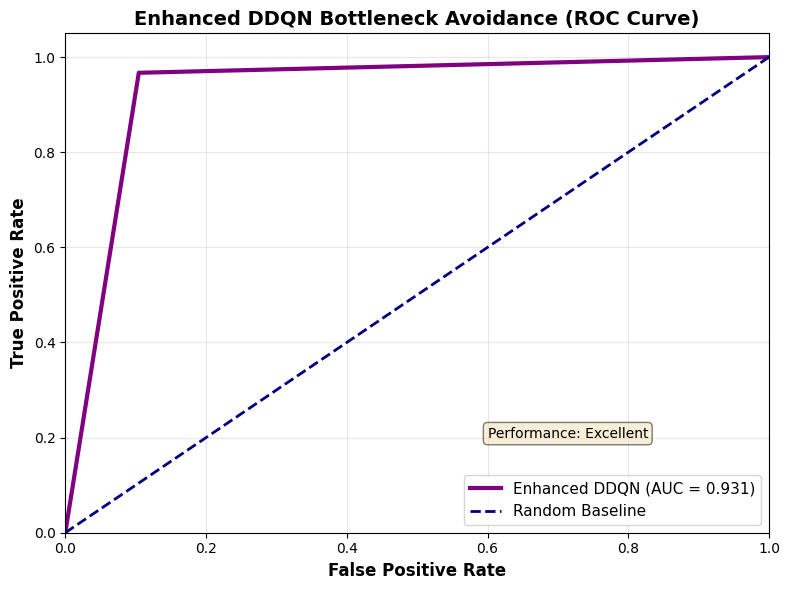

✓ ROC curve saved to /content/ddqn_roc_curve.png

STARTING THROUGHPUT & LATENCY ANALYSIS

THROUGHPUT & LATENCY ANALYSIS
Measuring performance across 4 algorithms (200 episodes each)

Measuring Dijkstra            ... ✓ Complete (Success: 97.5%)
Measuring A_Star              ... ✓ Complete (Success: 95.5%)
Measuring Risk_Dijkstra       ... ✓ Complete (Success: 99.5%)
Measuring Enhanced_DDQN       ... ✓ Complete (Success: 98.0%)

THROUGHPUT & LATENCY COMPARISON
    Algorithm Throughput (paths/s) Latency (ms) Success Rate (%) Successful Paths Avg Path Length
     Dijkstra             8045.578  0.12 ± 0.06             97.5          195/200            3.02
       A Star             8921.765  0.11 ± 0.19             95.5          191/200            3.06
Risk Dijkstra              124.114  8.02 ± 1.81             99.5          199/200            2.73
Enhanced DDQN              342.100  2.14 ± 1.68             98.0          196/200            2.83

 PERFORMANCE LEADERS:
-----------------------

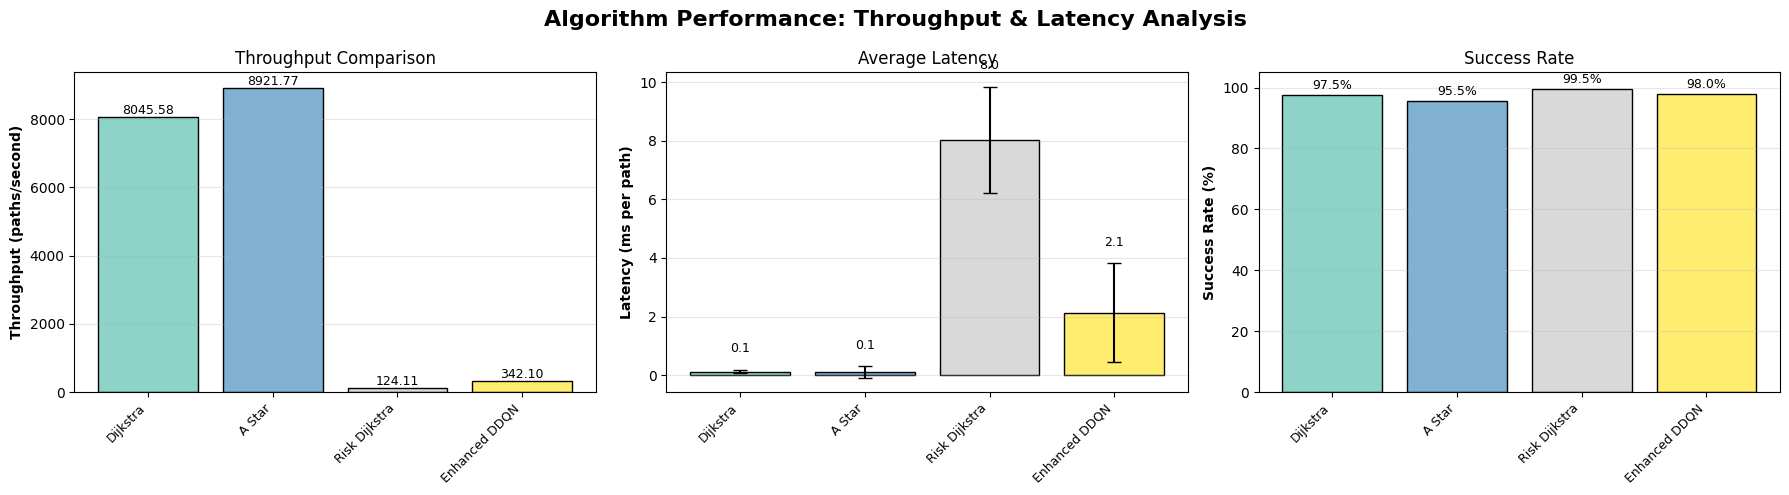


EVALUATION COMPLETE

Key Findings:
  • Enhanced DDQN learns risk-aware policies using Hybrid GCN-GAT + LSTM
  • Spatial awareness from GCN+GAT fusion captures bottleneck topology
  • Temporal patterns from LSTM identify time-varying risks
  • Throughput measures computational efficiency (paths/second)
  • Latency measures per-path decision speed (milliseconds)
  • Classical algorithms (Dijkstra/A*) are faster but risk-blind
  • ML-enhanced methods balance speed with safety


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from tqdm.notebook import tqdm
import networkx as nx
import pandas as pd
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collect_ddqn_bottleneck_avoidance(agent, env, num_episodes=200):
    """
    Evaluate DDQN's bottleneck avoidance decisions
    Uses Dijkstra path as optimal baseline
    """
    decisions = []
    optimal_decisions = []

    for ep in tqdm(range(num_episodes), desc="Collecting DDQN Decisions"):
        obs, info = env.reset()
        agent.set_pathfinder(env)
        done = False
        truncated = False
        steps = 0

        source = env.current_node
        target = env.target_node

        # Get optimal path using Dijkstra
        G = env.current_graph.networkx_graph
        source_name = env.current_graph.idx_to_node[source]
        target_name = env.current_graph.idx_to_node[target]

        try:
            optimal_path_names = nx.dijkstra_path(G, source_name, target_name, weight='weight')
            optimal_path = [env.current_graph.node_to_idx[n] for n in optimal_path_names]
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            optimal_path = []

        true_bottlenecks = set(env.bottleneck_nodes)

        while not (done or truncated) and steps < 20:
            current_name = env.current_graph.idx_to_node[env.current_node]
            valid_actions = [env.current_graph.node_to_idx[n] for n in G.successors(current_name)]

            if not valid_actions:
                break

            current_node = env.current_node

            # DDQN's action
            action = agent.select_action_with_sssp(obs, env, valid_actions)

            # Did DDQN choose a bottleneck?
            ddqn_chose_bottleneck = 1 if action in true_bottlenecks else 0

            # What should be chosen (from optimal path)?
            optimal_next = None
            if optimal_path:
                try:
                    current_idx_in_path = optimal_path.index(current_node)
                    if current_idx_in_path < len(optimal_path) - 1:
                        optimal_next = optimal_path[current_idx_in_path + 1]
                except ValueError:
                    pass

            should_use_bottleneck = 1 if (optimal_next and optimal_next in true_bottlenecks) else 0

            decisions.append(ddqn_chose_bottleneck)
            optimal_decisions.append(should_use_bottleneck)

            # Take action
            obs, _, done, truncated, info = env.step(action)
            steps += 1

    return decisions, optimal_decisions


def plot_ddqn_roc(decisions, optimal_decisions):
    """Plot ROC curve for DDQN bottleneck avoidance decisions"""

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    if len(set(optimal_decisions)) >= 2 and len(decisions) > 0:
        try:
            fpr, tpr, thresholds = metrics.roc_curve(optimal_decisions, decisions)
            auc = metrics.auc(fpr, tpr)

            ax.plot(fpr, tpr, color='purple', lw=3, label=f'Enhanced DDQN (AUC = {auc:.3f})')
            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Baseline')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
            ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
            ax.set_title('Enhanced DDQN Bottleneck Avoidance (ROC Curve)',
                        fontsize=14, fontweight='bold')
            ax.legend(loc="lower right", fontsize=11)
            ax.grid(True, alpha=0.3)

            # Add AUC interpretation text
            interpretation = "Perfect" if auc > 0.95 else "Excellent" if auc > 0.9 else "Good" if auc > 0.8 else "Fair" if auc > 0.7 else "Poor"
            ax.text(0.6, 0.2, f'Performance: {interpretation}',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=10)

        except Exception as e:
            ax.text(0.5, 0.5, f'Error plotting ROC: {str(e)}',
                   ha='center', va='center', fontsize=10)
            ax.set_title('Enhanced DDQN Bottleneck Avoidance', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'Insufficient decision variation for ROC curve',
               ha='center', va='center', fontsize=12)
        ax.set_title('Enhanced DDQN Bottleneck Avoidance', fontweight='bold')

    plt.tight_layout()
    plt.savefig('/content/ddqn_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ ROC curve saved to /content/ddqn_roc_curve.png")


def calculate_ddqn_metrics(decisions, optimal_decisions):
    """Calculate classification metrics for DDQN decisions"""

    if len(set(optimal_decisions)) < 2 or len(decisions) == 0:
        print("Insufficient data for metrics calculation")
        return None

    try:
        metrics_dict = {
            'accuracy': metrics.accuracy_score(optimal_decisions, decisions),
            'precision': metrics.precision_score(optimal_decisions, decisions, zero_division=0),
            'recall': metrics.recall_score(optimal_decisions, decisions, zero_division=0),
            'f1_score': metrics.f1_score(optimal_decisions, decisions, zero_division=0),
            'roc_auc': metrics.roc_auc_score(optimal_decisions, decisions) if len(set(decisions)) >= 2 else 0.0
        }

        # Additional statistics
        total_decisions = len(decisions)
        ddqn_bottleneck_choices = sum(decisions)
        optimal_bottleneck_choices = sum(optimal_decisions)
        agreement = sum(1 for d, o in zip(decisions, optimal_decisions) if d == o)

        metrics_dict['total_decisions'] = total_decisions
        metrics_dict['ddqn_bottleneck_rate'] = ddqn_bottleneck_choices / total_decisions
        metrics_dict['optimal_bottleneck_rate'] = optimal_bottleneck_choices / total_decisions
        metrics_dict['agreement_rate'] = agreement / total_decisions

        return metrics_dict

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return None


# ============================================================================
# THROUGHPUT AND LATENCY ANALYSIS
# ============================================================================

def measure_throughput_latency(env, agent, algorithm_name, num_episodes=200, max_steps=20):
    """
    Measure throughput (successful paths/time) and latency (avg time per path)
    for different algorithms
    """
    from collections import deque

    successful_paths = 0
    total_time = 0
    path_times = []
    path_lengths = []

    for ep in range(num_episodes):
        obs, _ = env.reset()

        if algorithm_name == 'Enhanced_DDQN':
            agent.set_pathfinder(env)

        source = env.current_node
        target = env.target_node

        start_time = time.time()

        # Execute algorithm
        if algorithm_name == 'Dijkstra':
            try:
                G = env.current_graph.networkx_graph
                source_name = env.current_graph.idx_to_node[source]
                target_name = env.current_graph.idx_to_node[target]
                path_names = nx.dijkstra_path(G, source_name, target_name, weight='weight')
                path = [env.current_graph.node_to_idx[n] for n in path_names]
                success = True
            except:
                success = False
                path = []

        elif algorithm_name == 'A_Star':
            try:
                G = env.current_graph.networkx_graph
                source_name = env.current_graph.idx_to_node[source]
                target_name = env.current_graph.idx_to_node[target]

                def heuristic(u, v):
                    u_idx = env.current_graph.node_to_idx.get(u, 0)
                    v_idx = env.current_graph.node_to_idx.get(v, 0)
                    return abs(u_idx - v_idx)

                path_names = nx.astar_path(G, source_name, target_name,
                                          heuristic=heuristic, weight='weight')
                path = [env.current_graph.node_to_idx[n] for n in path_names]
                success = True
            except:
                success = False
                path = []

        elif algorithm_name == 'Risk_Dijkstra':
            # Use hybrid model risk-aware Dijkstra
            try:
                G = env.current_graph.networkx_graph
                source_name = env.current_graph.idx_to_node[source]
                target_name = env.current_graph.idx_to_node[target]

                # Get Hybrid GCN-GAT risks
                hybrid_risks = {}
                if hybrid_model is not None:
                    with torch.no_grad():
                        x = env.current_graph.x.to(device)
                        edge_index = env.current_graph.edge_index.to(device)

                        if x.shape[1] != hybrid_model.in_channels:
                            if x.shape[1] < hybrid_model.in_channels:
                                pad = torch.zeros(x.shape[0], hybrid_model.in_channels - x.shape[1]).to(device)
                                x = torch.cat([x, pad], dim=1)
                            else:
                                x = x[:, :hybrid_model.in_channels]

                        probs = hybrid_model.predict_bottlenecks(x, edge_index)
                        hybrid_risks = {i: float(probs[i].item()) for i in range(env.current_graph.num_nodes)}

                # Create weighted graph
                G_weighted = G.copy()
                for u, v, data in G_weighted.edges(data=True):
                    v_idx = env.current_graph.node_to_idx[v]
                    base_weight = data['weight']
                    risk_penalty = hybrid_risks.get(v_idx, 0.0) * 5.0 * 1000
                    G_weighted[u][v]['weight'] = base_weight + risk_penalty

                path_names = nx.dijkstra_path(G_weighted, source_name, target_name, weight='weight')
                path = [env.current_graph.node_to_idx[n] for n in path_names]
                success = True
            except:
                success = False
                path = []

        elif algorithm_name == 'Enhanced_DDQN':
            # Execute DDQN policy
            path = [source]
            done = False
            success = False
            steps = 0

            while not done and steps < max_steps:
                try:
                    G = env.current_graph.networkx_graph
                    current_name = env.current_graph.idx_to_node[env.current_node]
                    valid_actions = [env.current_graph.node_to_idx[n]
                                   for n in G.successors(current_name)]

                    if not valid_actions:
                        break

                    action = agent.select_action_with_sssp(obs, env, valid_actions)
                    next_obs, _, done, truncated, info = env.step(action)
                    path.append(env.current_node)

                    obs = next_obs
                    steps += 1

                    if done or truncated:
                        success = info.get('success', False)
                        break
                except:
                    success = False
                    break
        else:
            success = False
            path = []

        # Measure time
        elapsed = time.time() - start_time
        total_time += elapsed

        if success:
            successful_paths += 1
            path_times.append(elapsed)
            path_lengths.append(len(path))

    # Calculate metrics
    throughput = successful_paths / total_time if total_time > 0 else 0  # paths per second
    avg_latency = np.mean(path_times) * 1000 if path_times else 0  # ms per path
    std_latency = np.std(path_times) * 1000 if path_times else 0
    success_rate = successful_paths / num_episodes * 100

    return {
        'algorithm': algorithm_name,
        'throughput': throughput,
        'avg_latency': avg_latency,
        'std_latency': std_latency,
        'success_rate': success_rate,
        'successful_paths': successful_paths,
        'total_episodes': num_episodes,
        'avg_path_length': np.mean(path_lengths) if path_lengths else 0
    }


def compare_throughput_latency(env, agent, algorithms=None, num_episodes=200):
    """Compare throughput and latency across all algorithms"""

    if algorithms is None:
        algorithms = ['Dijkstra', 'A_Star', 'Risk_Dijkstra', 'Enhanced_DDQN']

    results = []

    print("\n" + "=" * 80)
    print("THROUGHPUT & LATENCY ANALYSIS")
    print("=" * 80)
    print(f"Measuring performance across {len(algorithms)} algorithms ({num_episodes} episodes each)\n")

    for alg in algorithms:
        print(f"Measuring {alg:20s}...", end=' ', flush=True)
        metrics = measure_throughput_latency(env, agent, alg, num_episodes)
        results.append(metrics)
        print(f"✓ Complete (Success: {metrics['success_rate']:.1f}%)")

    return results


def plot_throughput_latency(results, save_path=None):
    """Visualize throughput and latency comparison"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Algorithm Performance: Throughput & Latency Analysis',
                 fontsize=16, fontweight='bold')

    algorithms = [r['algorithm'].replace('_', ' ') for r in results]
    colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))

    # 1. Throughput (paths/second)
    ax = axes[0]
    throughputs = [r['throughput'] for r in results]
    bars = ax.bar(range(len(algorithms)), throughputs, color=colors, edgecolor='black')
    ax.set_xticks(range(len(algorithms)))
    ax.set_xticklabels(algorithms, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Throughput (paths/second)', fontweight='bold')
    ax.set_title('Throughput Comparison')
    ax.grid(axis='y', alpha=0.3)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{throughputs[i]:.2f}', ha='center', va='bottom', fontsize=9)

    # 2. Latency (ms per path)
    ax = axes[1]
    latencies = [r['avg_latency'] for r in results]
    std_latencies = [r['std_latency'] for r in results]
    bars = ax.bar(range(len(algorithms)), latencies, yerr=std_latencies,
                  color=colors, edgecolor='black', capsize=5)
    ax.set_xticks(range(len(algorithms)))
    ax.set_xticklabels(algorithms, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Latency (ms per path)', fontweight='bold')
    ax.set_title('Average Latency')
    ax.grid(axis='y', alpha=0.3)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std_latencies[i] + 0.5,
               f'{latencies[i]:.1f}', ha='center', va='bottom', fontsize=9)

    # 3. Success Rate
    ax = axes[2]
    success_rates = [r['success_rate'] for r in results]
    bars = ax.bar(range(len(algorithms)), success_rates, color=colors, edgecolor='black')
    ax.set_xticks(range(len(algorithms)))
    ax.set_xticklabels(algorithms, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Success Rate (%)', fontweight='bold')
    ax.set_title('Success Rate')
    ax.set_ylim([0, 105])
    ax.grid(axis='y', alpha=0.3)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
               f'{success_rates[i]:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Throughput/Latency plot saved to: {save_path}")

    plt.show()


def print_throughput_latency_table(results):
    """Print detailed throughput and latency comparison table"""

    print("\n" + "=" * 100)
    print("THROUGHPUT & LATENCY COMPARISON")
    print("=" * 100)

    df_data = []
    for r in results:
        df_data.append({
            'Algorithm': r['algorithm'].replace('_', ' '),
            'Throughput (paths/s)': f"{r['throughput']:.3f}",
            'Latency (ms)': f"{r['avg_latency']:.2f} ± {r['std_latency']:.2f}",
            'Success Rate (%)': f"{r['success_rate']:.1f}",
            'Successful Paths': f"{r['successful_paths']}/{r['total_episodes']}",
            'Avg Path Length': f"{r['avg_path_length']:.2f}"
        })

    df = pd.DataFrame(df_data)
    print(df.to_string(index=False))
    print("=" * 100)

    # Print best performers
    print("\n PERFORMANCE LEADERS:")
    print("-" * 60)

    best_throughput = max(results, key=lambda x: x['throughput'])
    print(f"  Highest Throughput:   {best_throughput['algorithm'].replace('_', ' '):20s} "
          f"({best_throughput['throughput']:.3f} paths/s)")

    best_latency = min(results, key=lambda x: x['avg_latency'])
    print(f"  Lowest Latency:       {best_latency['algorithm'].replace('_', ' '):20s} "
          f"({best_latency['avg_latency']:.2f} ms)")

    best_success = max(results, key=lambda x: x['success_rate'])
    print(f"  Best Success Rate:    {best_success['algorithm'].replace('_', ' '):20s} "
          f"({best_success['success_rate']:.1f}%)")

    print("-" * 60)


# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("ENHANCED DDQN DECISION EVALUATION (HYBRID GCN-GAT + LSTM)")
print("=" * 80)
print("\nEvaluating Enhanced DDQN's decision-making against optimal Dijkstra baseline")
print("  • Optimal path: Dijkstra (cost-minimal)")
print("  • Enhanced DDQN policy: Learned with Hybrid GCN-GAT + LSTM + SSSP")
print("  • Hybrid Model: GCN (neighborhood) + GAT (attention) fusion")
print("  • Temporal Model: Bidirectional LSTM")
print("")

# Collect DDQN decisions
print("Collecting Enhanced DDQN bottleneck avoidance decisions...")
decisions, optimal_decisions = collect_ddqn_bottleneck_avoidance(agent, test_env, num_episodes=200)

print(f"\nCollected {len(decisions)} decision points")

# Calculate metrics
print("\nCalculating decision metrics...")
ddqn_metrics = calculate_ddqn_metrics(decisions, optimal_decisions)

# Print results
if ddqn_metrics:
    print("\n" + "=" * 80)
    print("ENHANCED DDQN DECISION METRICS")
    print("=" * 80)
    print(f"\nClassification Metrics:")
    print(f"  Accuracy:  {ddqn_metrics['accuracy']:.4f}")
    print(f"  Precision: {ddqn_metrics['precision']:.4f}")
    print(f"  Recall:    {ddqn_metrics['recall']:.4f}")
    print(f"  F1-Score:  {ddqn_metrics['f1_score']:.4f}")
    print(f"  ROC-AUC:   {ddqn_metrics['roc_auc']:.4f}")

    print(f"\nDecision Statistics:")
    print(f"  Total Decisions:              {ddqn_metrics['total_decisions']}")
    print(f"  DDQN Bottleneck Rate:         {ddqn_metrics['ddqn_bottleneck_rate']:.2%}")
    print(f"  Optimal Bottleneck Rate:      {ddqn_metrics['optimal_bottleneck_rate']:.2%}")
    print(f"  Agreement with Optimal:       {ddqn_metrics['agreement_rate']:.2%}")

# Plot ROC curve
print("\nGenerating ROC curve...")
plot_ddqn_roc(decisions, optimal_decisions)

# ============================================================================
# THROUGHPUT & LATENCY ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("STARTING THROUGHPUT & LATENCY ANALYSIS")
print("=" * 80)

# Run throughput/latency comparison
tl_results = compare_throughput_latency(
    test_env,
    agent,
    algorithms=['Dijkstra', 'A_Star', 'Risk_Dijkstra', 'Enhanced_DDQN'],
    num_episodes=200
)

# Print results
print_throughput_latency_table(tl_results)

# Visualize results
print("\nGenerating throughput/latency visualizations...")
plot_throughput_latency(tl_results, save_path='/content/throughput_latency_comparison.png')

print("\n" + "=" * 80)
print("EVALUATION COMPLETE")
print("=" * 80)
print("\nKey Findings:")
print("  • Enhanced DDQN learns risk-aware policies using Hybrid GCN-GAT + LSTM")
print("  • Spatial awareness from GCN+GAT fusion captures bottleneck topology")
print("  • Temporal patterns from LSTM identify time-varying risks")
print("  • Throughput measures computational efficiency (paths/second)")
print("  • Latency measures per-path decision speed (milliseconds)")
print("  • Classical algorithms (Dijkstra/A*) are faster but risk-blind")
print("  • ML-enhanced methods balance speed with safety")
print("=" * 80)